# RomyEvents - Automatic Eventplots

Creates automatic event plots based on catalog 

In [5]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from pprint import pprint

# from functions.request_data import __request_data
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth


In [6]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [7]:
def __makeplot(config, st):


    st_in = st.copy()

    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6

    for i, tr in enumerate(st_in):

        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        ax[i].legend(loc=1)

    ax[5].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)

    plt.show();
    del st_in
    return fig

In [8]:
def __makeplotStreamSpectra2(st, config, fscale=None):

    from scipy import fftpack
    from andbro__fft import __fft
    import matplotlib.pyplot as plt

    st_in = st.copy()

    NN = len(st_in)
    rot_scaling, rot_unit = 1e9, r"nrad/s"
    trans_scaling, trans_unit = 1e6, r"$\mu$m/s"

    fig, axes = plt.subplots(NN,2,figsize=(15,int(NN*2)), sharex='col')

    font = 14

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    for i, tr in enumerate(st_in):

#         comp_fft = abs(fftpack.fft(tr.data))
#         ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
#         comp_fft = fftpack.fftshift(comp_fft)
#         ff, spec = ff[1:len(ff)//2], abs(fftpack.fft(tr.data)[1:len(ff)//2])

        if tr.stats.channel[-2] == "J":
            scaling = rot_scaling
        elif tr.stats.channel[-2] == "H":
            scaling = trans_scaling

        spec, ff, ph = __fft(tr.data*scaling, tr.stats.delta, window=None, normalize=None)


        ## _________________________________________________________________
        if tr.stats.channel[-2] == "J":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*rot_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )

        elif tr.stats.channel[-2] == "H":
            axes[i,0].plot(
                        tr.times(),
                        tr.data*trans_scaling,
                        color='black',
                        label='{} {}'.format(tr.stats.station, tr.stats.channel),
                        lw=1.0,
                        )
        ## _________________________________________________________________
        if fscale == "loglog":
            axes[i,1].loglog(ff, spec, color='black', lw=1.0)
        elif fscale == "loglin":
            axes[i,1].semilogx(ff, spec, color='black', lw=1.0)
        elif fscale == "linlog":
            axes[i,1].semilogy(ff, spec, color='black', lw=1.0)
        else:
            axes[i,1].plot(ff, spec, color='black', lw=1.0)         


        if tr.stats.channel[1] == "J":
            sym, unit = r"$\Omega$", rot_unit
        elif tr.stats.channel[1] == "H":
            sym, unit = "v", trans_unit
        else:
            unit = "Amplitude", "a.u."

        axes[i,0].set_ylabel(f'{sym} ({unit})',fontsize=font)    
        axes[i,1].set_ylabel(f'ASD \n({unit}/Hz)',fontsize=font)        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    if "fmin" in config.keys() and "fmax" in config.keys():
        axes[i,1].set_xlim(config['fmin'],config['fmax'])

    axes[NN-1,0].set_xlabel(f"Time from {tr.stats.starttime.date} {str(tr.stats.starttime.time)[:8]} (s)",fontsize=font)     
    axes[NN-1,1].set_xlabel(f"Frequency (Hz)",fontsize=font)     

    del st_in
    return fig

In [9]:
def __empty_stream(reference_stream):

    from numpy import ones
    from obspy import Stream, Trace

    t_ref = reference_stream[0]

    empty = Stream()

    for cha in ["BHZ", "BHN", "BHE"]:
        t = Trace()
        t.data = ones(len(t_ref))
        t.stats.sampling_rate = t_ref.stats.sampling_rate
        t.stats.starttime = t_ref.stats.starttime
        t.stats.network, t.stats.station, t.stats.channel = "PY", "RPFO", cha
        empty += t

    return empty

## Configurations

In [6]:
config = {}

## ROMY coordinates
config['ROMY_lon'] = 11.275501
config['ROMY_lat'] = 48.162941

## path for figures to store
config['outpath_figs'] = data_path+"romy_events/figures/raw/"

## path for output data
config['outpath_data'] = data_path+"romy_events/data/waveforms/"

## blueSeis sensor (@200Hz)
config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier (@40Hz)
config['seed_seismometer1'] = "II.PFO.10.BH*"
# config['seed_seismometer1'] = "II.XPFO.30.BH*"

## STS2 next to BlueSeis (@200Hz)
config['seed_seismometer2'] = "PY.PFOIX..HH*"

config['path_to_catalog'] = data_path+"BSPF/data/catalogs/"

config['catalog'] = "BSPF_catalog_20221001_20230930_triggered.pkl"

## Event Info

In [7]:
events = pd.read_pickle(config['path_to_catalog']+config['catalog'])

## RUN LOOP

  0%|          | 0/328 [00:00<?, ?it/s]


 -> 0 2022-10-01 05:36:11.240000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-01T05:35:56.241400Z - 2022-10-01T05:36:56.216400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-01T05:35:56.241400Z - 2022-10-01T05:36:56.216400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-01T05:35:56.241400Z - 2022-10-01T05:36:56.216400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


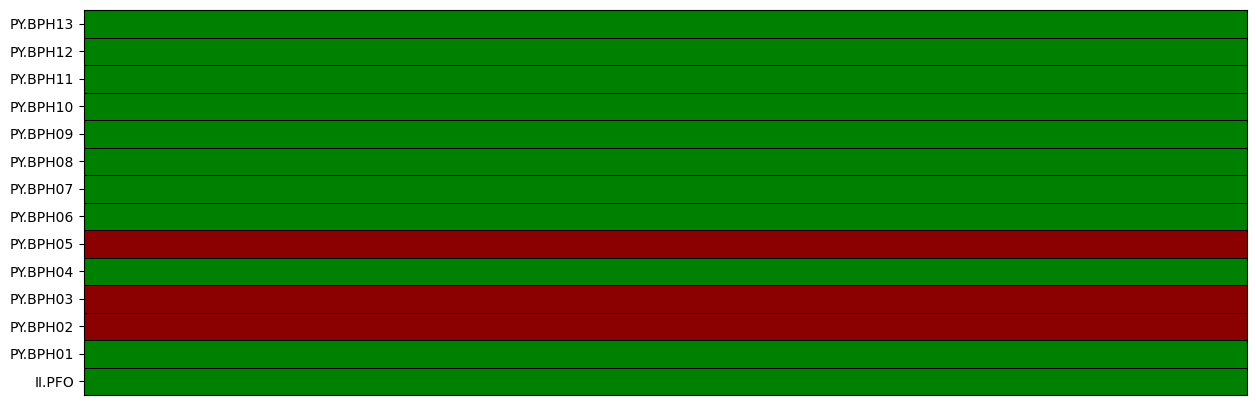


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-01T05:35:56.244539Z - 2022-10-01T05:36:56.244539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-01T05:35:56.244539Z - 2022-10-01T05:36:56.244539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-01T05:35:56.244539Z - 2022-10-01T05:36:56.244539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-01T05:35:56.244539Z - 2022-10-01T05:36:56.244539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-01T05:35:56.244539Z - 2022-10-01T05:36:56.244539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-01T05:35:56.244539Z - 2022-10-01T05:36:56.244539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-01T05:35:56.244539Z - 2022-10-01T05:36:56.244539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-01T05:35:56.244539Z - 2022-10-01T05:36:56.244539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-01T05:35:56.244539Z - 2022-10-01T05:36:56.244539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-01T05:35:56.244539Z - 2022-10-01T05:36:56.244539Z |


 -> 1 2022-10-01 21:26:43.530000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-01T21:26:28.531400Z - 2022-10-01T21:27:28.506400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-01T21:26:28.531400Z - 2022-10-01T21:27:28.506400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-01T21:26:28.531400Z - 2022-10-01T21:27:28.506400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


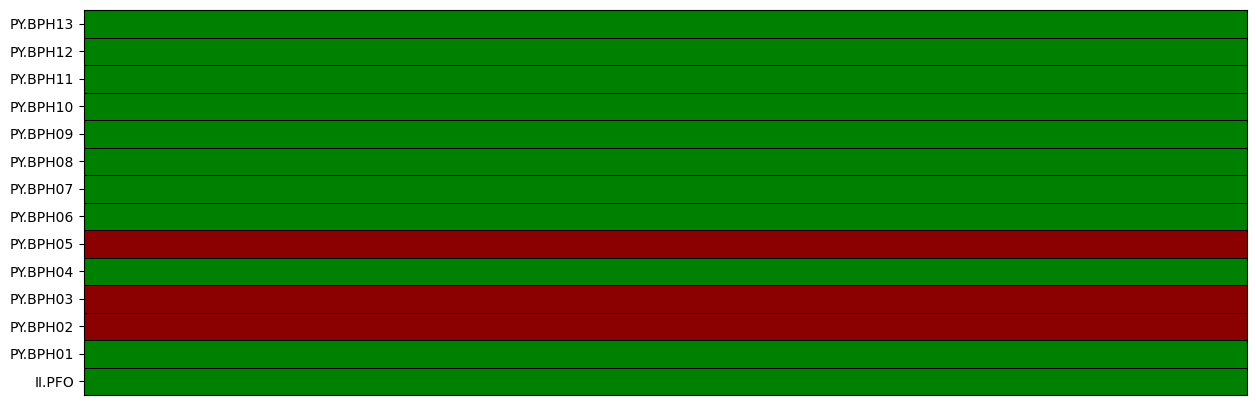


 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-01T21:26:28.519538Z - 2022-10-01T21:27:28.519538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-01T21:26:28.519538Z - 2022-10-01T21:27:28.519538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-01T21:26:28.519538Z - 2022-10-01T21:27:28.519538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-01T21:26:28.519538Z - 2022-10-01T21:27:28.519538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-01T21:26:28.519538Z - 2022-10-01T21:27:28.519538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-01T21:26:28.519538Z - 2022-10-01T21:27:28.519538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-01T21:26:28.519538Z - 2022-10-01T21:27:28.519538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-01T21:26:28.519538Z - 2022-10-01T21:27:28.519538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-01T21:26:28.519538Z - 2022-10-01T21:27:28.519538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-01T21:26:28.519538Z - 2022-10-01T21:27:28.519538Z |


 -> 2 2022-10-02 03:25:16.440000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-02T03:25:01.441400Z - 2022-10-02T03:26:01.416400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-02T03:25:01.441400Z - 2022-10-02T03:26:01.416400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-02T03:25:01.441400Z - 2022-10-02T03:26:01.416400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


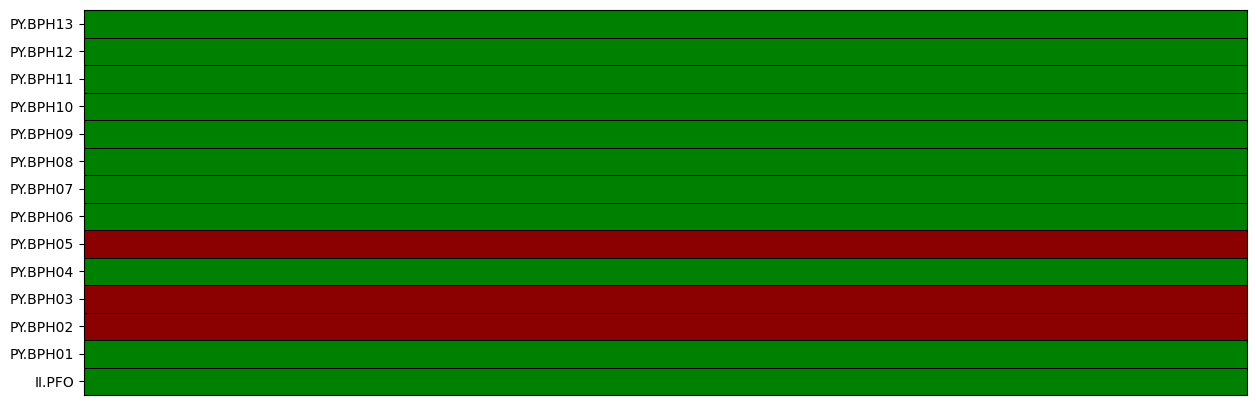


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-02T03:25:01.444538Z - 2022-10-02T03:26:01.444538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-02T03:25:01.444538Z - 2022-10-02T03:26:01.444538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-02T03:25:01.444538Z - 2022-10-02T03:26:01.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-02T03:25:01.444538Z - 2022-10-02T03:26:01.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-02T03:25:01.444538Z - 2022-10-02T03:26:01.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-02T03:25:01.444538Z - 2022-10-02T03:26:01.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-02T03:25:01.444538Z - 2022-10-02T03:26:01.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-02T03:25:01.444538Z - 2022-10-02T03:26:01.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-02T03:25:01.444538Z - 2022-10-02T03:26:01.444538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-02T03:25:01.444538Z - 2022-10-02T03:26:01.444538Z |


 -> 3 2022-10-02 15:51:37.180000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-02T15:51:22.181400Z - 2022-10-02T15:52:22.156400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-02T15:51:22.181400Z - 2022-10-02T15:52:22.156400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-02T15:51:22.181400Z - 2022-10-02T15:52:22.156400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


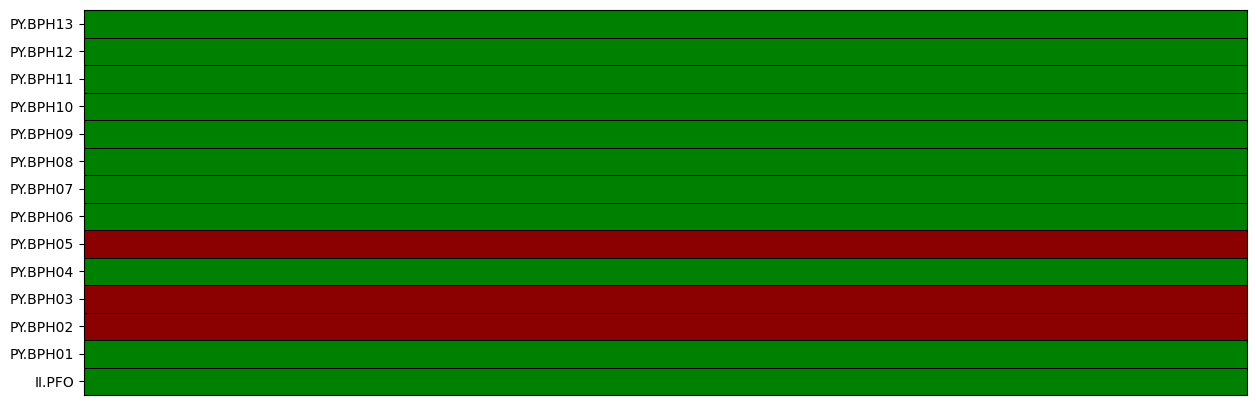


 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-02T15:51:22.169538Z - 2022-10-02T15:52:22.169538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-02T15:51:22.169538Z - 2022-10-02T15:52:22.169538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-02T15:51:22.169538Z - 2022-10-02T15:52:22.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-02T15:51:22.169538Z - 2022-10-02T15:52:22.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-02T15:51:22.169538Z - 2022-10-02T15:52:22.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-02T15:51:22.169538Z - 2022-10-02T15:52:22.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-02T15:51:22.169538Z - 2022-10-02T15:52:22.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-02T15:51:22.169538Z - 2022-10-02T15:52:22.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-02T15:51:22.169538Z - 2022-10-02T15:52:22.169538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-02T15:51:22.169538Z - 2022-10-02T15:52:22.169538Z |


 -> 4 2022-10-02 21:52:54.280000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-02T21:52:39.278900Z - 2022-10-02T21:53:39.253900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-02T21:52:39.278900Z - 2022-10-02T21:53:39.253900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-02T21:52:39.278900Z - 2022-10-02T21:53:39.253900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


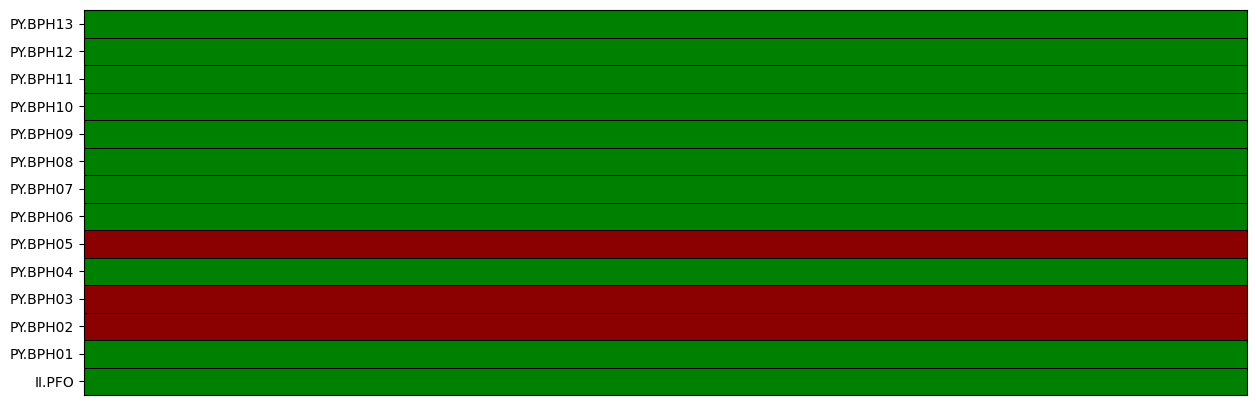


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-02T21:52:39.269538Z - 2022-10-02T21:53:39.269538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-02T21:52:39.269538Z - 2022-10-02T21:53:39.269538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-02T21:52:39.269538Z - 2022-10-02T21:53:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-02T21:52:39.269538Z - 2022-10-02T21:53:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-02T21:52:39.269538Z - 2022-10-02T21:53:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-02T21:52:39.269538Z - 2022-10-02T21:53:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-02T21:52:39.269538Z - 2022-10-02T21:53:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-02T21:52:39.269538Z - 2022-10-02T21:53:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-02T21:52:39.269538Z - 2022-10-02T21:53:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-02T21:52:39.269538Z - 2022-10-02T21:53:39.269538Z |


 -> 5 2022-10-03 16:08:09.970000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-03T16:07:54.972300Z - 2022-10-03T16:08:54.947300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-03T16:07:54.972300Z - 2022-10-03T16:08:54.947300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-03T16:07:54.972300Z - 2022-10-03T16:08:54.947300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


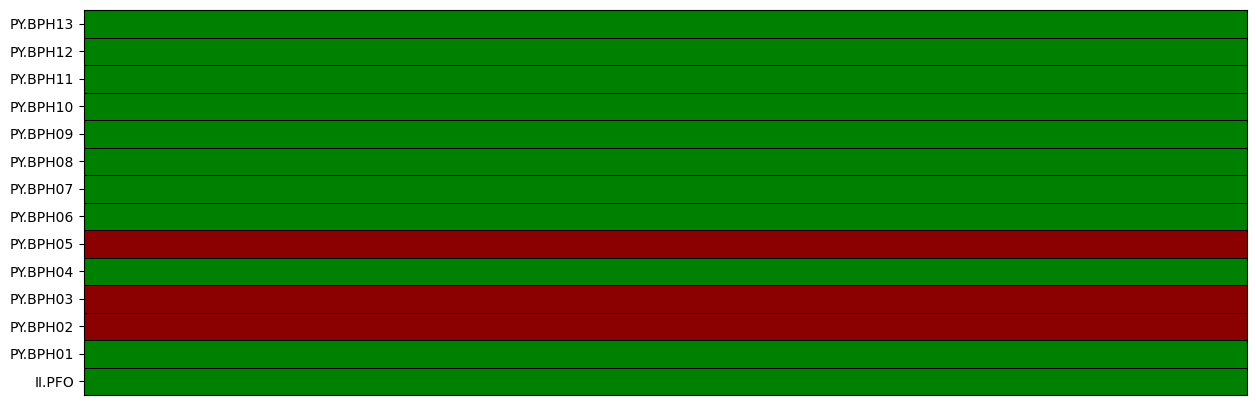


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-03T16:07:54.969538Z - 2022-10-03T16:08:54.969538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-03T16:07:54.969538Z - 2022-10-03T16:08:54.969538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-03T16:07:54.969538Z - 2022-10-03T16:08:54.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-03T16:07:54.969538Z - 2022-10-03T16:08:54.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-03T16:07:54.969538Z - 2022-10-03T16:08:54.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-03T16:07:54.969538Z - 2022-10-03T16:08:54.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-03T16:07:54.969538Z - 2022-10-03T16:08:54.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-03T16:07:54.969538Z - 2022-10-03T16:08:54.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-03T16:07:54.969538Z - 2022-10-03T16:08:54.969538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-03T16:07:54.969538Z - 2022-10-03T16:08:54.969538Z |


 -> 6 2022-10-04 22:33:48.370000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-04T22:33:33.372400Z - 2022-10-04T22:34:33.347400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-04T22:33:33.372400Z - 2022-10-04T22:34:33.347400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-04T22:33:33.372400Z - 2022-10-04T22:34:33.347400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


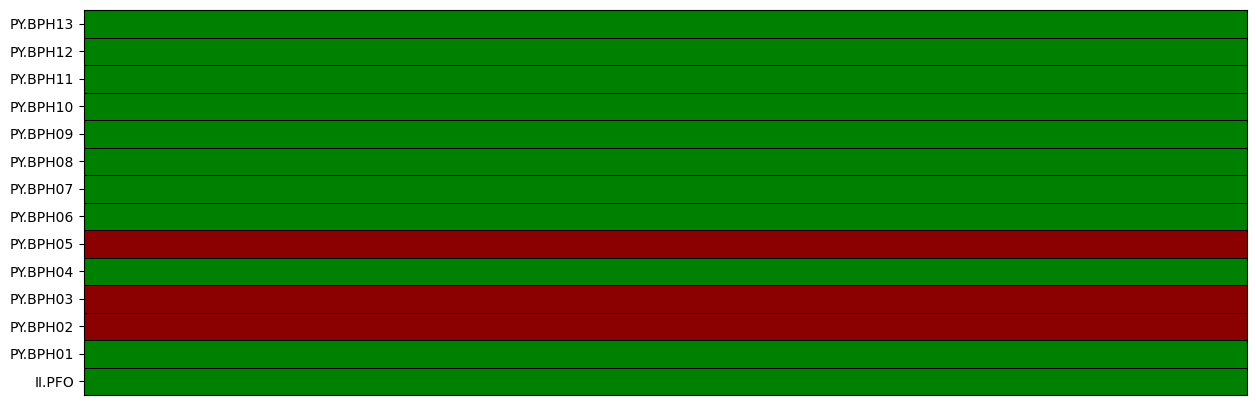


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-04T22:33:33.369539Z - 2022-10-04T22:34:33.369539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-04T22:33:33.369539Z - 2022-10-04T22:34:33.369539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-04T22:33:33.369539Z - 2022-10-04T22:34:33.369539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-04T22:33:33.369539Z - 2022-10-04T22:34:33.369539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-04T22:33:33.369539Z - 2022-10-04T22:34:33.369539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-04T22:33:33.369539Z - 2022-10-04T22:34:33.369539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-04T22:33:33.369539Z - 2022-10-04T22:34:33.369539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-04T22:33:33.369539Z - 2022-10-04T22:34:33.369539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-04T22:33:33.369539Z - 2022-10-04T22:34:33.369539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-04T22:33:33.369539Z - 2022-10-04T22:34:33.369539Z |


 -> 7 2022-10-05 15:39:32.640000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-05T15:39:17.642400Z - 2022-10-05T15:40:17.617400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-05T15:39:17.642400Z - 2022-10-05T15:40:17.617400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-05T15:39:17.642400Z - 2022-10-05T15:40:17.617400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


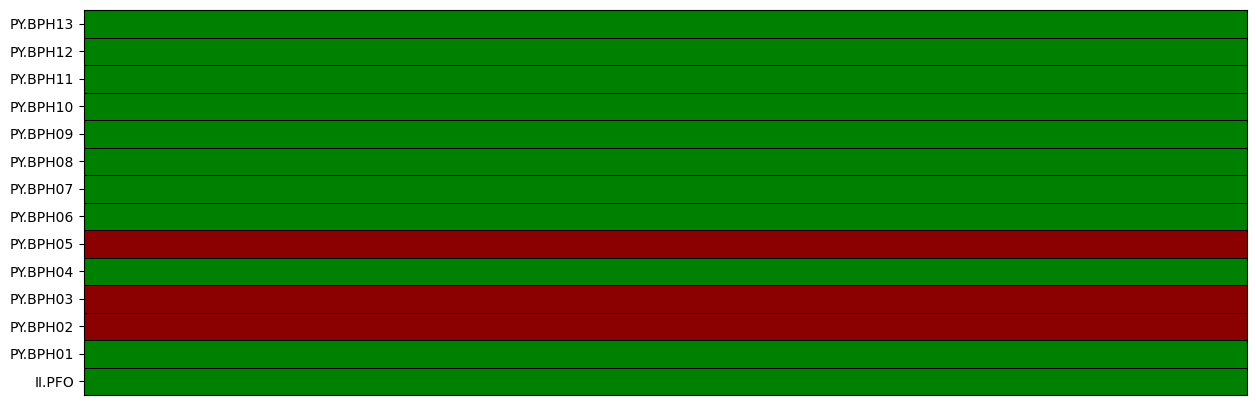


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.35 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-05T15:39:17.644538Z - 2022-10-05T15:40:17.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-05T15:39:17.644538Z - 2022-10-05T15:40:17.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-05T15:39:17.644538Z - 2022-10-05T15:40:17.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-05T15:39:17.644538Z - 2022-10-05T15:40:17.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-05T15:39:17.644538Z - 2022-10-05T15:40:17.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-05T15:39:17.644538Z - 2022-10-05T15:40:17.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-05T15:39:17.644538Z - 2022-10-05T15:40:17.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-05T15:39:17.644538Z - 2022-10-05T15:40:17.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-05T15:39:17.644538Z - 2022-10-05T15:40:17.644538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-05T15:39:17.644538Z - 2022-10-05T15:40:17.644538Z |


 -> 8 2022-10-08 02:52:33.350000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-08T02:52:18.352300Z - 2022-10-08T02:53:18.327300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-08T02:52:18.352300Z - 2022-10-08T02:53:18.327300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-08T02:52:18.352300Z - 2022-10-08T02:53:18.327300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


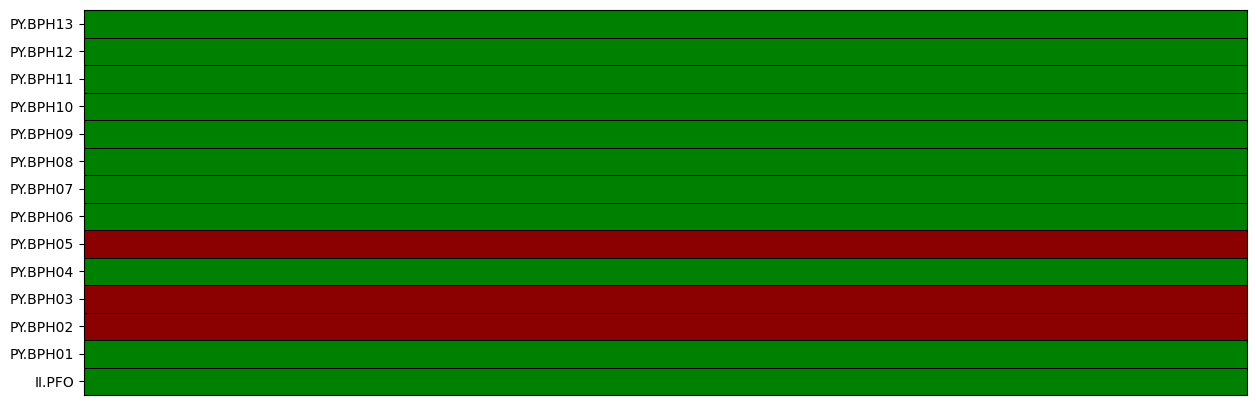


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-08T02:52:18.344539Z - 2022-10-08T02:53:18.344539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-08T02:52:18.344539Z - 2022-10-08T02:53:18.344539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-08T02:52:18.344539Z - 2022-10-08T02:53:18.344539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-08T02:52:18.344539Z - 2022-10-08T02:53:18.344539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-08T02:52:18.344539Z - 2022-10-08T02:53:18.344539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-08T02:52:18.344539Z - 2022-10-08T02:53:18.344539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-08T02:52:18.344539Z - 2022-10-08T02:53:18.344539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-08T02:52:18.344539Z - 2022-10-08T02:53:18.344539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-08T02:52:18.344539Z - 2022-10-08T02:53:18.344539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-08T02:52:18.344539Z - 2022-10-08T02:53:18.344539Z |


 -> 9 2022-10-08 02:59:39.290000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-08T02:59:24.292300Z - 2022-10-08T03:00:24.267300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-08T02:59:24.292300Z - 2022-10-08T03:00:24.267300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-08T02:59:24.292300Z - 2022-10-08T03:00:24.267300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


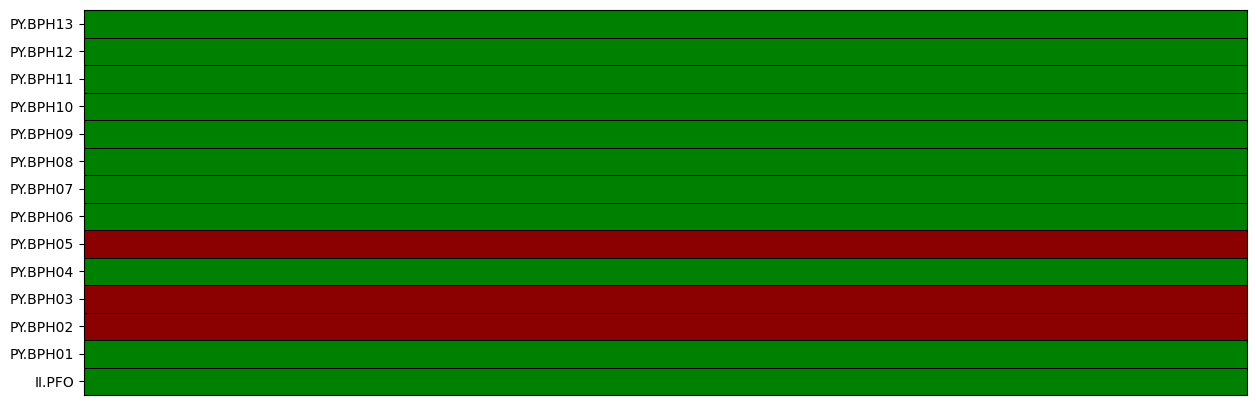


 -> Runtime: 0.59 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-08T02:59:24.294539Z - 2022-10-08T03:00:24.294539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-08T02:59:24.294539Z - 2022-10-08T03:00:24.294539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-08T02:59:24.294539Z - 2022-10-08T03:00:24.294539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-08T02:59:24.294539Z - 2022-10-08T03:00:24.294539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-08T02:59:24.294539Z - 2022-10-08T03:00:24.294539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-08T02:59:24.294539Z - 2022-10-08T03:00:24.294539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-08T02:59:24.294539Z - 2022-10-08T03:00:24.294539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-08T02:59:24.294539Z - 2022-10-08T03:00:24.294539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-08T02:59:24.294539Z - 2022-10-08T03:00:24.294539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-08T02:59:24.294539Z - 2022-10-08T03:00:24.294539Z |


 -> 10 2022-10-09 08:33:00.550000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-09T08:32:45.549705Z - 2022-10-09T08:33:45.524705Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-09T08:32:45.549705Z - 2022-10-09T08:33:45.524705Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-09T08:32:45.549705Z - 2022-10-09T08:33:45.524705Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


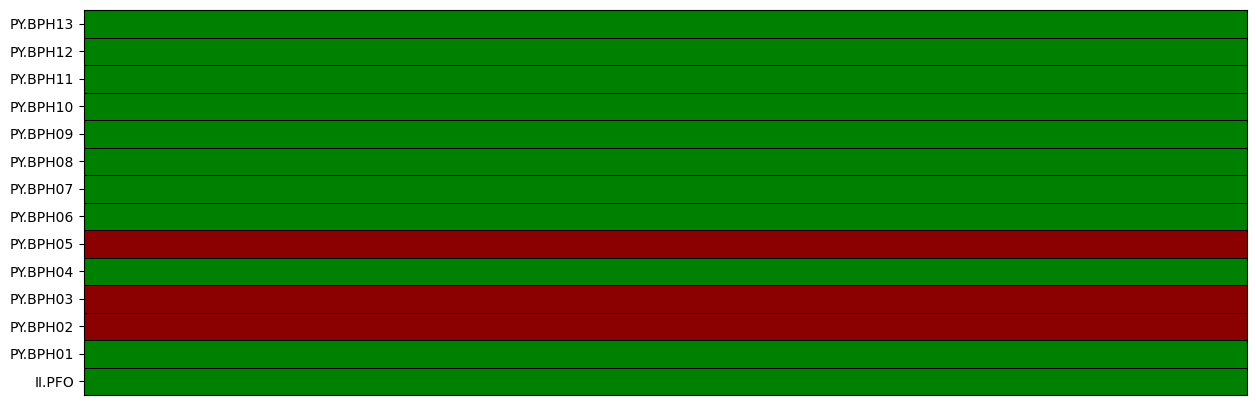


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-09T08:32:45.544538Z - 2022-10-09T08:33:45.544538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-09T08:32:45.544538Z - 2022-10-09T08:33:45.544538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-09T08:32:45.544538Z - 2022-10-09T08:33:45.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-09T08:32:45.544538Z - 2022-10-09T08:33:45.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-09T08:32:45.544538Z - 2022-10-09T08:33:45.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-09T08:32:45.544538Z - 2022-10-09T08:33:45.544538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-09T08:32:45.544538Z - 2022-10-09T08:33:45.544538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-09T08:32:45.544538Z - 2022-10-09T08:33:45.544538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-09T08:32:45.544538Z - 2022-10-09T08:33:45.544538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-09T08:32:45.544538Z - 2022-10-09T08:33:45.544538Z |


 -> 11 2022-10-09 11:44:41.790000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-09T11:44:26.790505Z - 2022-10-09T11:45:26.765505Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-09T11:44:26.790505Z - 2022-10-09T11:45:26.765505Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-09T11:44:26.790505Z - 2022-10-09T11:45:26.765505Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


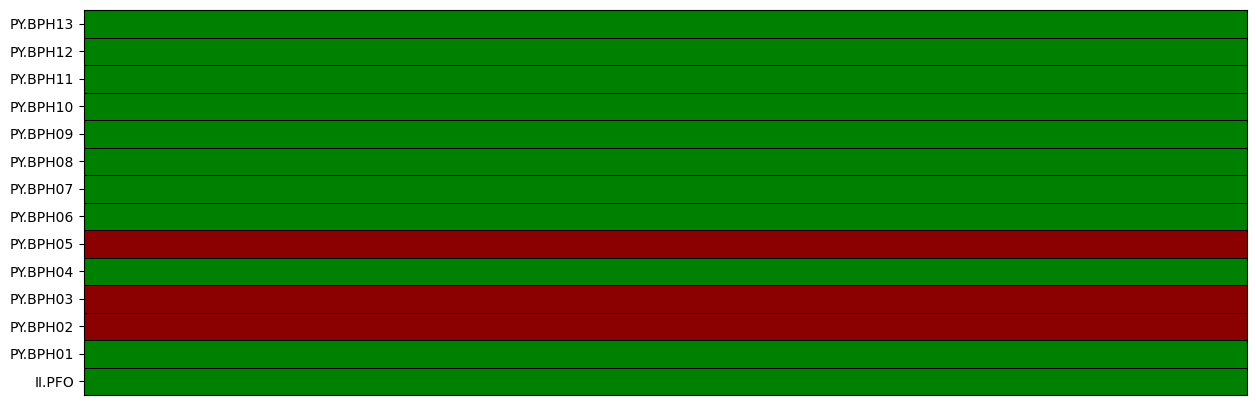


 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-09T11:44:26.794538Z - 2022-10-09T11:45:26.794538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-09T11:44:26.794538Z - 2022-10-09T11:45:26.794538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-09T11:44:26.794538Z - 2022-10-09T11:45:26.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-09T11:44:26.794538Z - 2022-10-09T11:45:26.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-09T11:44:26.794538Z - 2022-10-09T11:45:26.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-09T11:44:26.794538Z - 2022-10-09T11:45:26.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-09T11:44:26.794538Z - 2022-10-09T11:45:26.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-09T11:44:26.794538Z - 2022-10-09T11:45:26.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-09T11:44:26.794538Z - 2022-10-09T11:45:26.794538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-09T11:44:26.794538Z - 2022-10-09T11:45:26.794538Z |


 -> 12 2022-10-09 17:51:16.290000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-09T17:51:01.292205Z - 2022-10-09T17:52:01.267205Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-09T17:51:01.292205Z - 2022-10-09T17:52:01.267205Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-09T17:51:01.292205Z - 2022-10-09T17:52:01.267205Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


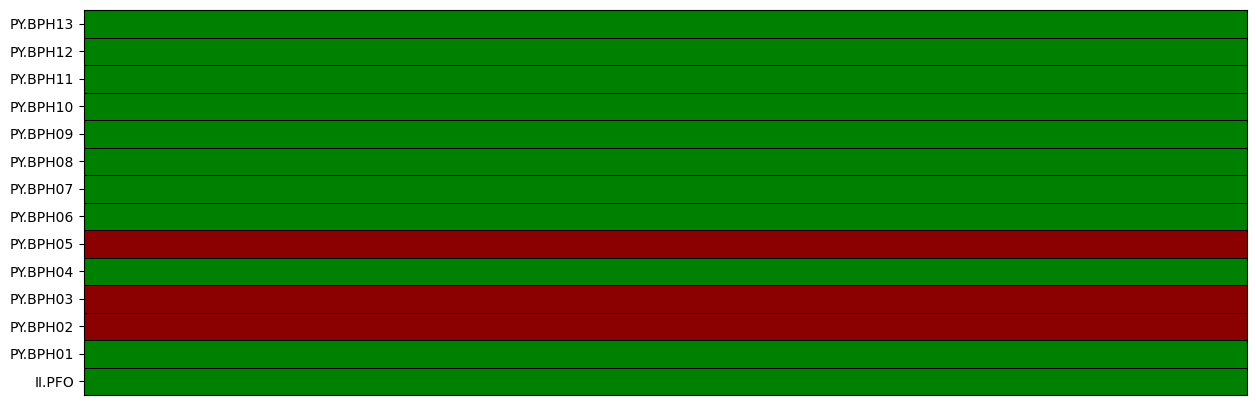


 -> Runtime: 0.58 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-09T17:51:01.294539Z - 2022-10-09T17:52:01.294539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-09T17:51:01.294539Z - 2022-10-09T17:52:01.294539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-09T17:51:01.294539Z - 2022-10-09T17:52:01.294539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-09T17:51:01.294539Z - 2022-10-09T17:52:01.294539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-09T17:51:01.294539Z - 2022-10-09T17:52:01.294539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-09T17:51:01.294539Z - 2022-10-09T17:52:01.294539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-09T17:51:01.294539Z - 2022-10-09T17:52:01.294539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-09T17:51:01.294539Z - 2022-10-09T17:52:01.294539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-09T17:51:01.294539Z - 2022-10-09T17:52:01.294539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-09T17:51:01.294539Z - 2022-10-09T17:52:01.294539Z |


 -> 13 2022-10-14 03:49:02.940000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-14T03:48:47.939100Z - 2022-10-14T03:49:47.914100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-14T03:48:47.939100Z - 2022-10-14T03:49:47.914100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-14T03:48:47.939100Z - 2022-10-14T03:49:47.914100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


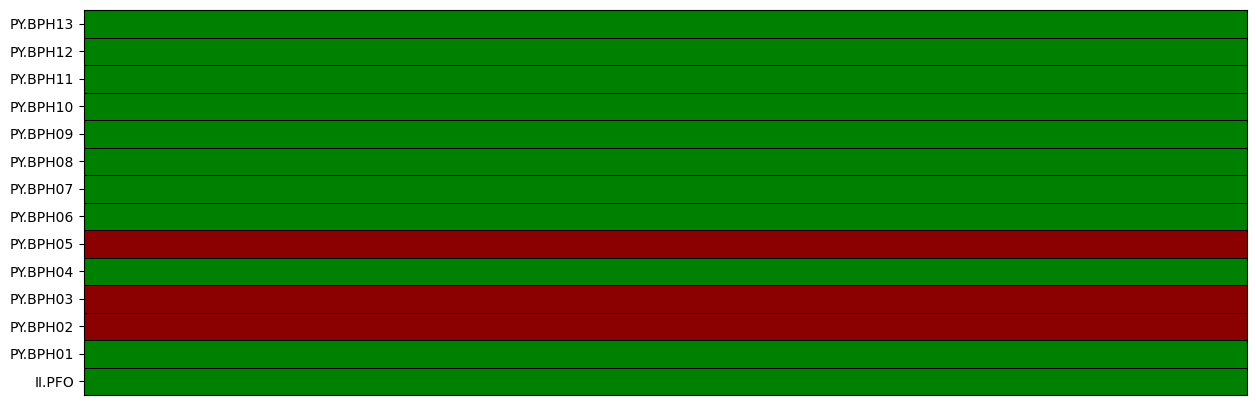


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.38 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-14T03:48:47.944538Z - 2022-10-14T03:49:47.944538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-14T03:48:47.944538Z - 2022-10-14T03:49:47.944538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-14T03:48:47.944538Z - 2022-10-14T03:49:47.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-14T03:48:47.944538Z - 2022-10-14T03:49:47.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-14T03:48:47.944538Z - 2022-10-14T03:49:47.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-14T03:48:47.944538Z - 2022-10-14T03:49:47.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-14T03:48:47.944538Z - 2022-10-14T03:49:47.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-14T03:48:47.944538Z - 2022-10-14T03:49:47.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-14T03:48:47.944538Z - 2022-10-14T03:49:47.944538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-14T03:48:47.944538Z - 2022-10-14T03:49:47.944538Z |


 -> 14 2022-10-15 05:17:34.150000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-15T05:17:19.149100Z - 2022-10-15T05:18:19.124100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-15T05:17:19.149100Z - 2022-10-15T05:18:19.124100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-15T05:17:19.149100Z - 2022-10-15T05:18:19.124100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


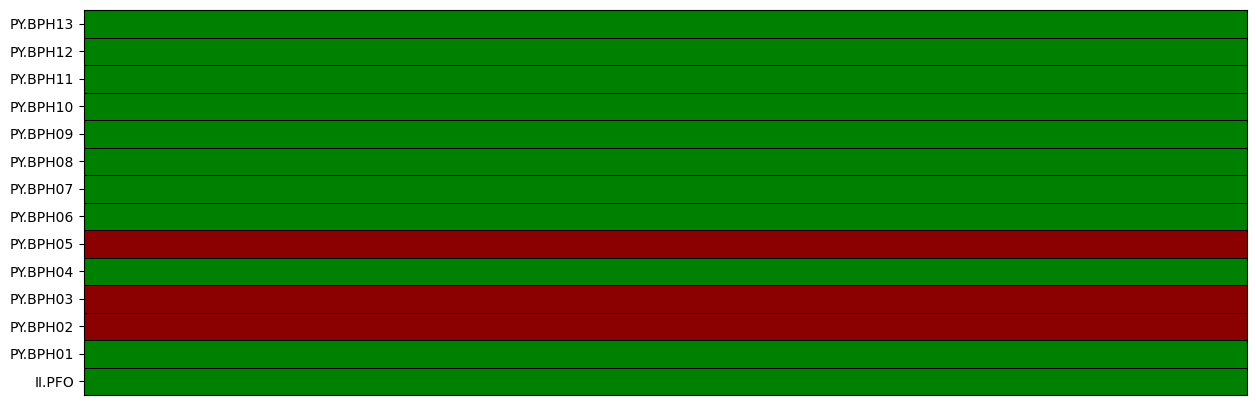


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-15T05:17:19.144538Z - 2022-10-15T05:18:19.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-15T05:17:19.144538Z - 2022-10-15T05:18:19.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-15T05:17:19.144538Z - 2022-10-15T05:18:19.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-15T05:17:19.144538Z - 2022-10-15T05:18:19.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-15T05:17:19.144538Z - 2022-10-15T05:18:19.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-15T05:17:19.144538Z - 2022-10-15T05:18:19.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-15T05:17:19.144538Z - 2022-10-15T05:18:19.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-15T05:17:19.144538Z - 2022-10-15T05:18:19.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-15T05:17:19.144538Z - 2022-10-15T05:18:19.144538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-15T05:17:19.144538Z - 2022-10-15T05:18:19.144538Z |


 -> 15 2022-10-17 05:25:28.830000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-17T05:25:13.828700Z - 2022-10-17T05:26:13.803700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-17T05:25:13.828700Z - 2022-10-17T05:26:13.803700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-17T05:25:13.828700Z - 2022-10-17T05:26:13.803700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


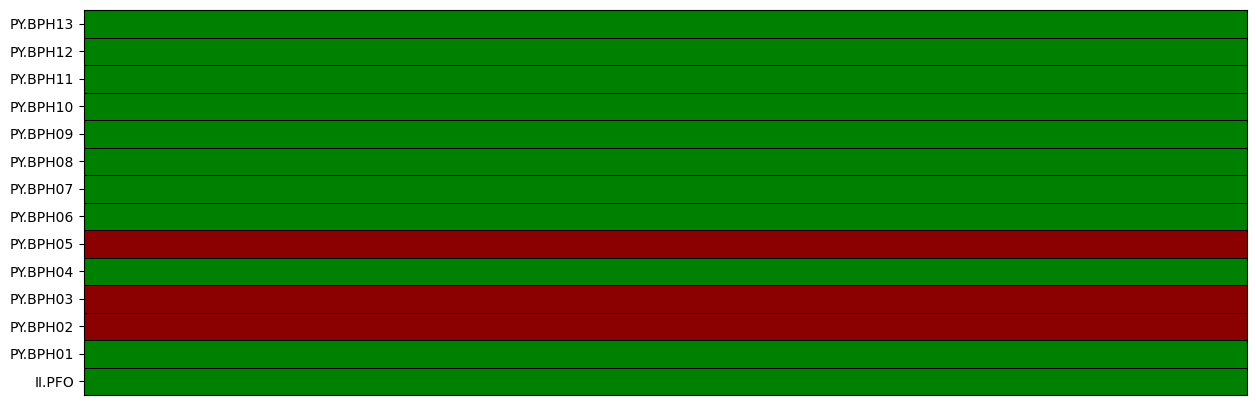


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-17T05:25:13.819539Z - 2022-10-17T05:26:13.819539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-17T05:25:13.819539Z - 2022-10-17T05:26:13.819539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-17T05:25:13.819539Z - 2022-10-17T05:26:13.819539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-17T05:25:13.819539Z - 2022-10-17T05:26:13.819539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-17T05:25:13.819539Z - 2022-10-17T05:26:13.819539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-17T05:25:13.819539Z - 2022-10-17T05:26:13.819539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-17T05:25:13.819539Z - 2022-10-17T05:26:13.819539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-17T05:25:13.819539Z - 2022-10-17T05:26:13.819539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-17T05:25:13.819539Z - 2022-10-17T05:26:13.819539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-17T05:25:13.819539Z - 2022-10-17T05:26:13.819539Z |


 -> 16 2022-10-19 08:38:25.820000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-19T08:38:10.818700Z - 2022-10-19T08:39:10.793700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-19T08:38:10.818700Z - 2022-10-19T08:39:10.793700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-19T08:38:10.818700Z - 2022-10-19T08:39:10.793700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


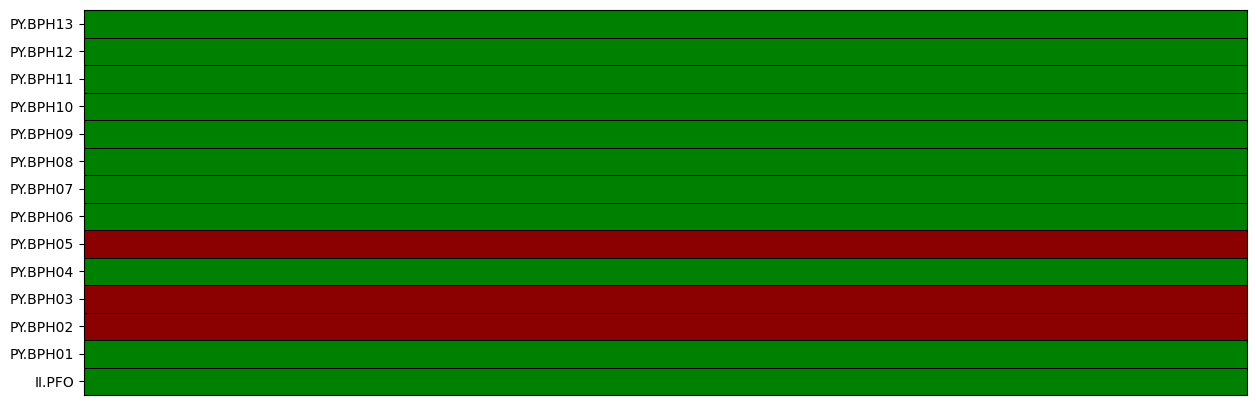


 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-19T08:38:10.819538Z - 2022-10-19T08:39:10.819538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-19T08:38:10.819538Z - 2022-10-19T08:39:10.819538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-19T08:38:10.819538Z - 2022-10-19T08:39:10.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-19T08:38:10.819538Z - 2022-10-19T08:39:10.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-19T08:38:10.819538Z - 2022-10-19T08:39:10.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-19T08:38:10.819538Z - 2022-10-19T08:39:10.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-19T08:38:10.819538Z - 2022-10-19T08:39:10.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-19T08:38:10.819538Z - 2022-10-19T08:39:10.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-19T08:38:10.819538Z - 2022-10-19T08:39:10.819538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-19T08:38:10.819538Z - 2022-10-19T08:39:10.819538Z |


 -> 17 2022-10-21 08:53:10.210000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-21T08:52:55.208700Z - 2022-10-21T08:53:55.183700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-21T08:52:55.208700Z - 2022-10-21T08:53:55.183700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-21T08:52:55.208700Z - 2022-10-21T08:53:55.183700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


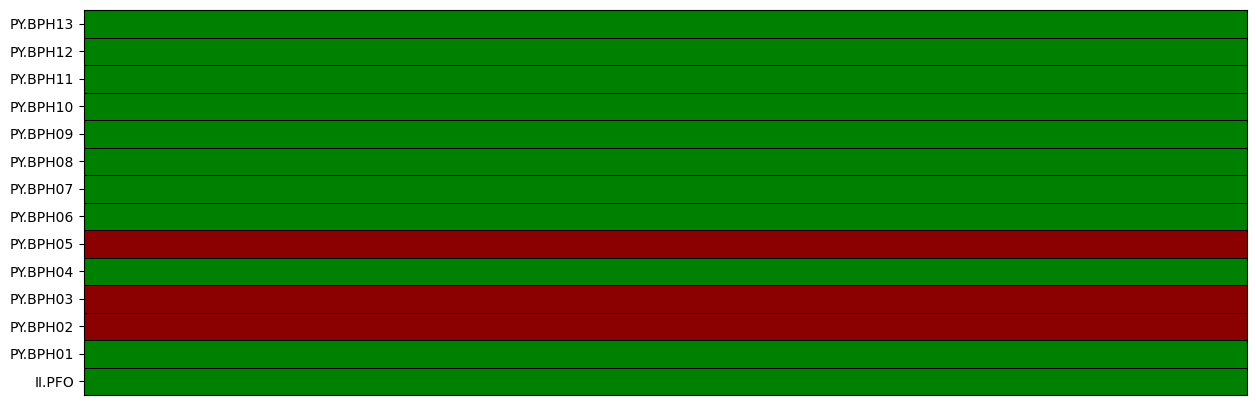


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-21T08:52:55.219538Z - 2022-10-21T08:53:55.219538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-21T08:52:55.219538Z - 2022-10-21T08:53:55.219538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-21T08:52:55.219538Z - 2022-10-21T08:53:55.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-21T08:52:55.219538Z - 2022-10-21T08:53:55.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-21T08:52:55.219538Z - 2022-10-21T08:53:55.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-21T08:52:55.219538Z - 2022-10-21T08:53:55.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-21T08:52:55.219538Z - 2022-10-21T08:53:55.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-21T08:52:55.219538Z - 2022-10-21T08:53:55.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-21T08:52:55.219538Z - 2022-10-21T08:53:55.219538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-21T08:52:55.219538Z - 2022-10-21T08:53:55.219538Z |


 -> 18 2022-10-22 17:23:29.270000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-22T17:23:14.268700Z - 2022-10-22T17:24:14.243700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-22T17:23:14.268700Z - 2022-10-22T17:24:14.243700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-22T17:23:14.268700Z - 2022-10-22T17:24:14.243700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


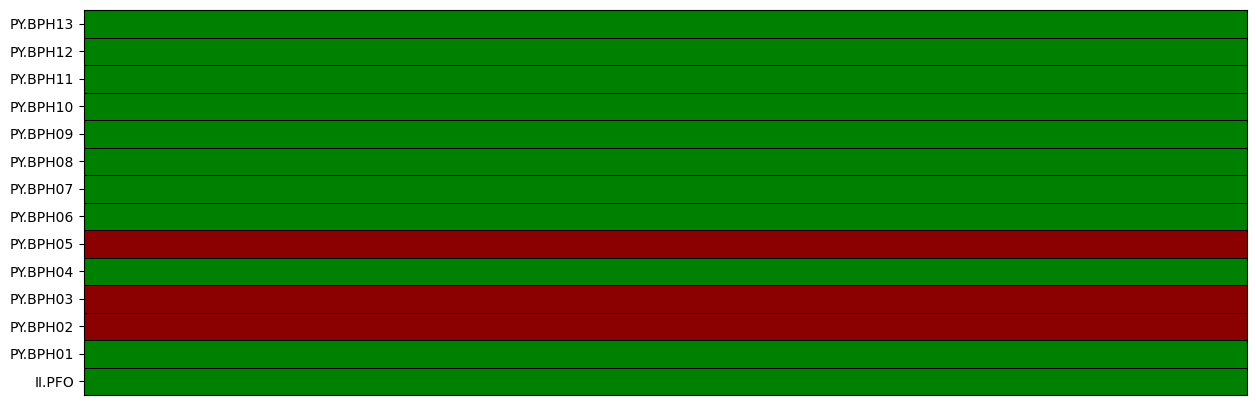


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-22T17:23:14.269538Z - 2022-10-22T17:24:14.269538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-22T17:23:14.269538Z - 2022-10-22T17:24:14.269538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-22T17:23:14.269538Z - 2022-10-22T17:24:14.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-22T17:23:14.269538Z - 2022-10-22T17:24:14.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-22T17:23:14.269538Z - 2022-10-22T17:24:14.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-22T17:23:14.269538Z - 2022-10-22T17:24:14.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-22T17:23:14.269538Z - 2022-10-22T17:24:14.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-22T17:23:14.269538Z - 2022-10-22T17:24:14.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-22T17:23:14.269538Z - 2022-10-22T17:24:14.269538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-22T17:23:14.269538Z - 2022-10-22T17:24:14.269538Z |


 -> 19 2022-10-23 09:24:58.150000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-23T09:24:43.148700Z - 2022-10-23T09:25:43.123700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-23T09:24:43.148700Z - 2022-10-23T09:25:43.123700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-23T09:24:43.148700Z - 2022-10-23T09:25:43.123700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


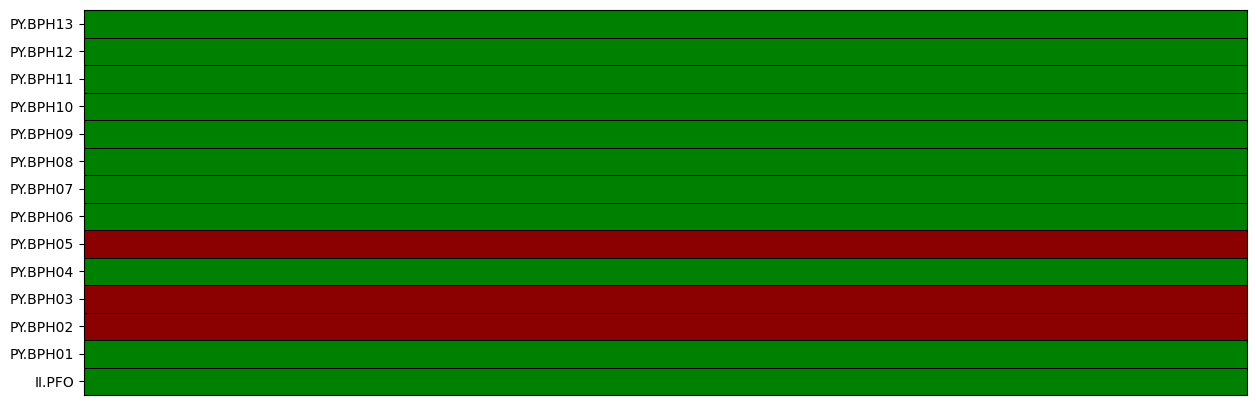


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.38 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-23T09:24:43.144538Z - 2022-10-23T09:25:43.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-23T09:24:43.144538Z - 2022-10-23T09:25:43.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-23T09:24:43.144538Z - 2022-10-23T09:25:43.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-23T09:24:43.144538Z - 2022-10-23T09:25:43.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-23T09:24:43.144538Z - 2022-10-23T09:25:43.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-23T09:24:43.144538Z - 2022-10-23T09:25:43.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-23T09:24:43.144538Z - 2022-10-23T09:25:43.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-23T09:24:43.144538Z - 2022-10-23T09:25:43.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-23T09:24:43.144538Z - 2022-10-23T09:25:43.144538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-23T09:24:43.144538Z - 2022-10-23T09:25:43.144538Z |


 -> 20 2022-10-24 12:13:57.370000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-24T12:13:42.368700Z - 2022-10-24T12:14:42.343700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-24T12:13:42.368700Z - 2022-10-24T12:14:42.343700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-24T12:13:42.368700Z - 2022-10-24T12:14:42.343700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


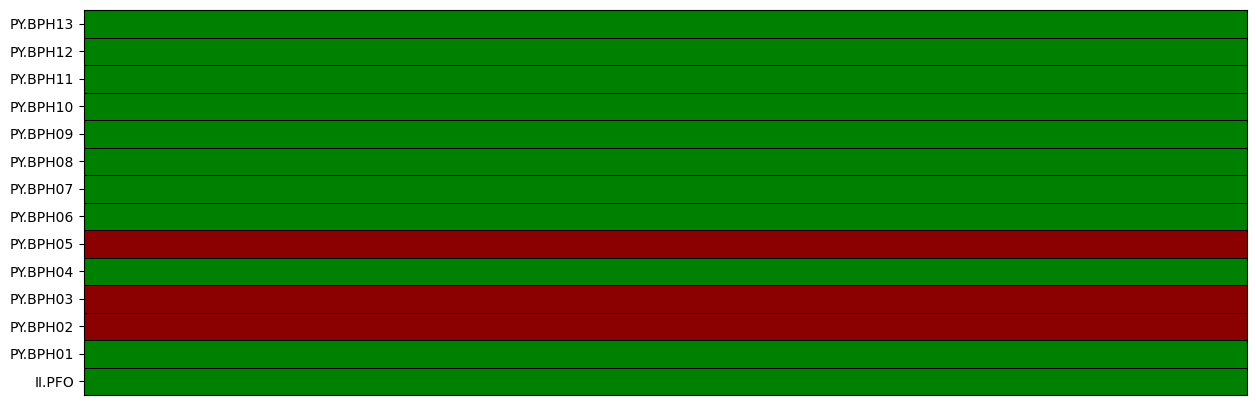


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.22 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-24T12:13:42.369538Z - 2022-10-24T12:14:42.369538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-24T12:13:42.369538Z - 2022-10-24T12:14:42.369538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-24T12:13:42.369538Z - 2022-10-24T12:14:42.369538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-24T12:13:42.369538Z - 2022-10-24T12:14:42.369538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-24T12:13:42.369538Z - 2022-10-24T12:14:42.369538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-24T12:13:42.369538Z - 2022-10-24T12:14:42.369538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-24T12:13:42.369538Z - 2022-10-24T12:14:42.369538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-24T12:13:42.369538Z - 2022-10-24T12:14:42.369538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-24T12:13:42.369538Z - 2022-10-24T12:14:42.369538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-24T12:13:42.369538Z - 2022-10-24T12:14:42.369538Z |


 -> 21 2022-10-24 15:39:11.390000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-24T15:38:56.388700Z - 2022-10-24T15:39:56.363700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-24T15:38:56.388700Z - 2022-10-24T15:39:56.363700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-24T15:38:56.388700Z - 2022-10-24T15:39:56.363700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


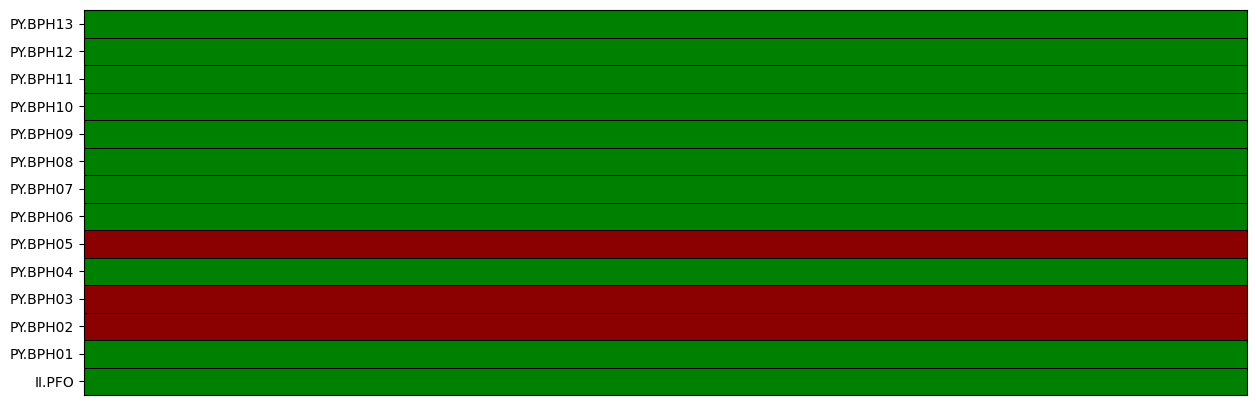


 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-24T15:38:56.394538Z - 2022-10-24T15:39:56.394538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-24T15:38:56.394538Z - 2022-10-24T15:39:56.394538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-24T15:38:56.394538Z - 2022-10-24T15:39:56.394538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-24T15:38:56.394538Z - 2022-10-24T15:39:56.394538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-24T15:38:56.394538Z - 2022-10-24T15:39:56.394538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-24T15:38:56.394538Z - 2022-10-24T15:39:56.394538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-24T15:38:56.394538Z - 2022-10-24T15:39:56.394538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-24T15:38:56.394538Z - 2022-10-24T15:39:56.394538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-24T15:38:56.394538Z - 2022-10-24T15:39:56.394538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-24T15:38:56.394538Z - 2022-10-24T15:39:56.394538Z |


 -> 22 2022-10-25 03:55:30.970000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-25T03:55:15.968700Z - 2022-10-25T03:56:15.943700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-25T03:55:15.968700Z - 2022-10-25T03:56:15.943700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-25T03:55:15.968700Z - 2022-10-25T03:56:15.943700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


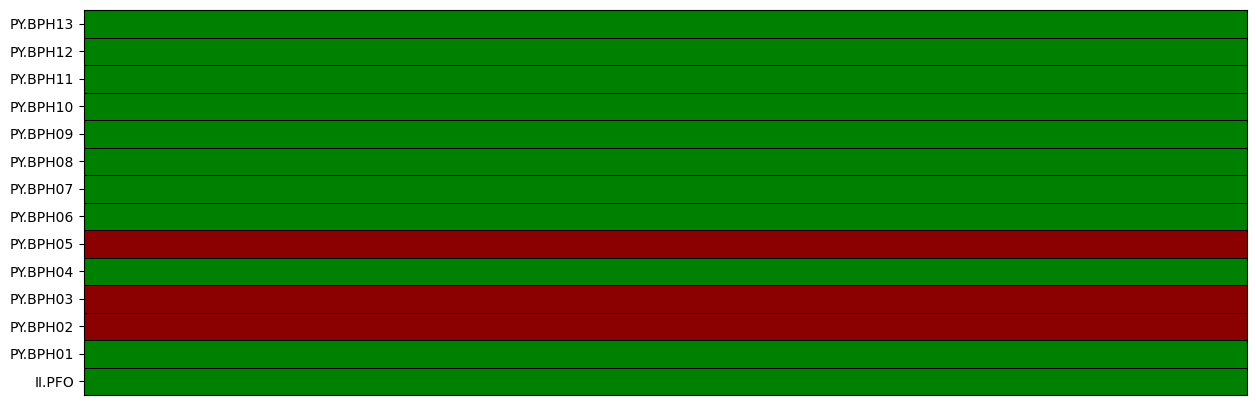


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-25T03:55:15.969538Z - 2022-10-25T03:56:15.969538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-25T03:55:15.969538Z - 2022-10-25T03:56:15.969538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-25T03:55:15.969538Z - 2022-10-25T03:56:15.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-25T03:55:15.969538Z - 2022-10-25T03:56:15.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-25T03:55:15.969538Z - 2022-10-25T03:56:15.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-25T03:55:15.969538Z - 2022-10-25T03:56:15.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-25T03:55:15.969538Z - 2022-10-25T03:56:15.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-25T03:55:15.969538Z - 2022-10-25T03:56:15.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-25T03:55:15.969538Z - 2022-10-25T03:56:15.969538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-25T03:55:15.969538Z - 2022-10-25T03:56:15.969538Z |


 -> 23 2022-10-25 12:29:41.420000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-25T12:29:26.418700Z - 2022-10-25T12:30:26.393700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-25T12:29:26.418700Z - 2022-10-25T12:30:26.393700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-25T12:29:26.418700Z - 2022-10-25T12:30:26.393700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


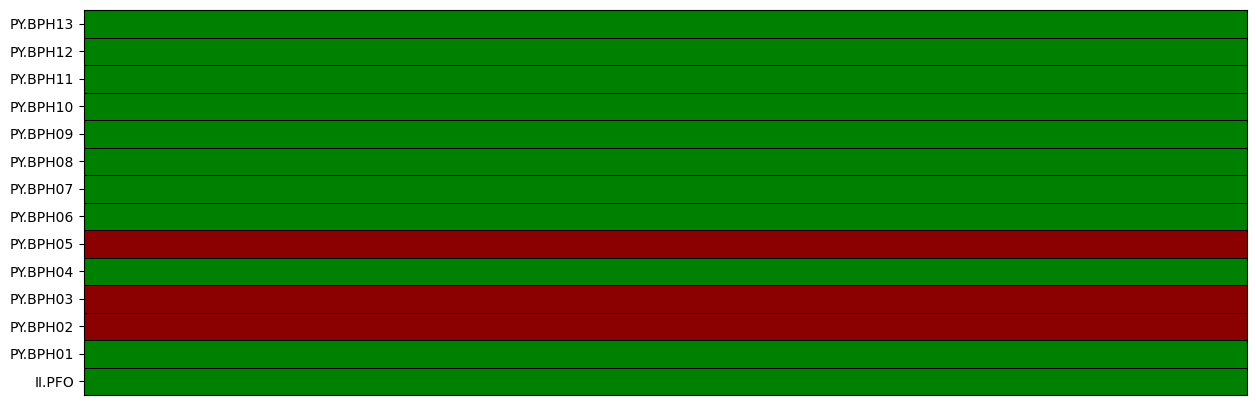


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-25T12:29:26.419538Z - 2022-10-25T12:30:26.419538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-25T12:29:26.419538Z - 2022-10-25T12:30:26.419538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-25T12:29:26.419538Z - 2022-10-25T12:30:26.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-25T12:29:26.419538Z - 2022-10-25T12:30:26.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-25T12:29:26.419538Z - 2022-10-25T12:30:26.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-25T12:29:26.419538Z - 2022-10-25T12:30:26.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-25T12:29:26.419538Z - 2022-10-25T12:30:26.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-25T12:29:26.419538Z - 2022-10-25T12:30:26.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-25T12:29:26.419538Z - 2022-10-25T12:30:26.419538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-25T12:29:26.419538Z - 2022-10-25T12:30:26.419538Z |


 -> 24 2022-10-26 02:14:58.130000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T02:14:43.128700Z - 2022-10-26T02:15:43.103700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-26T02:14:43.128700Z - 2022-10-26T02:15:43.103700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-26T02:14:43.128700Z - 2022-10-26T02:15:43.103700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


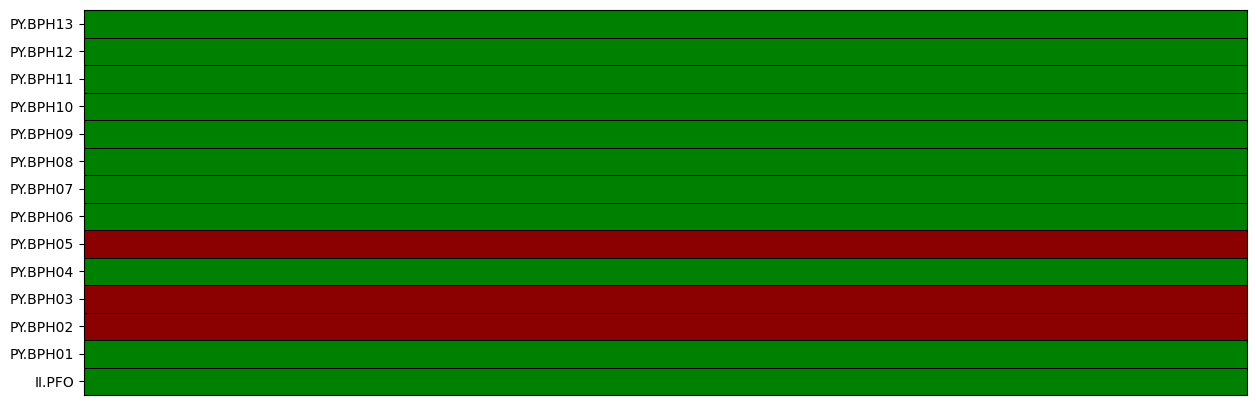


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-26T02:14:43.119538Z - 2022-10-26T02:15:43.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-26T02:14:43.119538Z - 2022-10-26T02:15:43.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-26T02:14:43.119538Z - 2022-10-26T02:15:43.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-26T02:14:43.119538Z - 2022-10-26T02:15:43.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-26T02:14:43.119538Z - 2022-10-26T02:15:43.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-26T02:14:43.119538Z - 2022-10-26T02:15:43.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-26T02:14:43.119538Z - 2022-10-26T02:15:43.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-26T02:14:43.119538Z - 2022-10-26T02:15:43.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-26T02:14:43.119538Z - 2022-10-26T02:15:43.119538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-26T02:14:43.119538Z - 2022-10-26T02:15:43.119538Z |


 -> 25 2022-10-26 08:14:33.950000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T08:14:18.950500Z - 2022-10-26T08:15:18.925500Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-26T08:14:18.950500Z - 2022-10-26T08:15:18.925500Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-26T08:14:18.950500Z - 2022-10-26T08:15:18.925500Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


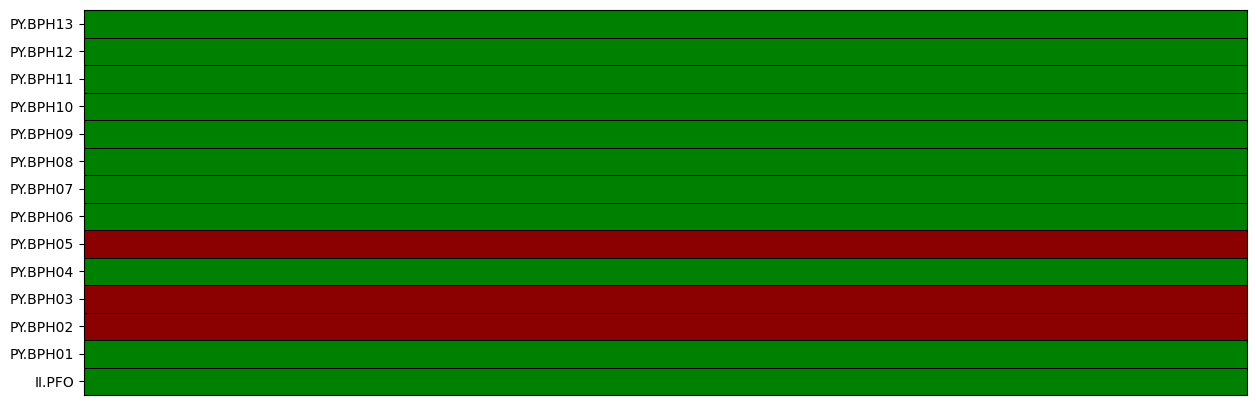


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.38 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-26T08:14:18.944538Z - 2022-10-26T08:15:18.944538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-26T08:14:18.944538Z - 2022-10-26T08:15:18.944538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-26T08:14:18.944538Z - 2022-10-26T08:15:18.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-26T08:14:18.944538Z - 2022-10-26T08:15:18.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-26T08:14:18.944538Z - 2022-10-26T08:15:18.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-26T08:14:18.944538Z - 2022-10-26T08:15:18.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-26T08:14:18.944538Z - 2022-10-26T08:15:18.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-26T08:14:18.944538Z - 2022-10-26T08:15:18.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-26T08:14:18.944538Z - 2022-10-26T08:15:18.944538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-26T08:14:18.944538Z - 2022-10-26T08:15:18.944538Z |


 -> 26 2022-10-26 08:15:08.220000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T08:14:53.220600Z - 2022-10-26T08:15:53.195600Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-26T08:14:53.220600Z - 2022-10-26T08:15:53.195600Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-26T08:14:53.220600Z - 2022-10-26T08:15:53.195600Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


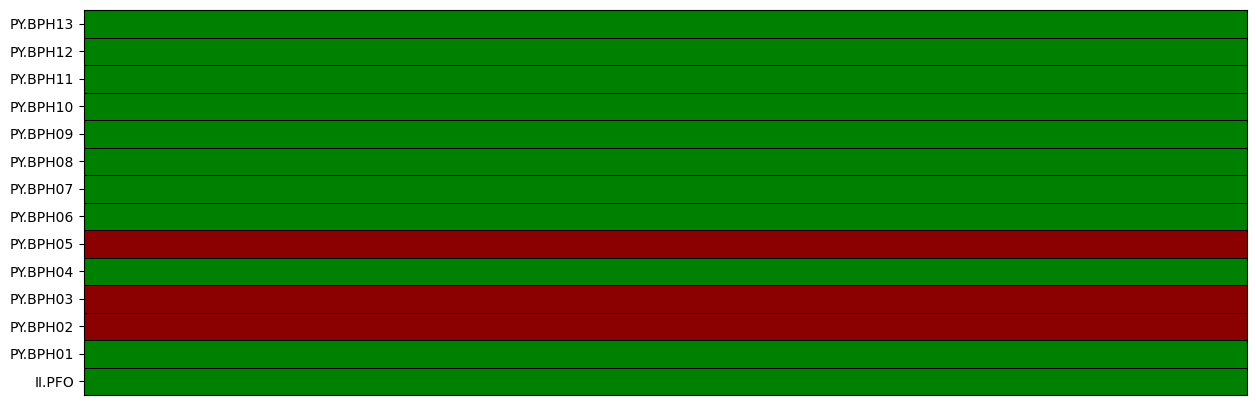


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-26T08:14:53.219538Z - 2022-10-26T08:15:53.219538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-26T08:14:53.219538Z - 2022-10-26T08:15:53.219538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-26T08:14:53.219538Z - 2022-10-26T08:15:53.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-26T08:14:53.219538Z - 2022-10-26T08:15:53.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-26T08:14:53.219538Z - 2022-10-26T08:15:53.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-26T08:14:53.219538Z - 2022-10-26T08:15:53.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-26T08:14:53.219538Z - 2022-10-26T08:15:53.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-26T08:14:53.219538Z - 2022-10-26T08:15:53.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-26T08:14:53.219538Z - 2022-10-26T08:15:53.219538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-26T08:14:53.219538Z - 2022-10-26T08:15:53.219538Z |


 -> 27 2022-10-26 08:26:54.280000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T08:26:39.277900Z - 2022-10-26T08:27:39.252900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-26T08:26:39.277900Z - 2022-10-26T08:27:39.252900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-26T08:26:39.277900Z - 2022-10-26T08:27:39.252900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


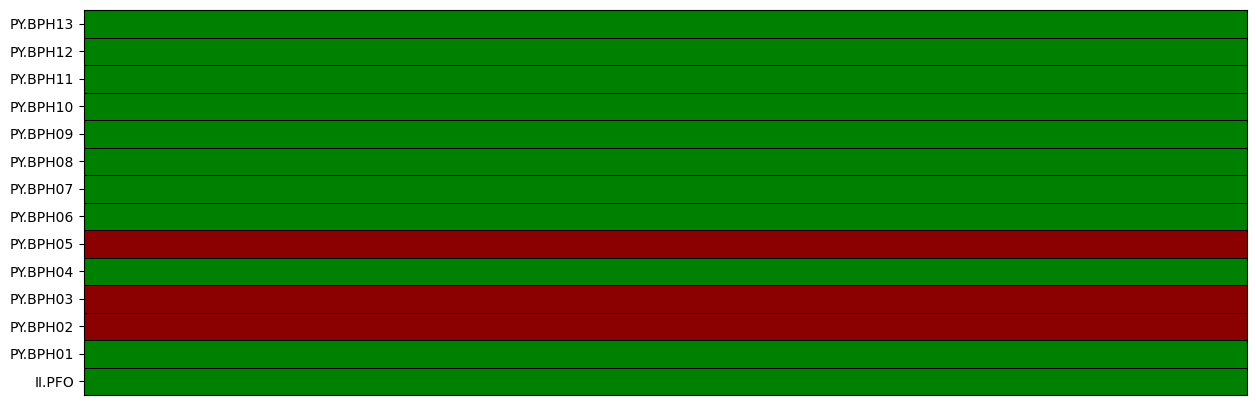


 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-26T08:26:39.269538Z - 2022-10-26T08:27:39.269538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-26T08:26:39.269538Z - 2022-10-26T08:27:39.269538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-26T08:26:39.269538Z - 2022-10-26T08:27:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-26T08:26:39.269538Z - 2022-10-26T08:27:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-26T08:26:39.269538Z - 2022-10-26T08:27:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-26T08:26:39.269538Z - 2022-10-26T08:27:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-26T08:26:39.269538Z - 2022-10-26T08:27:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-26T08:26:39.269538Z - 2022-10-26T08:27:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-26T08:26:39.269538Z - 2022-10-26T08:27:39.269538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-26T08:26:39.269538Z - 2022-10-26T08:27:39.269538Z |


 -> 28 2022-10-26 10:37:58.930000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T10:37:43.927900Z - 2022-10-26T10:38:43.902900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-26T10:37:43.927900Z - 2022-10-26T10:38:43.902900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-26T10:37:43.927900Z - 2022-10-26T10:38:43.902900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


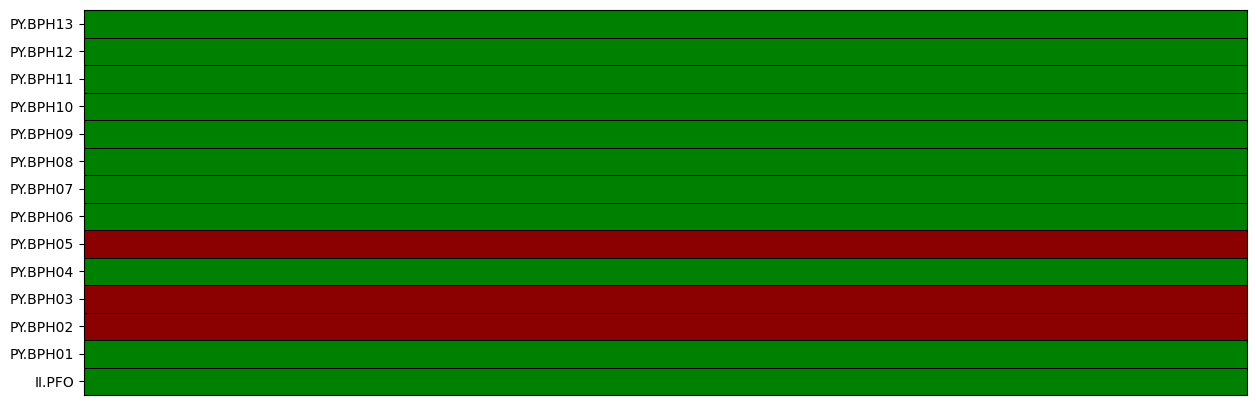


 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-26T10:37:43.919538Z - 2022-10-26T10:38:43.919538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-26T10:37:43.919538Z - 2022-10-26T10:38:43.919538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-26T10:37:43.919538Z - 2022-10-26T10:38:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-26T10:37:43.919538Z - 2022-10-26T10:38:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-26T10:37:43.919538Z - 2022-10-26T10:38:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-26T10:37:43.919538Z - 2022-10-26T10:38:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-26T10:37:43.919538Z - 2022-10-26T10:38:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-26T10:37:43.919538Z - 2022-10-26T10:38:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-26T10:37:43.919538Z - 2022-10-26T10:38:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-26T10:37:43.919538Z - 2022-10-26T10:38:43.919538Z |


 -> 29 2022-10-26 10:40:24.830000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-26T10:40:09.827900Z - 2022-10-26T10:41:09.802900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-26T10:40:09.827900Z - 2022-10-26T10:41:09.802900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-26T10:40:09.827900Z - 2022-10-26T10:41:09.802900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


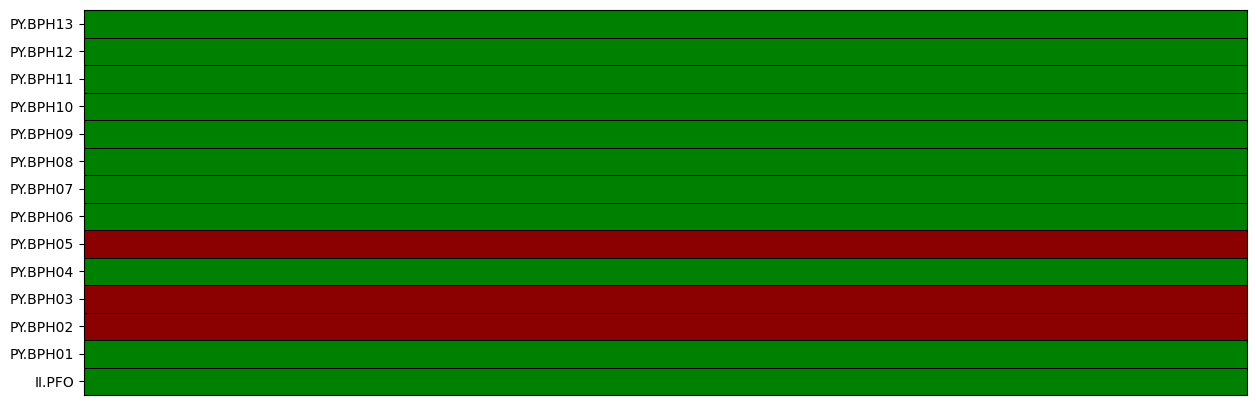


 -> Runtime: 0.6 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.23 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-26T10:40:09.819538Z - 2022-10-26T10:41:09.819538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-26T10:40:09.819538Z - 2022-10-26T10:41:09.819538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-26T10:40:09.819538Z - 2022-10-26T10:41:09.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-26T10:40:09.819538Z - 2022-10-26T10:41:09.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-26T10:40:09.819538Z - 2022-10-26T10:41:09.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-26T10:40:09.819538Z - 2022-10-26T10:41:09.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-26T10:40:09.819538Z - 2022-10-26T10:41:09.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-26T10:40:09.819538Z - 2022-10-26T10:41:09.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-26T10:40:09.819538Z - 2022-10-26T10:41:09.819538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-26T10:40:09.819538Z - 2022-10-26T10:41:09.819538Z |


 -> 30 2022-10-28 15:14:38.240000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-28T15:14:23.241300Z - 2022-10-28T15:15:23.216300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-28T15:14:23.241300Z - 2022-10-28T15:15:23.216300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-28T15:14:23.241300Z - 2022-10-28T15:15:23.216300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


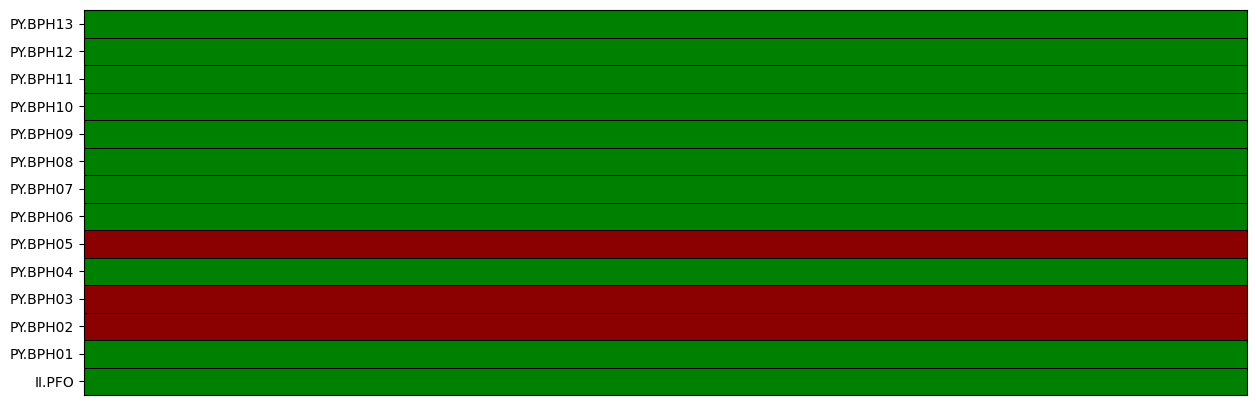


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-28T15:14:23.244538Z - 2022-10-28T15:15:23.244538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-28T15:14:23.244538Z - 2022-10-28T15:15:23.244538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-28T15:14:23.244538Z - 2022-10-28T15:15:23.244538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-28T15:14:23.244538Z - 2022-10-28T15:15:23.244538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-28T15:14:23.244538Z - 2022-10-28T15:15:23.244538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-28T15:14:23.244538Z - 2022-10-28T15:15:23.244538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-28T15:14:23.244538Z - 2022-10-28T15:15:23.244538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-28T15:14:23.244538Z - 2022-10-28T15:15:23.244538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-28T15:14:23.244538Z - 2022-10-28T15:15:23.244538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-28T15:14:23.244538Z - 2022-10-28T15:15:23.244538Z |


 -> 31 2022-10-30 13:17:52.290000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-30T13:17:37.291300Z - 2022-10-30T13:18:37.266300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-30T13:17:37.291300Z - 2022-10-30T13:18:37.266300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-30T13:17:37.291300Z - 2022-10-30T13:18:37.266300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


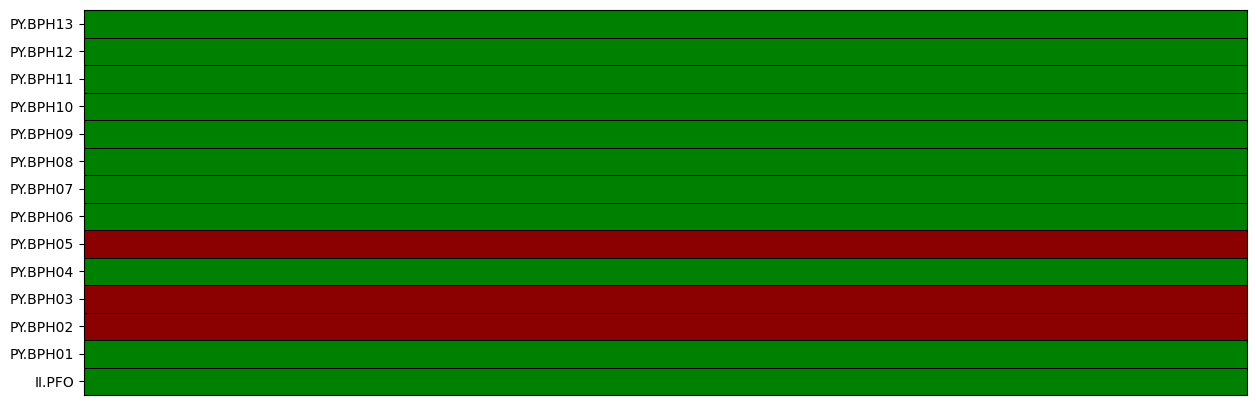


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-30T13:17:37.294538Z - 2022-10-30T13:18:37.294538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-30T13:17:37.294538Z - 2022-10-30T13:18:37.294538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-30T13:17:37.294538Z - 2022-10-30T13:18:37.294538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-30T13:17:37.294538Z - 2022-10-30T13:18:37.294538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-30T13:17:37.294538Z - 2022-10-30T13:18:37.294538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-30T13:17:37.294538Z - 2022-10-30T13:18:37.294538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-30T13:17:37.294538Z - 2022-10-30T13:18:37.294538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-30T13:17:37.294538Z - 2022-10-30T13:18:37.294538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-30T13:17:37.294538Z - 2022-10-30T13:18:37.294538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-30T13:17:37.294538Z - 2022-10-30T13:18:37.294538Z |


 -> 32 2022-10-30 17:55:51.880000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-10-30T17:55:36.881300Z - 2022-10-30T17:56:36.856300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-10-30T17:55:36.881300Z - 2022-10-30T17:56:36.856300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-10-30T17:55:36.881300Z - 2022-10-30T17:56:36.856300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


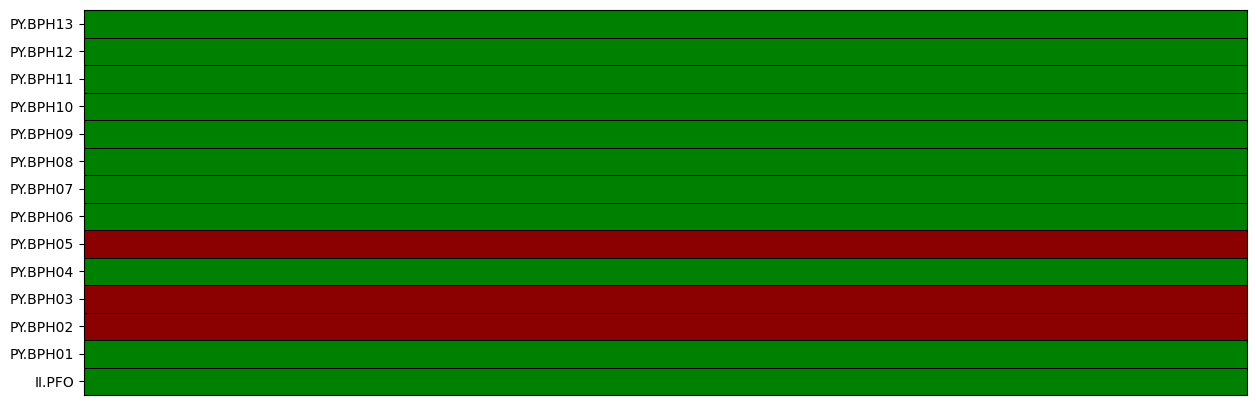


 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.38 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.22 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-10-30T17:55:36.869538Z - 2022-10-30T17:56:36.869538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-10-30T17:55:36.869538Z - 2022-10-30T17:56:36.869538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-10-30T17:55:36.869538Z - 2022-10-30T17:56:36.869538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-10-30T17:55:36.869538Z - 2022-10-30T17:56:36.869538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-10-30T17:55:36.869538Z - 2022-10-30T17:56:36.869538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-10-30T17:55:36.869538Z - 2022-10-30T17:56:36.869538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-10-30T17:55:36.869538Z - 2022-10-30T17:56:36.869538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-10-30T17:55:36.869538Z - 2022-10-30T17:56:36.869538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-10-30T17:55:36.869538Z - 2022-10-30T17:56:36.869538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-10-30T17:55:36.869538Z - 2022-10-30T17:56:36.869538Z |


 -> 33 2022-11-02 09:51:22.090000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-02T09:51:07.091400Z - 2022-11-02T09:52:07.066400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-02T09:51:07.091400Z - 2022-11-02T09:52:07.066400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-02T09:51:07.091300Z - 2022-11-02T09:52:07.066300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


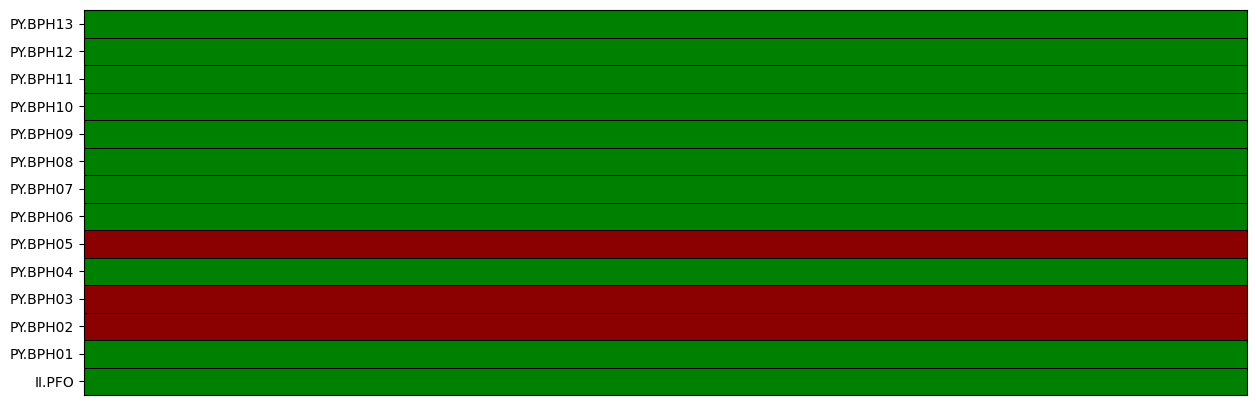


 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-02T09:51:07.094538Z - 2022-11-02T09:52:07.094538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-02T09:51:07.094538Z - 2022-11-02T09:52:07.094538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-02T09:51:07.094538Z - 2022-11-02T09:52:07.094538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-02T09:51:07.094538Z - 2022-11-02T09:52:07.094538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-02T09:51:07.094538Z - 2022-11-02T09:52:07.094538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-02T09:51:07.094538Z - 2022-11-02T09:52:07.094538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-02T09:51:07.094538Z - 2022-11-02T09:52:07.094538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-02T09:51:07.094538Z - 2022-11-02T09:52:07.094538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-02T09:51:07.094538Z - 2022-11-02T09:52:07.094538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-02T09:51:07.094538Z - 2022-11-02T09:52:07.094538Z |


 -> 34 2022-11-08 19:21:29.560000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-08T19:21:14.561300Z - 2022-11-08T19:22:14.536300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-08T19:21:14.561300Z - 2022-11-08T19:22:14.536300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-08T19:21:14.561300Z - 2022-11-08T19:22:14.536300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


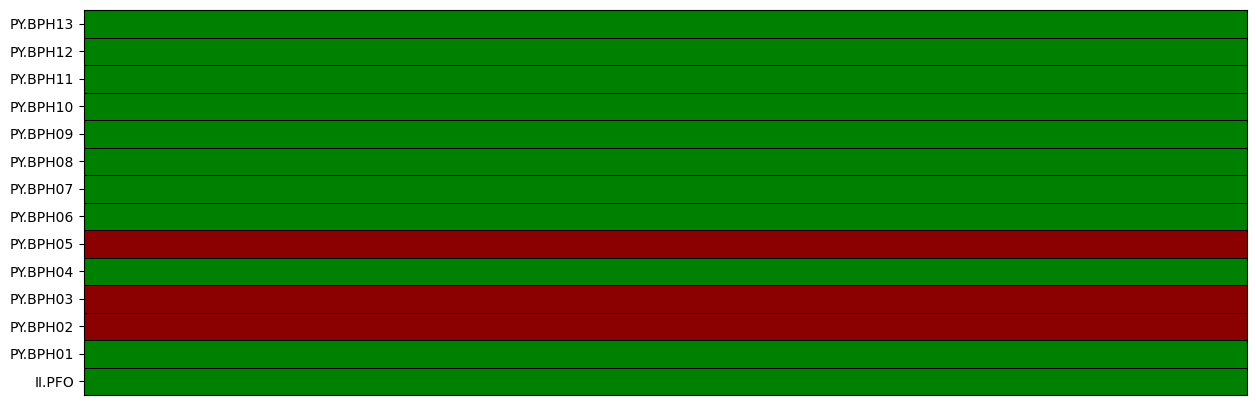


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-08T19:21:14.569538Z - 2022-11-08T19:22:14.569538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-08T19:21:14.569538Z - 2022-11-08T19:22:14.569538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-08T19:21:14.569538Z - 2022-11-08T19:22:14.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-08T19:21:14.569538Z - 2022-11-08T19:22:14.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-08T19:21:14.569538Z - 2022-11-08T19:22:14.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-08T19:21:14.569538Z - 2022-11-08T19:22:14.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-08T19:21:14.569538Z - 2022-11-08T19:22:14.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-08T19:21:14.569538Z - 2022-11-08T19:22:14.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-08T19:21:14.569538Z - 2022-11-08T19:22:14.569538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-08T19:21:14.569538Z - 2022-11-08T19:22:14.569538Z |


 -> 35 2022-11-09 20:38:02.400000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-09T20:37:47.401300Z - 2022-11-09T20:38:47.376300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-09T20:37:47.401300Z - 2022-11-09T20:38:47.376300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-09T20:37:47.401300Z - 2022-11-09T20:38:47.376300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


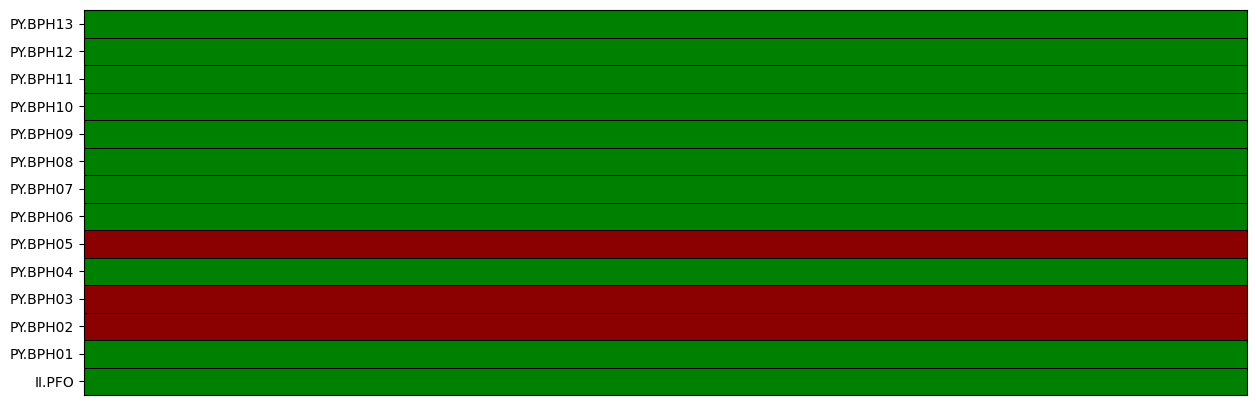


 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.22 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-09T20:37:47.394538Z - 2022-11-09T20:38:47.394538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-09T20:37:47.394538Z - 2022-11-09T20:38:47.394538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-09T20:37:47.394538Z - 2022-11-09T20:38:47.394538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-09T20:37:47.394538Z - 2022-11-09T20:38:47.394538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-09T20:37:47.394538Z - 2022-11-09T20:38:47.394538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-09T20:37:47.394538Z - 2022-11-09T20:38:47.394538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-09T20:37:47.394538Z - 2022-11-09T20:38:47.394538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-09T20:37:47.394538Z - 2022-11-09T20:38:47.394538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-09T20:37:47.394538Z - 2022-11-09T20:38:47.394538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-09T20:37:47.394538Z - 2022-11-09T20:38:47.394538Z |


 -> 36 2022-11-10 07:51:01.120000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-10T07:50:46.121300Z - 2022-11-10T07:51:46.096300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-10T07:50:46.121300Z - 2022-11-10T07:51:46.096300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-10T07:50:46.121300Z - 2022-11-10T07:51:46.096300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


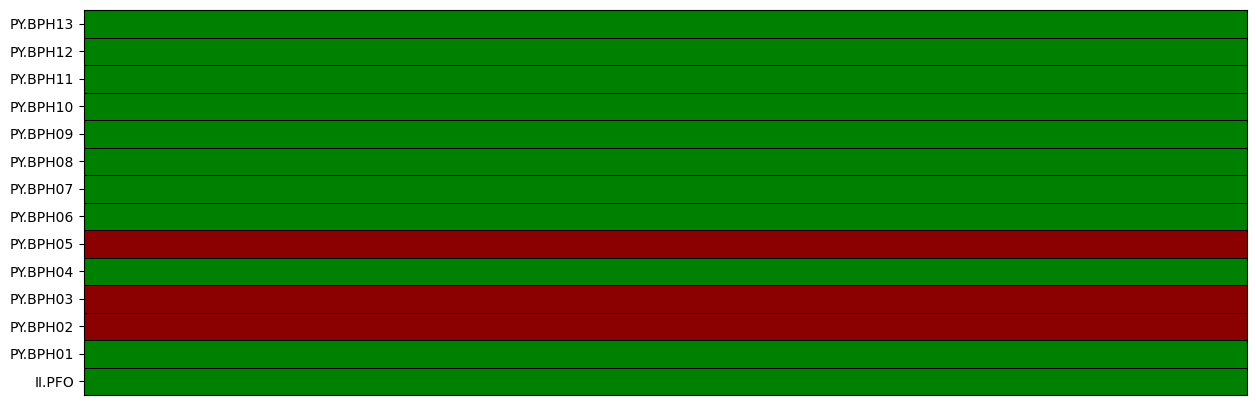


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-10T07:50:46.119538Z - 2022-11-10T07:51:46.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-10T07:50:46.119538Z - 2022-11-10T07:51:46.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-10T07:50:46.119538Z - 2022-11-10T07:51:46.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-10T07:50:46.119538Z - 2022-11-10T07:51:46.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-10T07:50:46.119538Z - 2022-11-10T07:51:46.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-10T07:50:46.119538Z - 2022-11-10T07:51:46.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-10T07:50:46.119538Z - 2022-11-10T07:51:46.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-10T07:50:46.119538Z - 2022-11-10T07:51:46.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-10T07:50:46.119538Z - 2022-11-10T07:51:46.119538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-10T07:50:46.119538Z - 2022-11-10T07:51:46.119538Z |


 -> 37 2022-11-15 16:02:41.970000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-15T16:02:26.971500Z - 2022-11-15T16:03:26.946500Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-15T16:02:26.971500Z - 2022-11-15T16:03:26.946500Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-15T16:02:26.971500Z - 2022-11-15T16:03:26.946500Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


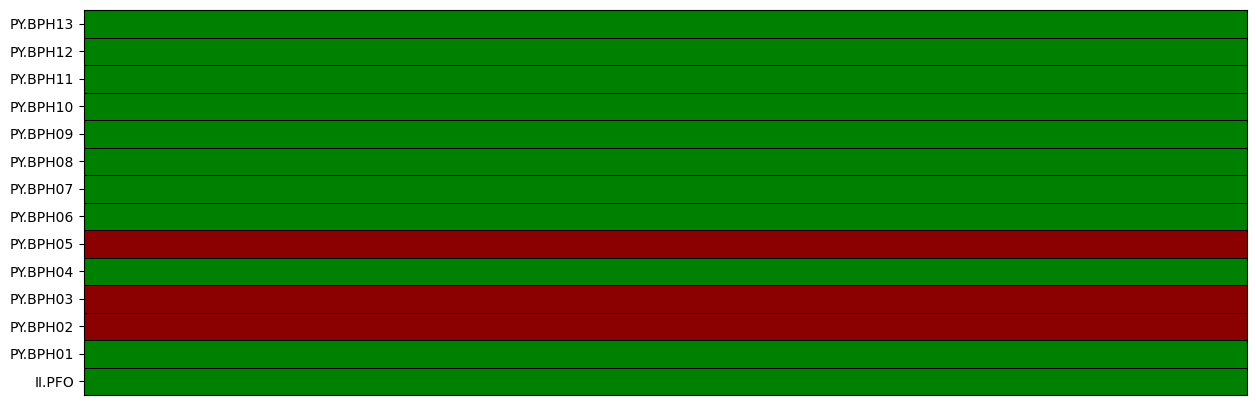


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.35 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-15T16:02:26.969538Z - 2022-11-15T16:03:26.969538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-15T16:02:26.969538Z - 2022-11-15T16:03:26.969538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-15T16:02:26.969538Z - 2022-11-15T16:03:26.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-15T16:02:26.969538Z - 2022-11-15T16:03:26.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-15T16:02:26.969538Z - 2022-11-15T16:03:26.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-15T16:02:26.969538Z - 2022-11-15T16:03:26.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-15T16:02:26.969538Z - 2022-11-15T16:03:26.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-15T16:02:26.969538Z - 2022-11-15T16:03:26.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-15T16:02:26.969538Z - 2022-11-15T16:03:26.969538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-15T16:02:26.969538Z - 2022-11-15T16:03:26.969538Z |


 -> 38 2022-11-16 01:58:10.850000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-16T01:57:55.851500Z - 2022-11-16T01:58:55.826500Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-16T01:57:55.851500Z - 2022-11-16T01:58:55.826500Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-16T01:57:55.851500Z - 2022-11-16T01:58:55.826500Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH08 Failed to load inventory!
 -> BPH08 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 9 of 14 stations ...


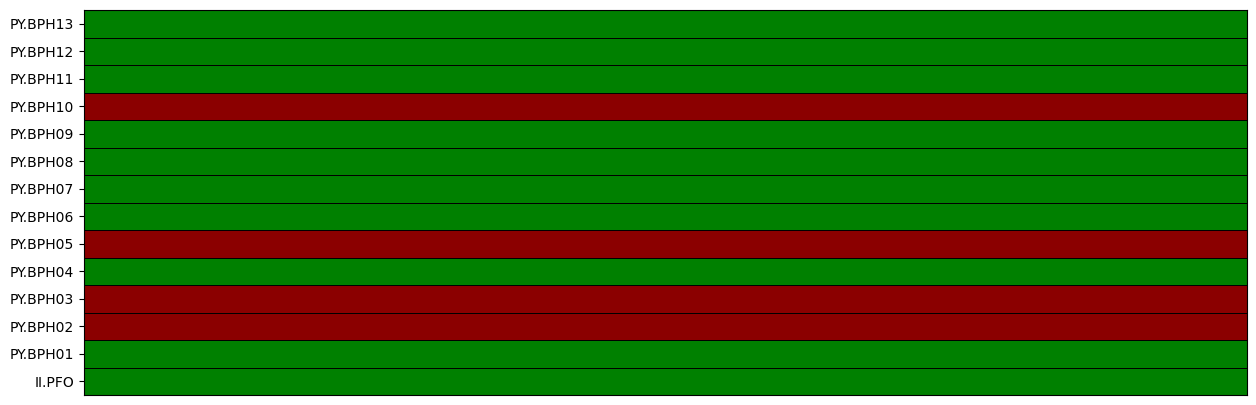


 -> Runtime: 0.59 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.22 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-16T01:57:55.844538Z - 2022-11-16T01:58:55.844538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-16T01:57:55.844538Z - 2022-11-16T01:58:55.844538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-16T01:57:55.844538Z - 2022-11-16T01:58:55.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-16T01:57:55.844538Z - 2022-11-16T01:58:55.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-16T01:57:55.844538Z - 2022-11-16T01:58:55.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-16T01:57:55.844538Z - 2022-11-16T01:58:55.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-16T01:57:55.844538Z - 2022-11-16T01:58:55.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-16T01:57:55.844538Z - 2022-11-16T01:58:55.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-16T01:57:55.844538Z - 2022-11-16T01:58:55.844538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-16T01:57:55.844538Z - 2022-11-16T01:58:55.844538Z |


 -> 39 2022-11-19 05:08:06.550000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-19T05:07:51.551000Z - 2022-11-19T05:08:51.526000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-19T05:07:51.551000Z - 2022-11-19T05:08:51.526000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-19T05:07:51.551000Z - 2022-11-19T05:08:51.526000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


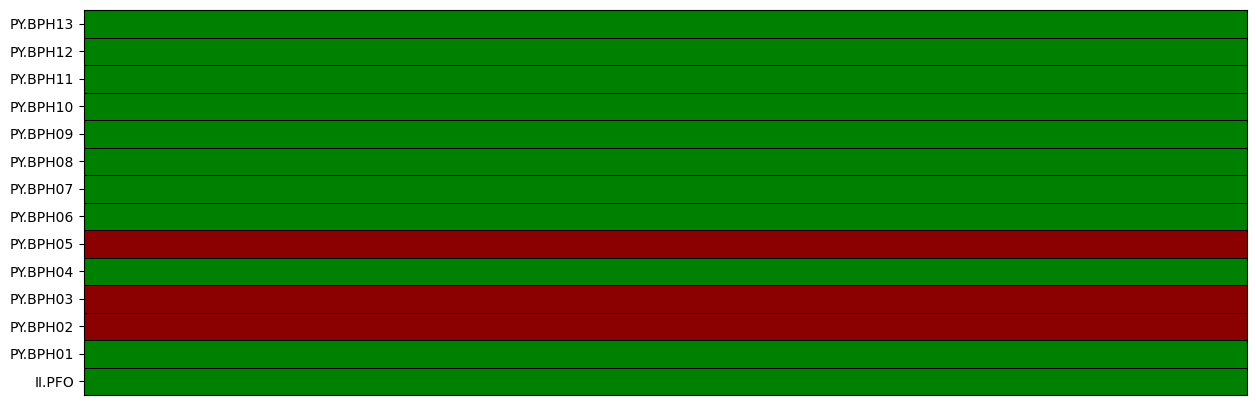


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for II.PFO.10.BH* ...
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> failed to compute ADR inner ...


12 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-19T05:07:51.544538Z - 2022-11-19T05:08:51.544538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-19T05:07:51.544538Z - 2022-11-19T05:08:51.544538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-19T05:07:51.544538Z - 2022-11-19T05:08:51.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-19T05:07:51.544538Z - 2022-11-19T05:08:51.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-19T05:07:51.544538Z - 2022-11-19T05:08:51.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-19T05:07:51.544538Z - 2022-11-19T05:08:51.544538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-19T05:07:51.544538Z - 2022-11-19T05:08:51.544538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJN | 2022-11-19T05:07:51.544538Z - 2022-11-19T05:08:51.544538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJZ | 2022-11-19T05:07:51.544538Z - 2022-11-19T05:08:51.544538Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2022-11-19T05:07:51.551000Z - 2022-11-19T05:08:51.526000Z |


 -> 40 2022-11-19 09:53:11.550000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-19T09:52:56.551000Z - 2022-11-19T09:53:56.526000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-19T09:52:56.551000Z - 2022-11-19T09:53:56.526000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-19T09:52:56.551000Z - 2022-11-19T09:53:56.526000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


12 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-19T09:52:56.544536Z - 2022-11-19T09:53:56.544536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-19T09:52:56.544536Z - 2022-11-19T09:53:56.544536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-19T09:52:56.544536Z - 2022-11-19T09:53:56.544536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-19T09:52:56.544536Z - 2022-11-19T09:53:56.544536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-19T09:52:56.544536Z - 2022-11-19T09:53:56.544536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-19T09:52:56.544536Z - 2022-11-19T09:53:56.544536Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-19T09:52:56.544536Z - 2022-11-19T09:53:56.544536Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJN | 2022-11-19T09:52:56.544536Z - 2022-11-19T09:53:56.544536Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJZ | 2022-11-19T09:52:56.544536Z - 2022-11-19T09:53:56.544536Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2022-11-19T09:52:56.551000Z - 2022-11-19T09:53:56.526000Z |


 -> 41 2022-11-23 15:36:30.450000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-23T15:36:15.451000Z - 2022-11-23T15:37:15.426000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-23T15:36:15.451000Z - 2022-11-23T15:37:15.426000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-23T15:36:15.451000Z - 2022-11-23T15:37:15.426000Z | 40.0 Hz, 2400 samples

 -> BPH02 Failed to load inventory!
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 10 of 14 stations ...


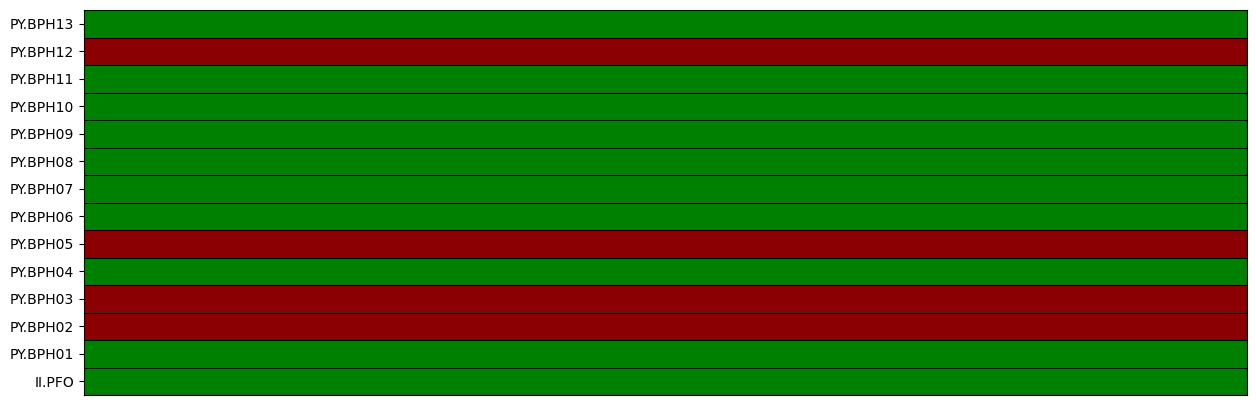


 -> Runtime: 0.6 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.37 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.21 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-23T15:36:15.444538Z - 2022-11-23T15:37:15.444538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-23T15:36:15.444538Z - 2022-11-23T15:37:15.444538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-23T15:36:15.444538Z - 2022-11-23T15:37:15.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-23T15:36:15.444538Z - 2022-11-23T15:37:15.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-23T15:36:15.444538Z - 2022-11-23T15:37:15.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-23T15:36:15.444538Z - 2022-11-23T15:37:15.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-23T15:36:15.444538Z - 2022-11-23T15:37:15.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-23T15:36:15.444538Z - 2022-11-23T15:37:15.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-23T15:36:15.444538Z - 2022-11-23T15:37:15.444538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-23T15:36:15.444538Z - 2022-11-23T15:37:15.444538Z |


 -> 42 2022-11-25 10:50:33.030000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-25T10:50:18.031100Z - 2022-11-25T10:51:18.006100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-25T10:50:18.031100Z - 2022-11-25T10:51:18.006100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-25T10:50:18.031100Z - 2022-11-25T10:51:18.006100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


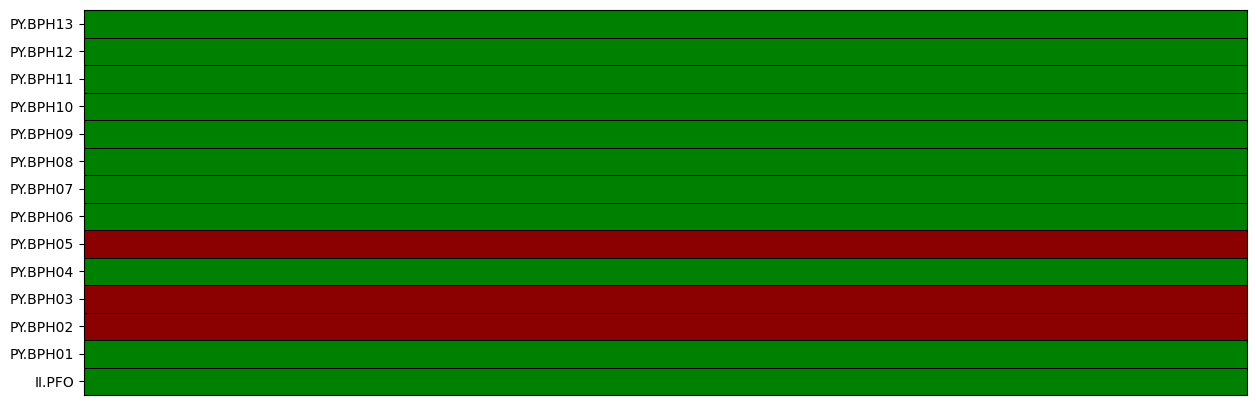


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.19 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-25T10:50:18.019538Z - 2022-11-25T10:51:18.019538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-25T10:50:18.019538Z - 2022-11-25T10:51:18.019538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-25T10:50:18.019538Z - 2022-11-25T10:51:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-25T10:50:18.019538Z - 2022-11-25T10:51:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-25T10:50:18.019538Z - 2022-11-25T10:51:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-25T10:50:18.019538Z - 2022-11-25T10:51:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-25T10:50:18.019538Z - 2022-11-25T10:51:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-25T10:50:18.019538Z - 2022-11-25T10:51:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-25T10:50:18.019538Z - 2022-11-25T10:51:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-25T10:50:18.019538Z - 2022-11-25T10:51:18.019538Z |


 -> 43 2022-11-27 08:06:51.250000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-27T08:06:36.251100Z - 2022-11-27T08:07:36.226100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-27T08:06:36.251100Z - 2022-11-27T08:07:36.226100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-27T08:06:36.251100Z - 2022-11-27T08:07:36.226100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for II.PFO.10.BH* ...
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH07 Failed to load inventory!
 -> BPH07 failed to rotate to ZNE
 -> continue computing ADR for 5 of 9 stations ...

 -> Runtime: 0.35 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


12 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-27T08:06:36.244538Z - 2022-11-27T08:07:36.244538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-27T08:06:36.244538Z - 2022-11-27T08:07:36.244538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-27T08:06:36.244538Z - 2022-11-27T08:07:36.244538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-27T08:06:36.244538Z - 2022-11-27T08:07:36.244538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-27T08:06:36.244538Z - 2022-11-27T08:07:36.244538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-27T08:06:36.244538Z - 2022-11-27T08:07:36.244538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-27T08:06:36.244538Z - 2022-11-27T08:07:36.244538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJN | 2022-11-27T08:06:36.244538Z - 2022-11-27T08:07:36.244538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJZ | 2022-11-27T08:06:36.244538Z - 2022-11-27T08:07:36.244538Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2022-11-27T08:06:36.251100Z - 2022-11-27T08:07:36.226100Z |


 -> 44 2022-11-29 03:14:32.770000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-29T03:14:17.771100Z - 2022-11-29T03:15:17.746100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-29T03:14:17.771100Z - 2022-11-29T03:15:17.746100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-29T03:14:17.771100Z - 2022-11-29T03:15:17.746100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


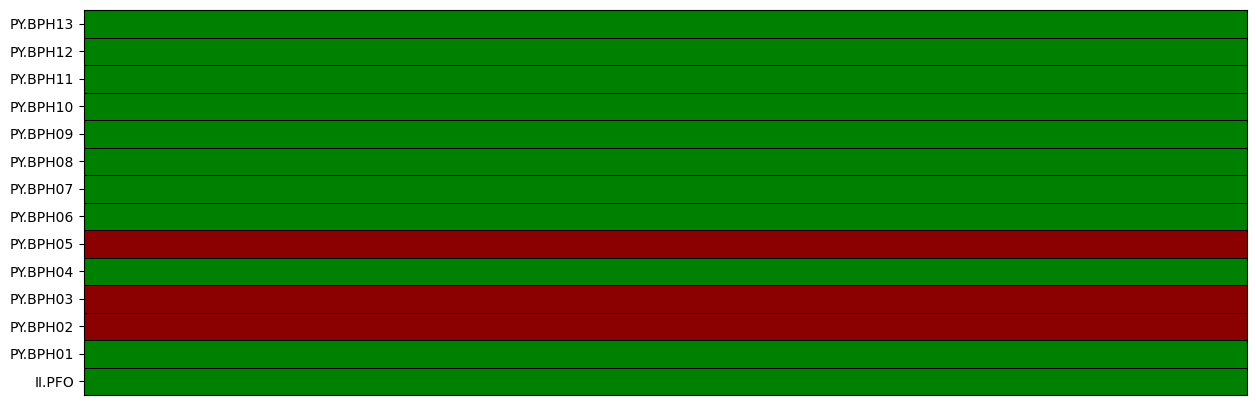


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH08..BH* ...
 -> continue computing ADR for 5 of 9 stations ...
 -> failed to compute ADR mid ...
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


12 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-29T03:14:17.769538Z - 2022-11-29T03:15:17.769538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-29T03:14:17.769538Z - 2022-11-29T03:15:17.769538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-29T03:14:17.769538Z - 2022-11-29T03:15:17.769538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-29T03:14:17.769538Z - 2022-11-29T03:15:17.769538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-29T03:14:17.769538Z - 2022-11-29T03:15:17.769538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-29T03:14:17.769538Z - 2022-11-29T03:15:17.769538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-29T03:14:17.769538Z - 2022-11-29T03:15:17.769538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-29T03:14:17.769538Z - 2022-11-29T03:15:17.769538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-29T03:14:17.769538Z - 2022-11-29T03:15:17.769538Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2022-11-29T03:14:17.771100Z - 2022-11-29T03:15:17.746100Z |


 -> 45 2022-11-29 17:14:00.490000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-29T17:13:45.491100Z - 2022-11-29T17:14:45.466100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-29T17:13:45.491100Z - 2022-11-29T17:14:45.466100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-29T17:13:45.491100Z - 2022-11-29T17:14:45.466100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


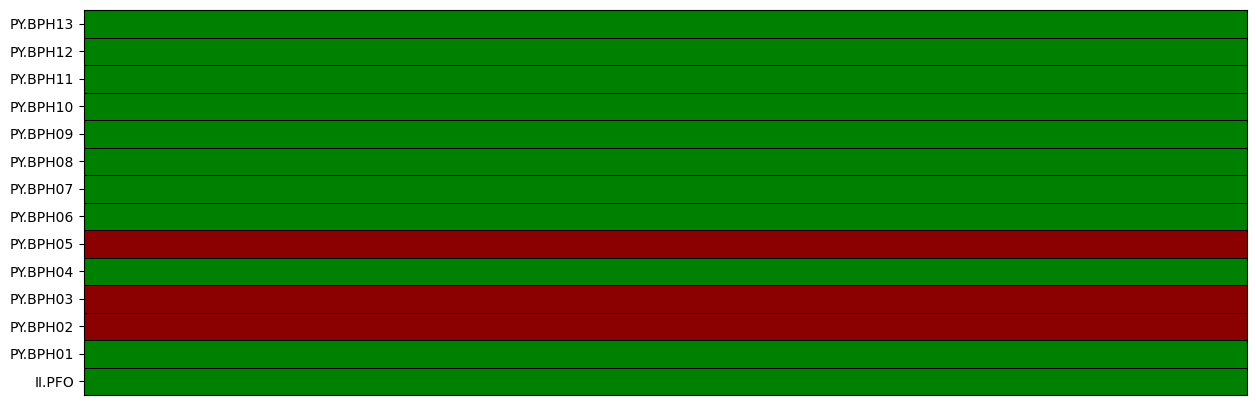


 -> Runtime: 0.61 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.36 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-29T17:13:45.494538Z - 2022-11-29T17:14:45.494538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-29T17:13:45.494538Z - 2022-11-29T17:14:45.494538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-29T17:13:45.494538Z - 2022-11-29T17:14:45.494538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-29T17:13:45.494538Z - 2022-11-29T17:14:45.494538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-29T17:13:45.494538Z - 2022-11-29T17:14:45.494538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-29T17:13:45.494538Z - 2022-11-29T17:14:45.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-29T17:13:45.494538Z - 2022-11-29T17:14:45.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-29T17:13:45.494538Z - 2022-11-29T17:14:45.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-29T17:13:45.494538Z - 2022-11-29T17:14:45.494538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-29T17:13:45.494538Z - 2022-11-29T17:14:45.494538Z |


 -> 46 2022-11-30 14:05:03.530000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-11-30T14:04:48.527800Z - 2022-11-30T14:05:48.502800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-11-30T14:04:48.527800Z - 2022-11-30T14:05:48.502800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-11-30T14:04:48.527800Z - 2022-11-30T14:05:48.502800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


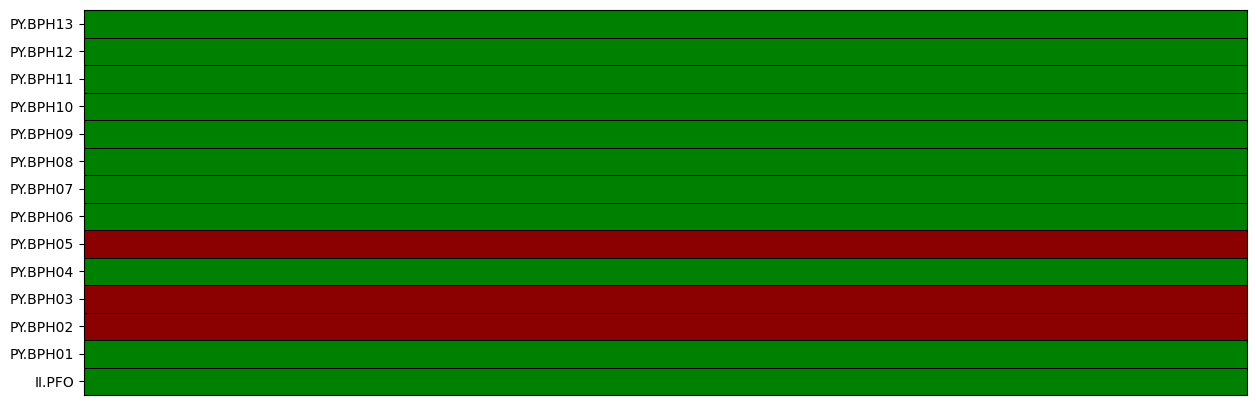


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 6 of 9 stations ...

 -> Runtime: 0.35 minutes
 -> geting waveforms failed for PY.BPH02..BH* ...
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.2 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-11-30T14:04:48.519539Z - 2022-11-30T14:05:48.519539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-11-30T14:04:48.519539Z - 2022-11-30T14:05:48.519539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-11-30T14:04:48.519539Z - 2022-11-30T14:05:48.519539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-11-30T14:04:48.519539Z - 2022-11-30T14:05:48.519539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-11-30T14:04:48.519539Z - 2022-11-30T14:05:48.519539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-11-30T14:04:48.519539Z - 2022-11-30T14:05:48.519539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-11-30T14:04:48.519539Z - 2022-11-30T14:05:48.519539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-11-30T14:04:48.519539Z - 2022-11-30T14:05:48.519539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-11-30T14:04:48.519539Z - 2022-11-30T14:05:48.519539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-11-30T14:04:48.519539Z - 2022-11-30T14:05:48.519539Z |


 -> 47 2022-12-01 20:26:07.810000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-01T20:25:52.811200Z - 2022-12-01T20:26:52.786200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-01T20:25:52.811200Z - 2022-12-01T20:26:52.786200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-01T20:25:52.811200Z - 2022-12-01T20:26:52.786200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


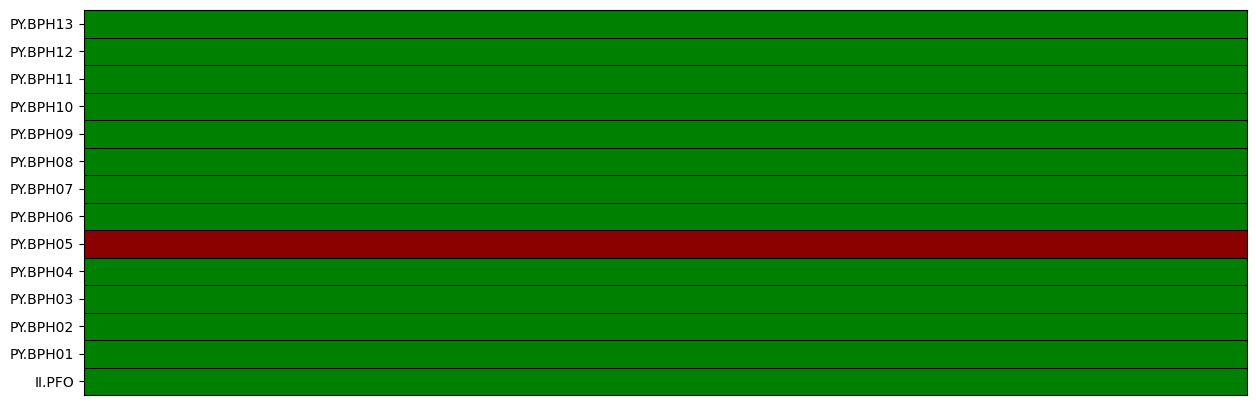


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-01T20:25:52.819538Z - 2022-12-01T20:26:52.819538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-01T20:25:52.819538Z - 2022-12-01T20:26:52.819538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-01T20:25:52.819538Z - 2022-12-01T20:26:52.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-01T20:25:52.819538Z - 2022-12-01T20:26:52.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-01T20:25:52.819538Z - 2022-12-01T20:26:52.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-01T20:25:52.819538Z - 2022-12-01T20:26:52.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-01T20:25:52.819538Z - 2022-12-01T20:26:52.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-01T20:25:52.819538Z - 2022-12-01T20:26:52.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-01T20:25:52.819538Z - 2022-12-01T20:26:52.819538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-01T20:25:52.819538Z - 2022-12-01T20:26:52.819538Z |


 -> 48 2022-12-01 22:23:08.470000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-01T22:22:53.471200Z - 2022-12-01T22:23:53.446200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-01T22:22:53.471200Z - 2022-12-01T22:23:53.446200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-01T22:22:53.471200Z - 2022-12-01T22:23:53.446200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


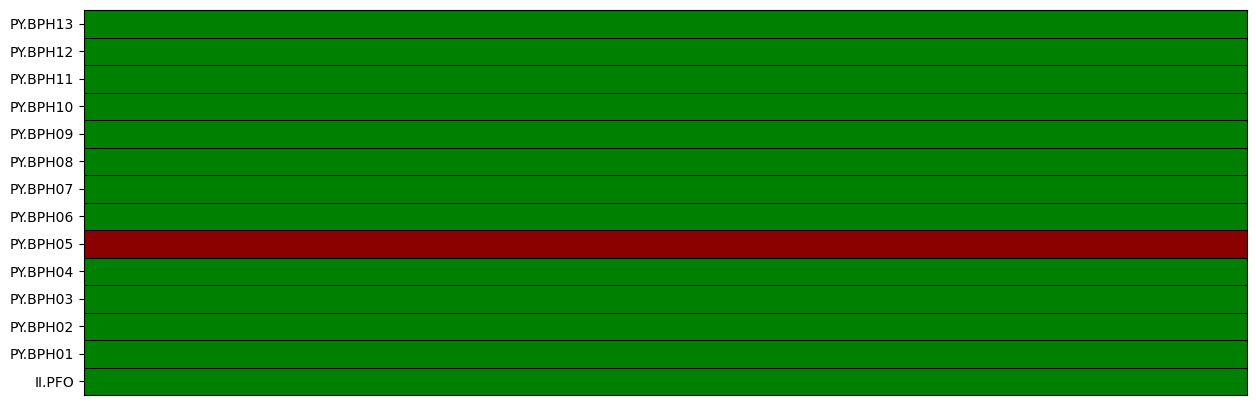


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-01T22:22:53.469538Z - 2022-12-01T22:23:53.469538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-01T22:22:53.469538Z - 2022-12-01T22:23:53.469538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-01T22:22:53.469538Z - 2022-12-01T22:23:53.469538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-01T22:22:53.469538Z - 2022-12-01T22:23:53.469538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-01T22:22:53.469538Z - 2022-12-01T22:23:53.469538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-01T22:22:53.469538Z - 2022-12-01T22:23:53.469538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-01T22:22:53.469538Z - 2022-12-01T22:23:53.469538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-01T22:22:53.469538Z - 2022-12-01T22:23:53.469538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-01T22:22:53.469538Z - 2022-12-01T22:23:53.469538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-01T22:22:53.469538Z - 2022-12-01T22:23:53.469538Z |


 -> 49 2022-12-02 03:32:45.040000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-02T03:32:30.041200Z - 2022-12-02T03:33:30.016200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-02T03:32:30.041200Z - 2022-12-02T03:33:30.016200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-02T03:32:30.041200Z - 2022-12-02T03:33:30.016200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


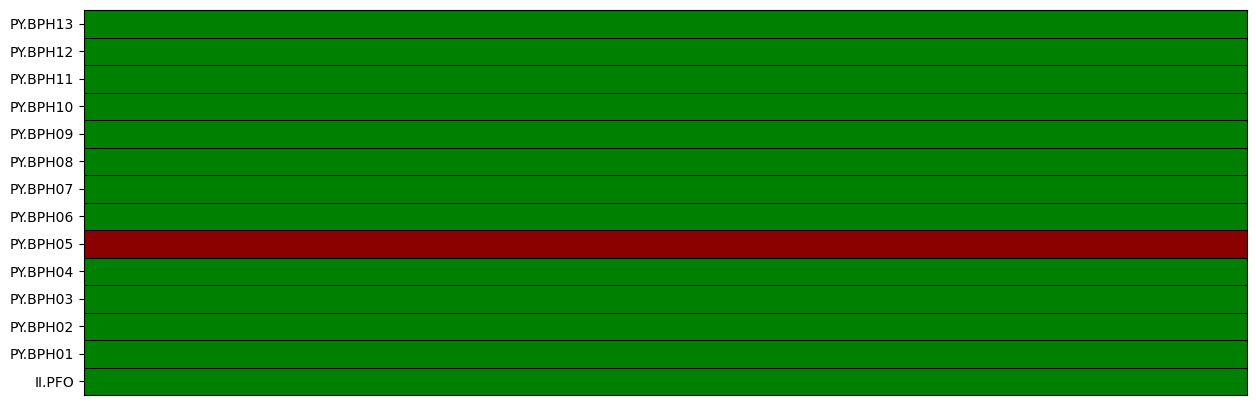


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-02T03:32:30.044538Z - 2022-12-02T03:33:30.044538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-02T03:32:30.044538Z - 2022-12-02T03:33:30.044538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-02T03:32:30.044538Z - 2022-12-02T03:33:30.044538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-02T03:32:30.044538Z - 2022-12-02T03:33:30.044538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-02T03:32:30.044538Z - 2022-12-02T03:33:30.044538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-02T03:32:30.044538Z - 2022-12-02T03:33:30.044538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-02T03:32:30.044538Z - 2022-12-02T03:33:30.044538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-02T03:32:30.044538Z - 2022-12-02T03:33:30.044538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-02T03:32:30.044538Z - 2022-12-02T03:33:30.044538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-02T03:32:30.044538Z - 2022-12-02T03:33:30.044538Z |


 -> 50 2022-12-02 22:23:52.110000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-02T22:23:37.111200Z - 2022-12-02T22:24:37.086200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-02T22:23:37.111200Z - 2022-12-02T22:24:37.086200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-02T22:23:37.111200Z - 2022-12-02T22:24:37.086200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


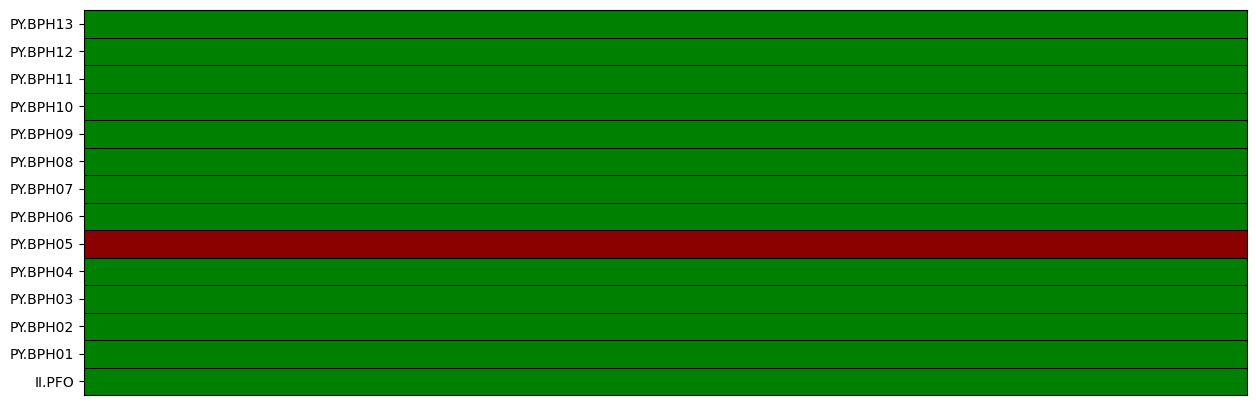


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> BPH01 Failed to load inventory!
 -> BPH01 failed to rotate to ZNE
 -> continue computing ADR for 4 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-02T22:23:37.119538Z - 2022-12-02T22:24:37.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-02T22:23:37.119538Z - 2022-12-02T22:24:37.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-02T22:23:37.119538Z - 2022-12-02T22:24:37.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-02T22:23:37.119538Z - 2022-12-02T22:24:37.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-02T22:23:37.119538Z - 2022-12-02T22:24:37.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-02T22:23:37.119538Z - 2022-12-02T22:24:37.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-02T22:23:37.119538Z - 2022-12-02T22:24:37.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-02T22:23:37.119538Z - 2022-12-02T22:24:37.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-02T22:23:37.119538Z - 2022-12-02T22:24:37.119538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-02T22:23:37.119538Z - 2022-12-02T22:24:37.119538Z |


 -> 51 2022-12-05 10:55:32.580000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-05T10:55:17.581200Z - 2022-12-05T10:56:17.556200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-05T10:55:17.581200Z - 2022-12-05T10:56:17.556200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-05T10:55:17.581200Z - 2022-12-05T10:56:17.556200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


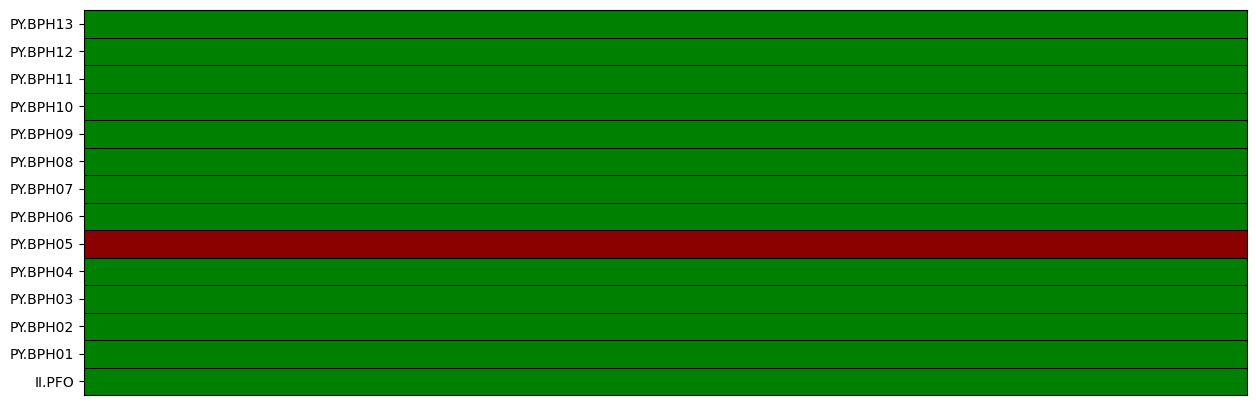


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-05T10:55:17.569538Z - 2022-12-05T10:56:17.569538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-05T10:55:17.569538Z - 2022-12-05T10:56:17.569538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-05T10:55:17.569538Z - 2022-12-05T10:56:17.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-05T10:55:17.569538Z - 2022-12-05T10:56:17.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-05T10:55:17.569538Z - 2022-12-05T10:56:17.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-05T10:55:17.569538Z - 2022-12-05T10:56:17.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-05T10:55:17.569538Z - 2022-12-05T10:56:17.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-05T10:55:17.569538Z - 2022-12-05T10:56:17.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-05T10:55:17.569538Z - 2022-12-05T10:56:17.569538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-05T10:55:17.569538Z - 2022-12-05T10:56:17.569538Z |


 -> 52 2022-12-05 11:05:37.190000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-05T11:05:22.191200Z - 2022-12-05T11:06:22.166200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-05T11:05:22.191200Z - 2022-12-05T11:06:22.166200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-05T11:05:22.191200Z - 2022-12-05T11:06:22.166200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH08 Failed to load inventory!
 -> BPH08 failed to rotate to ZNE
 -> continue computing ADR for 12 of 14 stations ...


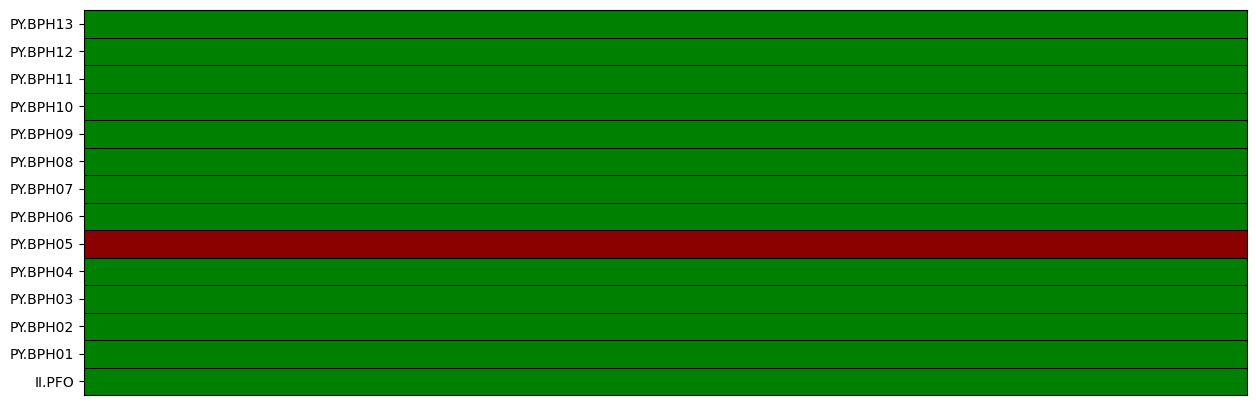


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-05T11:05:22.194538Z - 2022-12-05T11:06:22.194538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-05T11:05:22.194538Z - 2022-12-05T11:06:22.194538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-05T11:05:22.194538Z - 2022-12-05T11:06:22.194538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-05T11:05:22.194538Z - 2022-12-05T11:06:22.194538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-05T11:05:22.194538Z - 2022-12-05T11:06:22.194538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-05T11:05:22.194538Z - 2022-12-05T11:06:22.194538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-05T11:05:22.194538Z - 2022-12-05T11:06:22.194538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-05T11:05:22.194538Z - 2022-12-05T11:06:22.194538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-05T11:05:22.194538Z - 2022-12-05T11:06:22.194538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-05T11:05:22.194538Z - 2022-12-05T11:06:22.194538Z |


 -> 53 2022-12-07 04:29:01.020000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-07T04:28:46.021200Z - 2022-12-07T04:29:45.996200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-07T04:28:46.021200Z - 2022-12-07T04:29:45.996200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-07T04:28:46.021200Z - 2022-12-07T04:29:45.996200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


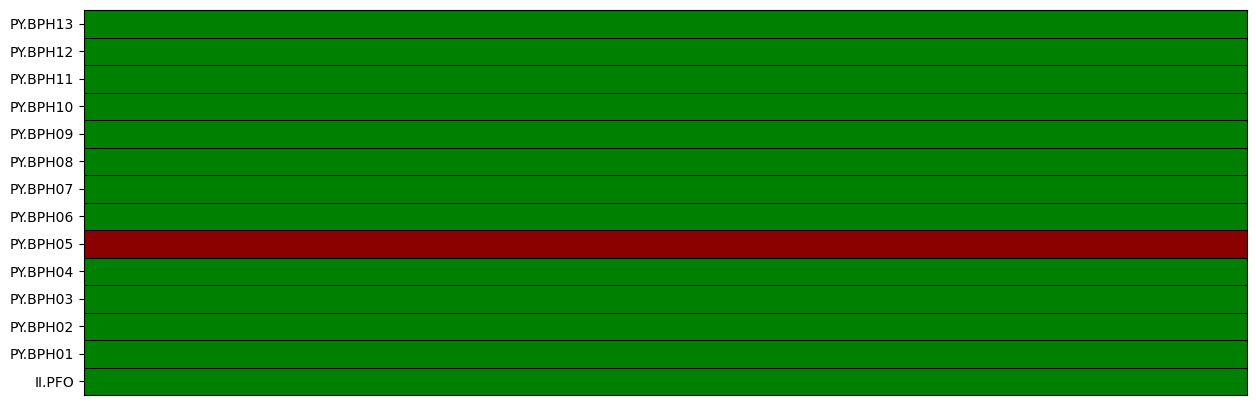


 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-07T04:28:46.019536Z - 2022-12-07T04:29:46.019536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-07T04:28:46.019536Z - 2022-12-07T04:29:46.019536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-07T04:28:46.019538Z - 2022-12-07T04:29:46.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-07T04:28:46.019536Z - 2022-12-07T04:29:46.019536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-07T04:28:46.019536Z - 2022-12-07T04:29:46.019536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-07T04:28:46.019538Z - 2022-12-07T04:29:46.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-07T04:28:46.019536Z - 2022-12-07T04:29:46.019536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-07T04:28:46.019536Z - 2022-12-07T04:29:46.019536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-07T04:28:46.019538Z - 2022-12-07T04:29:46.019538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-07T04:28:46.019536Z - 2022-12-07T04:29:46.019536Z |


 -> 54 2022-12-09 14:15:14.160000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-09T14:14:59.161000Z - 2022-12-09T14:15:59.136000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-09T14:14:59.161000Z - 2022-12-09T14:15:59.136000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-09T14:14:59.161000Z - 2022-12-09T14:15:59.136000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


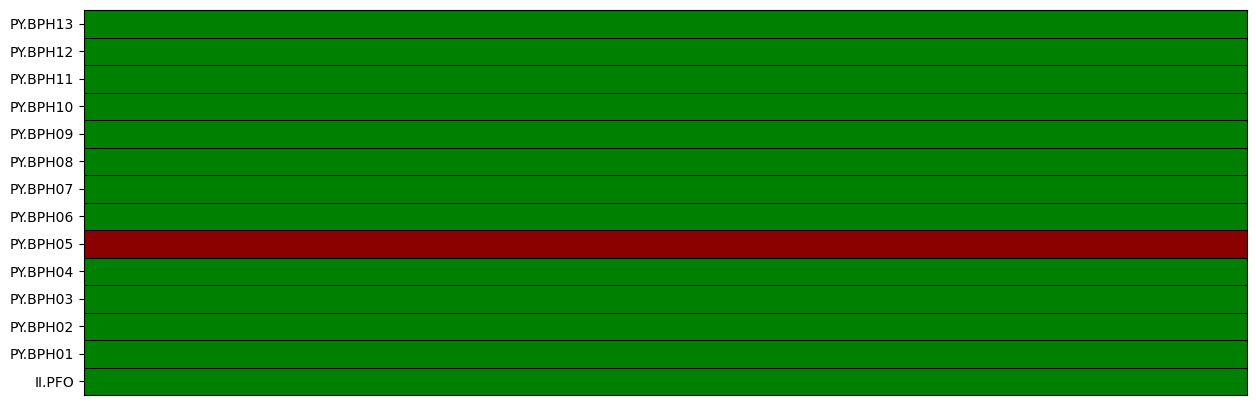


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-09T14:14:59.169538Z - 2022-12-09T14:15:59.169538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-09T14:14:59.169538Z - 2022-12-09T14:15:59.169538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-09T14:14:59.169538Z - 2022-12-09T14:15:59.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-09T14:14:59.169538Z - 2022-12-09T14:15:59.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-09T14:14:59.169538Z - 2022-12-09T14:15:59.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-09T14:14:59.169538Z - 2022-12-09T14:15:59.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-09T14:14:59.169538Z - 2022-12-09T14:15:59.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-09T14:14:59.169538Z - 2022-12-09T14:15:59.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-09T14:14:59.169538Z - 2022-12-09T14:15:59.169538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-09T14:14:59.169538Z - 2022-12-09T14:15:59.169538Z |


 -> 55 2022-12-10 15:10:27.700000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-10T15:10:12.701400Z - 2022-12-10T15:11:12.676400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-10T15:10:12.701400Z - 2022-12-10T15:11:12.676400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-10T15:10:12.701400Z - 2022-12-10T15:11:12.676400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


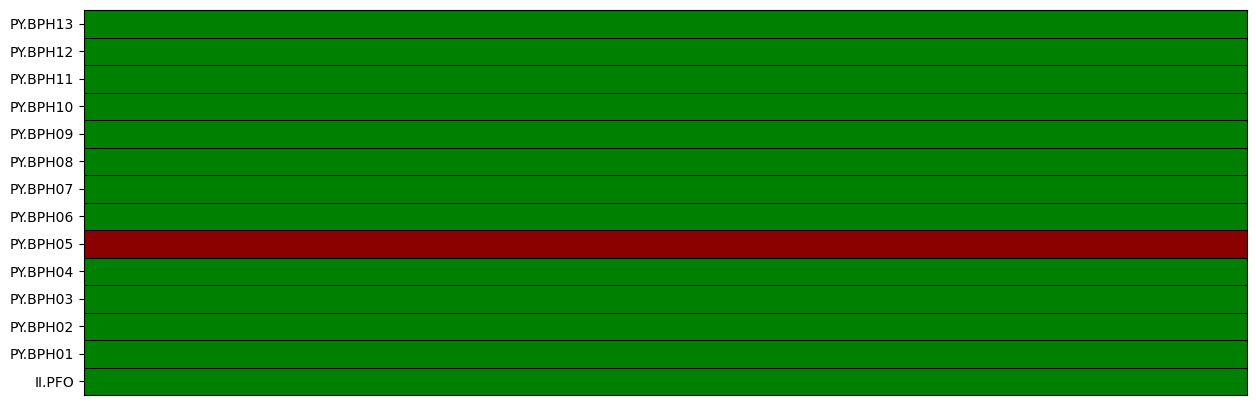


 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-10T15:10:12.694538Z - 2022-12-10T15:11:12.694538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-10T15:10:12.694538Z - 2022-12-10T15:11:12.694538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-10T15:10:12.694538Z - 2022-12-10T15:11:12.694538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-10T15:10:12.694538Z - 2022-12-10T15:11:12.694538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-10T15:10:12.694538Z - 2022-12-10T15:11:12.694538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-10T15:10:12.694538Z - 2022-12-10T15:11:12.694538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-10T15:10:12.694538Z - 2022-12-10T15:11:12.694538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-10T15:10:12.694538Z - 2022-12-10T15:11:12.694538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-10T15:10:12.694538Z - 2022-12-10T15:11:12.694538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-10T15:10:12.694538Z - 2022-12-10T15:11:12.694538Z |


 -> 56 2022-12-11 20:58:56.800000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-11T20:58:41.801400Z - 2022-12-11T20:59:41.776400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-11T20:58:41.801400Z - 2022-12-11T20:59:41.776400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-11T20:58:41.801400Z - 2022-12-11T20:59:41.776400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


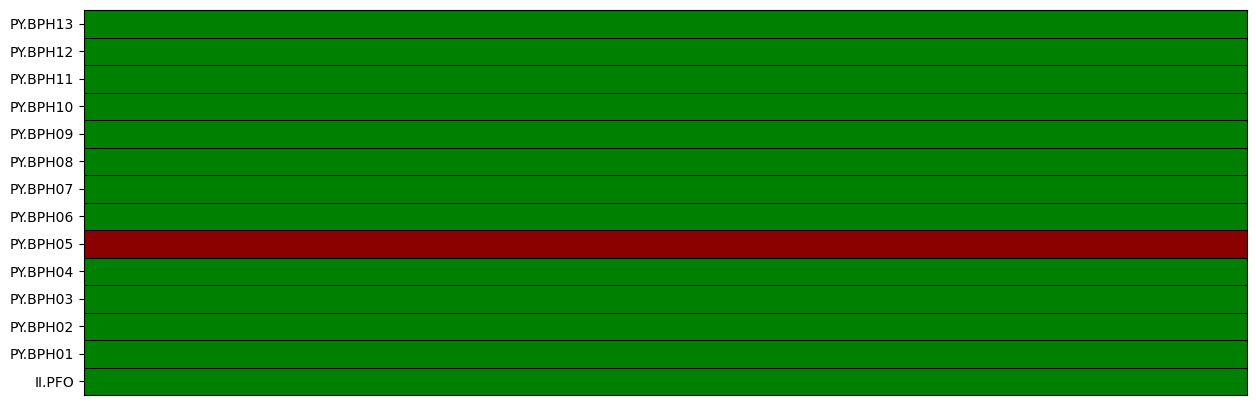


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-11T20:58:41.794538Z - 2022-12-11T20:59:41.794538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-11T20:58:41.794538Z - 2022-12-11T20:59:41.794538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-11T20:58:41.794538Z - 2022-12-11T20:59:41.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-11T20:58:41.794538Z - 2022-12-11T20:59:41.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-11T20:58:41.794538Z - 2022-12-11T20:59:41.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-11T20:58:41.794538Z - 2022-12-11T20:59:41.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-11T20:58:41.794538Z - 2022-12-11T20:59:41.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-11T20:58:41.794538Z - 2022-12-11T20:59:41.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-11T20:58:41.794538Z - 2022-12-11T20:59:41.794538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-11T20:58:41.794538Z - 2022-12-11T20:59:41.794538Z |


 -> 57 2022-12-16 13:51:22.780000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-16T13:51:07.781200Z - 2022-12-16T13:52:07.756200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-16T13:51:07.781200Z - 2022-12-16T13:52:07.756200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-16T13:51:07.781200Z - 2022-12-16T13:52:07.756200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


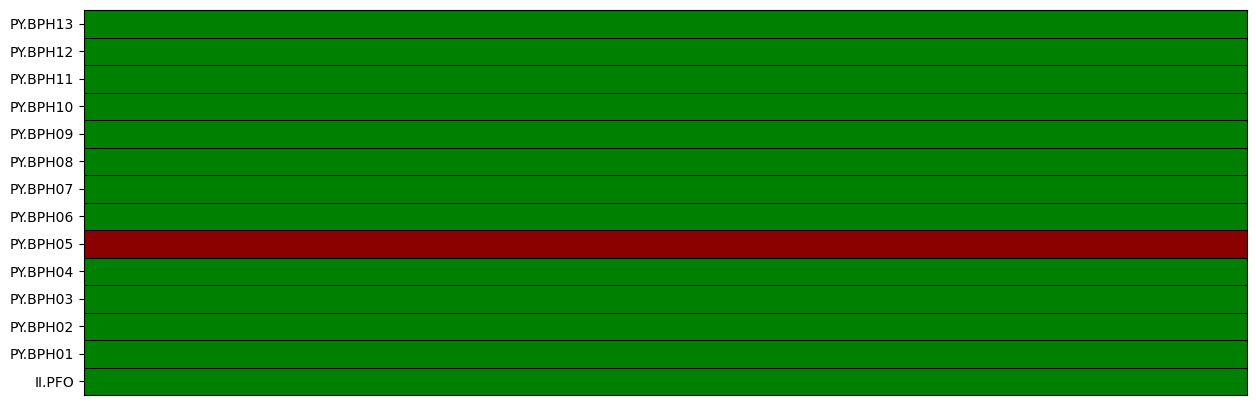


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-16T13:51:07.769538Z - 2022-12-16T13:52:07.769538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-16T13:51:07.769538Z - 2022-12-16T13:52:07.769538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-16T13:51:07.769538Z - 2022-12-16T13:52:07.769538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-16T13:51:07.769538Z - 2022-12-16T13:52:07.769538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-16T13:51:07.769538Z - 2022-12-16T13:52:07.769538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-16T13:51:07.769538Z - 2022-12-16T13:52:07.769538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-16T13:51:07.769538Z - 2022-12-16T13:52:07.769538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-16T13:51:07.769538Z - 2022-12-16T13:52:07.769538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-16T13:51:07.769538Z - 2022-12-16T13:52:07.769538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-16T13:51:07.769538Z - 2022-12-16T13:52:07.769538Z |


 -> 58 2022-12-19 04:26:24.110000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-19T04:26:09.111300Z - 2022-12-19T04:27:09.086300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-19T04:26:09.111300Z - 2022-12-19T04:27:09.086300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-19T04:26:09.111300Z - 2022-12-19T04:27:09.086300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


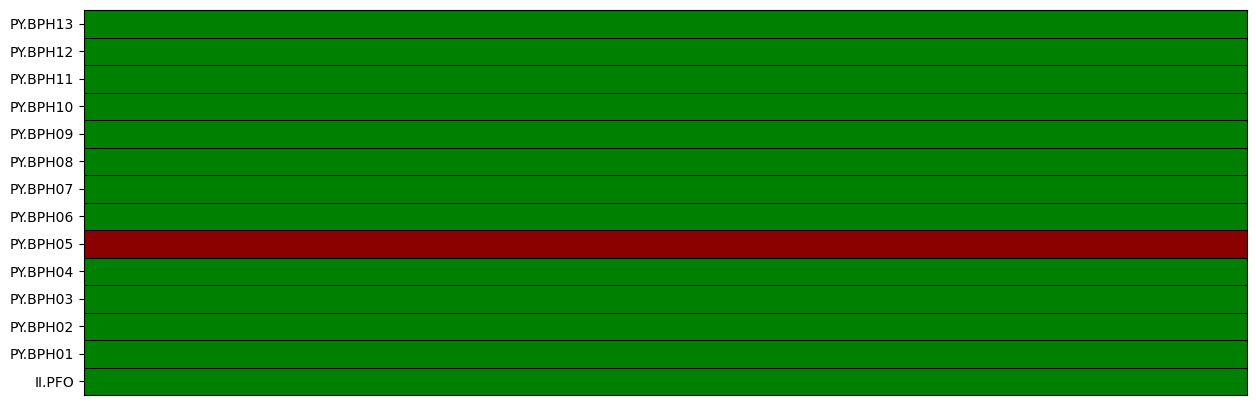


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-19T04:26:09.119538Z - 2022-12-19T04:27:09.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-19T04:26:09.119538Z - 2022-12-19T04:27:09.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-19T04:26:09.119538Z - 2022-12-19T04:27:09.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-19T04:26:09.119538Z - 2022-12-19T04:27:09.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-19T04:26:09.119538Z - 2022-12-19T04:27:09.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-19T04:26:09.119538Z - 2022-12-19T04:27:09.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-19T04:26:09.119538Z - 2022-12-19T04:27:09.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-19T04:26:09.119538Z - 2022-12-19T04:27:09.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-19T04:26:09.119538Z - 2022-12-19T04:27:09.119538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-19T04:26:09.119538Z - 2022-12-19T04:27:09.119538Z |


 -> 59 2022-12-21 00:46:14.410000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-21T00:45:59.408900Z - 2022-12-21T00:46:59.383900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-21T00:45:59.408900Z - 2022-12-21T00:46:59.383900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-21T00:45:59.408900Z - 2022-12-21T00:46:59.383900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


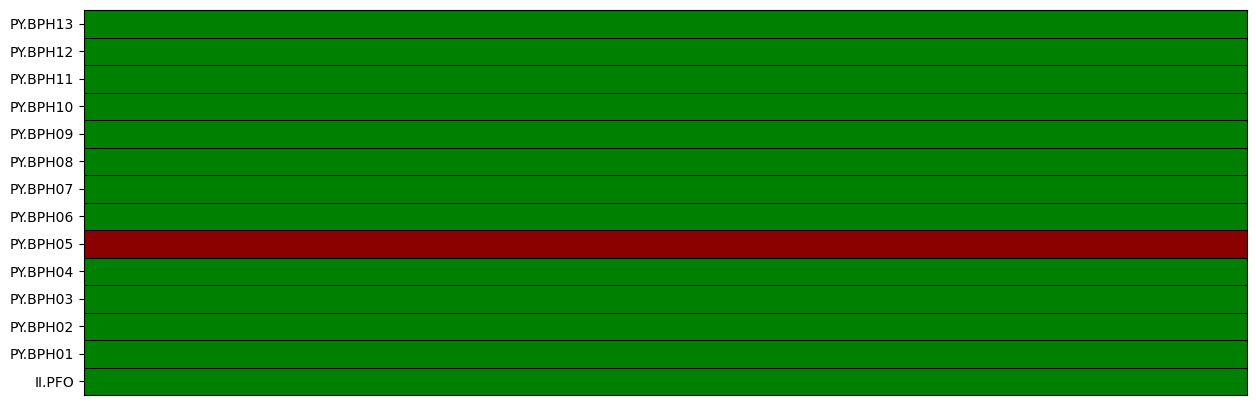


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-21T00:45:59.419538Z - 2022-12-21T00:46:59.419538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-21T00:45:59.419538Z - 2022-12-21T00:46:59.419538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-21T00:45:59.419538Z - 2022-12-21T00:46:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-21T00:45:59.419538Z - 2022-12-21T00:46:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-21T00:45:59.419538Z - 2022-12-21T00:46:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-21T00:45:59.419538Z - 2022-12-21T00:46:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-21T00:45:59.419538Z - 2022-12-21T00:46:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-21T00:45:59.419538Z - 2022-12-21T00:46:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-21T00:45:59.419538Z - 2022-12-21T00:46:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-21T00:45:59.419538Z - 2022-12-21T00:46:59.419538Z |


 -> 60 2022-12-25 08:40:38.690000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-25T08:40:23.688800Z - 2022-12-25T08:41:23.663800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-25T08:40:23.688800Z - 2022-12-25T08:41:23.663800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-25T08:40:23.688800Z - 2022-12-25T08:41:23.663800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


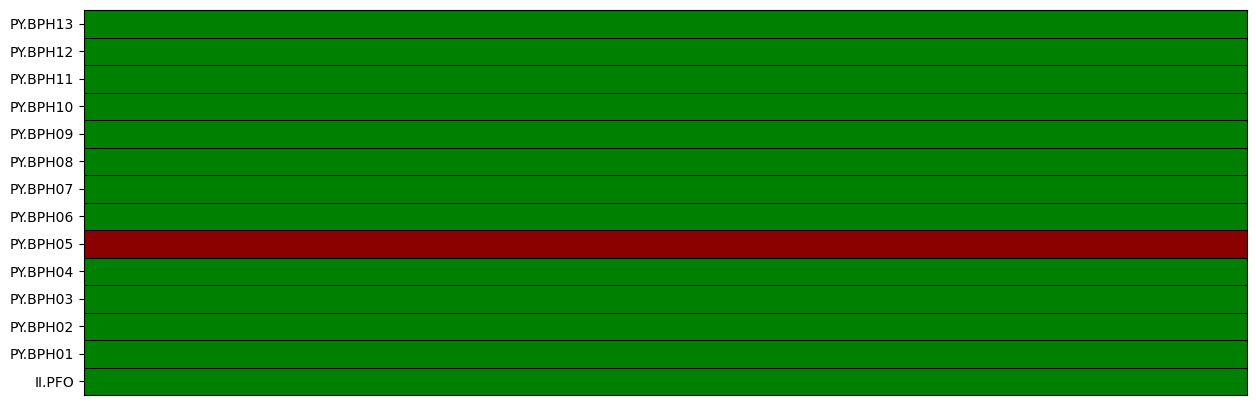


 -> Runtime: 0.7 minutes
 -> BPH04 Failed to load inventory!
 -> BPH04 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 7 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...
 -> failed to compute ADR inner ...


9 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-25T08:40:23.694536Z - 2022-12-25T08:41:23.694536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-25T08:40:23.694536Z - 2022-12-25T08:41:23.694536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-25T08:40:23.694536Z - 2022-12-25T08:41:23.694536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-25T08:40:23.694536Z - 2022-12-25T08:41:23.694536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-25T08:40:23.694536Z - 2022-12-25T08:41:23.694536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-25T08:40:23.694536Z - 2022-12-25T08:41:23.694536Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2022-12-25T08:40:23.688800Z - 2022-12-25T08:41:23.663800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN    | 2022-12-25T08:40:23.688800Z - 2022-12-25T08:41:23.663800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJZ    | 2022-12-25T08:40:23.688800Z - 2022-12-25T08:41:23.663800Z | 40.0 Hz, 2400 samples


 -> 61 2022-12-25 18:53:13.340000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-25T18:52:58.338800Z - 2022-12-25T18:53:58.313800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-25T18:52:58.338800Z - 2022-12-25T18:53:58.313800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-25T18:52:58.338800Z - 2022-12-25T18:53:58.313800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


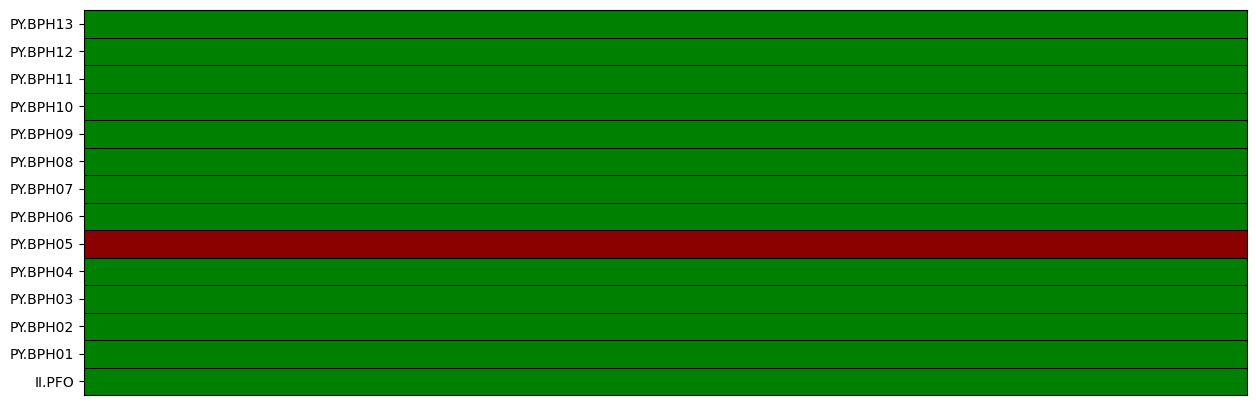


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-25T18:52:58.344538Z - 2022-12-25T18:53:58.344538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-25T18:52:58.344538Z - 2022-12-25T18:53:58.344538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-25T18:52:58.344538Z - 2022-12-25T18:53:58.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-25T18:52:58.344538Z - 2022-12-25T18:53:58.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-25T18:52:58.344538Z - 2022-12-25T18:53:58.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-25T18:52:58.344538Z - 2022-12-25T18:53:58.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-25T18:52:58.344538Z - 2022-12-25T18:53:58.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-25T18:52:58.344538Z - 2022-12-25T18:53:58.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-25T18:52:58.344538Z - 2022-12-25T18:53:58.344538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-25T18:52:58.344538Z - 2022-12-25T18:53:58.344538Z |


 -> 62 2022-12-28 05:50:57.080000 
 -> Failed to load inventory!
 -> sensitivity removed!
 -> failed to rotate to ZNE
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJ1 | 2022-12-28T05:50:42.078800Z - 2022-12-28T05:51:42.053800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJ2 | 2022-12-28T05:50:42.078800Z - 2022-12-28T05:51:42.053800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJ3 | 2022-12-28T05:50:42.078800Z - 2022-12-28T05:51:42.053800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH07 Failed to load inventory!
 -> BPH07 failed to rotate to ZNE
 -> continue computing ADR for 12 of 14 stations ...


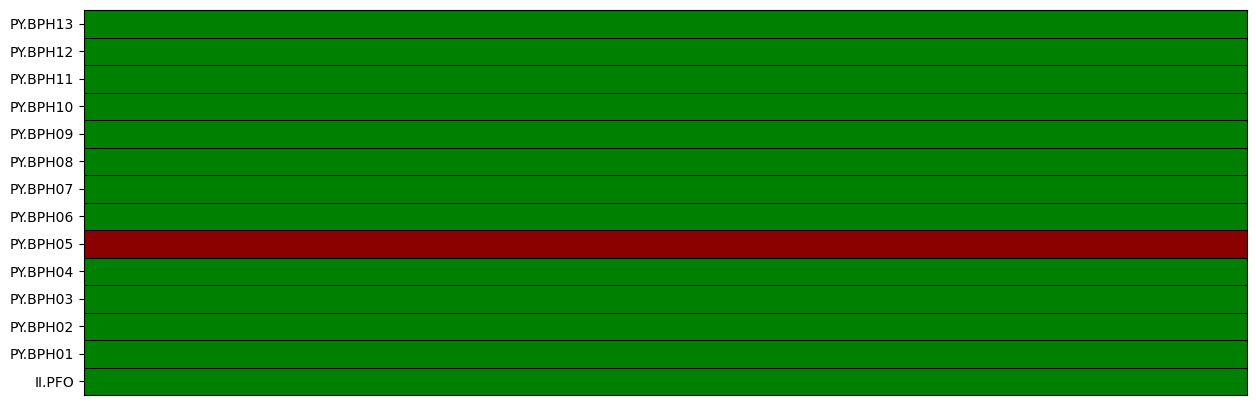


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-28T05:50:42.069538Z - 2022-12-28T05:51:42.069538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-28T05:50:42.069538Z - 2022-12-28T05:51:42.069538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-28T05:50:42.069538Z - 2022-12-28T05:51:42.069538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-28T05:50:42.069538Z - 2022-12-28T05:51:42.069538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-28T05:50:42.069538Z - 2022-12-28T05:51:42.069538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-28T05:50:42.069538Z - 2022-12-28T05:51:42.069538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-28T05:50:42.069538Z - 2022-12-28T05:51:42.069538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-28T05:50:42.069538Z - 2022-12-28T05:51:42.069538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-28T05:50:42.069538Z - 2022-12-28T05:51:42.069538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-28T05:50:42.069538Z - 2022-12-28T05:51:42.069538Z |


 -> 63 2022-12-31 12:12:26.650000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T12:12:11.648800Z - 2022-12-31T12:13:11.623800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-31T12:12:11.648800Z - 2022-12-31T12:13:11.623800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-31T12:12:11.648700Z - 2022-12-31T12:13:11.623700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


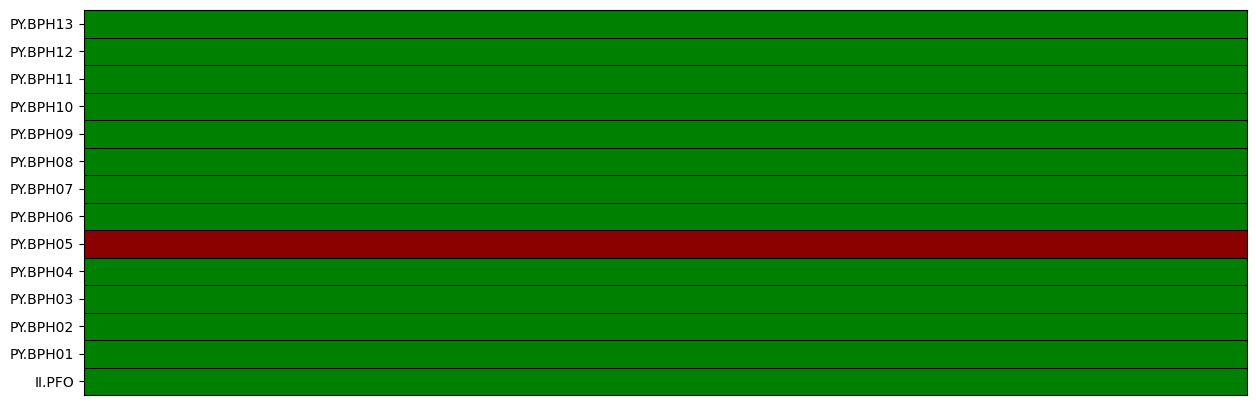


 -> Runtime: 0.74 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-31T12:12:11.644538Z - 2022-12-31T12:13:11.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-31T12:12:11.644538Z - 2022-12-31T12:13:11.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-31T12:12:11.644538Z - 2022-12-31T12:13:11.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-31T12:12:11.644538Z - 2022-12-31T12:13:11.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-31T12:12:11.644538Z - 2022-12-31T12:13:11.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-31T12:12:11.644538Z - 2022-12-31T12:13:11.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-31T12:12:11.644538Z - 2022-12-31T12:13:11.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-31T12:12:11.644538Z - 2022-12-31T12:13:11.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-31T12:12:11.644538Z - 2022-12-31T12:13:11.644538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-31T12:12:11.644538Z - 2022-12-31T12:13:11.644538Z |


 -> 64 2022-12-31 12:36:38.040000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T12:36:23.040400Z - 2022-12-31T12:37:23.015400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-31T12:36:23.040400Z - 2022-12-31T12:37:23.015400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-31T12:36:23.040400Z - 2022-12-31T12:37:23.015400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


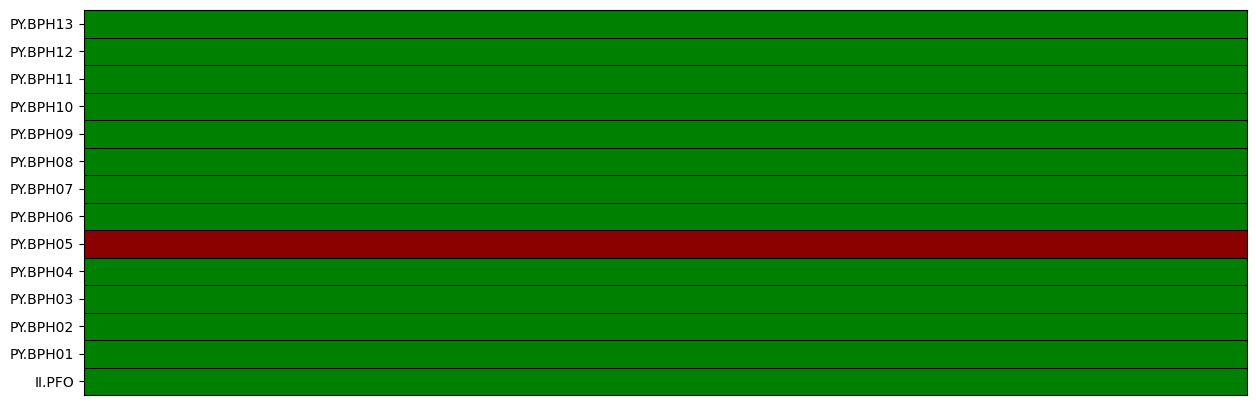


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-31T12:36:23.044538Z - 2022-12-31T12:37:23.044538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-31T12:36:23.044538Z - 2022-12-31T12:37:23.044538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-31T12:36:23.044538Z - 2022-12-31T12:37:23.044538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-31T12:36:23.044538Z - 2022-12-31T12:37:23.044538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-31T12:36:23.044538Z - 2022-12-31T12:37:23.044538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-31T12:36:23.044538Z - 2022-12-31T12:37:23.044538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-31T12:36:23.044538Z - 2022-12-31T12:37:23.044538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-31T12:36:23.044538Z - 2022-12-31T12:37:23.044538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-31T12:36:23.044538Z - 2022-12-31T12:37:23.044538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-31T12:36:23.044538Z - 2022-12-31T12:37:23.044538Z |


 -> 65 2022-12-31 13:15:12.960000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T13:14:57.958700Z - 2022-12-31T13:15:57.933700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-31T13:14:57.958700Z - 2022-12-31T13:15:57.933700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-31T13:14:57.958700Z - 2022-12-31T13:15:57.933700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


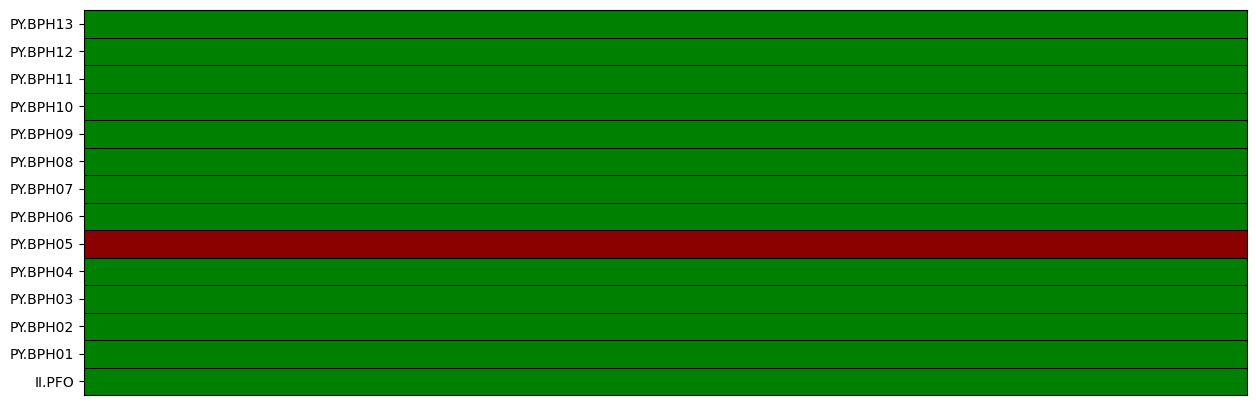


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-31T13:14:57.969538Z - 2022-12-31T13:15:57.969538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-31T13:14:57.969538Z - 2022-12-31T13:15:57.969538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-31T13:14:57.969538Z - 2022-12-31T13:15:57.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-31T13:14:57.969538Z - 2022-12-31T13:15:57.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-31T13:14:57.969538Z - 2022-12-31T13:15:57.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-31T13:14:57.969538Z - 2022-12-31T13:15:57.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-31T13:14:57.969538Z - 2022-12-31T13:15:57.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-31T13:14:57.969538Z - 2022-12-31T13:15:57.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-31T13:14:57.969538Z - 2022-12-31T13:15:57.969538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-31T13:14:57.969538Z - 2022-12-31T13:15:57.969538Z |


 -> 66 2022-12-31 14:32:55.050000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T14:32:40.048700Z - 2022-12-31T14:33:40.023700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-31T14:32:40.048700Z - 2022-12-31T14:33:40.023700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-31T14:32:40.048700Z - 2022-12-31T14:33:40.023700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


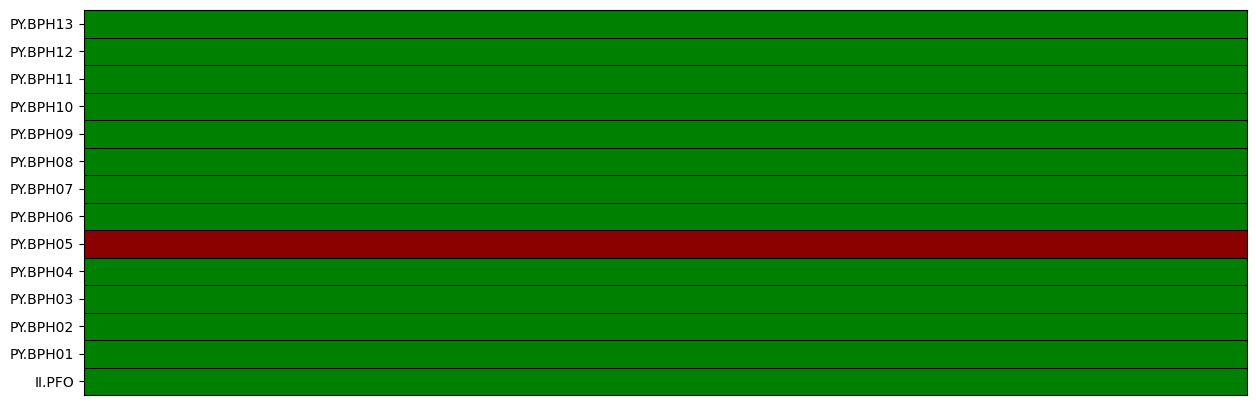


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-31T14:32:40.044538Z - 2022-12-31T14:33:40.044538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-31T14:32:40.044538Z - 2022-12-31T14:33:40.044538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-31T14:32:40.044538Z - 2022-12-31T14:33:40.044538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-31T14:32:40.044538Z - 2022-12-31T14:33:40.044538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-31T14:32:40.044538Z - 2022-12-31T14:33:40.044538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-31T14:32:40.044538Z - 2022-12-31T14:33:40.044538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2022-12-31T14:32:40.044538Z - 2022-12-31T14:33:40.044538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2022-12-31T14:32:40.044538Z - 2022-12-31T14:33:40.044538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2022-12-31T14:32:40.044538Z - 2022-12-31T14:33:40.044538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-31T14:32:40.044538Z - 2022-12-31T14:33:40.044538Z |


 -> 67 2022-12-31 16:40:07.350000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2022-12-31T16:39:52.348700Z - 2022-12-31T16:40:52.323700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2022-12-31T16:39:52.348700Z - 2022-12-31T16:40:52.323700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2022-12-31T16:39:52.348700Z - 2022-12-31T16:40:52.323700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


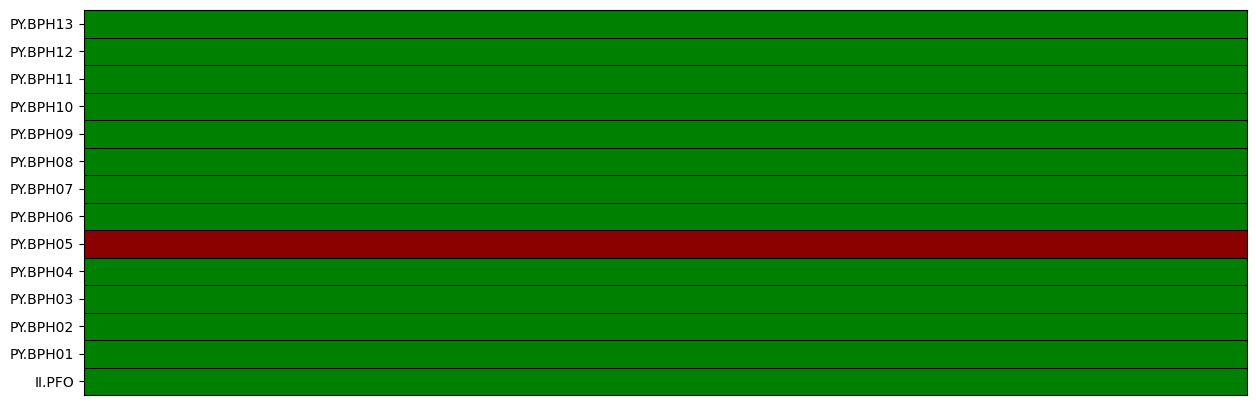


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> geting waveforms failed for II.PFO.10.BH* ...
 -> failed to compute ADR inner ...


12 Trace(s) in Stream:
II.PFO.10.BHE   | 2022-12-31T16:39:52.344539Z - 2022-12-31T16:40:52.344539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2022-12-31T16:39:52.344539Z - 2022-12-31T16:40:52.344539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2022-12-31T16:39:52.344539Z - 2022-12-31T16:40:52.344539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2022-12-31T16:39:52.344539Z - 2022-12-31T16:40:52.344539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2022-12-31T16:39:52.344539Z - 2022-12-31T16:40:52.344539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2022-12-31T16:39:52.344539Z - 2022-12-31T16:40:52.344539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2022-12-31T16:39:52.344539Z - 2022-12-31T16:40:52.344539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJN | 2022-12-31T16:39:52.344539Z - 2022-12-31T16:40:52.344539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJZ | 2022-12-31T16:39:52.344539Z - 2022-12-31T16:40:52.344539Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2022-12-31T16:39:52.348700Z - 2022-12-31T16:40:52.323700Z |


 -> 68 2023-01-02 03:20:18.170000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-02T03:20:03.169100Z - 2023-01-02T03:21:03.144100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-02T03:20:03.169100Z - 2023-01-02T03:21:03.144100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-02T03:20:03.169100Z - 2023-01-02T03:21:03.144100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


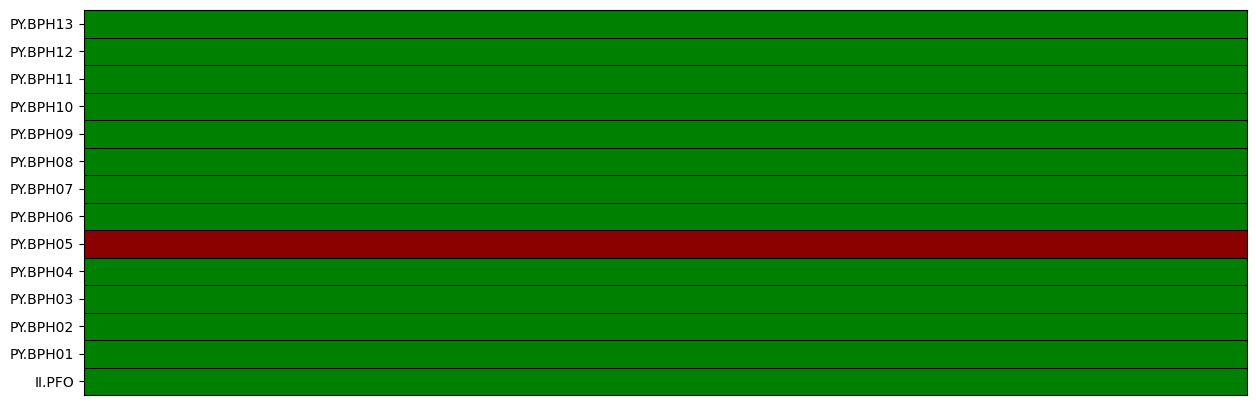


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


12 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-02T03:20:03.169538Z - 2023-01-02T03:21:03.169538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-02T03:20:03.169538Z - 2023-01-02T03:21:03.169538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-02T03:20:03.169538Z - 2023-01-02T03:21:03.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-02T03:20:03.169538Z - 2023-01-02T03:21:03.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-02T03:20:03.169538Z - 2023-01-02T03:21:03.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-02T03:20:03.169538Z - 2023-01-02T03:21:03.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-02T03:20:03.169538Z - 2023-01-02T03:21:03.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-02T03:20:03.169538Z - 2023-01-02T03:21:03.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-02T03:20:03.169538Z - 2023-01-02T03:21:03.169538Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2023-01-02T03:20:03.169100Z - 2023-01-02T03:21:03.144100Z |


 -> 69 2023-01-05 10:00:33.030000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-05T10:00:18.029100Z - 2023-01-05T10:01:18.004100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-05T10:00:18.029100Z - 2023-01-05T10:01:18.004100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-05T10:00:18.029100Z - 2023-01-05T10:01:18.004100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


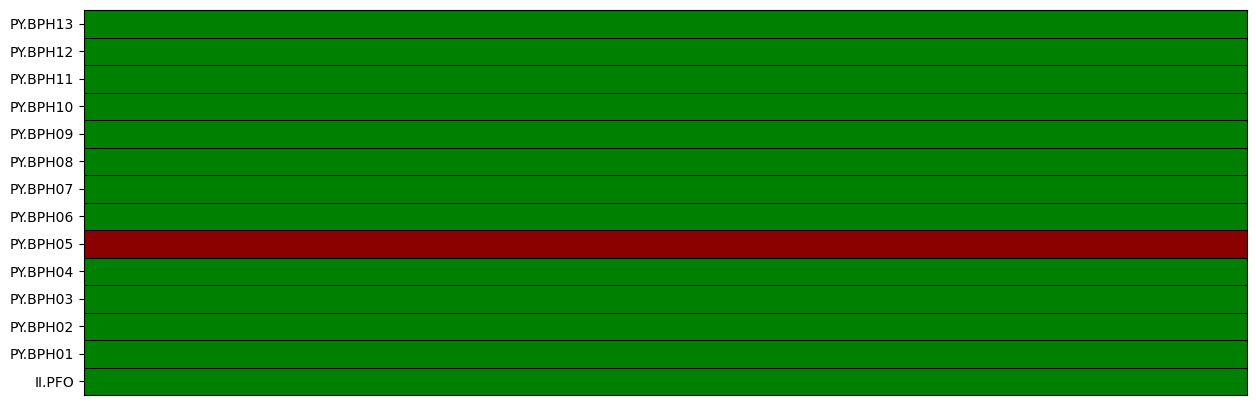


 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH08 Failed to load inventory!
 -> BPH08 failed to rotate to ZNE
 -> continue computing ADR for 7 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-05T10:00:18.019538Z - 2023-01-05T10:01:18.019538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-05T10:00:18.019538Z - 2023-01-05T10:01:18.019538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-05T10:00:18.019538Z - 2023-01-05T10:01:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-05T10:00:18.019538Z - 2023-01-05T10:01:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-05T10:00:18.019538Z - 2023-01-05T10:01:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-05T10:00:18.019538Z - 2023-01-05T10:01:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-05T10:00:18.019538Z - 2023-01-05T10:01:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-05T10:00:18.019538Z - 2023-01-05T10:01:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-05T10:00:18.019538Z - 2023-01-05T10:01:18.019538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-05T10:00:18.019538Z - 2023-01-05T10:01:18.019538Z |


 -> 70 2023-01-05 23:26:23.500000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-05T23:26:08.499100Z - 2023-01-05T23:27:08.474100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-05T23:26:08.499100Z - 2023-01-05T23:27:08.474100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-05T23:26:08.499100Z - 2023-01-05T23:27:08.474100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH07 Failed to load inventory!
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


9 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-05T23:26:08.494538Z - 2023-01-05T23:27:08.494538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-05T23:26:08.494538Z - 2023-01-05T23:27:08.494538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-05T23:26:08.494538Z - 2023-01-05T23:27:08.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-05T23:26:08.494538Z - 2023-01-05T23:27:08.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-05T23:26:08.494538Z - 2023-01-05T23:27:08.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-05T23:26:08.494538Z - 2023-01-05T23:27:08.494538Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2023-01-05T23:26:08.499100Z - 2023-01-05T23:27:08.474100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN    | 2023-01-05T23:26:08.499100Z - 2023-01-05T23:27:08.474100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJZ    | 2023-01-05T23:26:08.499100Z - 2023-01-05T23:27:08.474100Z | 40.0 Hz, 2400 samples


 -> 71 2023-01-05 23:44:18.410000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-05T23:44:03.409100Z - 2023-01-05T23:45:03.384100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-05T23:44:03.409100Z - 2023-01-05T23:45:03.384100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-05T23:44:03.409100Z - 2023-01-05T23:45:03.384100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


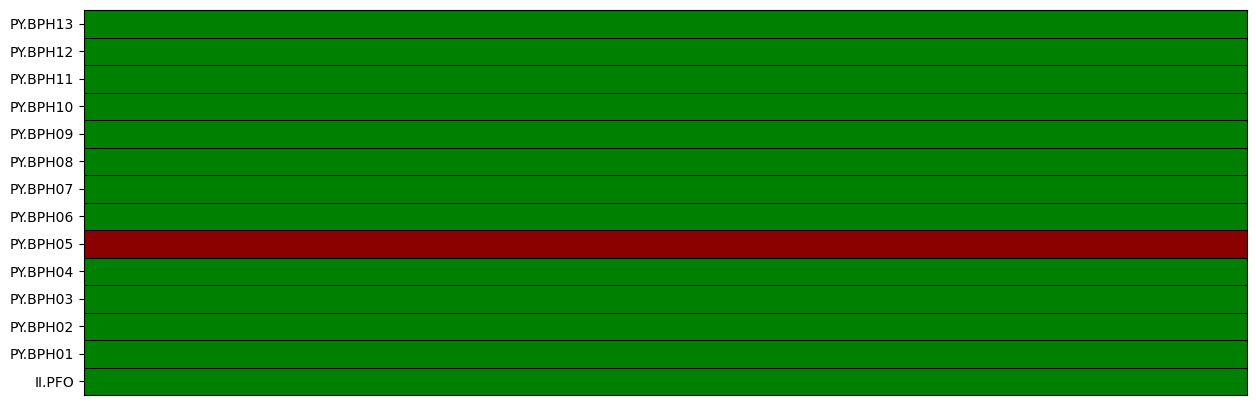


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-05T23:44:03.419538Z - 2023-01-05T23:45:03.419538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-05T23:44:03.419538Z - 2023-01-05T23:45:03.419538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-05T23:44:03.419538Z - 2023-01-05T23:45:03.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-05T23:44:03.419538Z - 2023-01-05T23:45:03.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-05T23:44:03.419538Z - 2023-01-05T23:45:03.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-05T23:44:03.419538Z - 2023-01-05T23:45:03.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-05T23:44:03.419538Z - 2023-01-05T23:45:03.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-05T23:44:03.419538Z - 2023-01-05T23:45:03.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-05T23:44:03.419538Z - 2023-01-05T23:45:03.419538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-05T23:44:03.419538Z - 2023-01-05T23:45:03.419538Z |


 -> 72 2023-01-06 13:51:45.470000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-06T13:51:30.469100Z - 2023-01-06T13:52:30.444100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-06T13:51:30.469100Z - 2023-01-06T13:52:30.444100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-06T13:51:30.469100Z - 2023-01-06T13:52:30.444100Z | 40.0 Hz, 2400 samples

 -> BPH02 Failed to load inventory!
 -> BPH02 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 12 of 14 stations ...
 -> failed to compute ADR all ...
 -> BPH03 Failed to load inventory!
 -> BPH03 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 7 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


9 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-06T13:51:30.469538Z - 2023-01-06T13:52:30.469538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-06T13:51:30.469538Z - 2023-01-06T13:52:30.469538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-06T13:51:30.469538Z - 2023-01-06T13:52:30.469538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-06T13:51:30.469538Z - 2023-01-06T13:52:30.469538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-06T13:51:30.469538Z - 2023-01-06T13:52:30.469538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-06T13:51:30.469538Z - 2023-01-06T13:52:30.469538Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2023-01-06T13:51:30.469100Z - 2023-01-06T13:52:30.444100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN    | 2023-01-06T13:51:30.469100Z - 2023-01-06T13:52:30.444100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJZ    | 2023-01-06T13:51:30.469100Z - 2023-01-06T13:52:30.444100Z | 40.0 Hz, 2400 samples


 -> 73 2023-01-09 16:59:36.400000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-09T16:59:21.398300Z - 2023-01-09T17:00:21.373300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-09T16:59:21.398300Z - 2023-01-09T17:00:21.373300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-09T16:59:21.398300Z - 2023-01-09T17:00:21.373300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


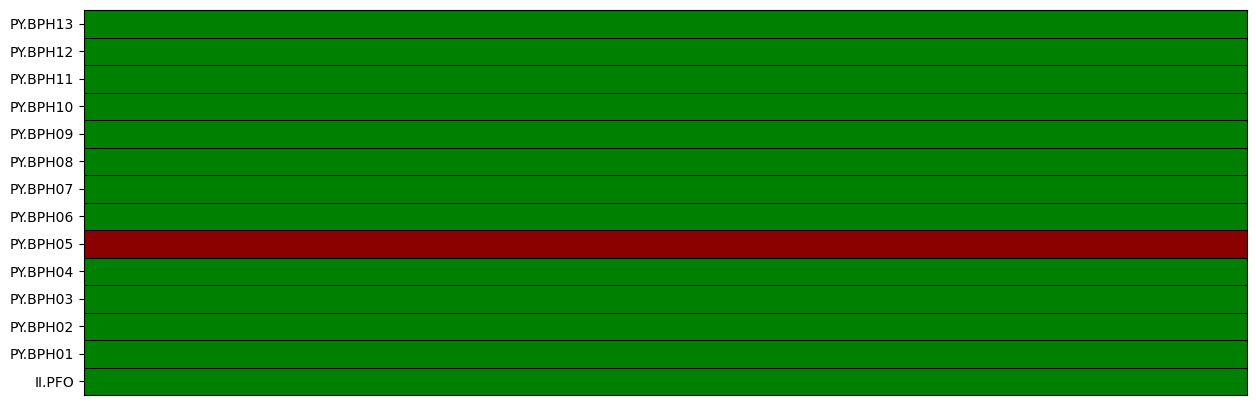


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...
 -> failed to compute ADR inner ...


9 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-09T16:59:21.394539Z - 2023-01-09T17:00:21.394539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-09T16:59:21.394539Z - 2023-01-09T17:00:21.394539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-09T16:59:21.394539Z - 2023-01-09T17:00:21.394539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-09T16:59:21.394539Z - 2023-01-09T17:00:21.394539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-09T16:59:21.394539Z - 2023-01-09T17:00:21.394539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-09T16:59:21.394539Z - 2023-01-09T17:00:21.394539Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2023-01-09T16:59:21.398300Z - 2023-01-09T17:00:21.373300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN    | 2023-01-09T16:59:21.398300Z - 2023-01-09T17:00:21.373300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJZ    | 2023-01-09T16:59:21.398300Z - 2023-01-09T17:00:21.373300Z | 40.0 Hz, 2400 samples


 -> 74 2023-01-09 19:42:56.460000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-09T19:42:41.458300Z - 2023-01-09T19:43:41.433300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-09T19:42:41.458300Z - 2023-01-09T19:43:41.433300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-09T19:42:41.458300Z - 2023-01-09T19:43:41.433300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


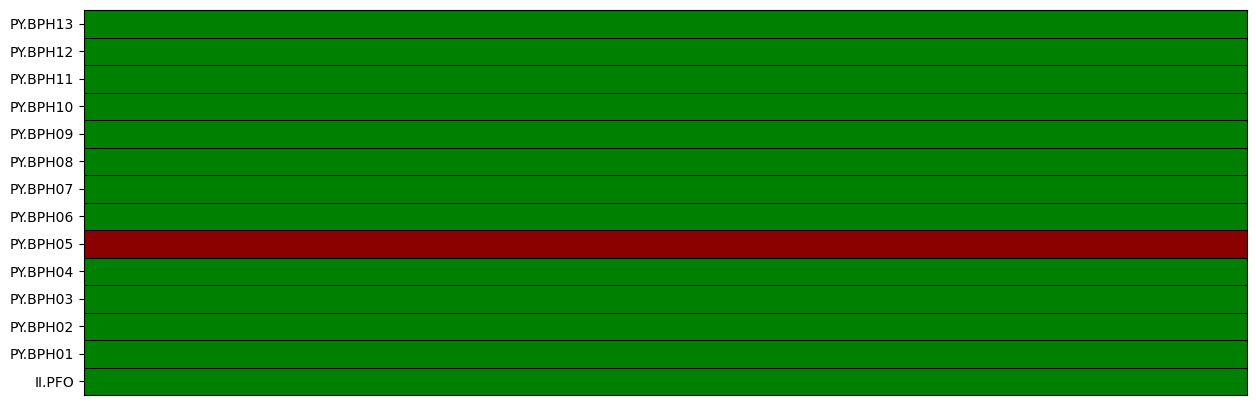


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-09T19:42:41.469539Z - 2023-01-09T19:43:41.469539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-09T19:42:41.469539Z - 2023-01-09T19:43:41.469539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-09T19:42:41.469539Z - 2023-01-09T19:43:41.469539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-09T19:42:41.469539Z - 2023-01-09T19:43:41.469539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-09T19:42:41.469539Z - 2023-01-09T19:43:41.469539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-09T19:42:41.469539Z - 2023-01-09T19:43:41.469539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-09T19:42:41.469539Z - 2023-01-09T19:43:41.469539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-09T19:42:41.469539Z - 2023-01-09T19:43:41.469539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-09T19:42:41.469539Z - 2023-01-09T19:43:41.469539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-09T19:42:41.469539Z - 2023-01-09T19:43:41.469539Z |


 -> 75 2023-01-11 18:59:20.030000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-11T18:59:05.028200Z - 2023-01-11T19:00:05.003200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-11T18:59:05.028200Z - 2023-01-11T19:00:05.003200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-11T18:59:05.028200Z - 2023-01-11T19:00:05.003200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH06 Failed to load inventory!
 -> BPH06 failed to rotate to ZNE
 -> continue computing ADR for 12 of 14 stations ...


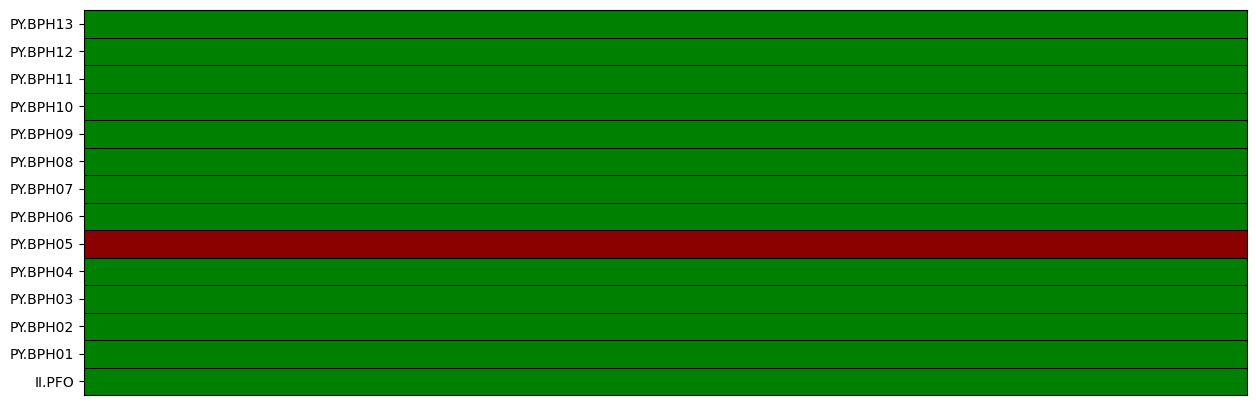


 -> Runtime: 0.69 minutes
 -> BPH03 Failed to load inventory!
 -> BPH03 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 7 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-11T18:59:05.019538Z - 2023-01-11T19:00:05.019538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-11T18:59:05.019538Z - 2023-01-11T19:00:05.019538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-11T18:59:05.019538Z - 2023-01-11T19:00:05.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-11T18:59:05.019538Z - 2023-01-11T19:00:05.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-11T18:59:05.019538Z - 2023-01-11T19:00:05.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-11T18:59:05.019538Z - 2023-01-11T19:00:05.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-11T18:59:05.019538Z - 2023-01-11T19:00:05.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-11T18:59:05.019538Z - 2023-01-11T19:00:05.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-11T18:59:05.019538Z - 2023-01-11T19:00:05.019538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-11T18:59:05.019538Z - 2023-01-11T19:00:05.019538Z |


 -> 76 2023-01-15 09:58:54.070000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-15T09:58:39.068100Z - 2023-01-15T09:59:39.043100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-15T09:58:39.068100Z - 2023-01-15T09:59:39.043100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-15T09:58:39.068100Z - 2023-01-15T09:59:39.043100Z | 40.0 Hz, 2400 samples

 -> PFO Failed to load inventory!
 -> PFO failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


12 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-15T09:58:39.069538Z - 2023-01-15T09:59:39.069538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-15T09:58:39.069538Z - 2023-01-15T09:59:39.069538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-15T09:58:39.069538Z - 2023-01-15T09:59:39.069538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-15T09:58:39.069538Z - 2023-01-15T09:59:39.069538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-15T09:58:39.069538Z - 2023-01-15T09:59:39.069538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-15T09:58:39.069538Z - 2023-01-15T09:59:39.069538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-15T09:58:39.069538Z - 2023-01-15T09:59:39.069538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJN | 2023-01-15T09:58:39.069538Z - 2023-01-15T09:59:39.069538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJZ | 2023-01-15T09:58:39.069538Z - 2023-01-15T09:59:39.069538Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2023-01-15T09:58:39.068100Z - 2023-01-15T09:59:39.043100Z |


 -> 77 2023-01-15 17:17:15.370000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-15T17:17:00.368100Z - 2023-01-15T17:18:00.343100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-15T17:17:00.368100Z - 2023-01-15T17:18:00.343100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-15T17:17:00.368100Z - 2023-01-15T17:18:00.343100Z | 40.0 Hz, 2400 samples

 -> BPH05 Failed to load inventory!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH10 Failed to load inventory!
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


12 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-15T17:17:00.369539Z - 2023-01-15T17:18:00.369539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-15T17:17:00.369539Z - 2023-01-15T17:18:00.369539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-15T17:17:00.369539Z - 2023-01-15T17:18:00.369539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-15T17:17:00.369539Z - 2023-01-15T17:18:00.369539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-15T17:17:00.369539Z - 2023-01-15T17:18:00.369539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-15T17:17:00.369539Z - 2023-01-15T17:18:00.369539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-15T17:17:00.369539Z - 2023-01-15T17:18:00.369539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJN | 2023-01-15T17:17:00.369539Z - 2023-01-15T17:18:00.369539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJZ | 2023-01-15T17:17:00.369539Z - 2023-01-15T17:18:00.369539Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2023-01-15T17:17:00.368100Z - 2023-01-15T17:18:00.343100Z |


 -> 78 2023-01-15 18:03:35.560000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-15T18:03:20.558100Z - 2023-01-15T18:04:20.533100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-15T18:03:20.558100Z - 2023-01-15T18:04:20.533100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-15T18:03:20.558100Z - 2023-01-15T18:04:20.533100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


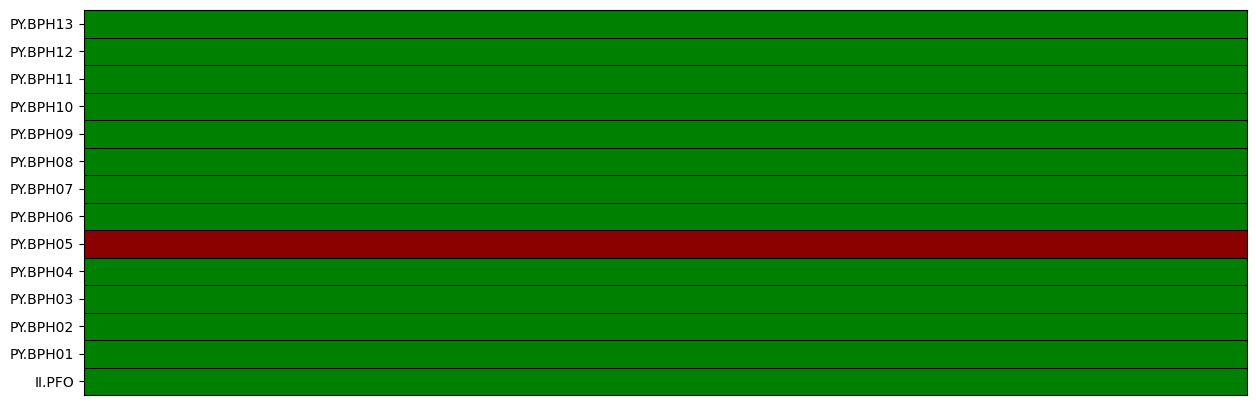


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-15T18:03:20.569539Z - 2023-01-15T18:04:20.569539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-15T18:03:20.569539Z - 2023-01-15T18:04:20.569539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-15T18:03:20.569539Z - 2023-01-15T18:04:20.569539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-15T18:03:20.569539Z - 2023-01-15T18:04:20.569539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-15T18:03:20.569539Z - 2023-01-15T18:04:20.569539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-15T18:03:20.569539Z - 2023-01-15T18:04:20.569539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-15T18:03:20.569539Z - 2023-01-15T18:04:20.569539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-15T18:03:20.569539Z - 2023-01-15T18:04:20.569539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-15T18:03:20.569539Z - 2023-01-15T18:04:20.569539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-15T18:03:20.569539Z - 2023-01-15T18:04:20.569539Z |


 -> 79 2023-01-15 22:05:20.840000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-15T22:05:05.838100Z - 2023-01-15T22:06:05.813100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-15T22:05:05.838100Z - 2023-01-15T22:06:05.813100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-15T22:05:05.838100Z - 2023-01-15T22:06:05.813100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


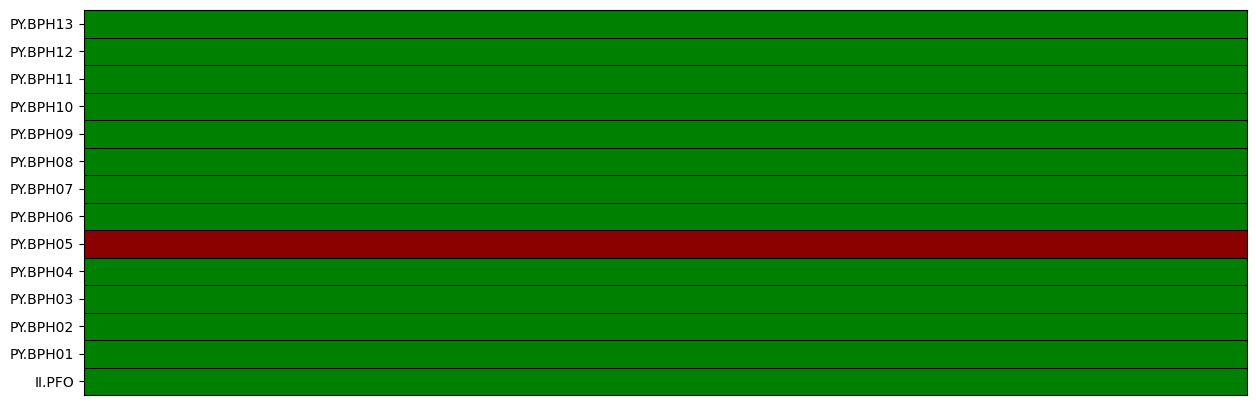


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-15T22:05:05.844538Z - 2023-01-15T22:06:05.844538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-15T22:05:05.844538Z - 2023-01-15T22:06:05.844538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-15T22:05:05.844538Z - 2023-01-15T22:06:05.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-15T22:05:05.844538Z - 2023-01-15T22:06:05.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-15T22:05:05.844538Z - 2023-01-15T22:06:05.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-15T22:05:05.844538Z - 2023-01-15T22:06:05.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-15T22:05:05.844538Z - 2023-01-15T22:06:05.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-15T22:05:05.844538Z - 2023-01-15T22:06:05.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-15T22:05:05.844538Z - 2023-01-15T22:06:05.844538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-15T22:05:05.844538Z - 2023-01-15T22:06:05.844538Z |


 -> 80 2023-01-17 11:50:52.860000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-17T11:50:37.858100Z - 2023-01-17T11:51:37.833100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-17T11:50:37.858100Z - 2023-01-17T11:51:37.833100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-17T11:50:37.858100Z - 2023-01-17T11:51:37.833100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


9 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-17T11:50:37.869539Z - 2023-01-17T11:51:37.869539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-17T11:50:37.869539Z - 2023-01-17T11:51:37.869539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-17T11:50:37.869539Z - 2023-01-17T11:51:37.869539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-17T11:50:37.869539Z - 2023-01-17T11:51:37.869539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-17T11:50:37.869539Z - 2023-01-17T11:51:37.869539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-17T11:50:37.869539Z - 2023-01-17T11:51:37.869539Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2023-01-17T11:50:37.858100Z - 2023-01-17T11:51:37.833100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN    | 2023-01-17T11:50:37.858100Z - 2023-01-17T11:51:37.833100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJZ    | 2023-01-17T11:50:37.858100Z - 2023-01-17T11:51:37.833100Z | 40.0 Hz, 2400 samples


 -> 81 2023-01-17 12:16:28.620000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-17T12:16:13.618100Z - 2023-01-17T12:17:13.593100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-17T12:16:13.618100Z - 2023-01-17T12:17:13.593100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-17T12:16:13.618100Z - 2023-01-17T12:17:13.593100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


9 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-17T12:16:13.619539Z - 2023-01-17T12:17:13.619539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-17T12:16:13.619539Z - 2023-01-17T12:17:13.619539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-17T12:16:13.619539Z - 2023-01-17T12:17:13.619539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-17T12:16:13.619539Z - 2023-01-17T12:17:13.619539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-17T12:16:13.619539Z - 2023-01-17T12:17:13.619539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-17T12:16:13.619539Z - 2023-01-17T12:17:13.619539Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2023-01-17T12:16:13.618100Z - 2023-01-17T12:17:13.593100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN    | 2023-01-17T12:16:13.618100Z - 2023-01-17T12:17:13.593100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJZ    | 2023-01-17T12:16:13.618100Z - 2023-01-17T12:17:13.593100Z | 40.0 Hz, 2400 samples


 -> 82 2023-01-17 21:29:02.140000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-17T21:28:47.138100Z - 2023-01-17T21:29:47.113100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-17T21:28:47.138100Z - 2023-01-17T21:29:47.113100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-17T21:28:47.138100Z - 2023-01-17T21:29:47.113100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


9 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-17T21:28:47.144538Z - 2023-01-17T21:29:47.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-17T21:28:47.144538Z - 2023-01-17T21:29:47.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-17T21:28:47.144538Z - 2023-01-17T21:29:47.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-17T21:28:47.144538Z - 2023-01-17T21:29:47.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-17T21:28:47.144538Z - 2023-01-17T21:29:47.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-17T21:28:47.144538Z - 2023-01-17T21:29:47.144538Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2023-01-17T21:28:47.138100Z - 2023-01-17T21:29:47.113100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN    | 2023-01-17T21:28:47.138100Z - 2023-01-17T21:29:47.113100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJZ    | 2023-01-17T21:28:47.138100Z - 2023-01-17T21:29:47.113100Z | 40.0 Hz, 2400 samples


 -> 83 2023-01-18 18:44:40.560000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-18T18:44:25.558100Z - 2023-01-18T18:45:25.533100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-18T18:44:25.558100Z - 2023-01-18T18:45:25.533100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-18T18:44:25.558100Z - 2023-01-18T18:45:25.533100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


9 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-18T18:44:25.569538Z - 2023-01-18T18:45:25.569538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-18T18:44:25.569538Z - 2023-01-18T18:45:25.569538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-18T18:44:25.569538Z - 2023-01-18T18:45:25.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-18T18:44:25.569538Z - 2023-01-18T18:45:25.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-18T18:44:25.569538Z - 2023-01-18T18:45:25.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-18T18:44:25.569538Z - 2023-01-18T18:45:25.569538Z | 40.0 Hz, 2401 samples
PY.BSPF..HJE    | 2023-01-18T18:44:25.558100Z - 2023-01-18T18:45:25.533100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN    | 2023-01-18T18:44:25.558100Z - 2023-01-18T18:45:25.533100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJZ    | 2023-01-18T18:44:25.558100Z - 2023-01-18T18:45:25.533100Z | 40.0 Hz, 2400 samples


 -> 84 2023-01-19 01:19:16.080000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-19T01:19:01.078100Z - 2023-01-19T01:20:01.053100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-19T01:19:01.078100Z - 2023-01-19T01:20:01.053100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-19T01:19:01.078100Z - 2023-01-19T01:20:01.053100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


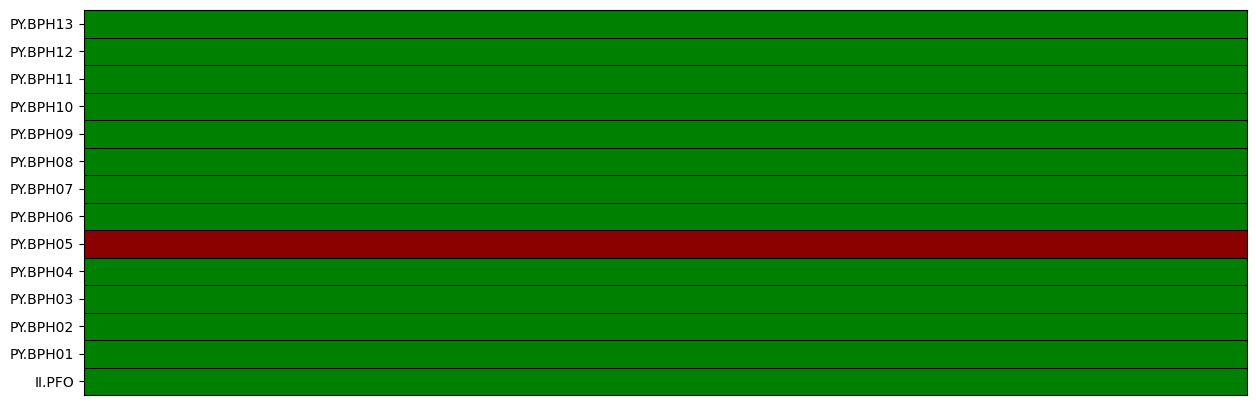


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-19T01:19:01.069539Z - 2023-01-19T01:20:01.069539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-19T01:19:01.069539Z - 2023-01-19T01:20:01.069539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-19T01:19:01.069539Z - 2023-01-19T01:20:01.069539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-19T01:19:01.069539Z - 2023-01-19T01:20:01.069539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-19T01:19:01.069539Z - 2023-01-19T01:20:01.069539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-19T01:19:01.069539Z - 2023-01-19T01:20:01.069539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-19T01:19:01.069539Z - 2023-01-19T01:20:01.069539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-19T01:19:01.069539Z - 2023-01-19T01:20:01.069539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-19T01:19:01.069539Z - 2023-01-19T01:20:01.069539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-19T01:19:01.069539Z - 2023-01-19T01:20:01.069539Z |


 -> 85 2023-01-20 22:36:55.260000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-20T22:36:40.258100Z - 2023-01-20T22:37:40.233100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-20T22:36:40.258100Z - 2023-01-20T22:37:40.233100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-20T22:36:40.258100Z - 2023-01-20T22:37:40.233100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


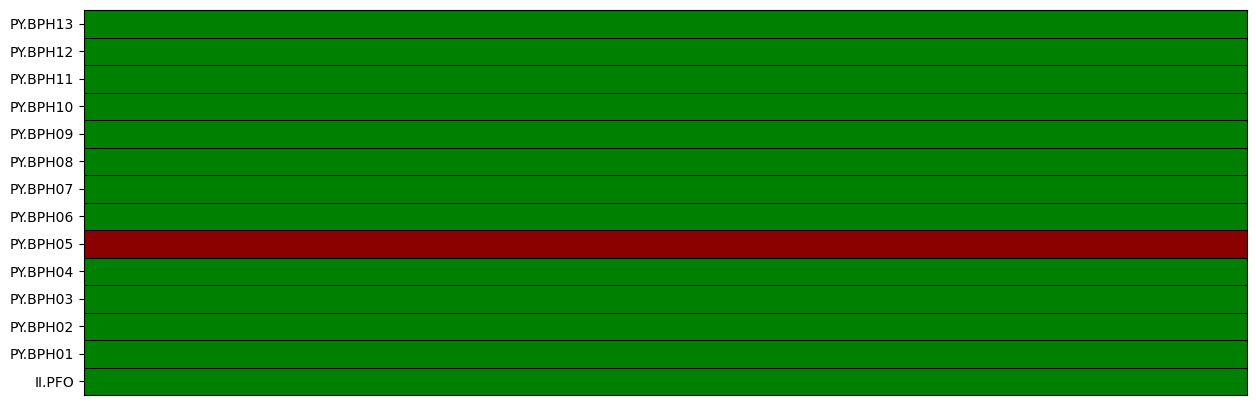


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-20T22:36:40.269538Z - 2023-01-20T22:37:40.269538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-20T22:36:40.269538Z - 2023-01-20T22:37:40.269538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-20T22:36:40.269538Z - 2023-01-20T22:37:40.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-20T22:36:40.269538Z - 2023-01-20T22:37:40.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-20T22:36:40.269538Z - 2023-01-20T22:37:40.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-20T22:36:40.269538Z - 2023-01-20T22:37:40.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-20T22:36:40.269538Z - 2023-01-20T22:37:40.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-20T22:36:40.269538Z - 2023-01-20T22:37:40.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-20T22:36:40.269538Z - 2023-01-20T22:37:40.269538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-20T22:36:40.269538Z - 2023-01-20T22:37:40.269538Z |


 -> 86 2023-01-21 12:05:52.350000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-21T12:05:37.348000Z - 2023-01-21T12:06:37.323000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-21T12:05:37.348000Z - 2023-01-21T12:06:37.323000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-21T12:05:37.348000Z - 2023-01-21T12:06:37.323000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


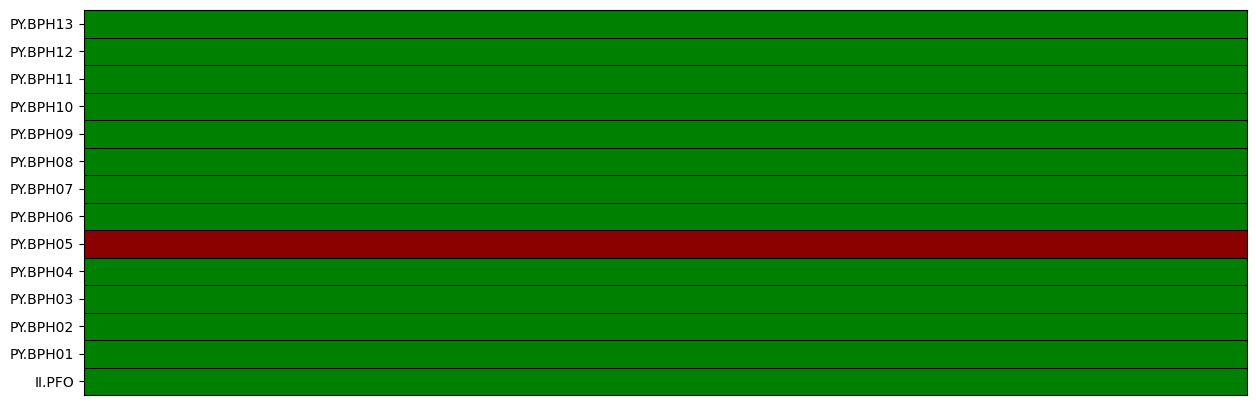


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-21T12:05:37.344538Z - 2023-01-21T12:06:37.344538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-21T12:05:37.344538Z - 2023-01-21T12:06:37.344538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-21T12:05:37.344538Z - 2023-01-21T12:06:37.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-21T12:05:37.344538Z - 2023-01-21T12:06:37.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-21T12:05:37.344538Z - 2023-01-21T12:06:37.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-21T12:05:37.344538Z - 2023-01-21T12:06:37.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-21T12:05:37.344538Z - 2023-01-21T12:06:37.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-21T12:05:37.344538Z - 2023-01-21T12:06:37.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-21T12:05:37.344538Z - 2023-01-21T12:06:37.344538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-21T12:05:37.344538Z - 2023-01-21T12:06:37.344538Z |


 -> 87 2023-01-22 09:38:45.840000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-22T09:38:30.838000Z - 2023-01-22T09:39:30.813000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-22T09:38:30.838000Z - 2023-01-22T09:39:30.813000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-22T09:38:30.838000Z - 2023-01-22T09:39:30.813000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


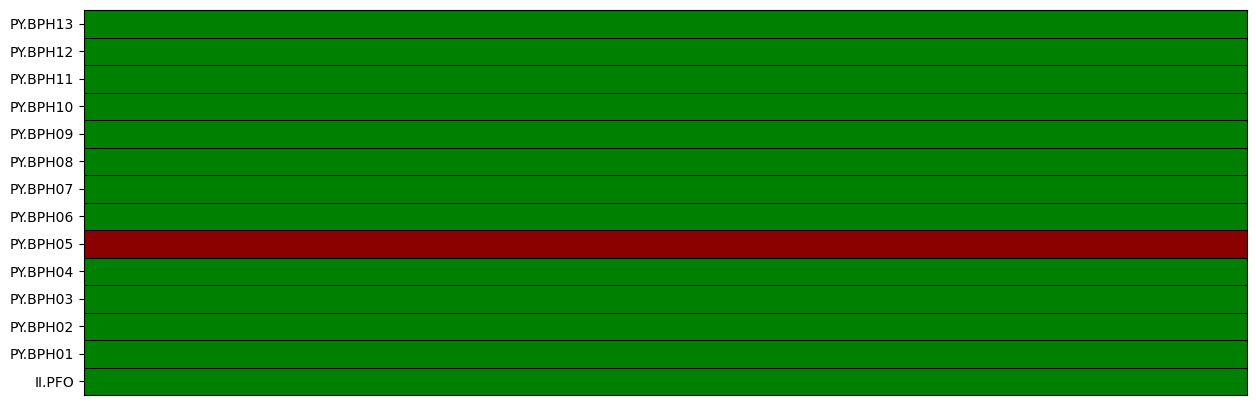


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-22T09:38:30.844538Z - 2023-01-22T09:39:30.844538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-22T09:38:30.844538Z - 2023-01-22T09:39:30.844538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-22T09:38:30.844538Z - 2023-01-22T09:39:30.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-22T09:38:30.844538Z - 2023-01-22T09:39:30.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-22T09:38:30.844538Z - 2023-01-22T09:39:30.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-22T09:38:30.844538Z - 2023-01-22T09:39:30.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-22T09:38:30.844538Z - 2023-01-22T09:39:30.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-22T09:38:30.844538Z - 2023-01-22T09:39:30.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-22T09:38:30.844538Z - 2023-01-22T09:39:30.844538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-22T09:38:30.844538Z - 2023-01-22T09:39:30.844538Z |


 -> 88 2023-01-26 17:13:02.140000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-26T17:12:47.138300Z - 2023-01-26T17:13:47.113300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-26T17:12:47.138300Z - 2023-01-26T17:13:47.113300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-26T17:12:47.138300Z - 2023-01-26T17:13:47.113300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


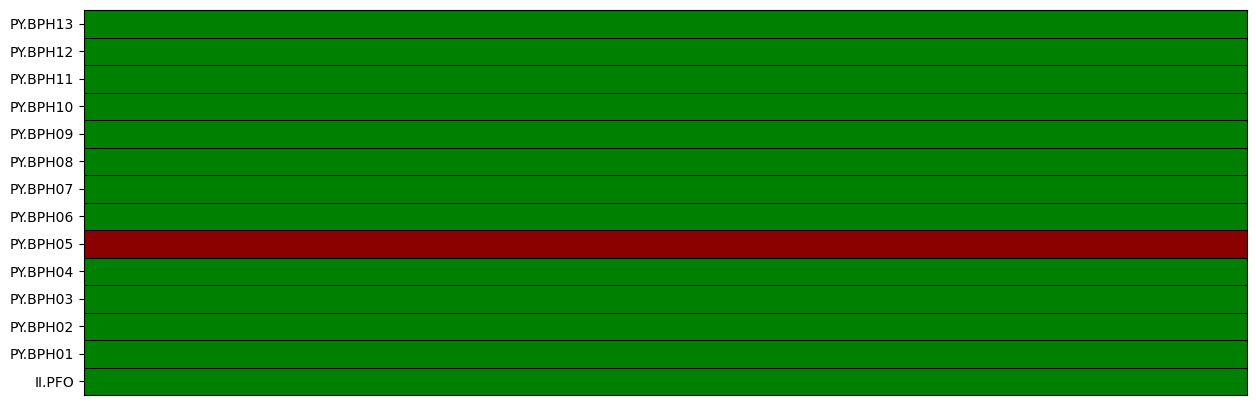


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-26T17:12:47.144538Z - 2023-01-26T17:13:47.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-26T17:12:47.144538Z - 2023-01-26T17:13:47.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-26T17:12:47.144538Z - 2023-01-26T17:13:47.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-26T17:12:47.144538Z - 2023-01-26T17:13:47.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-26T17:12:47.144538Z - 2023-01-26T17:13:47.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-26T17:12:47.144538Z - 2023-01-26T17:13:47.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-26T17:12:47.144538Z - 2023-01-26T17:13:47.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-26T17:12:47.144538Z - 2023-01-26T17:13:47.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-26T17:12:47.144538Z - 2023-01-26T17:13:47.144538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-26T17:12:47.144538Z - 2023-01-26T17:13:47.144538Z |


 -> 89 2023-01-28 05:28:35.930000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-28T05:28:20.928300Z - 2023-01-28T05:29:20.903300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-28T05:28:20.928300Z - 2023-01-28T05:29:20.903300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-28T05:28:20.928300Z - 2023-01-28T05:29:20.903300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


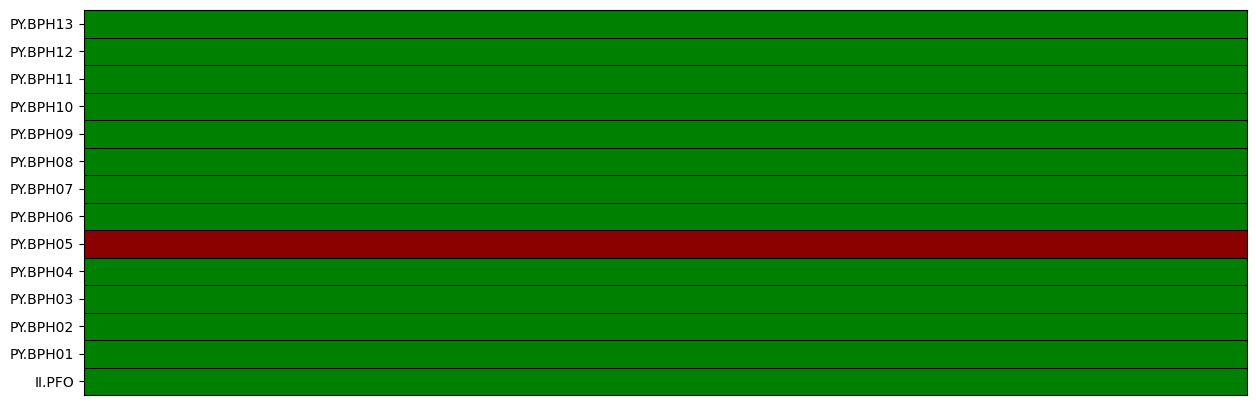


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-28T05:28:20.919539Z - 2023-01-28T05:29:20.919539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-28T05:28:20.919539Z - 2023-01-28T05:29:20.919539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-28T05:28:20.919539Z - 2023-01-28T05:29:20.919539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-28T05:28:20.919539Z - 2023-01-28T05:29:20.919539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-28T05:28:20.919539Z - 2023-01-28T05:29:20.919539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-28T05:28:20.919539Z - 2023-01-28T05:29:20.919539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-28T05:28:20.919539Z - 2023-01-28T05:29:20.919539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-28T05:28:20.919539Z - 2023-01-28T05:29:20.919539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-28T05:28:20.919539Z - 2023-01-28T05:29:20.919539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-28T05:28:20.919539Z - 2023-01-28T05:29:20.919539Z |


 -> 90 2023-01-28 08:37:03.310000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-28T08:36:48.308300Z - 2023-01-28T08:37:48.283300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-28T08:36:48.308300Z - 2023-01-28T08:37:48.283300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-28T08:36:48.308300Z - 2023-01-28T08:37:48.283300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


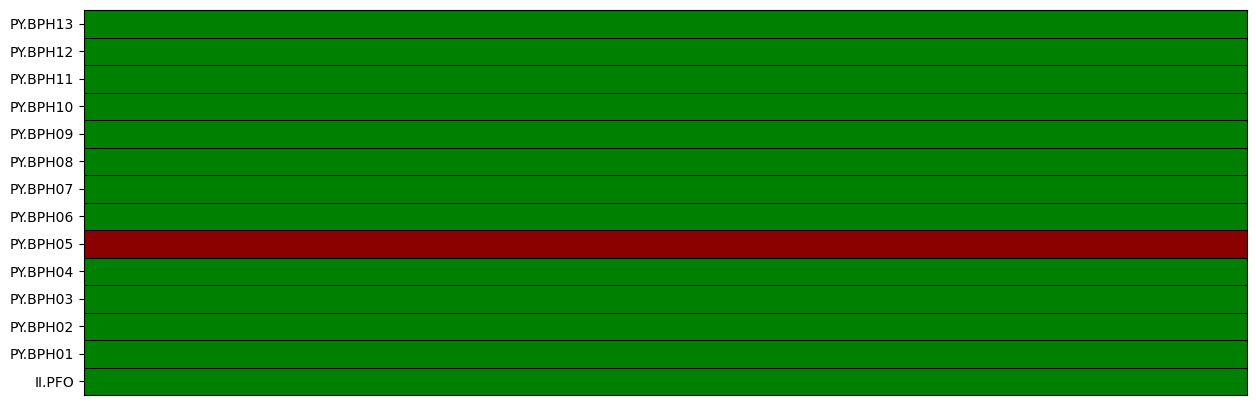


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-28T08:36:48.319539Z - 2023-01-28T08:37:48.319539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-28T08:36:48.319539Z - 2023-01-28T08:37:48.319539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-28T08:36:48.319539Z - 2023-01-28T08:37:48.319539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-28T08:36:48.319539Z - 2023-01-28T08:37:48.319539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-28T08:36:48.319539Z - 2023-01-28T08:37:48.319539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-28T08:36:48.319539Z - 2023-01-28T08:37:48.319539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-28T08:36:48.319539Z - 2023-01-28T08:37:48.319539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-28T08:36:48.319539Z - 2023-01-28T08:37:48.319539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-28T08:36:48.319539Z - 2023-01-28T08:37:48.319539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-28T08:36:48.319539Z - 2023-01-28T08:37:48.319539Z |


 -> 91 2023-01-29 18:12:03.480000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-29T18:11:48.478300Z - 2023-01-29T18:12:48.453300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-29T18:11:48.478300Z - 2023-01-29T18:12:48.453300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-29T18:11:48.478300Z - 2023-01-29T18:12:48.453300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


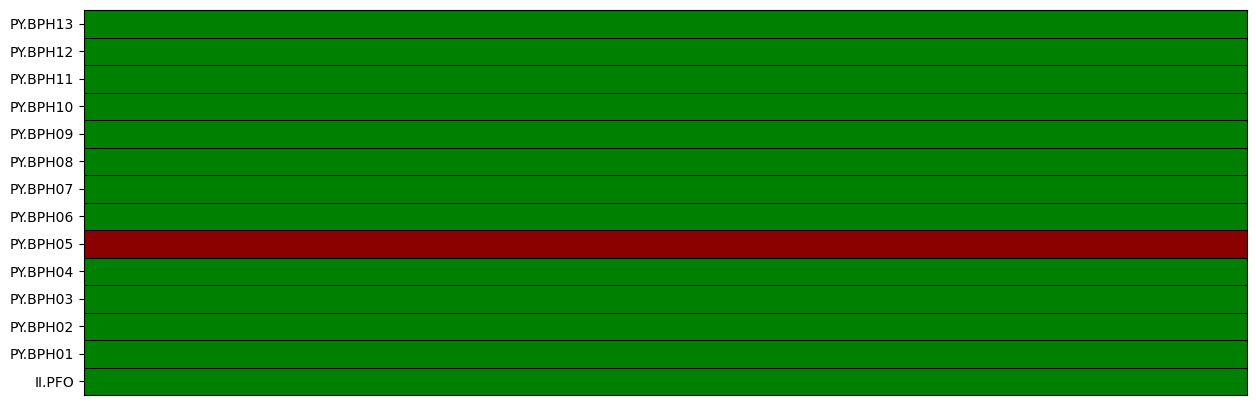


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-29T18:11:48.469536Z - 2023-01-29T18:12:48.469536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-29T18:11:48.469536Z - 2023-01-29T18:12:48.469536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-29T18:11:48.469536Z - 2023-01-29T18:12:48.469536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-29T18:11:48.469536Z - 2023-01-29T18:12:48.469536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-29T18:11:48.469536Z - 2023-01-29T18:12:48.469536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-29T18:11:48.469536Z - 2023-01-29T18:12:48.469536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-29T18:11:48.469536Z - 2023-01-29T18:12:48.469536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-29T18:11:48.469536Z - 2023-01-29T18:12:48.469536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-29T18:11:48.469536Z - 2023-01-29T18:12:48.469536Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-29T18:11:48.469536Z - 2023-01-29T18:12:48.469536Z |


 -> 92 2023-01-30 20:33:05.830000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-30T20:32:50.827700Z - 2023-01-30T20:33:50.802700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-30T20:32:50.827700Z - 2023-01-30T20:33:50.802700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-30T20:32:50.827700Z - 2023-01-30T20:33:50.802700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


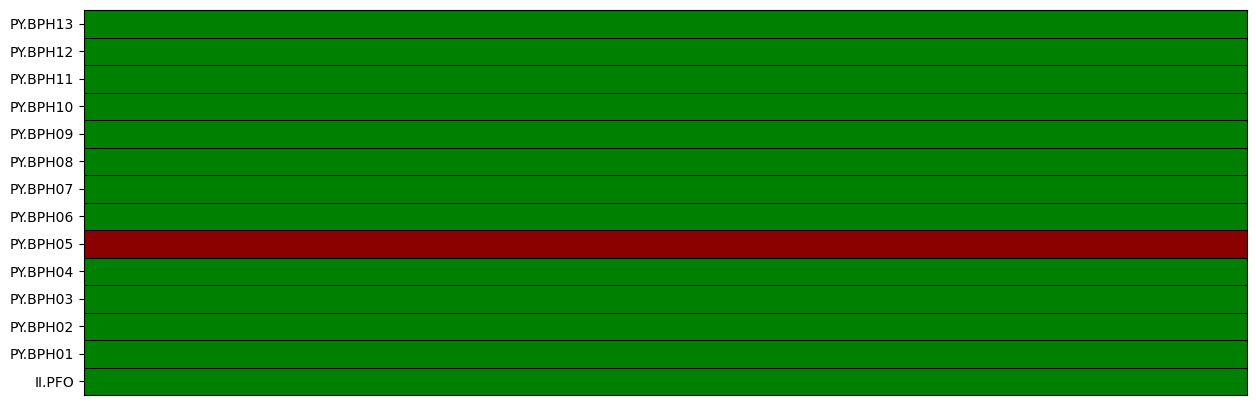


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-30T20:32:50.819538Z - 2023-01-30T20:33:50.819538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-30T20:32:50.819538Z - 2023-01-30T20:33:50.819538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-30T20:32:50.819538Z - 2023-01-30T20:33:50.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-30T20:32:50.819538Z - 2023-01-30T20:33:50.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-30T20:32:50.819538Z - 2023-01-30T20:33:50.819538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-30T20:32:50.819538Z - 2023-01-30T20:33:50.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-30T20:32:50.819538Z - 2023-01-30T20:33:50.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-30T20:32:50.819538Z - 2023-01-30T20:33:50.819538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-30T20:32:50.819538Z - 2023-01-30T20:33:50.819538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-30T20:32:50.819538Z - 2023-01-30T20:33:50.819538Z |


 -> 93 2023-01-31 12:56:19.980000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-01-31T12:56:04.982400Z - 2023-01-31T12:57:04.957400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-01-31T12:56:04.982400Z - 2023-01-31T12:57:04.957400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-01-31T12:56:04.982400Z - 2023-01-31T12:57:04.957400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


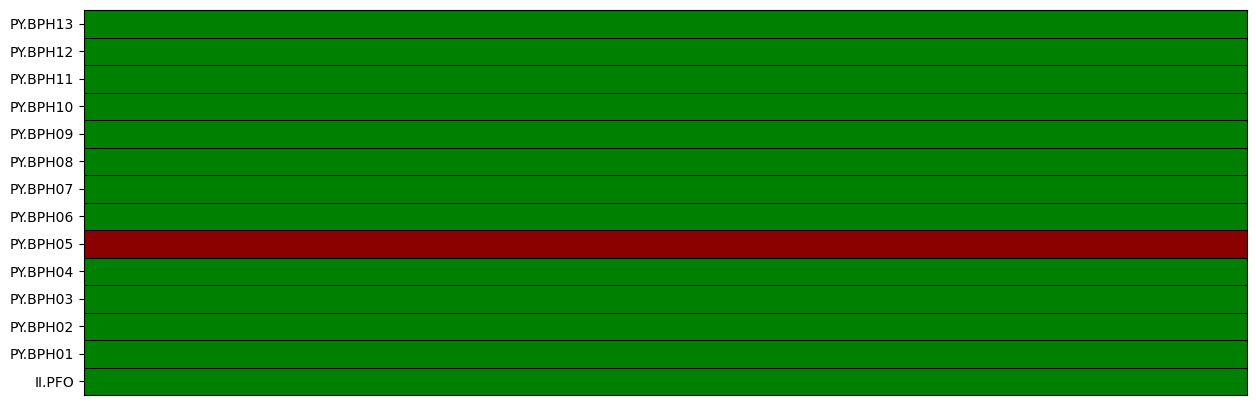


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-01-31T12:56:04.969538Z - 2023-01-31T12:57:04.969538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-01-31T12:56:04.969538Z - 2023-01-31T12:57:04.969538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-01-31T12:56:04.969538Z - 2023-01-31T12:57:04.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-01-31T12:56:04.969538Z - 2023-01-31T12:57:04.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-01-31T12:56:04.969538Z - 2023-01-31T12:57:04.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-01-31T12:56:04.969538Z - 2023-01-31T12:57:04.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-01-31T12:56:04.969538Z - 2023-01-31T12:57:04.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-01-31T12:56:04.969538Z - 2023-01-31T12:57:04.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-01-31T12:56:04.969538Z - 2023-01-31T12:57:04.969538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-01-31T12:56:04.969538Z - 2023-01-31T12:57:04.969538Z |


 -> 94 2023-02-01 09:05:02.320000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-01T09:04:47.322300Z - 2023-02-01T09:05:47.297300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-01T09:04:47.322300Z - 2023-02-01T09:05:47.297300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-01T09:04:47.322300Z - 2023-02-01T09:05:47.297300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


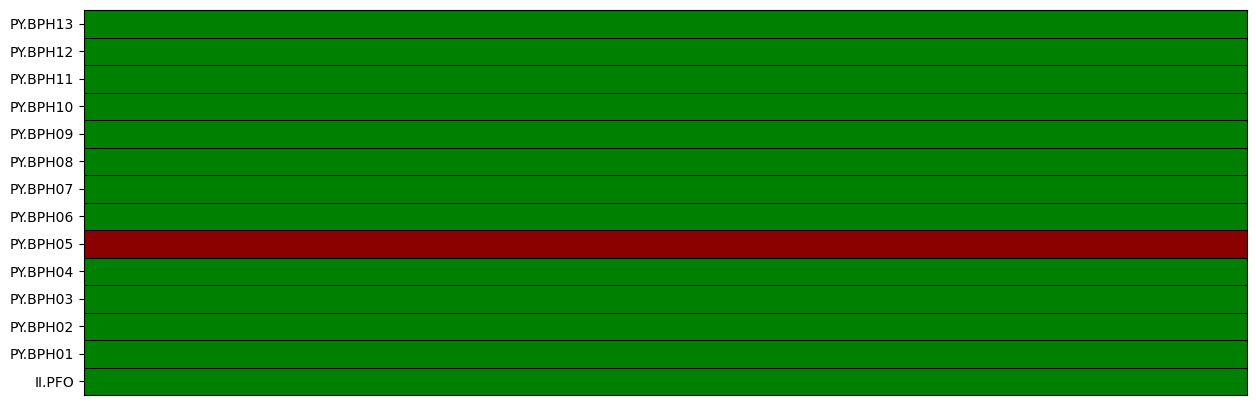


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-01T09:04:47.319538Z - 2023-02-01T09:05:47.319538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-01T09:04:47.319538Z - 2023-02-01T09:05:47.319538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-01T09:04:47.319538Z - 2023-02-01T09:05:47.319538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-01T09:04:47.319538Z - 2023-02-01T09:05:47.319538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-01T09:04:47.319538Z - 2023-02-01T09:05:47.319538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-01T09:04:47.319538Z - 2023-02-01T09:05:47.319538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-01T09:04:47.319538Z - 2023-02-01T09:05:47.319538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-01T09:04:47.319538Z - 2023-02-01T09:05:47.319538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-01T09:04:47.319538Z - 2023-02-01T09:05:47.319538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-01T09:04:47.319538Z - 2023-02-01T09:05:47.319538Z |


 -> 95 2023-02-01 09:19:10.710000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-01T09:18:55.712300Z - 2023-02-01T09:19:55.687300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-01T09:18:55.712300Z - 2023-02-01T09:19:55.687300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-01T09:18:55.712300Z - 2023-02-01T09:19:55.687300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


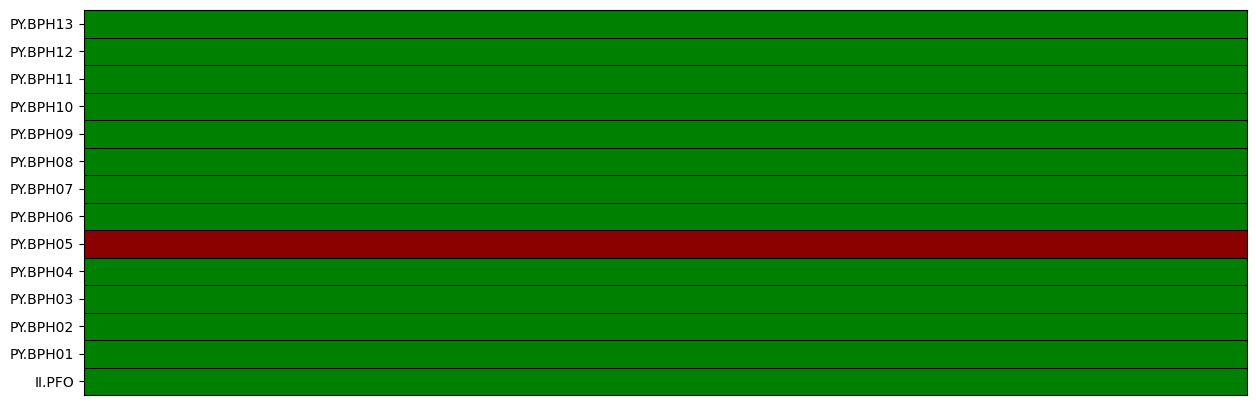


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-01T09:18:55.719538Z - 2023-02-01T09:19:55.719538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-01T09:18:55.719538Z - 2023-02-01T09:19:55.719538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-01T09:18:55.719538Z - 2023-02-01T09:19:55.719538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-01T09:18:55.719538Z - 2023-02-01T09:19:55.719538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-01T09:18:55.719538Z - 2023-02-01T09:19:55.719538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-01T09:18:55.719538Z - 2023-02-01T09:19:55.719538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-01T09:18:55.719538Z - 2023-02-01T09:19:55.719538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-01T09:18:55.719538Z - 2023-02-01T09:19:55.719538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-01T09:18:55.719538Z - 2023-02-01T09:19:55.719538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-01T09:18:55.719538Z - 2023-02-01T09:19:55.719538Z |


 -> 96 2023-02-02 05:54:33.150000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-02T05:54:18.147800Z - 2023-02-02T05:55:18.122800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-02T05:54:18.147800Z - 2023-02-02T05:55:18.122800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-02T05:54:18.147800Z - 2023-02-02T05:55:18.122800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


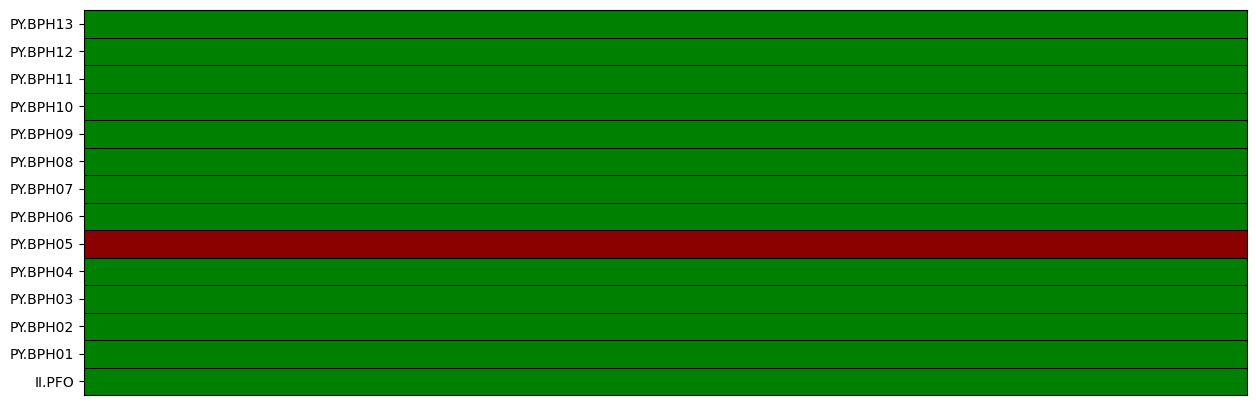


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-02T05:54:18.144539Z - 2023-02-02T05:55:18.144539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-02T05:54:18.144539Z - 2023-02-02T05:55:18.144539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-02T05:54:18.144539Z - 2023-02-02T05:55:18.144539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-02T05:54:18.144539Z - 2023-02-02T05:55:18.144539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-02T05:54:18.144539Z - 2023-02-02T05:55:18.144539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-02T05:54:18.144539Z - 2023-02-02T05:55:18.144539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-02T05:54:18.144539Z - 2023-02-02T05:55:18.144539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-02T05:54:18.144539Z - 2023-02-02T05:55:18.144539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-02T05:54:18.144539Z - 2023-02-02T05:55:18.144539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-02T05:54:18.144539Z - 2023-02-02T05:55:18.144539Z |


 -> 97 2023-02-02 23:44:54.580000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-02T23:44:39.577800Z - 2023-02-02T23:45:39.552800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-02T23:44:39.577800Z - 2023-02-02T23:45:39.552800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-02T23:44:39.577800Z - 2023-02-02T23:45:39.552800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


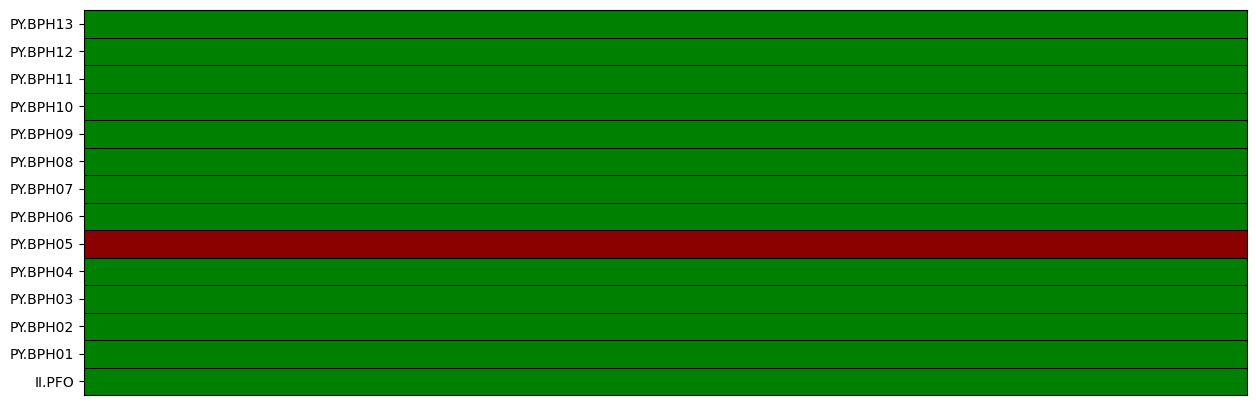


 -> Runtime: 0.77 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-02T23:44:39.569538Z - 2023-02-02T23:45:39.569538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-02T23:44:39.569538Z - 2023-02-02T23:45:39.569538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-02T23:44:39.569538Z - 2023-02-02T23:45:39.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-02T23:44:39.569538Z - 2023-02-02T23:45:39.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-02T23:44:39.569538Z - 2023-02-02T23:45:39.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-02T23:44:39.569538Z - 2023-02-02T23:45:39.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-02T23:44:39.569538Z - 2023-02-02T23:45:39.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-02T23:44:39.569538Z - 2023-02-02T23:45:39.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-02T23:44:39.569538Z - 2023-02-02T23:45:39.569538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-02T23:44:39.569538Z - 2023-02-02T23:45:39.569538Z |


 -> 98 2023-02-03 12:19:39.950000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-03T12:19:24.948000Z - 2023-02-03T12:20:24.923000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-03T12:19:24.948000Z - 2023-02-03T12:20:24.923000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-03T12:19:24.948000Z - 2023-02-03T12:20:24.923000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


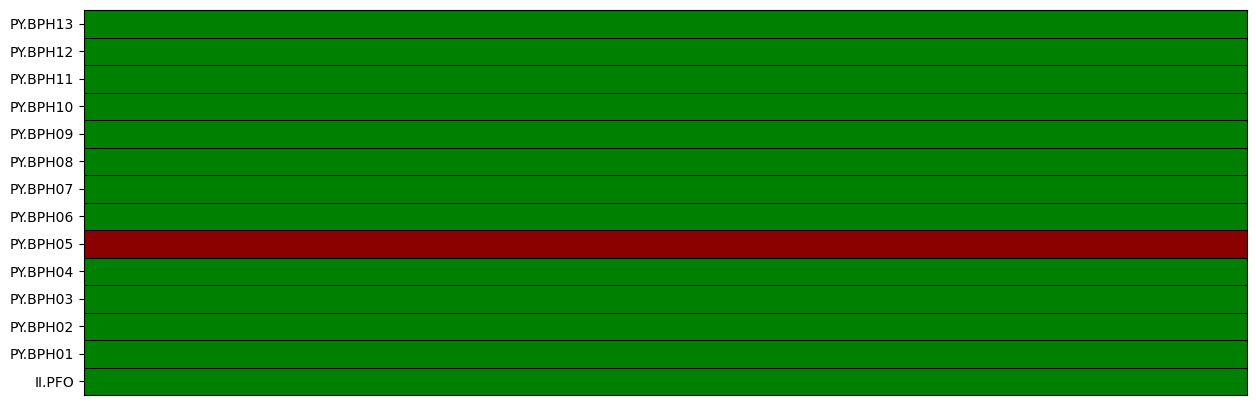


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-03T12:19:24.944538Z - 2023-02-03T12:20:24.944538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-03T12:19:24.944538Z - 2023-02-03T12:20:24.944538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-03T12:19:24.944538Z - 2023-02-03T12:20:24.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-03T12:19:24.944538Z - 2023-02-03T12:20:24.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-03T12:19:24.944538Z - 2023-02-03T12:20:24.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-03T12:19:24.944538Z - 2023-02-03T12:20:24.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-03T12:19:24.944538Z - 2023-02-03T12:20:24.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-03T12:19:24.944538Z - 2023-02-03T12:20:24.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-03T12:19:24.944538Z - 2023-02-03T12:20:24.944538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-03T12:19:24.944538Z - 2023-02-03T12:20:24.944538Z |


 -> 99 2023-02-04 19:49:37.680000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-04T19:49:22.677900Z - 2023-02-04T19:50:22.652900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-04T19:49:22.677900Z - 2023-02-04T19:50:22.652900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-04T19:49:22.677900Z - 2023-02-04T19:50:22.652900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


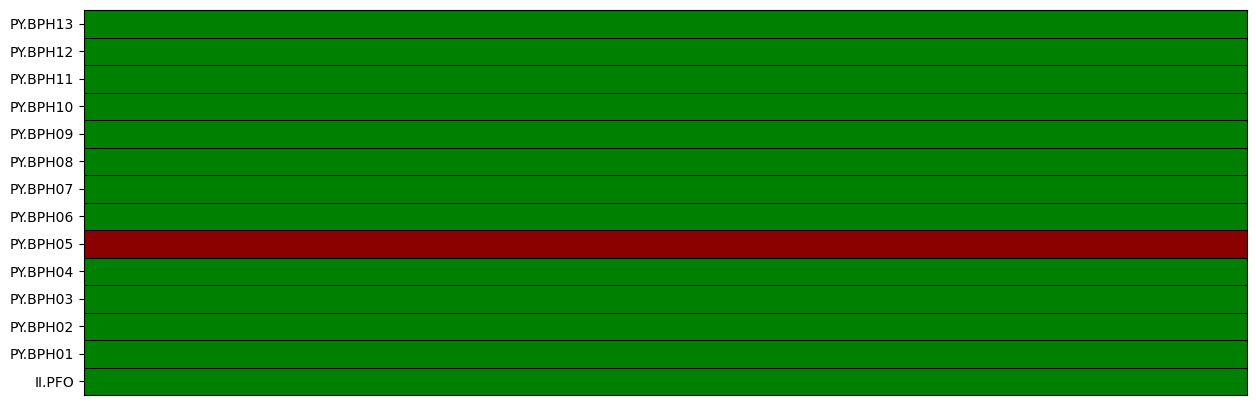


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-04T19:49:22.669538Z - 2023-02-04T19:50:22.669538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-04T19:49:22.669538Z - 2023-02-04T19:50:22.669538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-04T19:49:22.669538Z - 2023-02-04T19:50:22.669538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-04T19:49:22.669538Z - 2023-02-04T19:50:22.669538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-04T19:49:22.669538Z - 2023-02-04T19:50:22.669538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-04T19:49:22.669538Z - 2023-02-04T19:50:22.669538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-04T19:49:22.669538Z - 2023-02-04T19:50:22.669538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-04T19:49:22.669538Z - 2023-02-04T19:50:22.669538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-04T19:49:22.669538Z - 2023-02-04T19:50:22.669538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-04T19:49:22.669538Z - 2023-02-04T19:50:22.669538Z |


 -> 100 2023-02-05 09:25:44.970000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-05T09:25:29.968000Z - 2023-02-05T09:26:29.943000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-05T09:25:29.968000Z - 2023-02-05T09:26:29.943000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-05T09:25:29.968000Z - 2023-02-05T09:26:29.943000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


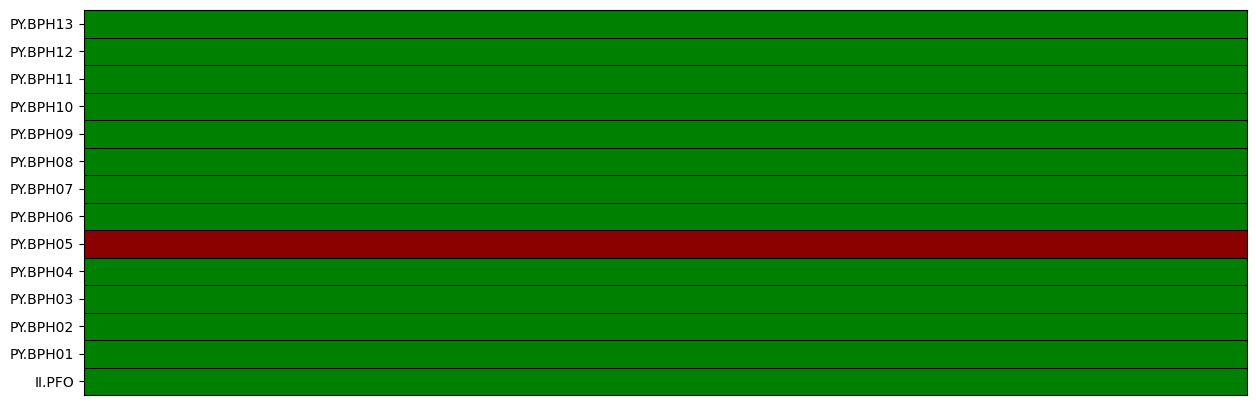


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-05T09:25:29.969536Z - 2023-02-05T09:26:29.969536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-05T09:25:29.969536Z - 2023-02-05T09:26:29.969536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-05T09:25:29.969536Z - 2023-02-05T09:26:29.969536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-05T09:25:29.969536Z - 2023-02-05T09:26:29.969536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-05T09:25:29.969536Z - 2023-02-05T09:26:29.969536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-05T09:25:29.969536Z - 2023-02-05T09:26:29.969536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-05T09:25:29.969536Z - 2023-02-05T09:26:29.969536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-05T09:25:29.969536Z - 2023-02-05T09:26:29.969536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-05T09:25:29.969536Z - 2023-02-05T09:26:29.969536Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-05T09:25:29.969536Z - 2023-02-05T09:26:29.969536Z |


 -> 101 2023-02-06 11:13:49.120000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-06T11:13:34.121700Z - 2023-02-06T11:14:34.096700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-06T11:13:34.121700Z - 2023-02-06T11:14:34.096700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-06T11:13:34.121700Z - 2023-02-06T11:14:34.096700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


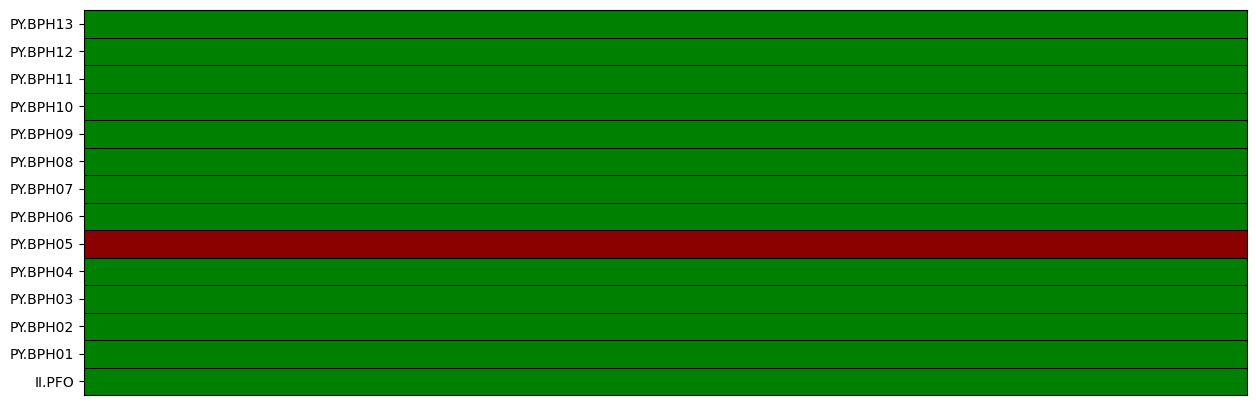


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-06T11:13:34.119538Z - 2023-02-06T11:14:34.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-06T11:13:34.119538Z - 2023-02-06T11:14:34.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-06T11:13:34.119538Z - 2023-02-06T11:14:34.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-06T11:13:34.119538Z - 2023-02-06T11:14:34.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-06T11:13:34.119538Z - 2023-02-06T11:14:34.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-06T11:13:34.119538Z - 2023-02-06T11:14:34.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-06T11:13:34.119538Z - 2023-02-06T11:14:34.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-06T11:13:34.119538Z - 2023-02-06T11:14:34.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-06T11:13:34.119538Z - 2023-02-06T11:14:34.119538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-06T11:13:34.119538Z - 2023-02-06T11:14:34.119538Z |


 -> 102 2023-02-06 19:34:45.510000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-06T19:34:30.511700Z - 2023-02-06T19:35:30.486700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-06T19:34:30.511700Z - 2023-02-06T19:35:30.486700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-06T19:34:30.511700Z - 2023-02-06T19:35:30.486700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


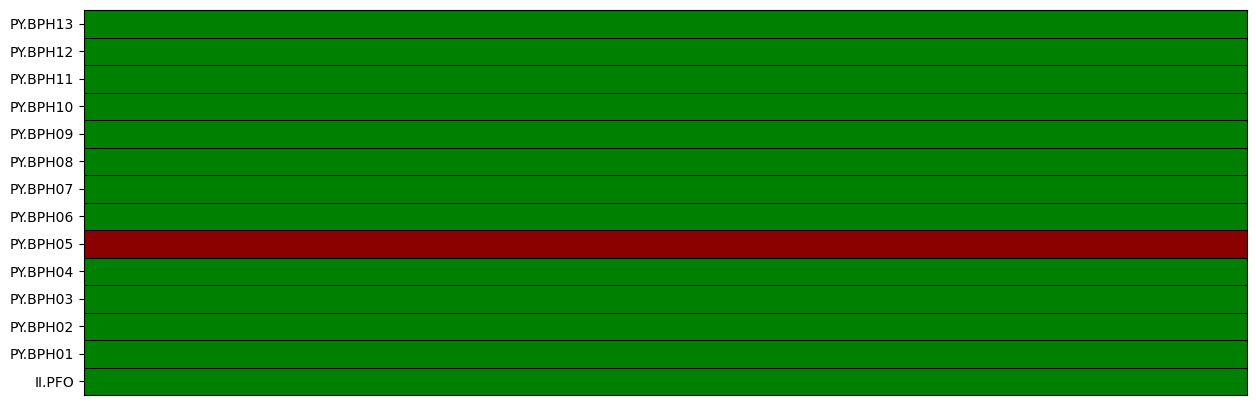


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-06T19:34:30.519538Z - 2023-02-06T19:35:30.519538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-06T19:34:30.519538Z - 2023-02-06T19:35:30.519538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-06T19:34:30.519538Z - 2023-02-06T19:35:30.519538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-06T19:34:30.519538Z - 2023-02-06T19:35:30.519538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-06T19:34:30.519538Z - 2023-02-06T19:35:30.519538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-06T19:34:30.519538Z - 2023-02-06T19:35:30.519538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-06T19:34:30.519538Z - 2023-02-06T19:35:30.519538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-06T19:34:30.519538Z - 2023-02-06T19:35:30.519538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-06T19:34:30.519538Z - 2023-02-06T19:35:30.519538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-06T19:34:30.519538Z - 2023-02-06T19:35:30.519538Z |


 -> 103 2023-02-08 17:14:33.500000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-08T17:14:18.502100Z - 2023-02-08T17:15:18.477100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-08T17:14:18.502100Z - 2023-02-08T17:15:18.477100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-08T17:14:18.502100Z - 2023-02-08T17:15:18.477100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


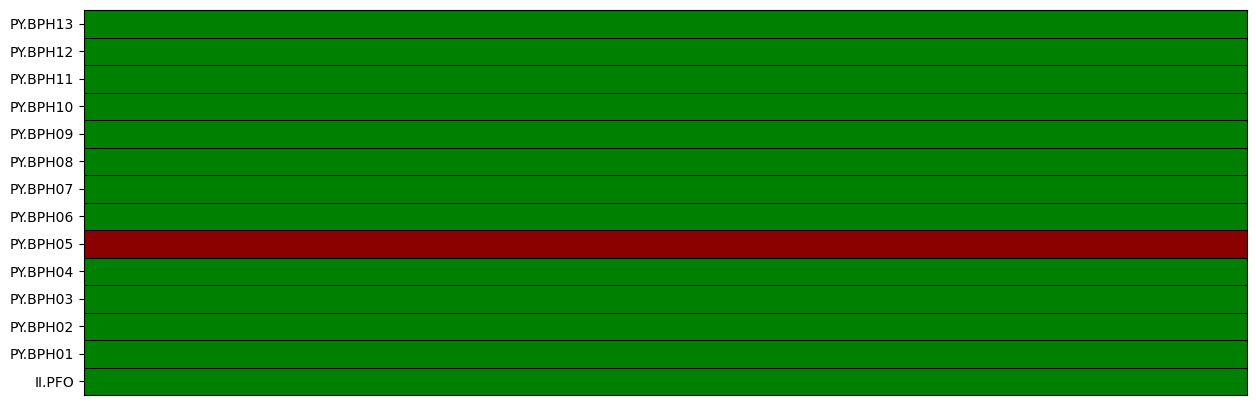


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.4 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-08T17:14:18.494538Z - 2023-02-08T17:15:18.494538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-08T17:14:18.494538Z - 2023-02-08T17:15:18.494538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-08T17:14:18.494538Z - 2023-02-08T17:15:18.494538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-08T17:14:18.494538Z - 2023-02-08T17:15:18.494538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-08T17:14:18.494538Z - 2023-02-08T17:15:18.494538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-08T17:14:18.494538Z - 2023-02-08T17:15:18.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-08T17:14:18.494538Z - 2023-02-08T17:15:18.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-08T17:14:18.494538Z - 2023-02-08T17:15:18.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-08T17:14:18.494538Z - 2023-02-08T17:15:18.494538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-08T17:14:18.494538Z - 2023-02-08T17:15:18.494538Z |


 -> 104 2023-02-08 17:58:32.450000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-08T17:58:17.452100Z - 2023-02-08T17:59:17.427100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-08T17:58:17.452100Z - 2023-02-08T17:59:17.427100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-08T17:58:17.452000Z - 2023-02-08T17:59:17.427000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


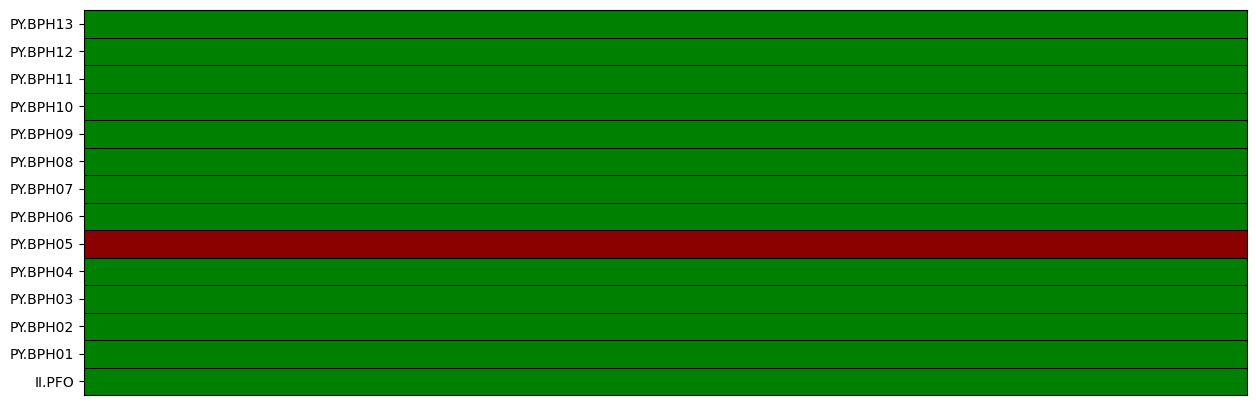


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-08T17:58:17.444538Z - 2023-02-08T17:59:17.444538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-08T17:58:17.444538Z - 2023-02-08T17:59:17.444538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-08T17:58:17.444538Z - 2023-02-08T17:59:17.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-08T17:58:17.444538Z - 2023-02-08T17:59:17.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-08T17:58:17.444538Z - 2023-02-08T17:59:17.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-08T17:58:17.444538Z - 2023-02-08T17:59:17.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-08T17:58:17.444538Z - 2023-02-08T17:59:17.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-08T17:58:17.444538Z - 2023-02-08T17:59:17.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-08T17:58:17.444538Z - 2023-02-08T17:59:17.444538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-08T17:58:17.444538Z - 2023-02-08T17:59:17.444538Z |


 -> 105 2023-02-08 18:05:42.840000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-08T18:05:27.842100Z - 2023-02-08T18:06:27.817100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-08T18:05:27.842000Z - 2023-02-08T18:06:27.817000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-08T18:05:27.842000Z - 2023-02-08T18:06:27.817000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


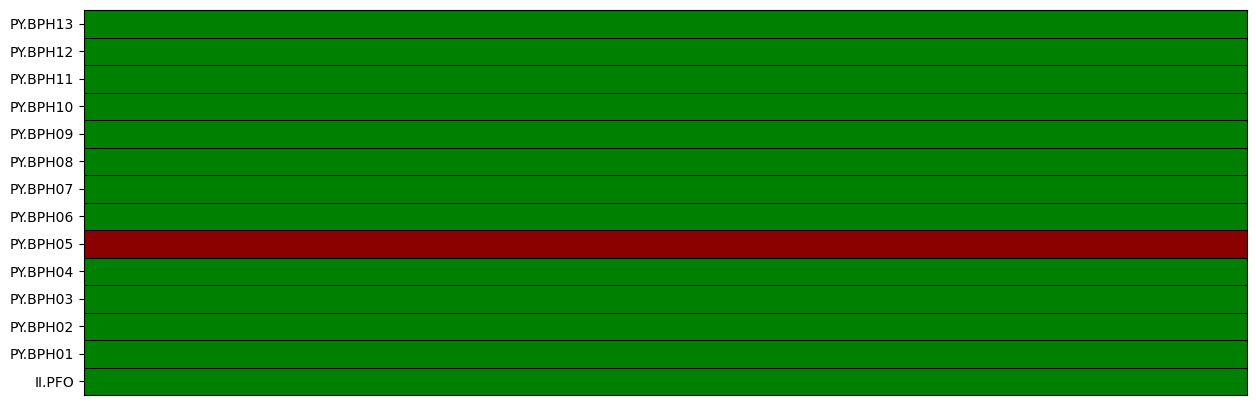


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-08T18:05:27.844538Z - 2023-02-08T18:06:27.844538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-08T18:05:27.844538Z - 2023-02-08T18:06:27.844538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-08T18:05:27.844538Z - 2023-02-08T18:06:27.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-08T18:05:27.844538Z - 2023-02-08T18:06:27.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-08T18:05:27.844538Z - 2023-02-08T18:06:27.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-08T18:05:27.844538Z - 2023-02-08T18:06:27.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-08T18:05:27.844538Z - 2023-02-08T18:06:27.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-08T18:05:27.844538Z - 2023-02-08T18:06:27.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-08T18:05:27.844538Z - 2023-02-08T18:06:27.844538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-08T18:05:27.844538Z - 2023-02-08T18:06:27.844538Z |


 -> 106 2023-02-11 15:48:10.640000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-11T15:47:55.641800Z - 2023-02-11T15:48:55.616800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-11T15:47:55.641800Z - 2023-02-11T15:48:55.616800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-11T15:47:55.641800Z - 2023-02-11T15:48:55.616800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


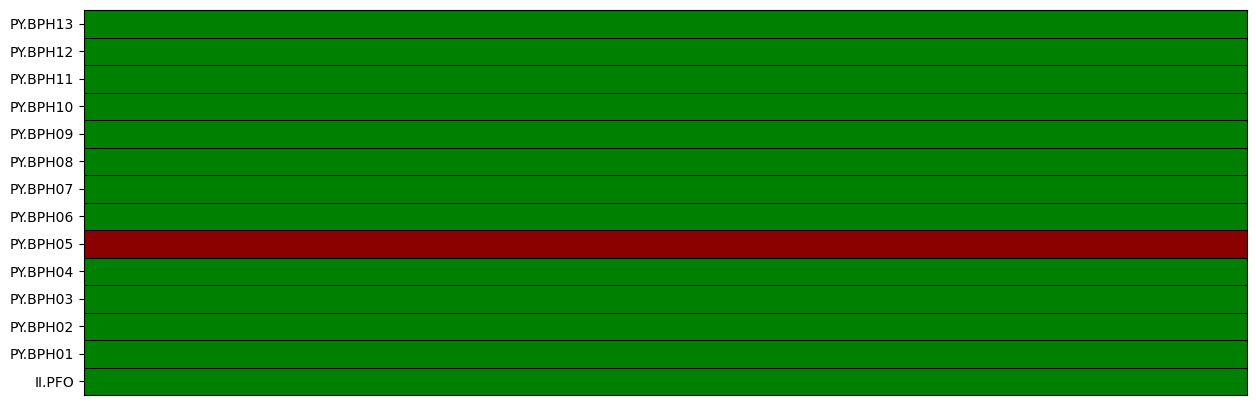


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-11T15:47:55.644538Z - 2023-02-11T15:48:55.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-11T15:47:55.644538Z - 2023-02-11T15:48:55.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-11T15:47:55.644538Z - 2023-02-11T15:48:55.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-11T15:47:55.644538Z - 2023-02-11T15:48:55.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-11T15:47:55.644538Z - 2023-02-11T15:48:55.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-11T15:47:55.644538Z - 2023-02-11T15:48:55.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-11T15:47:55.644538Z - 2023-02-11T15:48:55.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-11T15:47:55.644538Z - 2023-02-11T15:48:55.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-11T15:47:55.644538Z - 2023-02-11T15:48:55.644538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-11T15:47:55.644538Z - 2023-02-11T15:48:55.644538Z |


 -> 107 2023-02-14 04:32:58.930000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-14T04:32:43.931900Z - 2023-02-14T04:33:43.906900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-14T04:32:43.931900Z - 2023-02-14T04:33:43.906900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-14T04:32:43.931900Z - 2023-02-14T04:33:43.906900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


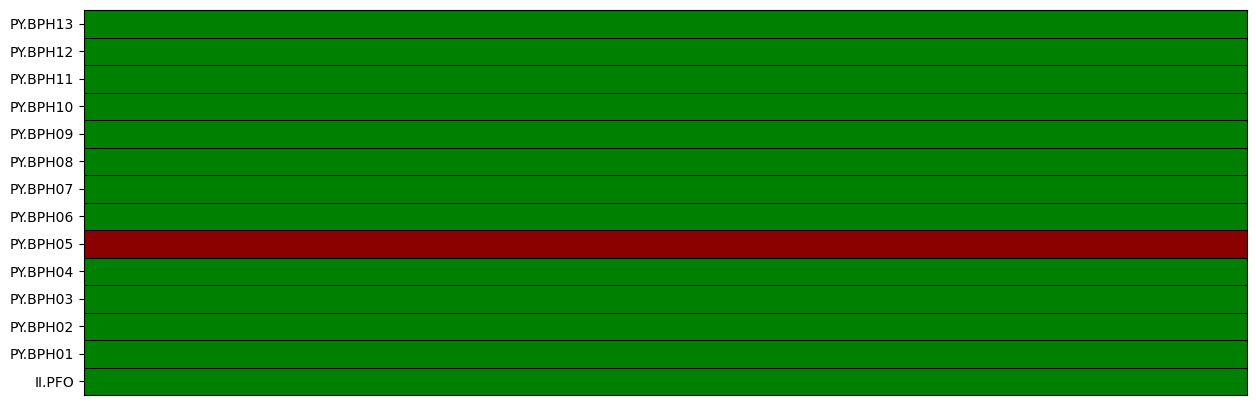


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-14T04:32:43.919538Z - 2023-02-14T04:33:43.919538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-14T04:32:43.919538Z - 2023-02-14T04:33:43.919538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-14T04:32:43.919538Z - 2023-02-14T04:33:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-14T04:32:43.919538Z - 2023-02-14T04:33:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-14T04:32:43.919538Z - 2023-02-14T04:33:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-14T04:32:43.919538Z - 2023-02-14T04:33:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-14T04:32:43.919538Z - 2023-02-14T04:33:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-14T04:32:43.919538Z - 2023-02-14T04:33:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-14T04:32:43.919538Z - 2023-02-14T04:33:43.919538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-14T04:32:43.919538Z - 2023-02-14T04:33:43.919538Z |


 -> 108 2023-02-15 16:11:50.790000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-15T16:11:35.791900Z - 2023-02-15T16:12:35.766900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-15T16:11:35.791900Z - 2023-02-15T16:12:35.766900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-15T16:11:35.791900Z - 2023-02-15T16:12:35.766900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


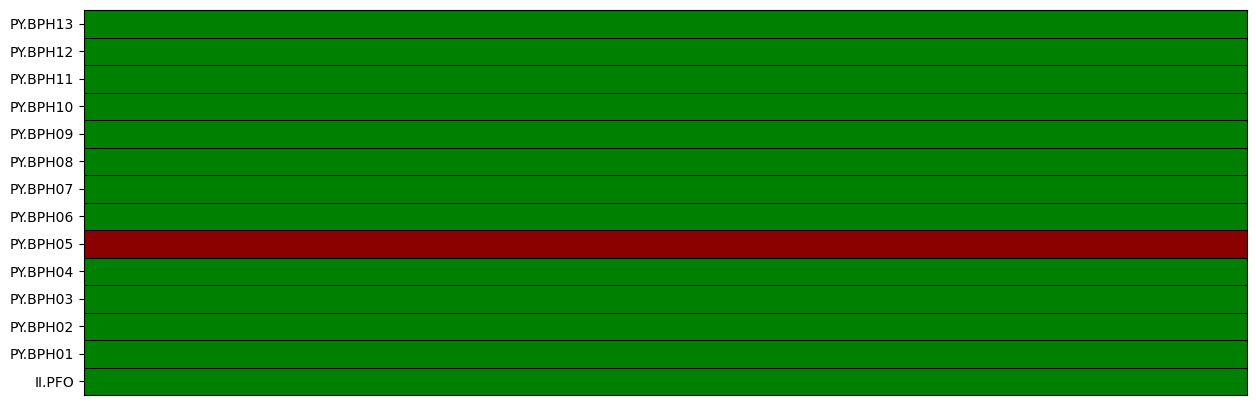


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-15T16:11:35.794538Z - 2023-02-15T16:12:35.794538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-15T16:11:35.794538Z - 2023-02-15T16:12:35.794538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-15T16:11:35.794538Z - 2023-02-15T16:12:35.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-15T16:11:35.794538Z - 2023-02-15T16:12:35.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-15T16:11:35.794538Z - 2023-02-15T16:12:35.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-15T16:11:35.794538Z - 2023-02-15T16:12:35.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-15T16:11:35.794538Z - 2023-02-15T16:12:35.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-15T16:11:35.794538Z - 2023-02-15T16:12:35.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-15T16:11:35.794538Z - 2023-02-15T16:12:35.794538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-15T16:11:35.794538Z - 2023-02-15T16:12:35.794538Z |


 -> 109 2023-02-17 04:50:36.270000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-17T04:50:21.271900Z - 2023-02-17T04:51:21.246900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-17T04:50:21.271900Z - 2023-02-17T04:51:21.246900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-17T04:50:21.271900Z - 2023-02-17T04:51:21.246900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


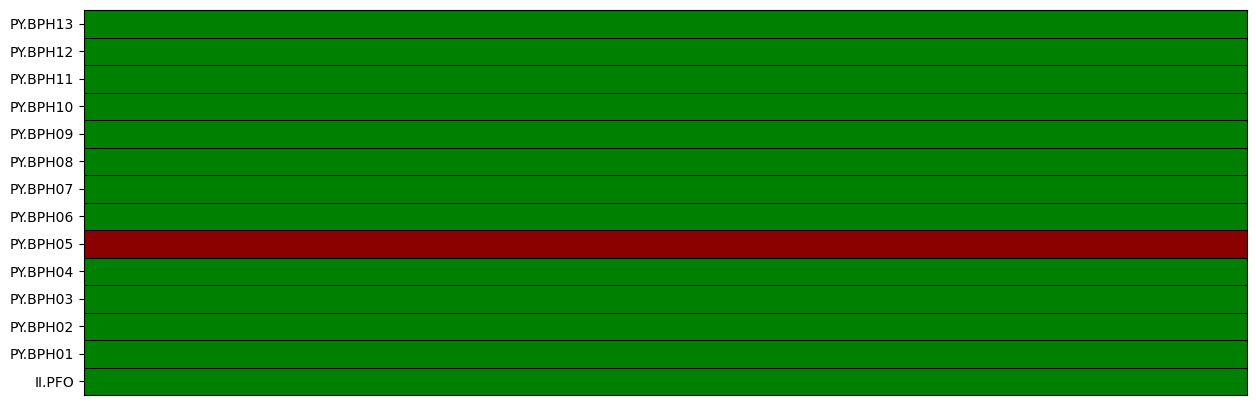


 -> Runtime: 0.74 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-17T04:50:21.269538Z - 2023-02-17T04:51:21.269538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-17T04:50:21.269538Z - 2023-02-17T04:51:21.269538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-17T04:50:21.269538Z - 2023-02-17T04:51:21.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-17T04:50:21.269538Z - 2023-02-17T04:51:21.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-17T04:50:21.269538Z - 2023-02-17T04:51:21.269538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-17T04:50:21.269538Z - 2023-02-17T04:51:21.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-17T04:50:21.269538Z - 2023-02-17T04:51:21.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-17T04:50:21.269538Z - 2023-02-17T04:51:21.269538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-17T04:50:21.269538Z - 2023-02-17T04:51:21.269538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-17T04:50:21.269538Z - 2023-02-17T04:51:21.269538Z |


 -> 110 2023-02-17 10:43:21.030000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-17T10:43:06.031900Z - 2023-02-17T10:44:06.006900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-17T10:43:06.031900Z - 2023-02-17T10:44:06.006900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-17T10:43:06.031900Z - 2023-02-17T10:44:06.006900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


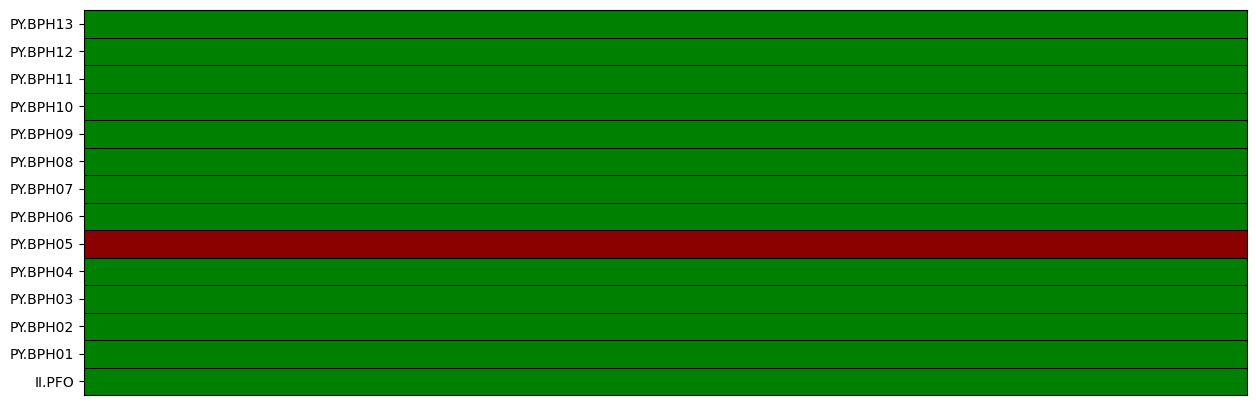


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-17T10:43:06.019538Z - 2023-02-17T10:44:06.019538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-17T10:43:06.019538Z - 2023-02-17T10:44:06.019538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-17T10:43:06.019538Z - 2023-02-17T10:44:06.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-17T10:43:06.019538Z - 2023-02-17T10:44:06.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-17T10:43:06.019538Z - 2023-02-17T10:44:06.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-17T10:43:06.019538Z - 2023-02-17T10:44:06.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-17T10:43:06.019538Z - 2023-02-17T10:44:06.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-17T10:43:06.019538Z - 2023-02-17T10:44:06.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-17T10:43:06.019538Z - 2023-02-17T10:44:06.019538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-17T10:43:06.019538Z - 2023-02-17T10:44:06.019538Z |


 -> 111 2023-02-21 08:25:58.800000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-21T08:25:43.802500Z - 2023-02-21T08:26:43.777500Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-21T08:25:43.802500Z - 2023-02-21T08:26:43.777500Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-21T08:25:43.802500Z - 2023-02-21T08:26:43.777500Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


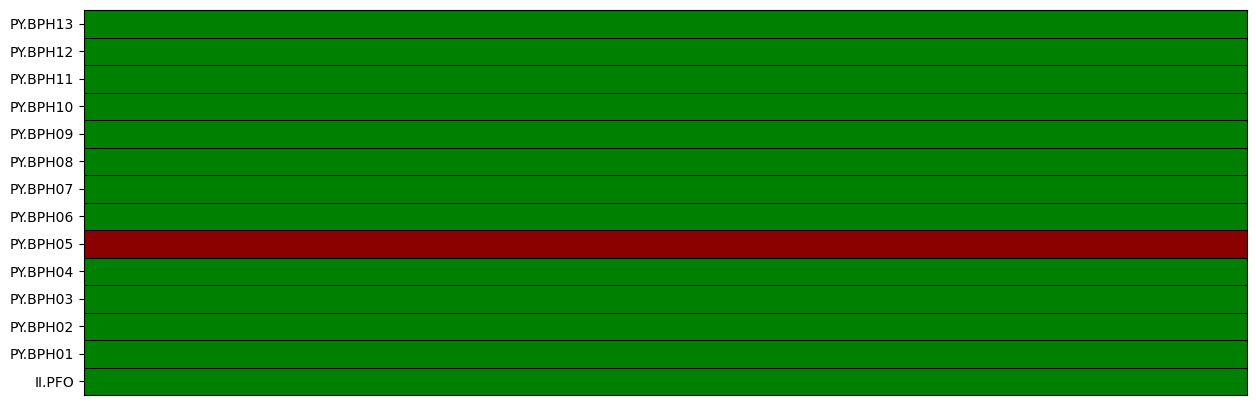


 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-21T08:25:43.794538Z - 2023-02-21T08:26:43.794538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-21T08:25:43.794538Z - 2023-02-21T08:26:43.794538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-21T08:25:43.794538Z - 2023-02-21T08:26:43.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-21T08:25:43.794538Z - 2023-02-21T08:26:43.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-21T08:25:43.794538Z - 2023-02-21T08:26:43.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-21T08:25:43.794538Z - 2023-02-21T08:26:43.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-21T08:25:43.794538Z - 2023-02-21T08:26:43.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-21T08:25:43.794538Z - 2023-02-21T08:26:43.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-21T08:25:43.794538Z - 2023-02-21T08:26:43.794538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-21T08:25:43.794538Z - 2023-02-21T08:26:43.794538Z |


 -> 112 2023-02-21 19:28:47.220000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-21T19:28:32.222500Z - 2023-02-21T19:29:32.197500Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-21T19:28:32.222500Z - 2023-02-21T19:29:32.197500Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-21T19:28:32.222500Z - 2023-02-21T19:29:32.197500Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


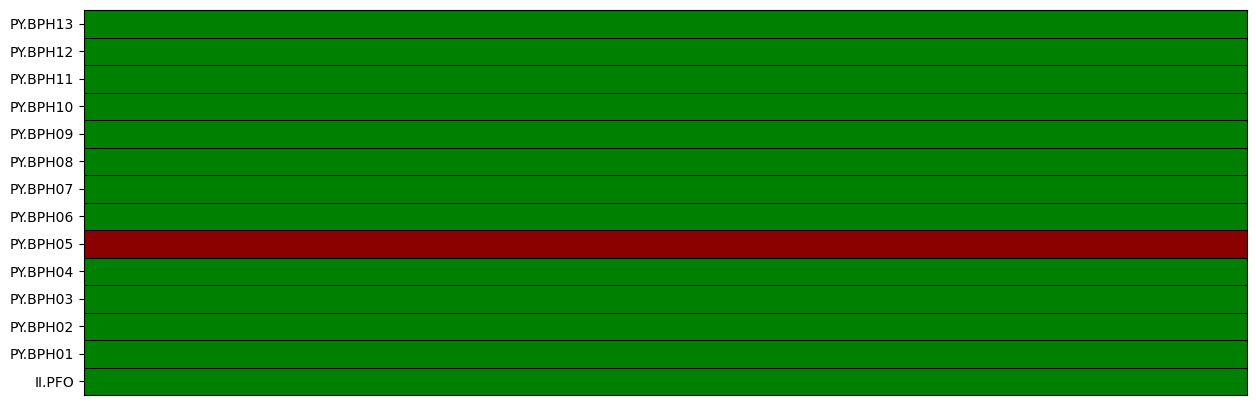


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-21T19:28:32.219538Z - 2023-02-21T19:29:32.219538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-21T19:28:32.219538Z - 2023-02-21T19:29:32.219538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-21T19:28:32.219538Z - 2023-02-21T19:29:32.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-21T19:28:32.219538Z - 2023-02-21T19:29:32.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-21T19:28:32.219538Z - 2023-02-21T19:29:32.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-21T19:28:32.219538Z - 2023-02-21T19:29:32.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-21T19:28:32.219538Z - 2023-02-21T19:29:32.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-21T19:28:32.219538Z - 2023-02-21T19:29:32.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-21T19:28:32.219538Z - 2023-02-21T19:29:32.219538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-21T19:28:32.219538Z - 2023-02-21T19:29:32.219538Z |


 -> 113 2023-02-22 00:01:22.710000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-22T00:01:07.712400Z - 2023-02-22T00:02:07.687400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-22T00:01:07.712400Z - 2023-02-22T00:02:07.687400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-22T00:01:07.712400Z - 2023-02-22T00:02:07.687400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


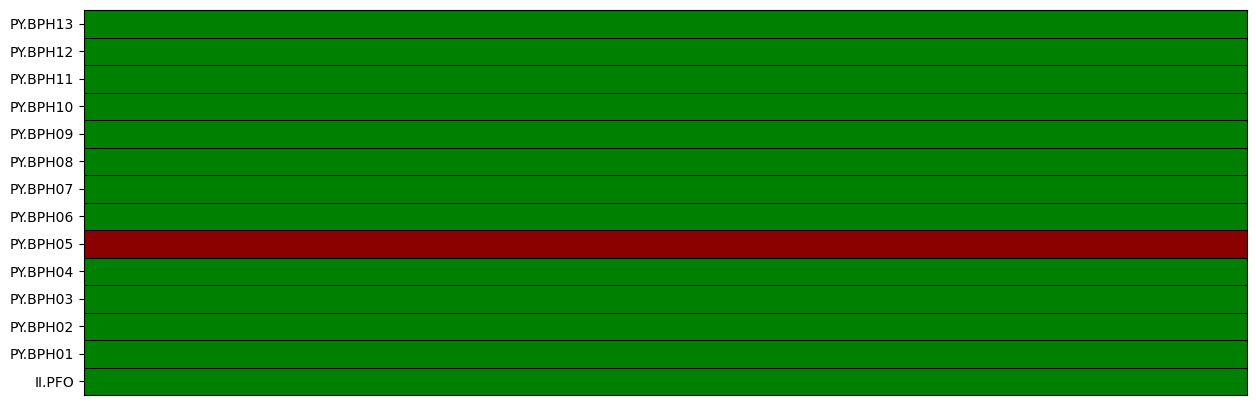


 -> Runtime: 0.74 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-22T00:01:07.719538Z - 2023-02-22T00:02:07.719538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-22T00:01:07.719538Z - 2023-02-22T00:02:07.719538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-22T00:01:07.719538Z - 2023-02-22T00:02:07.719538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-22T00:01:07.719538Z - 2023-02-22T00:02:07.719538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-22T00:01:07.719538Z - 2023-02-22T00:02:07.719538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-22T00:01:07.719538Z - 2023-02-22T00:02:07.719538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-22T00:01:07.719538Z - 2023-02-22T00:02:07.719538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-22T00:01:07.719538Z - 2023-02-22T00:02:07.719538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-22T00:01:07.719538Z - 2023-02-22T00:02:07.719538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-22T00:01:07.719538Z - 2023-02-22T00:02:07.719538Z |


 -> 114 2023-02-23 00:04:29.490000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-23T00:04:14.492400Z - 2023-02-23T00:05:14.467400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-23T00:04:14.492400Z - 2023-02-23T00:05:14.467400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-23T00:04:14.492400Z - 2023-02-23T00:05:14.467400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


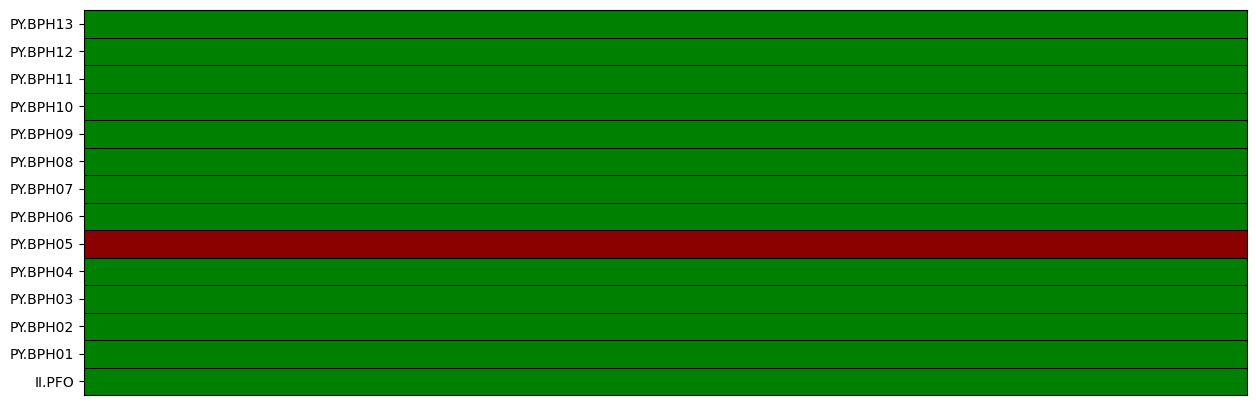


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-23T00:04:14.494539Z - 2023-02-23T00:05:14.494539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-23T00:04:14.494539Z - 2023-02-23T00:05:14.494539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-23T00:04:14.494539Z - 2023-02-23T00:05:14.494539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-23T00:04:14.494539Z - 2023-02-23T00:05:14.494539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-23T00:04:14.494539Z - 2023-02-23T00:05:14.494539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-23T00:04:14.494539Z - 2023-02-23T00:05:14.494539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-23T00:04:14.494539Z - 2023-02-23T00:05:14.494539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-23T00:04:14.494539Z - 2023-02-23T00:05:14.494539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-23T00:04:14.494539Z - 2023-02-23T00:05:14.494539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-23T00:04:14.494539Z - 2023-02-23T00:05:14.494539Z |


 -> 115 2023-02-24 13:01:57.860000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-24T13:01:42.862300Z - 2023-02-24T13:02:42.837300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-24T13:01:42.862300Z - 2023-02-24T13:02:42.837300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-24T13:01:42.862300Z - 2023-02-24T13:02:42.837300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


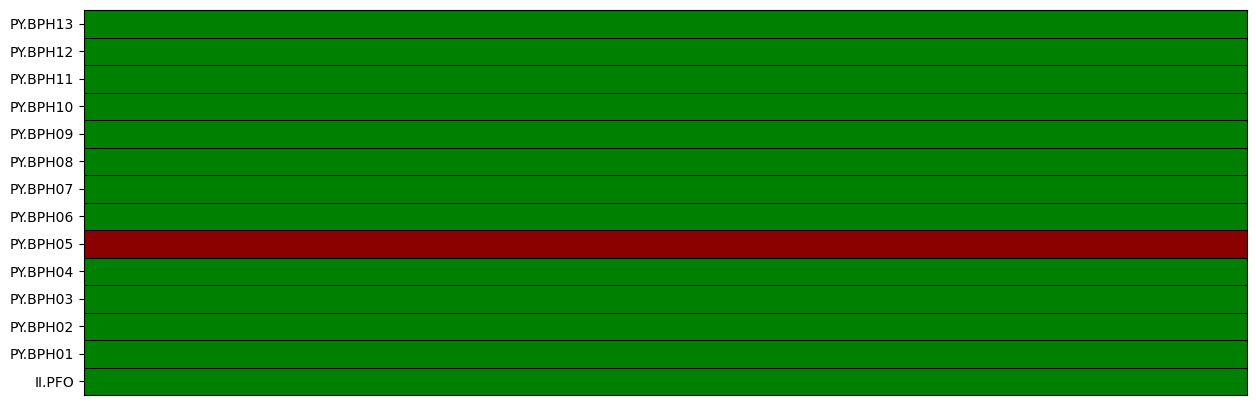


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-24T13:01:42.869538Z - 2023-02-24T13:02:42.869538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-24T13:01:42.869538Z - 2023-02-24T13:02:42.869538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-24T13:01:42.869538Z - 2023-02-24T13:02:42.869538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-24T13:01:42.869538Z - 2023-02-24T13:02:42.869538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-24T13:01:42.869538Z - 2023-02-24T13:02:42.869538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-24T13:01:42.869538Z - 2023-02-24T13:02:42.869538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-24T13:01:42.869538Z - 2023-02-24T13:02:42.869538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-24T13:01:42.869538Z - 2023-02-24T13:02:42.869538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-24T13:01:42.869538Z - 2023-02-24T13:02:42.869538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-24T13:01:42.869538Z - 2023-02-24T13:02:42.869538Z |


 -> 116 2023-02-27 06:01:40.160000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-27T06:01:25.162300Z - 2023-02-27T06:02:25.137300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-27T06:01:25.162300Z - 2023-02-27T06:02:25.137300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-27T06:01:25.162300Z - 2023-02-27T06:02:25.137300Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


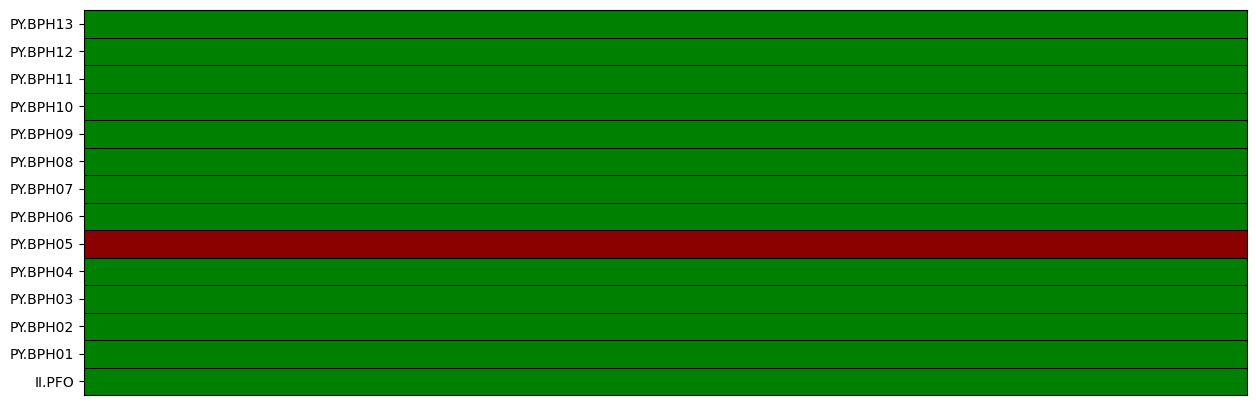


 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-27T06:01:25.169538Z - 2023-02-27T06:02:25.169538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-27T06:01:25.169538Z - 2023-02-27T06:02:25.169538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-27T06:01:25.169538Z - 2023-02-27T06:02:25.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-27T06:01:25.169538Z - 2023-02-27T06:02:25.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-27T06:01:25.169538Z - 2023-02-27T06:02:25.169538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-27T06:01:25.169538Z - 2023-02-27T06:02:25.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-27T06:01:25.169538Z - 2023-02-27T06:02:25.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-27T06:01:25.169538Z - 2023-02-27T06:02:25.169538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-27T06:01:25.169538Z - 2023-02-27T06:02:25.169538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-27T06:01:25.169538Z - 2023-02-27T06:02:25.169538Z |


 -> 117 2023-02-28 05:02:31.330000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-02-28T05:02:16.332400Z - 2023-02-28T05:03:16.307400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-02-28T05:02:16.332400Z - 2023-02-28T05:03:16.307400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-02-28T05:02:16.332400Z - 2023-02-28T05:03:16.307400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


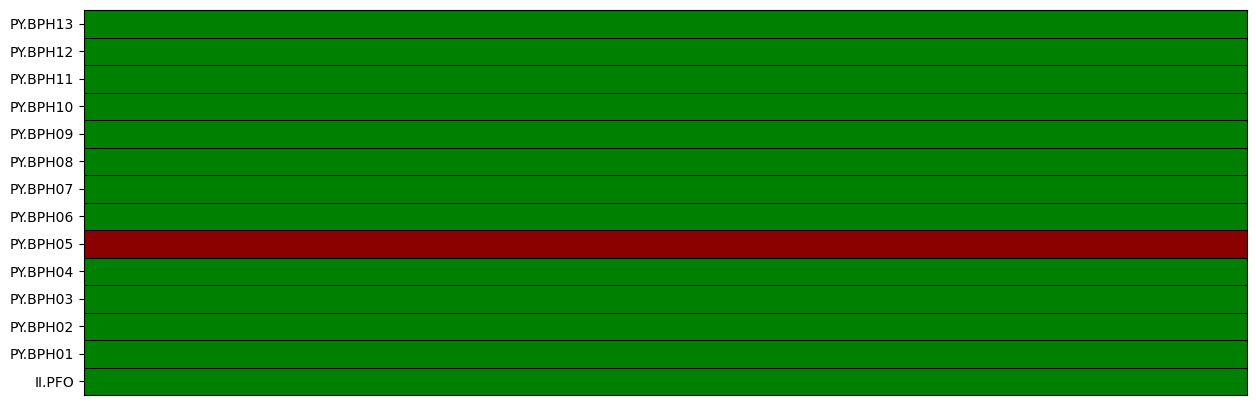


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-02-28T05:02:16.319536Z - 2023-02-28T05:03:16.319536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-02-28T05:02:16.319536Z - 2023-02-28T05:03:16.319536Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-02-28T05:02:16.319538Z - 2023-02-28T05:03:16.319538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-02-28T05:02:16.319536Z - 2023-02-28T05:03:16.319536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-02-28T05:02:16.319536Z - 2023-02-28T05:03:16.319536Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-02-28T05:02:16.319538Z - 2023-02-28T05:03:16.319538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-02-28T05:02:16.319536Z - 2023-02-28T05:03:16.319536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-02-28T05:02:16.319536Z - 2023-02-28T05:03:16.319536Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-02-28T05:02:16.319538Z - 2023-02-28T05:03:16.319538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-02-28T05:02:16.319536Z - 2023-02-28T05:03:16.319536Z |


 -> 118 2023-03-01 22:44:47.140000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-01T22:44:32.142400Z - 2023-03-01T22:45:32.117400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-01T22:44:32.142400Z - 2023-03-01T22:45:32.117400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-01T22:44:32.142400Z - 2023-03-01T22:45:32.117400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


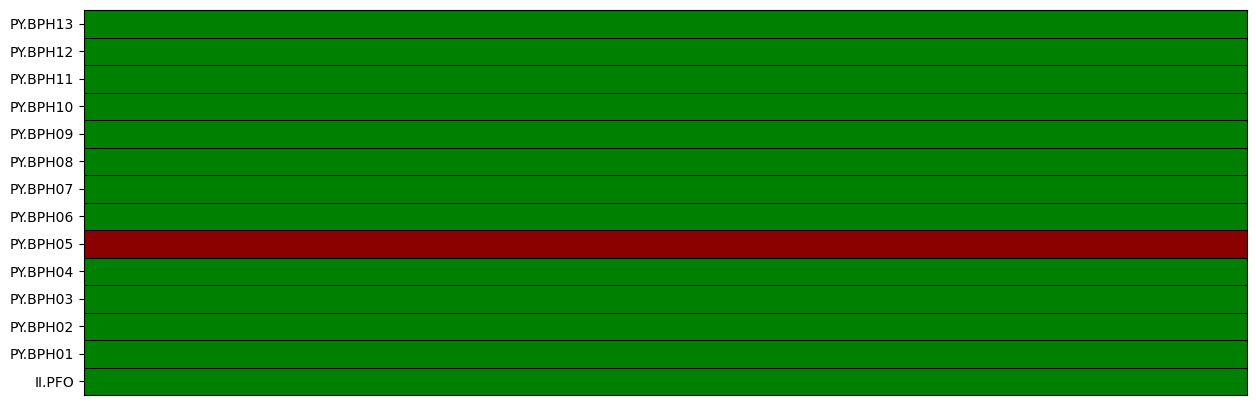


 -> Runtime: 0.74 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.47 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-01T22:44:32.144538Z - 2023-03-01T22:45:32.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-01T22:44:32.144538Z - 2023-03-01T22:45:32.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-01T22:44:32.144538Z - 2023-03-01T22:45:32.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-01T22:44:32.144538Z - 2023-03-01T22:45:32.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-01T22:44:32.144538Z - 2023-03-01T22:45:32.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-01T22:44:32.144538Z - 2023-03-01T22:45:32.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-01T22:44:32.144538Z - 2023-03-01T22:45:32.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-01T22:44:32.144538Z - 2023-03-01T22:45:32.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-01T22:44:32.144538Z - 2023-03-01T22:45:32.144538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-01T22:44:32.144538Z - 2023-03-01T22:45:32.144538Z |


 -> 119 2023-03-01 22:49:03.580000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-01T22:48:48.582400Z - 2023-03-01T22:49:48.557400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-01T22:48:48.582400Z - 2023-03-01T22:49:48.557400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-01T22:48:48.582400Z - 2023-03-01T22:49:48.557400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


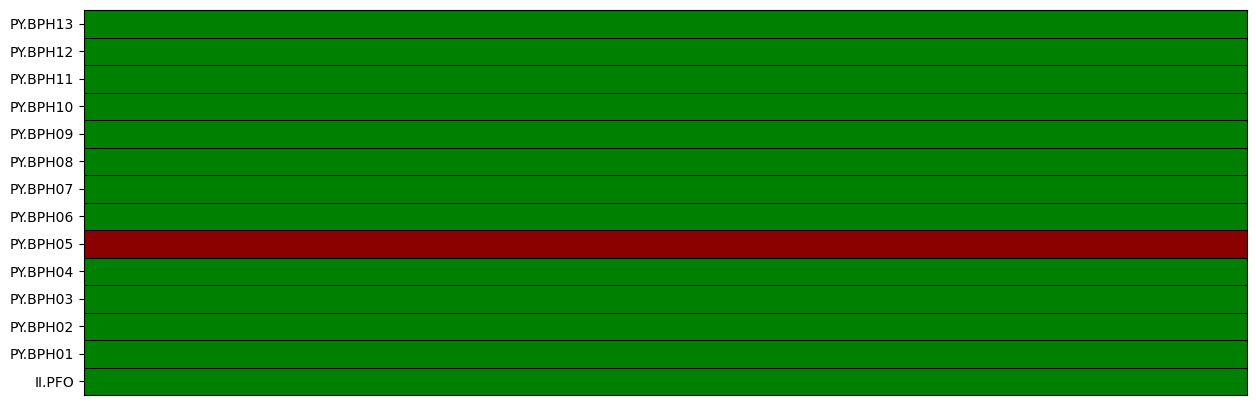


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-01T22:48:48.569538Z - 2023-03-01T22:49:48.569538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-01T22:48:48.569538Z - 2023-03-01T22:49:48.569538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-01T22:48:48.569538Z - 2023-03-01T22:49:48.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-01T22:48:48.569538Z - 2023-03-01T22:49:48.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-01T22:48:48.569538Z - 2023-03-01T22:49:48.569538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-01T22:48:48.569538Z - 2023-03-01T22:49:48.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-01T22:48:48.569538Z - 2023-03-01T22:49:48.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-01T22:48:48.569538Z - 2023-03-01T22:49:48.569538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-01T22:48:48.569538Z - 2023-03-01T22:49:48.569538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-01T22:48:48.569538Z - 2023-03-01T22:49:48.569538Z |


 -> 120 2023-03-01 23:44:31.150000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-01T23:44:16.152400Z - 2023-03-01T23:45:16.127400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-01T23:44:16.152400Z - 2023-03-01T23:45:16.127400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-01T23:44:16.152400Z - 2023-03-01T23:45:16.127400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


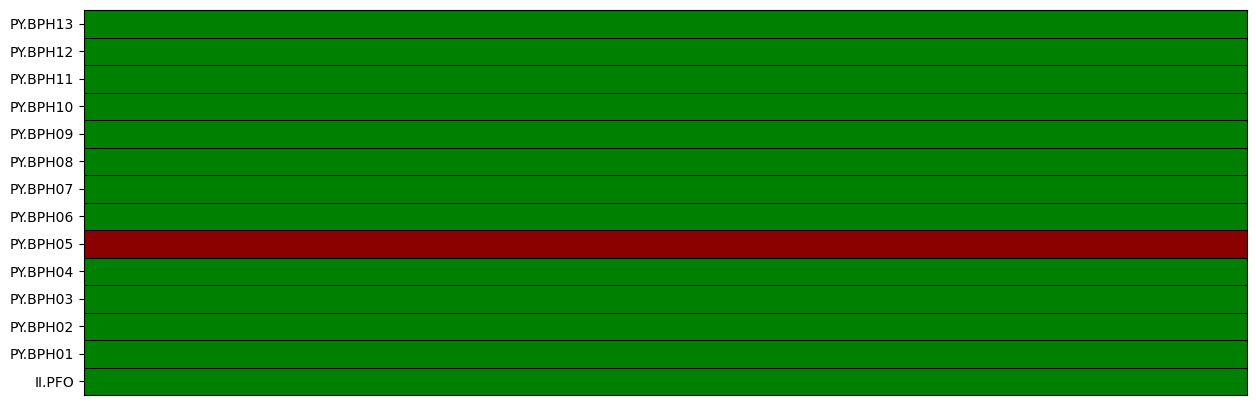


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-01T23:44:16.144538Z - 2023-03-01T23:45:16.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-01T23:44:16.144538Z - 2023-03-01T23:45:16.144538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-01T23:44:16.144538Z - 2023-03-01T23:45:16.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-01T23:44:16.144538Z - 2023-03-01T23:45:16.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-01T23:44:16.144538Z - 2023-03-01T23:45:16.144538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-01T23:44:16.144538Z - 2023-03-01T23:45:16.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-01T23:44:16.144538Z - 2023-03-01T23:45:16.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-01T23:44:16.144538Z - 2023-03-01T23:45:16.144538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-01T23:44:16.144538Z - 2023-03-01T23:45:16.144538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-01T23:44:16.144538Z - 2023-03-01T23:45:16.144538Z |


 -> 121 2023-03-03 23:12:56.820000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-03T23:12:41.822000Z - 2023-03-03T23:13:41.797000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-03T23:12:41.822000Z - 2023-03-03T23:13:41.797000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-03T23:12:41.822000Z - 2023-03-03T23:13:41.797000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


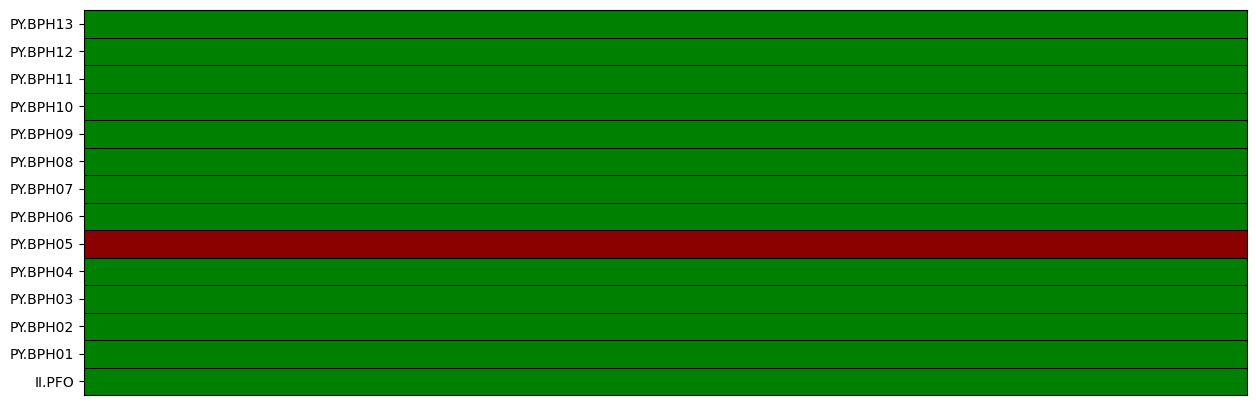


 -> Runtime: 0.73 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-03T23:12:41.819539Z - 2023-03-03T23:13:41.819539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-03T23:12:41.819539Z - 2023-03-03T23:13:41.819539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-03T23:12:41.819539Z - 2023-03-03T23:13:41.819539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-03T23:12:41.819539Z - 2023-03-03T23:13:41.819539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-03T23:12:41.819539Z - 2023-03-03T23:13:41.819539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-03T23:12:41.819539Z - 2023-03-03T23:13:41.819539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-03T23:12:41.819539Z - 2023-03-03T23:13:41.819539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-03T23:12:41.819539Z - 2023-03-03T23:13:41.819539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-03T23:12:41.819539Z - 2023-03-03T23:13:41.819539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-03T23:12:41.819539Z - 2023-03-03T23:13:41.819539Z |


 -> 122 2023-03-05 05:10:11.700000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-05T05:09:56.702200Z - 2023-03-05T05:10:56.677200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-05T05:09:56.702200Z - 2023-03-05T05:10:56.677200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-05T05:09:56.702200Z - 2023-03-05T05:10:56.677200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


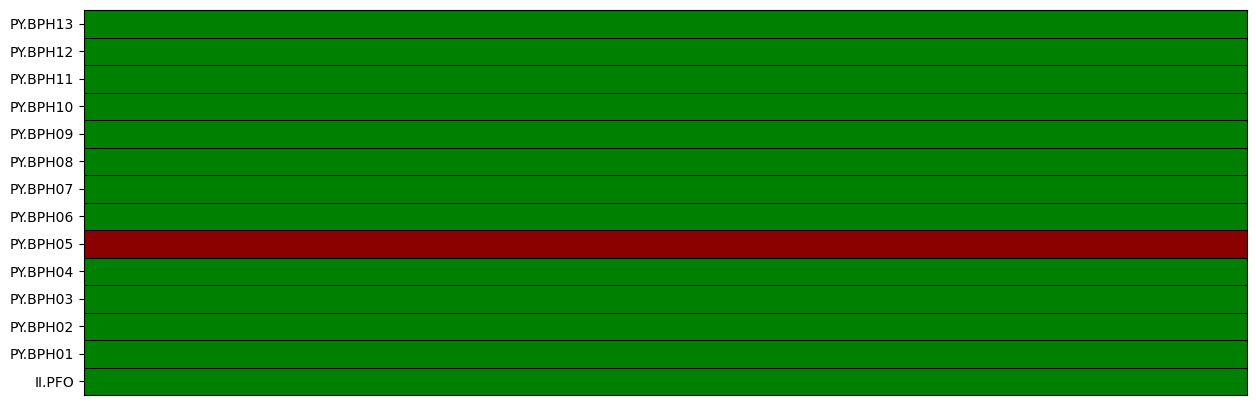


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-05T05:09:56.694538Z - 2023-03-05T05:10:56.694538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-05T05:09:56.694538Z - 2023-03-05T05:10:56.694538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-05T05:09:56.694538Z - 2023-03-05T05:10:56.694538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-05T05:09:56.694538Z - 2023-03-05T05:10:56.694538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-05T05:09:56.694538Z - 2023-03-05T05:10:56.694538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-05T05:09:56.694538Z - 2023-03-05T05:10:56.694538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-05T05:09:56.694538Z - 2023-03-05T05:10:56.694538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-05T05:09:56.694538Z - 2023-03-05T05:10:56.694538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-05T05:09:56.694538Z - 2023-03-05T05:10:56.694538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-05T05:09:56.694538Z - 2023-03-05T05:10:56.694538Z |


 -> 123 2023-03-07 23:26:36.670000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-07T23:26:21.671900Z - 2023-03-07T23:27:21.646900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-07T23:26:21.671900Z - 2023-03-07T23:27:21.646900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-07T23:26:21.671900Z - 2023-03-07T23:27:21.646900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


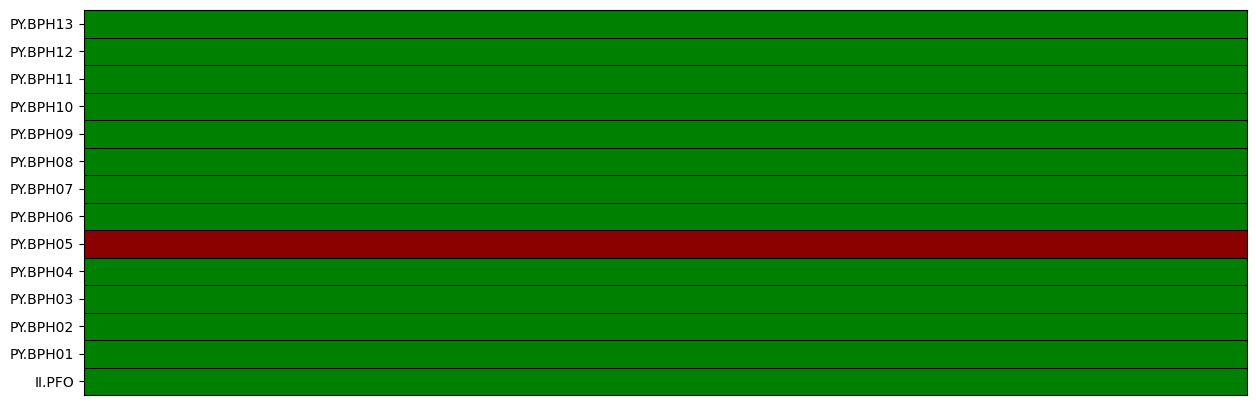


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-07T23:26:21.669538Z - 2023-03-07T23:27:21.669538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-07T23:26:21.669538Z - 2023-03-07T23:27:21.669538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-07T23:26:21.669538Z - 2023-03-07T23:27:21.669538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-07T23:26:21.669538Z - 2023-03-07T23:27:21.669538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-07T23:26:21.669538Z - 2023-03-07T23:27:21.669538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-07T23:26:21.669538Z - 2023-03-07T23:27:21.669538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-07T23:26:21.669538Z - 2023-03-07T23:27:21.669538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-07T23:26:21.669538Z - 2023-03-07T23:27:21.669538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-07T23:26:21.669538Z - 2023-03-07T23:27:21.669538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-07T23:26:21.669538Z - 2023-03-07T23:27:21.669538Z |


 -> 124 2023-03-08 04:07:32.850000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-08T04:07:17.851900Z - 2023-03-08T04:08:17.826900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-08T04:07:17.851900Z - 2023-03-08T04:08:17.826900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-08T04:07:17.851900Z - 2023-03-08T04:08:17.826900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


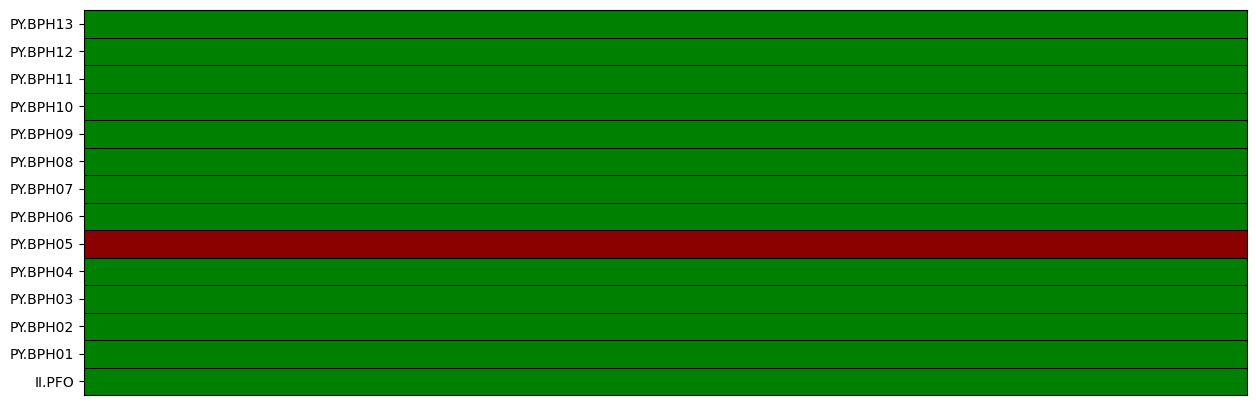


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-08T04:07:17.844538Z - 2023-03-08T04:08:17.844538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-08T04:07:17.844538Z - 2023-03-08T04:08:17.844538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-08T04:07:17.844538Z - 2023-03-08T04:08:17.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-08T04:07:17.844538Z - 2023-03-08T04:08:17.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-08T04:07:17.844538Z - 2023-03-08T04:08:17.844538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-08T04:07:17.844538Z - 2023-03-08T04:08:17.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-08T04:07:17.844538Z - 2023-03-08T04:08:17.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-08T04:07:17.844538Z - 2023-03-08T04:08:17.844538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-08T04:07:17.844538Z - 2023-03-08T04:08:17.844538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-08T04:07:17.844538Z - 2023-03-08T04:08:17.844538Z |


 -> 125 2023-03-08 19:14:49.230000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-08T19:14:34.231900Z - 2023-03-08T19:15:34.206900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-08T19:14:34.231900Z - 2023-03-08T19:15:34.206900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-08T19:14:34.231900Z - 2023-03-08T19:15:34.206900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


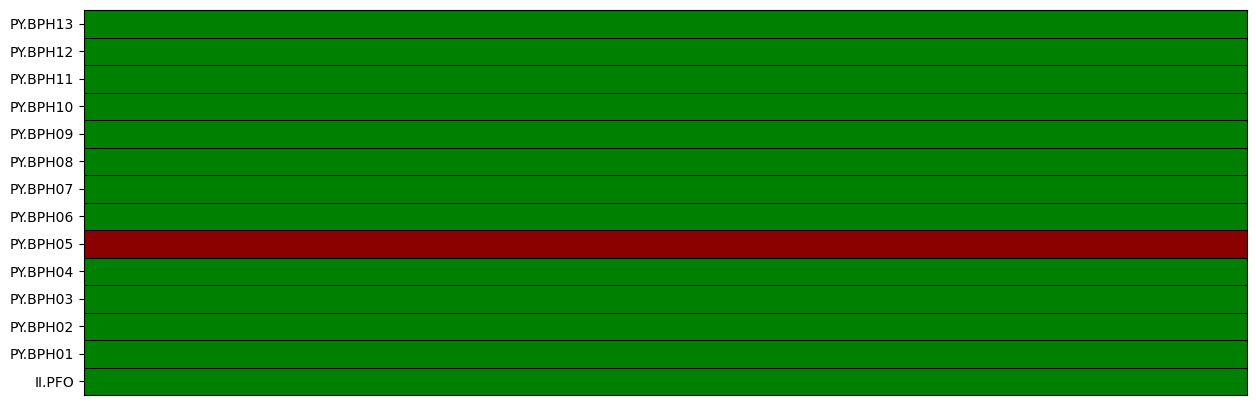


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-08T19:14:34.219538Z - 2023-03-08T19:15:34.219538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-08T19:14:34.219538Z - 2023-03-08T19:15:34.219538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-08T19:14:34.219538Z - 2023-03-08T19:15:34.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-08T19:14:34.219538Z - 2023-03-08T19:15:34.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-08T19:14:34.219538Z - 2023-03-08T19:15:34.219538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-08T19:14:34.219538Z - 2023-03-08T19:15:34.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-08T19:14:34.219538Z - 2023-03-08T19:15:34.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-08T19:14:34.219538Z - 2023-03-08T19:15:34.219538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-08T19:14:34.219538Z - 2023-03-08T19:15:34.219538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-08T19:14:34.219538Z - 2023-03-08T19:15:34.219538Z |


 -> 126 2023-03-09 10:33:35.540000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-09T10:33:20.541900Z - 2023-03-09T10:34:20.516900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-09T10:33:20.541900Z - 2023-03-09T10:34:20.516900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-09T10:33:20.541900Z - 2023-03-09T10:34:20.516900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


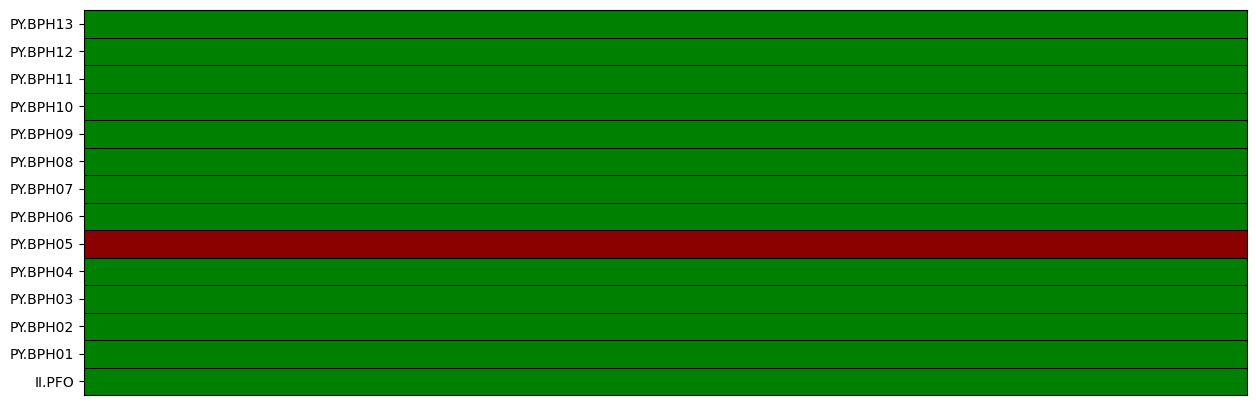


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-09T10:33:20.544538Z - 2023-03-09T10:34:20.544538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-09T10:33:20.544538Z - 2023-03-09T10:34:20.544538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-09T10:33:20.544538Z - 2023-03-09T10:34:20.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-09T10:33:20.544538Z - 2023-03-09T10:34:20.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-09T10:33:20.544538Z - 2023-03-09T10:34:20.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-09T10:33:20.544538Z - 2023-03-09T10:34:20.544538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-09T10:33:20.544538Z - 2023-03-09T10:34:20.544538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-09T10:33:20.544538Z - 2023-03-09T10:34:20.544538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-09T10:33:20.544538Z - 2023-03-09T10:34:20.544538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-09T10:33:20.544538Z - 2023-03-09T10:34:20.544538Z |


 -> 127 2023-03-09 16:15:50.370000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-09T16:15:35.371900Z - 2023-03-09T16:16:35.346900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-09T16:15:35.371900Z - 2023-03-09T16:16:35.346900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-09T16:15:35.371900Z - 2023-03-09T16:16:35.346900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


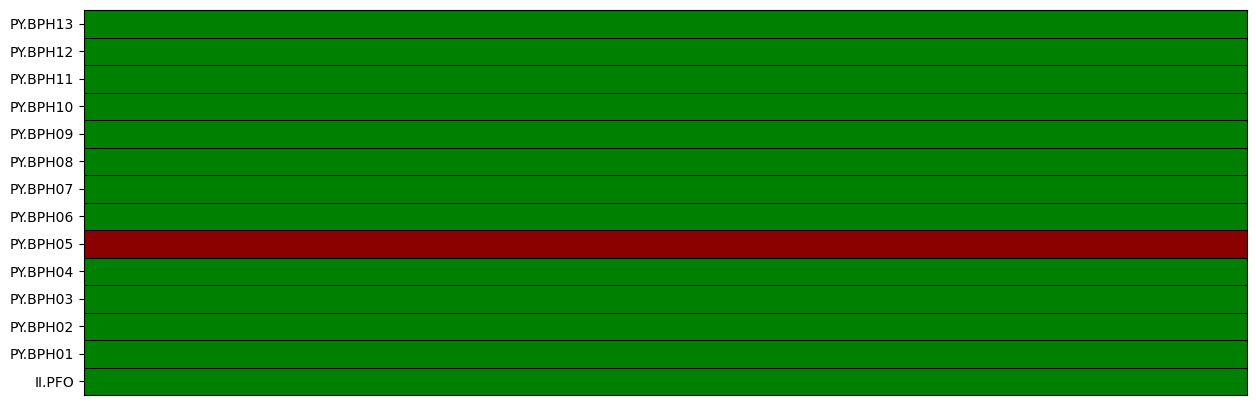


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-09T16:15:35.369538Z - 2023-03-09T16:16:35.369538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-09T16:15:35.369538Z - 2023-03-09T16:16:35.369538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-09T16:15:35.369538Z - 2023-03-09T16:16:35.369538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-09T16:15:35.369538Z - 2023-03-09T16:16:35.369538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-09T16:15:35.369538Z - 2023-03-09T16:16:35.369538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-09T16:15:35.369538Z - 2023-03-09T16:16:35.369538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-09T16:15:35.369538Z - 2023-03-09T16:16:35.369538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-09T16:15:35.369538Z - 2023-03-09T16:16:35.369538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-09T16:15:35.369538Z - 2023-03-09T16:16:35.369538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-09T16:15:35.369538Z - 2023-03-09T16:16:35.369538Z |


 -> 128 2023-03-09 19:26:19.550000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-09T19:26:04.551900Z - 2023-03-09T19:27:04.526900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-09T19:26:04.551900Z - 2023-03-09T19:27:04.526900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-09T19:26:04.551900Z - 2023-03-09T19:27:04.526900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


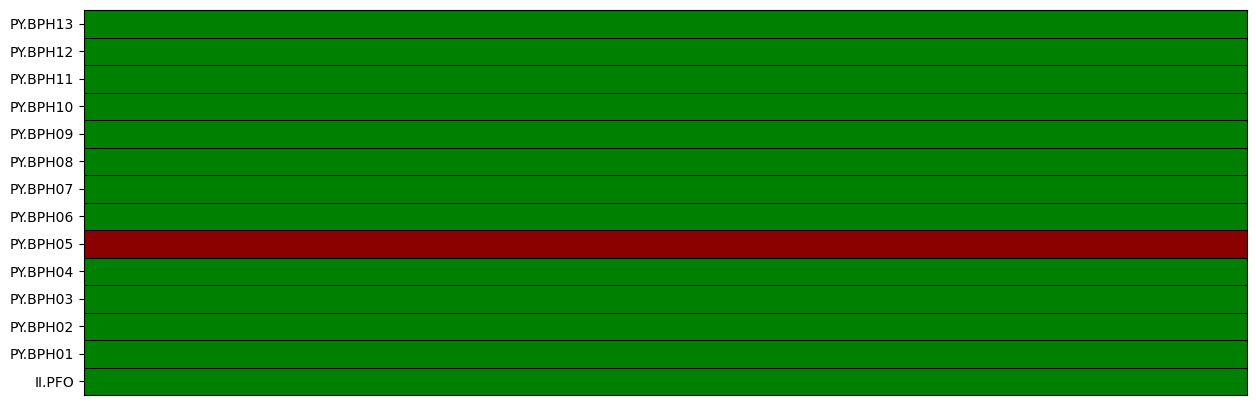


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-09T19:26:04.544538Z - 2023-03-09T19:27:04.544538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-09T19:26:04.544538Z - 2023-03-09T19:27:04.544538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-09T19:26:04.544538Z - 2023-03-09T19:27:04.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-09T19:26:04.544538Z - 2023-03-09T19:27:04.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-09T19:26:04.544538Z - 2023-03-09T19:27:04.544538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-09T19:26:04.544538Z - 2023-03-09T19:27:04.544538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-09T19:26:04.544538Z - 2023-03-09T19:27:04.544538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-09T19:26:04.544538Z - 2023-03-09T19:27:04.544538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-09T19:26:04.544538Z - 2023-03-09T19:27:04.544538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-09T19:26:04.544538Z - 2023-03-09T19:27:04.544538Z |


 -> 129 2023-03-10 01:13:29.650000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-10T01:13:14.651800Z - 2023-03-10T01:14:14.626800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-10T01:13:14.651800Z - 2023-03-10T01:14:14.626800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-10T01:13:14.651800Z - 2023-03-10T01:14:14.626800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


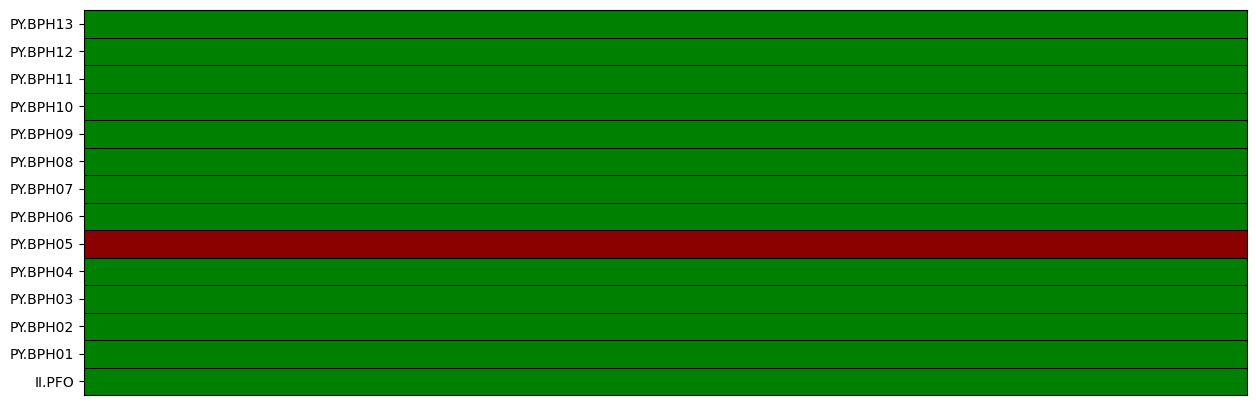


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-10T01:13:14.644538Z - 2023-03-10T01:14:14.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-10T01:13:14.644539Z - 2023-03-10T01:14:14.644539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-10T01:13:14.644539Z - 2023-03-10T01:14:14.644539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-10T01:13:14.644538Z - 2023-03-10T01:14:14.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-10T01:13:14.644539Z - 2023-03-10T01:14:14.644539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-10T01:13:14.644539Z - 2023-03-10T01:14:14.644539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-10T01:13:14.644538Z - 2023-03-10T01:14:14.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-10T01:13:14.644539Z - 2023-03-10T01:14:14.644539Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-10T01:13:14.644539Z - 2023-03-10T01:14:14.644539Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-10T01:13:14.644538Z - 2023-03-10T01:14:14.644538Z |


 -> 130 2023-03-10 06:49:37.800000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-10T06:49:22.801800Z - 2023-03-10T06:50:22.776800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-10T06:49:22.801800Z - 2023-03-10T06:50:22.776800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-10T06:49:22.801800Z - 2023-03-10T06:50:22.776800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


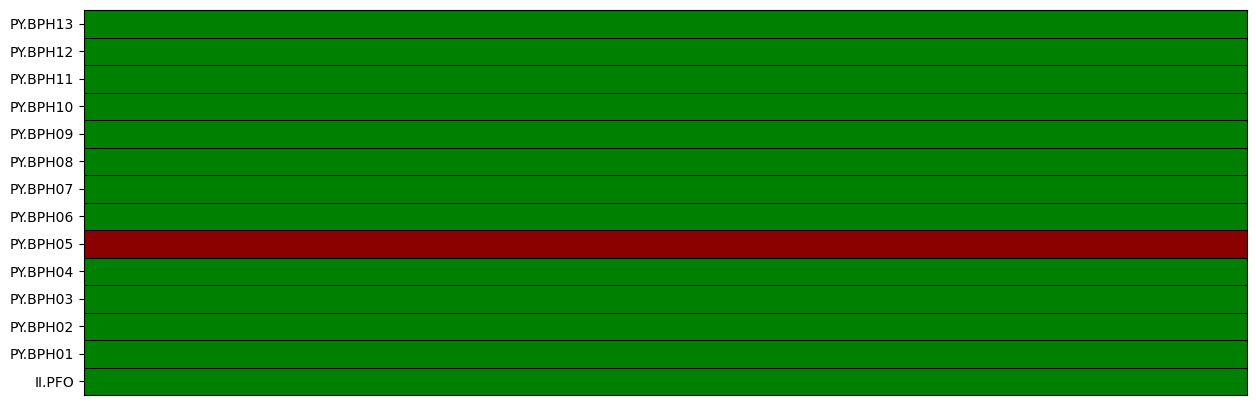


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-10T06:49:22.794538Z - 2023-03-10T06:50:22.794538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-10T06:49:22.794538Z - 2023-03-10T06:50:22.794538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-10T06:49:22.794538Z - 2023-03-10T06:50:22.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-10T06:49:22.794538Z - 2023-03-10T06:50:22.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-10T06:49:22.794538Z - 2023-03-10T06:50:22.794538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-10T06:49:22.794538Z - 2023-03-10T06:50:22.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-10T06:49:22.794538Z - 2023-03-10T06:50:22.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-10T06:49:22.794538Z - 2023-03-10T06:50:22.794538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-10T06:49:22.794538Z - 2023-03-10T06:50:22.794538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-10T06:49:22.794538Z - 2023-03-10T06:50:22.794538Z |


 -> 131 2023-03-10 14:32:11.630000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-10T14:31:56.631800Z - 2023-03-10T14:32:56.606800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-10T14:31:56.631800Z - 2023-03-10T14:32:56.606800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-10T14:31:56.631800Z - 2023-03-10T14:32:56.606800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


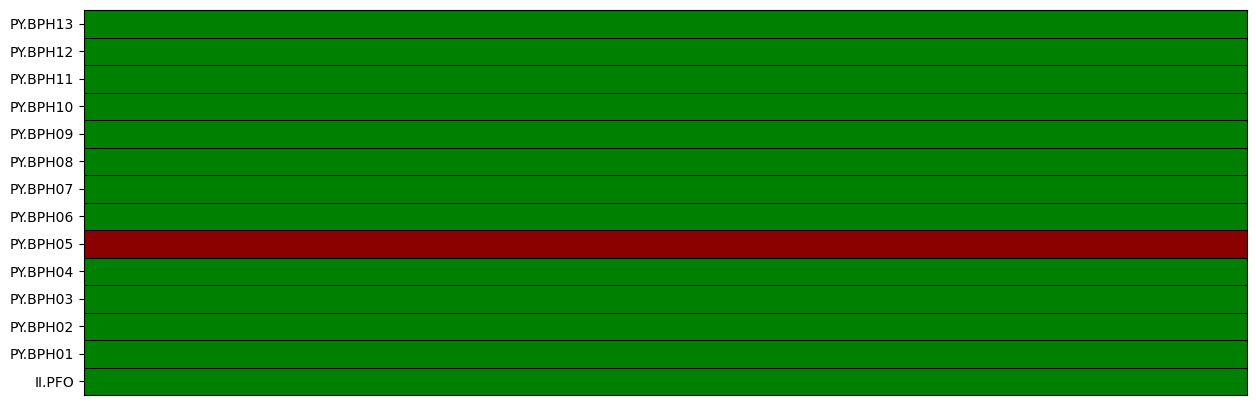


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-10T14:31:56.619538Z - 2023-03-10T14:32:56.619538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-10T14:31:56.619538Z - 2023-03-10T14:32:56.619538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-10T14:31:56.619538Z - 2023-03-10T14:32:56.619538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-10T14:31:56.619538Z - 2023-03-10T14:32:56.619538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-10T14:31:56.619538Z - 2023-03-10T14:32:56.619538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-10T14:31:56.619538Z - 2023-03-10T14:32:56.619538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-10T14:31:56.619538Z - 2023-03-10T14:32:56.619538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-10T14:31:56.619538Z - 2023-03-10T14:32:56.619538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-10T14:31:56.619538Z - 2023-03-10T14:32:56.619538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-10T14:31:56.619538Z - 2023-03-10T14:32:56.619538Z |


 -> 132 2023-03-10 14:33:14.420000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-10T14:32:59.421800Z - 2023-03-10T14:33:59.396800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-10T14:32:59.421800Z - 2023-03-10T14:33:59.396800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-10T14:32:59.421800Z - 2023-03-10T14:33:59.396800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


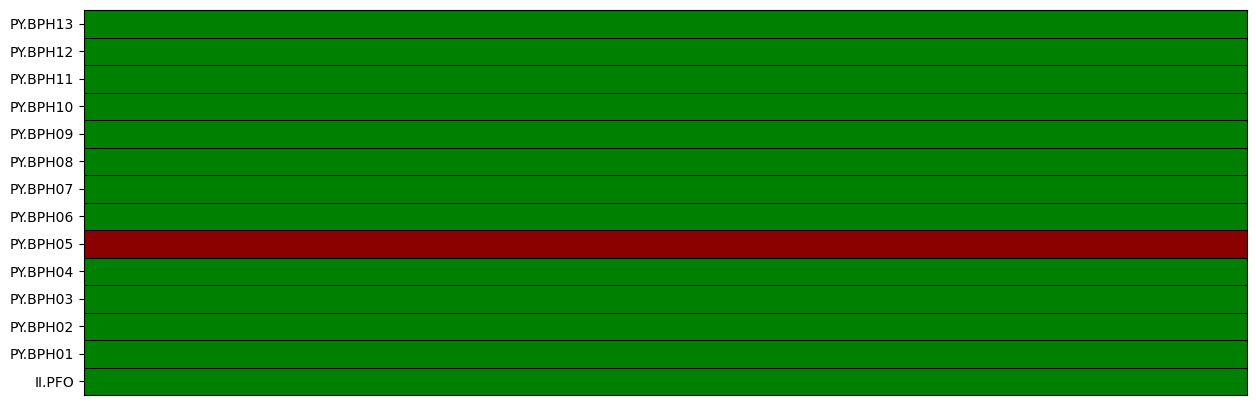


 -> Runtime: 0.74 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-10T14:32:59.419538Z - 2023-03-10T14:33:59.419538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-10T14:32:59.419538Z - 2023-03-10T14:33:59.419538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-10T14:32:59.419538Z - 2023-03-10T14:33:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-10T14:32:59.419538Z - 2023-03-10T14:33:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-10T14:32:59.419538Z - 2023-03-10T14:33:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-10T14:32:59.419538Z - 2023-03-10T14:33:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-10T14:32:59.419538Z - 2023-03-10T14:33:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-10T14:32:59.419538Z - 2023-03-10T14:33:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-10T14:32:59.419538Z - 2023-03-10T14:33:59.419538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-10T14:32:59.419538Z - 2023-03-10T14:33:59.419538Z |


 -> 133 2023-03-10 15:02:31.670000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-10T15:02:16.671800Z - 2023-03-10T15:03:16.646800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-10T15:02:16.671800Z - 2023-03-10T15:03:16.646800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-10T15:02:16.671800Z - 2023-03-10T15:03:16.646800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


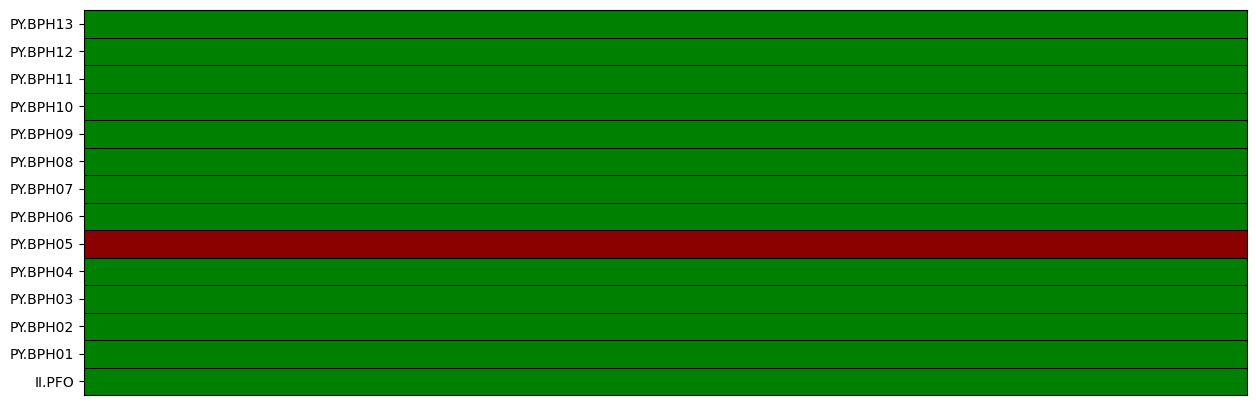


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-10T15:02:16.669538Z - 2023-03-10T15:03:16.669538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-10T15:02:16.669538Z - 2023-03-10T15:03:16.669538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-10T15:02:16.669538Z - 2023-03-10T15:03:16.669538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-10T15:02:16.669538Z - 2023-03-10T15:03:16.669538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-10T15:02:16.669538Z - 2023-03-10T15:03:16.669538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-10T15:02:16.669538Z - 2023-03-10T15:03:16.669538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-10T15:02:16.669538Z - 2023-03-10T15:03:16.669538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-10T15:02:16.669538Z - 2023-03-10T15:03:16.669538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-10T15:02:16.669538Z - 2023-03-10T15:03:16.669538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-10T15:02:16.669538Z - 2023-03-10T15:03:16.669538Z |


 -> 134 2023-03-11 09:32:32.960000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-11T09:32:17.961800Z - 2023-03-11T09:33:17.936800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-11T09:32:17.961800Z - 2023-03-11T09:33:17.936800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-11T09:32:17.961800Z - 2023-03-11T09:33:17.936800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


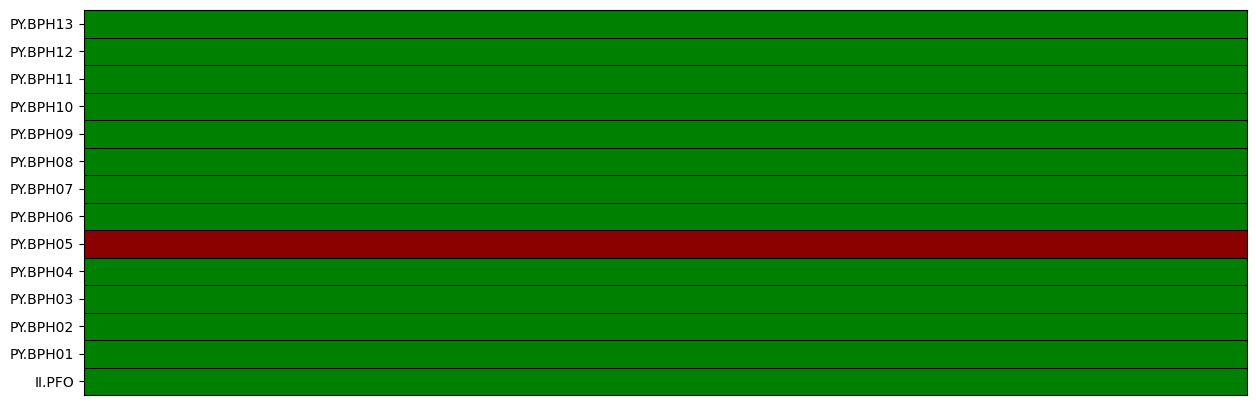


 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-11T09:32:17.969539Z - 2023-03-11T09:33:17.969539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-11T09:32:17.969539Z - 2023-03-11T09:33:17.969539Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-11T09:32:17.969539Z - 2023-03-11T09:33:17.969539Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-11T09:32:17.969538Z - 2023-03-11T09:33:17.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-11T09:32:17.969538Z - 2023-03-11T09:33:17.969538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-11T09:32:17.969538Z - 2023-03-11T09:33:17.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-11T09:32:17.969538Z - 2023-03-11T09:33:17.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-11T09:32:17.969538Z - 2023-03-11T09:33:17.969538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-11T09:32:17.969538Z - 2023-03-11T09:33:17.969538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-11T09:32:17.969538Z - 2023-03-11T09:33:17.969538Z |


 -> 135 2023-03-15 00:03:03.070000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-15T00:02:48.071700Z - 2023-03-15T00:03:48.046700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-15T00:02:48.071700Z - 2023-03-15T00:03:48.046700Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-15T00:02:48.071700Z - 2023-03-15T00:03:48.046700Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


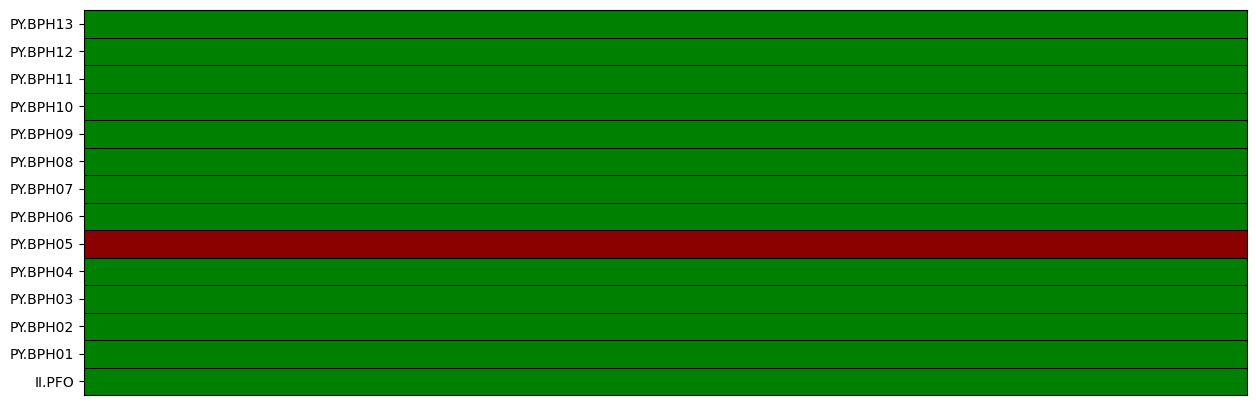


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-15T00:02:48.069538Z - 2023-03-15T00:03:48.069538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-15T00:02:48.069538Z - 2023-03-15T00:03:48.069538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-15T00:02:48.069538Z - 2023-03-15T00:03:48.069538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-15T00:02:48.069538Z - 2023-03-15T00:03:48.069538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-15T00:02:48.069538Z - 2023-03-15T00:03:48.069538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-15T00:02:48.069538Z - 2023-03-15T00:03:48.069538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-15T00:02:48.069538Z - 2023-03-15T00:03:48.069538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-15T00:02:48.069538Z - 2023-03-15T00:03:48.069538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-15T00:02:48.069538Z - 2023-03-15T00:03:48.069538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-15T00:02:48.069538Z - 2023-03-15T00:03:48.069538Z |


 -> 136 2023-03-18 04:52:19.010000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-18T04:52:04.011600Z - 2023-03-18T04:53:03.986600Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-18T04:52:04.011600Z - 2023-03-18T04:53:03.986600Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-18T04:52:04.011600Z - 2023-03-18T04:53:03.986600Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


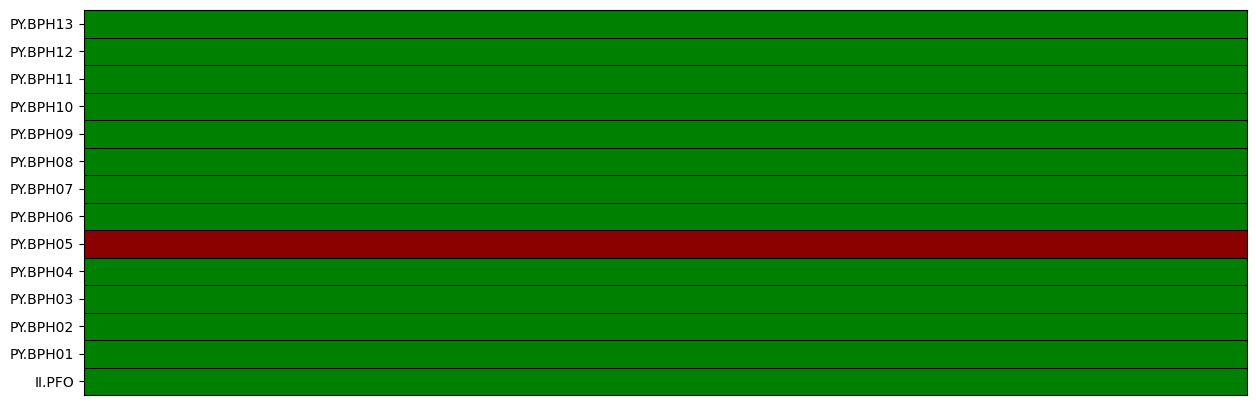


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-18T04:52:04.019538Z - 2023-03-18T04:53:04.019538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-18T04:52:04.019538Z - 2023-03-18T04:53:04.019538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-18T04:52:04.019538Z - 2023-03-18T04:53:04.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-18T04:52:04.019538Z - 2023-03-18T04:53:04.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-18T04:52:04.019538Z - 2023-03-18T04:53:04.019538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-18T04:52:04.019538Z - 2023-03-18T04:53:04.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-18T04:52:04.019538Z - 2023-03-18T04:53:04.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-18T04:52:04.019538Z - 2023-03-18T04:53:04.019538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-18T04:52:04.019538Z - 2023-03-18T04:53:04.019538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-18T04:52:04.019538Z - 2023-03-18T04:53:04.019538Z |


 -> 137 2023-03-20 22:07:58.770000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-20T22:07:43.767800Z - 2023-03-20T22:08:43.742800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-20T22:07:43.767800Z - 2023-03-20T22:08:43.742800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-20T22:07:43.767800Z - 2023-03-20T22:08:43.742800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


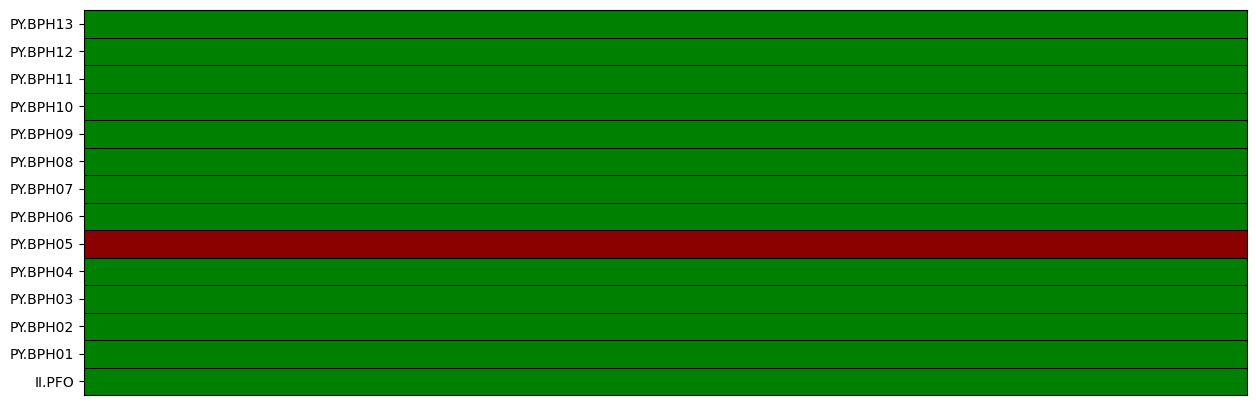


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-20T22:07:43.769538Z - 2023-03-20T22:08:43.769538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-20T22:07:43.769538Z - 2023-03-20T22:08:43.769538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-20T22:07:43.769538Z - 2023-03-20T22:08:43.769538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-20T22:07:43.769538Z - 2023-03-20T22:08:43.769538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-20T22:07:43.769538Z - 2023-03-20T22:08:43.769538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-20T22:07:43.769538Z - 2023-03-20T22:08:43.769538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-20T22:07:43.769538Z - 2023-03-20T22:08:43.769538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-20T22:07:43.769538Z - 2023-03-20T22:08:43.769538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-20T22:07:43.769538Z - 2023-03-20T22:08:43.769538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-20T22:07:43.769538Z - 2023-03-20T22:08:43.769538Z |


 -> 138 2023-03-21 04:13:16.460000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-21T04:13:01.457800Z - 2023-03-21T04:14:01.432800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-21T04:13:01.457800Z - 2023-03-21T04:14:01.432800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-21T04:13:01.457800Z - 2023-03-21T04:14:01.432800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


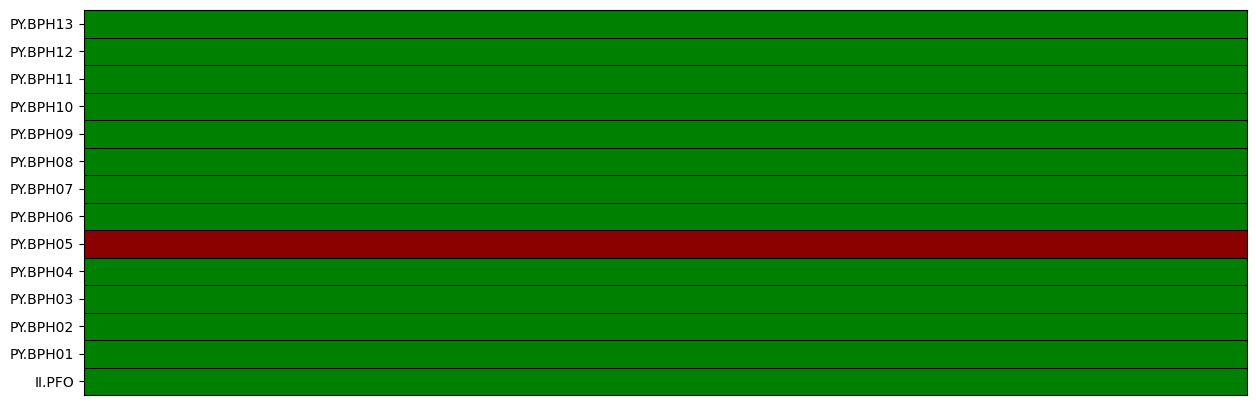


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-21T04:13:01.469538Z - 2023-03-21T04:14:01.469538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-21T04:13:01.469538Z - 2023-03-21T04:14:01.469538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-21T04:13:01.469538Z - 2023-03-21T04:14:01.469538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-21T04:13:01.469538Z - 2023-03-21T04:14:01.469538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-21T04:13:01.469538Z - 2023-03-21T04:14:01.469538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-21T04:13:01.469538Z - 2023-03-21T04:14:01.469538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-21T04:13:01.469538Z - 2023-03-21T04:14:01.469538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-21T04:13:01.469538Z - 2023-03-21T04:14:01.469538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-21T04:13:01.469538Z - 2023-03-21T04:14:01.469538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-21T04:13:01.469538Z - 2023-03-21T04:14:01.469538Z |


 -> 139 2023-03-21 15:34:08.600000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-21T15:33:53.597800Z - 2023-03-21T15:34:53.572800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-21T15:33:53.597800Z - 2023-03-21T15:34:53.572800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-21T15:33:53.597800Z - 2023-03-21T15:34:53.572800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


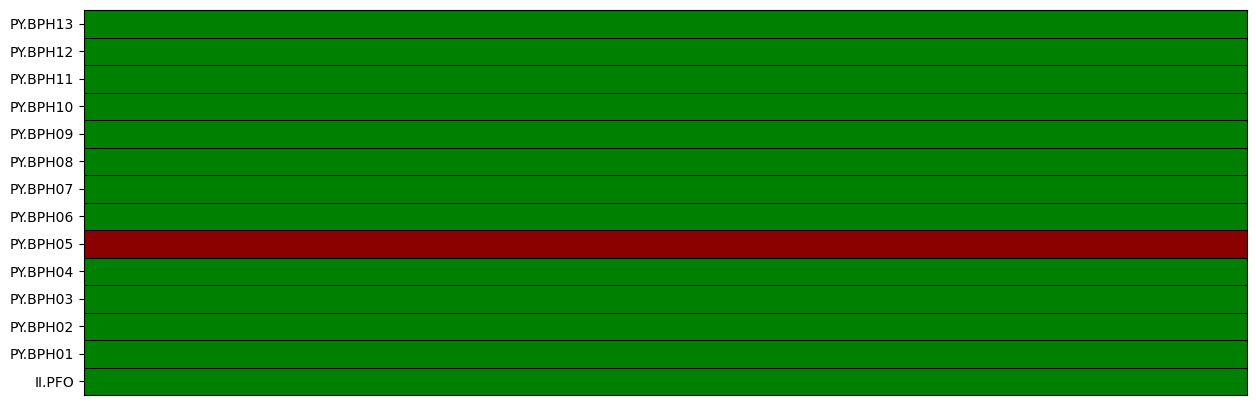


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-21T15:33:53.594538Z - 2023-03-21T15:34:53.594538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-21T15:33:53.594538Z - 2023-03-21T15:34:53.594538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-21T15:33:53.594538Z - 2023-03-21T15:34:53.594538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-21T15:33:53.594538Z - 2023-03-21T15:34:53.594538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-21T15:33:53.594538Z - 2023-03-21T15:34:53.594538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-21T15:33:53.594538Z - 2023-03-21T15:34:53.594538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-21T15:33:53.594538Z - 2023-03-21T15:34:53.594538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-21T15:33:53.594538Z - 2023-03-21T15:34:53.594538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-21T15:33:53.594538Z - 2023-03-21T15:34:53.594538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-21T15:33:53.594538Z - 2023-03-21T15:34:53.594538Z |


 -> 140 2023-03-21 19:29:23.360000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-21T19:29:08.357800Z - 2023-03-21T19:30:08.332800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-21T19:29:08.357800Z - 2023-03-21T19:30:08.332800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-21T19:29:08.357800Z - 2023-03-21T19:30:08.332800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


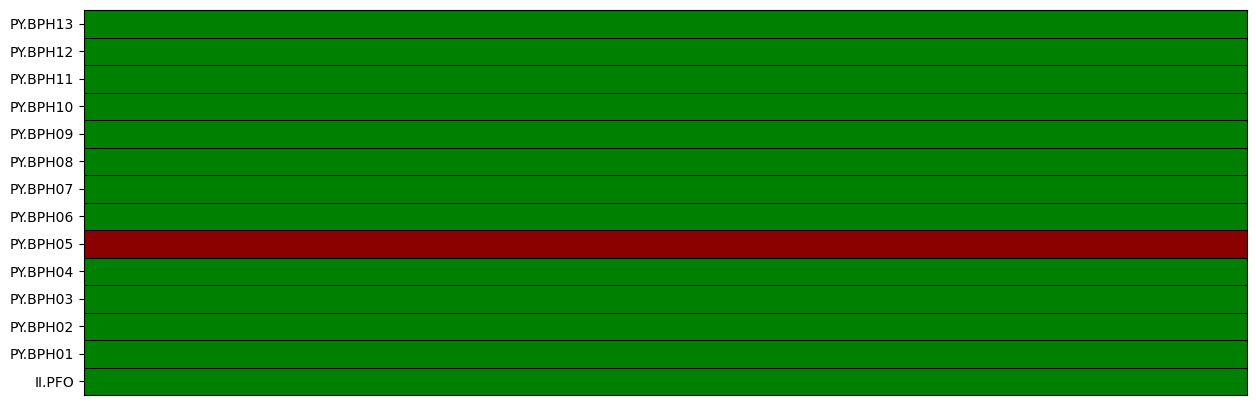


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-21T19:29:08.369538Z - 2023-03-21T19:30:08.369538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-21T19:29:08.369538Z - 2023-03-21T19:30:08.369538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-21T19:29:08.369538Z - 2023-03-21T19:30:08.369538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-21T19:29:08.369538Z - 2023-03-21T19:30:08.369538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-21T19:29:08.369538Z - 2023-03-21T19:30:08.369538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-21T19:29:08.369538Z - 2023-03-21T19:30:08.369538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-21T19:29:08.369538Z - 2023-03-21T19:30:08.369538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-21T19:29:08.369538Z - 2023-03-21T19:30:08.369538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-21T19:29:08.369538Z - 2023-03-21T19:30:08.369538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-21T19:29:08.369538Z - 2023-03-21T19:30:08.369538Z |


 -> 141 2023-03-21 20:47:34.330000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-21T20:47:19.327800Z - 2023-03-21T20:48:19.302800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-21T20:47:19.327800Z - 2023-03-21T20:48:19.302800Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-21T20:47:19.327800Z - 2023-03-21T20:48:19.302800Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


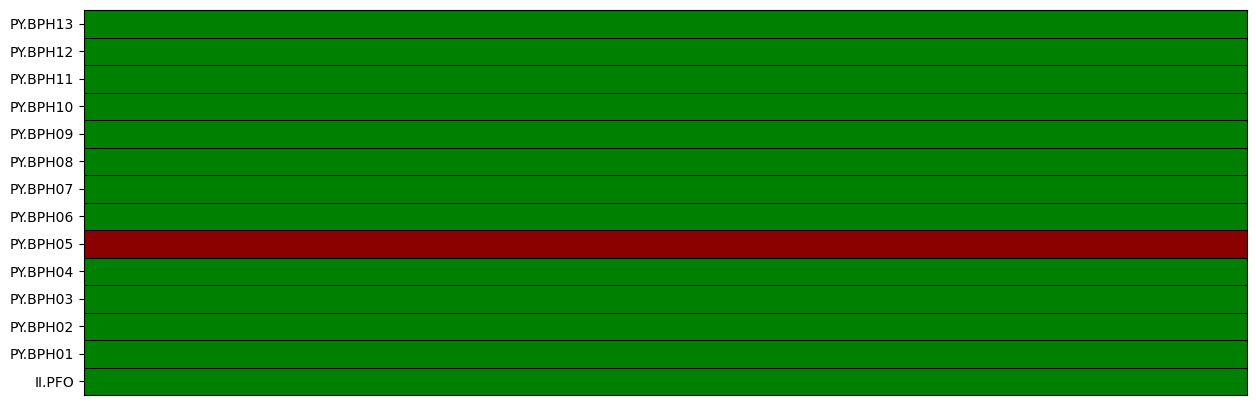


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-21T20:47:19.319538Z - 2023-03-21T20:48:19.319538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-21T20:47:19.319538Z - 2023-03-21T20:48:19.319538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-21T20:47:19.319538Z - 2023-03-21T20:48:19.319538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-21T20:47:19.319538Z - 2023-03-21T20:48:19.319538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-21T20:47:19.319538Z - 2023-03-21T20:48:19.319538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-21T20:47:19.319538Z - 2023-03-21T20:48:19.319538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-21T20:47:19.319538Z - 2023-03-21T20:48:19.319538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-21T20:47:19.319538Z - 2023-03-21T20:48:19.319538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-21T20:47:19.319538Z - 2023-03-21T20:48:19.319538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-21T20:47:19.319538Z - 2023-03-21T20:48:19.319538Z |


 -> 142 2023-03-21 23:24:40.990000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-21T23:24:25.992000Z - 2023-03-21T23:25:25.967000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-21T23:24:25.992000Z - 2023-03-21T23:25:25.967000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-21T23:24:25.992000Z - 2023-03-21T23:25:25.967000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


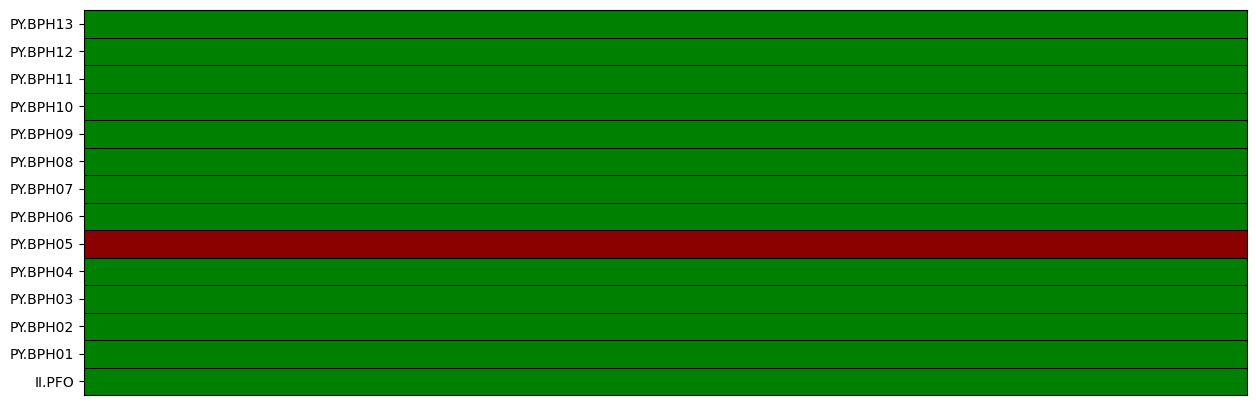


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-21T23:24:25.994538Z - 2023-03-21T23:25:25.994538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-21T23:24:25.994538Z - 2023-03-21T23:25:25.994538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-21T23:24:25.994538Z - 2023-03-21T23:25:25.994538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-21T23:24:25.994538Z - 2023-03-21T23:25:25.994538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-21T23:24:25.994538Z - 2023-03-21T23:25:25.994538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-21T23:24:25.994538Z - 2023-03-21T23:25:25.994538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-21T23:24:25.994538Z - 2023-03-21T23:25:25.994538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-21T23:24:25.994538Z - 2023-03-21T23:25:25.994538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-21T23:24:25.994538Z - 2023-03-21T23:25:25.994538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-21T23:24:25.994538Z - 2023-03-21T23:25:25.994538Z |


 -> 143 2023-03-22 03:21:34.900000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-22T03:21:19.902000Z - 2023-03-22T03:22:19.877000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-22T03:21:19.902000Z - 2023-03-22T03:22:19.877000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-22T03:21:19.902000Z - 2023-03-22T03:22:19.877000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


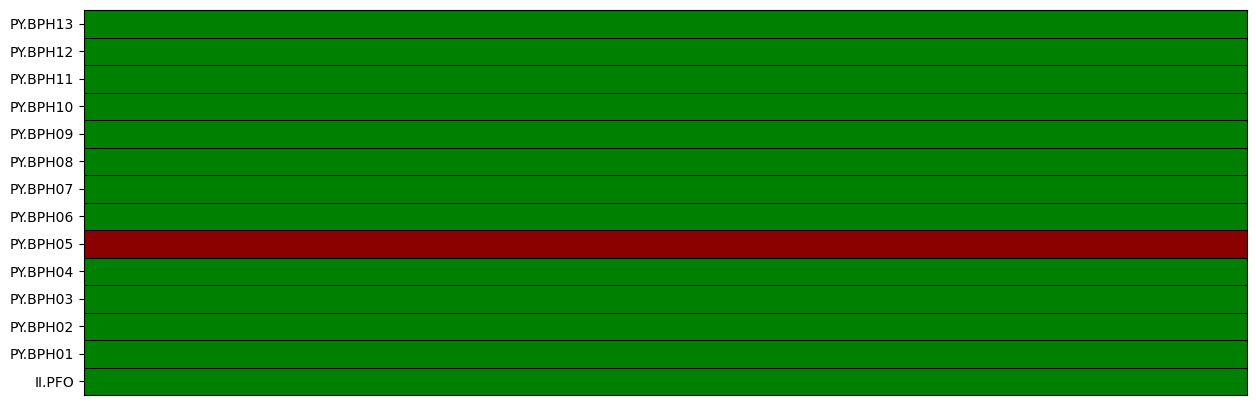


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-22T03:21:19.894538Z - 2023-03-22T03:22:19.894538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-22T03:21:19.894538Z - 2023-03-22T03:22:19.894538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-22T03:21:19.894538Z - 2023-03-22T03:22:19.894538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-22T03:21:19.894538Z - 2023-03-22T03:22:19.894538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-22T03:21:19.894538Z - 2023-03-22T03:22:19.894538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-22T03:21:19.894538Z - 2023-03-22T03:22:19.894538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-22T03:21:19.894538Z - 2023-03-22T03:22:19.894538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-22T03:21:19.894538Z - 2023-03-22T03:22:19.894538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-22T03:21:19.894538Z - 2023-03-22T03:22:19.894538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-22T03:21:19.894538Z - 2023-03-22T03:22:19.894538Z |


 -> 144 2023-03-22 16:08:52.450000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-22T16:08:37.452000Z - 2023-03-22T16:09:37.427000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-22T16:08:37.452000Z - 2023-03-22T16:09:37.427000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-22T16:08:37.452000Z - 2023-03-22T16:09:37.427000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


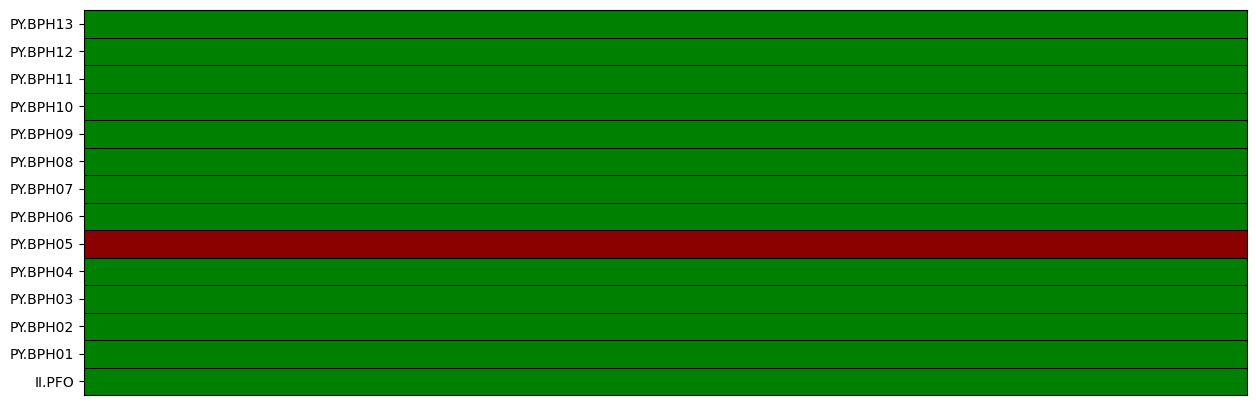


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-22T16:08:37.444538Z - 2023-03-22T16:09:37.444538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-22T16:08:37.444538Z - 2023-03-22T16:09:37.444538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-22T16:08:37.444538Z - 2023-03-22T16:09:37.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-22T16:08:37.444538Z - 2023-03-22T16:09:37.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-22T16:08:37.444538Z - 2023-03-22T16:09:37.444538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-22T16:08:37.444538Z - 2023-03-22T16:09:37.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-22T16:08:37.444538Z - 2023-03-22T16:09:37.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-22T16:08:37.444538Z - 2023-03-22T16:09:37.444538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-22T16:08:37.444538Z - 2023-03-22T16:09:37.444538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-22T16:08:37.444538Z - 2023-03-22T16:09:37.444538Z |


 -> 145 2023-03-22 20:13:47.950000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-22T20:13:32.952000Z - 2023-03-22T20:14:32.927000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-22T20:13:32.952000Z - 2023-03-22T20:14:32.927000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-22T20:13:32.952000Z - 2023-03-22T20:14:32.927000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


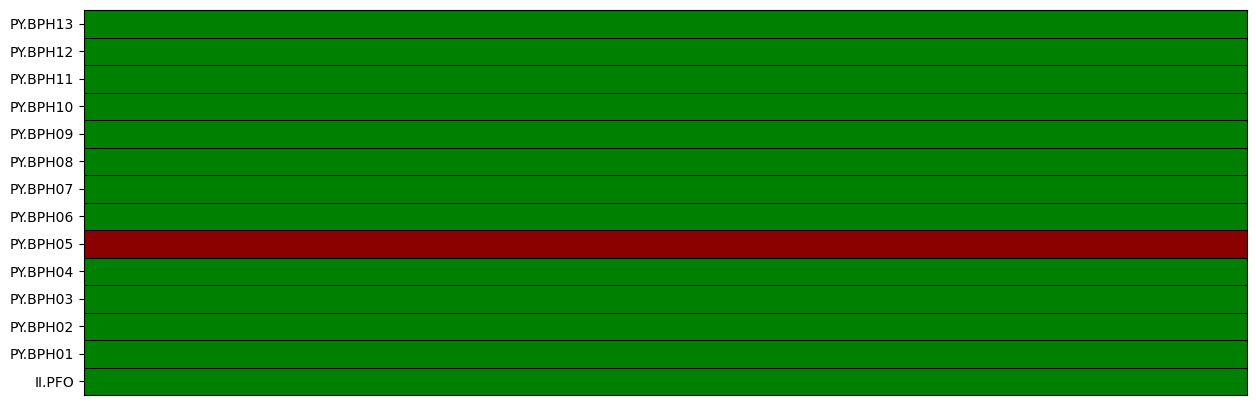


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-22T20:13:32.944538Z - 2023-03-22T20:14:32.944538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-22T20:13:32.944538Z - 2023-03-22T20:14:32.944538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-22T20:13:32.944538Z - 2023-03-22T20:14:32.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-22T20:13:32.944538Z - 2023-03-22T20:14:32.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-22T20:13:32.944538Z - 2023-03-22T20:14:32.944538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-22T20:13:32.944538Z - 2023-03-22T20:14:32.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-22T20:13:32.944538Z - 2023-03-22T20:14:32.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-22T20:13:32.944538Z - 2023-03-22T20:14:32.944538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-22T20:13:32.944538Z - 2023-03-22T20:14:32.944538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-22T20:13:32.944538Z - 2023-03-22T20:14:32.944538Z |


 -> 146 2023-03-24 13:45:13.700000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-24T13:44:58.701900Z - 2023-03-24T13:45:58.676900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-24T13:44:58.701900Z - 2023-03-24T13:45:58.676900Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-24T13:44:58.701900Z - 2023-03-24T13:45:58.676900Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


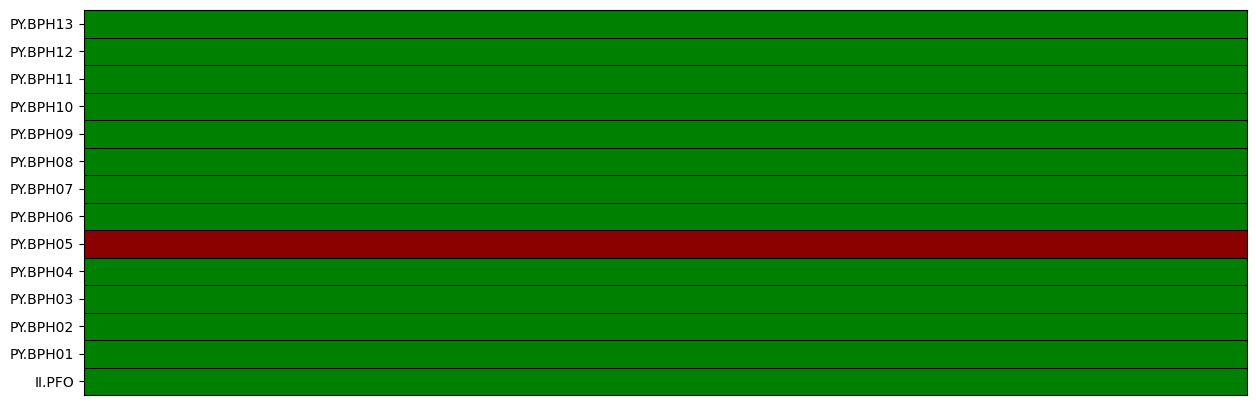


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-24T13:44:58.694538Z - 2023-03-24T13:45:58.694538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-24T13:44:58.694538Z - 2023-03-24T13:45:58.694538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-24T13:44:58.694538Z - 2023-03-24T13:45:58.694538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-24T13:44:58.694538Z - 2023-03-24T13:45:58.694538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-24T13:44:58.694538Z - 2023-03-24T13:45:58.694538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-24T13:44:58.694538Z - 2023-03-24T13:45:58.694538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-24T13:44:58.694538Z - 2023-03-24T13:45:58.694538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-24T13:44:58.694538Z - 2023-03-24T13:45:58.694538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-24T13:44:58.694538Z - 2023-03-24T13:45:58.694538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-24T13:44:58.694538Z - 2023-03-24T13:45:58.694538Z |


 -> 147 2023-03-24 15:04:04.090000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-24T15:03:49.092000Z - 2023-03-24T15:04:49.067000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-24T15:03:49.092000Z - 2023-03-24T15:04:49.067000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-24T15:03:49.092000Z - 2023-03-24T15:04:49.067000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


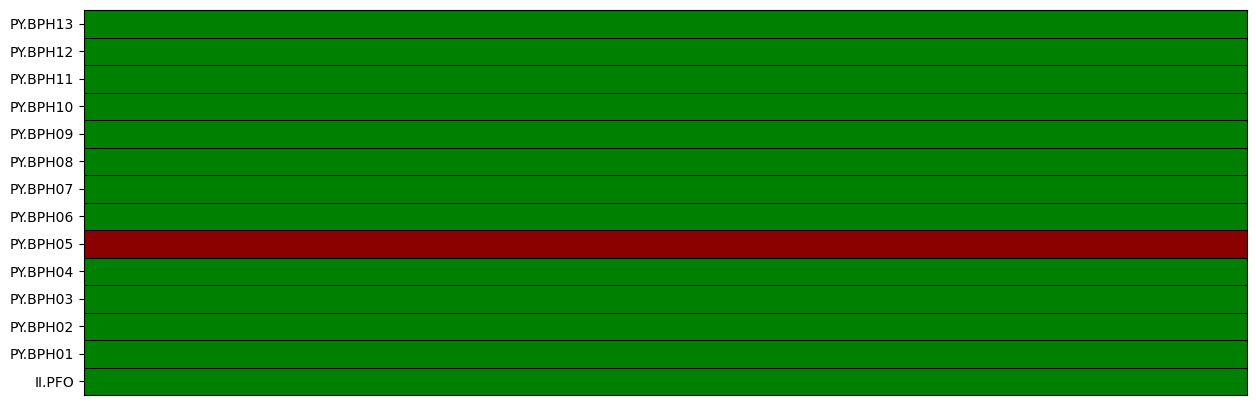


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-24T15:03:49.094538Z - 2023-03-24T15:04:49.094538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-24T15:03:49.094538Z - 2023-03-24T15:04:49.094538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-24T15:03:49.094538Z - 2023-03-24T15:04:49.094538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-24T15:03:49.094538Z - 2023-03-24T15:04:49.094538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-24T15:03:49.094538Z - 2023-03-24T15:04:49.094538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-24T15:03:49.094538Z - 2023-03-24T15:04:49.094538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-24T15:03:49.094538Z - 2023-03-24T15:04:49.094538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-24T15:03:49.094538Z - 2023-03-24T15:04:49.094538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-24T15:03:49.094538Z - 2023-03-24T15:04:49.094538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-24T15:03:49.094538Z - 2023-03-24T15:04:49.094538Z |


 -> 148 2023-03-26 07:47:55.340000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-26T07:47:40.342000Z - 2023-03-26T07:48:40.317000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-26T07:47:40.342000Z - 2023-03-26T07:48:40.317000Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-26T07:47:40.342000Z - 2023-03-26T07:48:40.317000Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


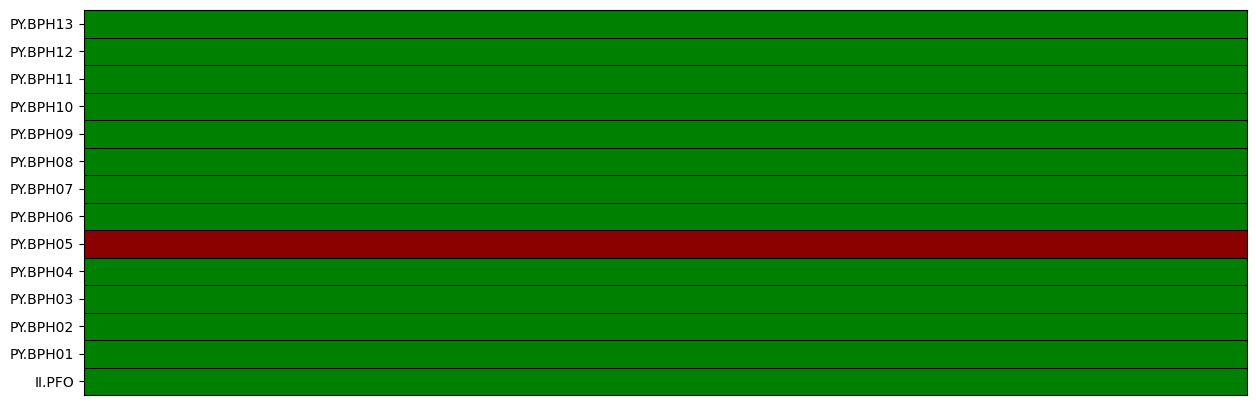


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-26T07:47:40.344538Z - 2023-03-26T07:48:40.344538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-26T07:47:40.344538Z - 2023-03-26T07:48:40.344538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-26T07:47:40.344538Z - 2023-03-26T07:48:40.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-26T07:47:40.344538Z - 2023-03-26T07:48:40.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-26T07:47:40.344538Z - 2023-03-26T07:48:40.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-26T07:47:40.344538Z - 2023-03-26T07:48:40.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-26T07:47:40.344538Z - 2023-03-26T07:48:40.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-26T07:47:40.344538Z - 2023-03-26T07:48:40.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-26T07:47:40.344538Z - 2023-03-26T07:48:40.344538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-26T07:47:40.344538Z - 2023-03-26T07:48:40.344538Z |


 -> 149 2023-03-26 17:50:18.500000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-26T17:50:03.498100Z - 2023-03-26T17:51:03.473100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-26T17:50:03.498100Z - 2023-03-26T17:51:03.473100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-26T17:50:03.498100Z - 2023-03-26T17:51:03.473100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


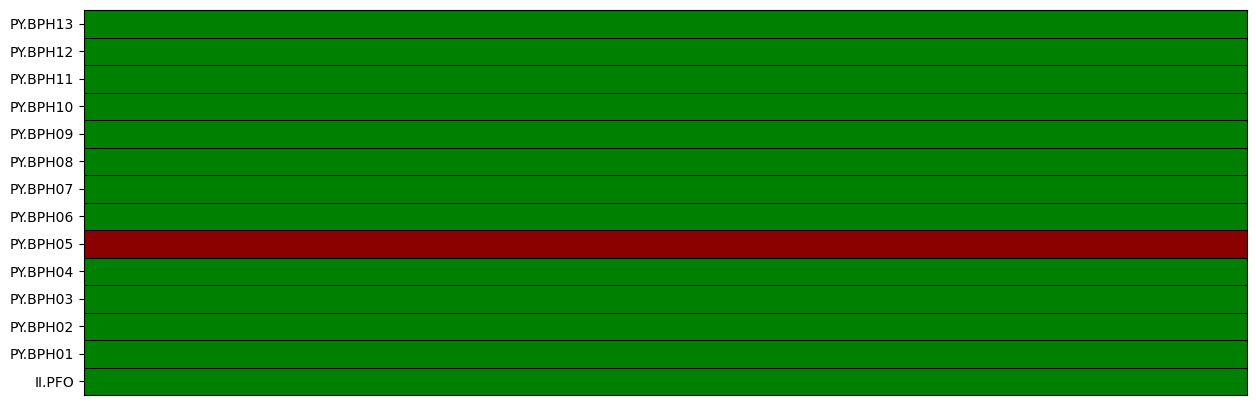


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-26T17:50:03.494538Z - 2023-03-26T17:51:03.494538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-26T17:50:03.494538Z - 2023-03-26T17:51:03.494538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-26T17:50:03.494538Z - 2023-03-26T17:51:03.494538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-26T17:50:03.494538Z - 2023-03-26T17:51:03.494538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-26T17:50:03.494538Z - 2023-03-26T17:51:03.494538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-26T17:50:03.494538Z - 2023-03-26T17:51:03.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-26T17:50:03.494538Z - 2023-03-26T17:51:03.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-26T17:50:03.494538Z - 2023-03-26T17:51:03.494538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-26T17:50:03.494538Z - 2023-03-26T17:51:03.494538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-26T17:50:03.494538Z - 2023-03-26T17:51:03.494538Z |


 -> 150 2023-03-27 09:28:56.340000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-27T09:28:41.338100Z - 2023-03-27T09:29:41.313100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-27T09:28:41.338100Z - 2023-03-27T09:29:41.313100Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-27T09:28:41.338100Z - 2023-03-27T09:29:41.313100Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


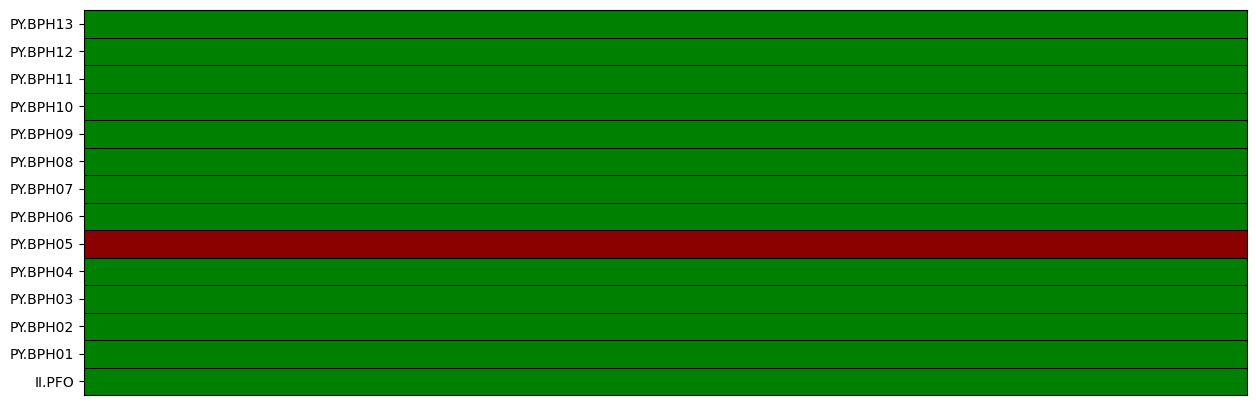


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-27T09:28:41.344538Z - 2023-03-27T09:29:41.344538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-27T09:28:41.344538Z - 2023-03-27T09:29:41.344538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-27T09:28:41.344538Z - 2023-03-27T09:29:41.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-27T09:28:41.344538Z - 2023-03-27T09:29:41.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-27T09:28:41.344538Z - 2023-03-27T09:29:41.344538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-27T09:28:41.344538Z - 2023-03-27T09:29:41.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-27T09:28:41.344538Z - 2023-03-27T09:29:41.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-27T09:28:41.344538Z - 2023-03-27T09:29:41.344538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-27T09:28:41.344538Z - 2023-03-27T09:29:41.344538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-27T09:28:41.344538Z - 2023-03-27T09:29:41.344538Z |


 -> 151 2023-03-29 19:40:21.650000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-29T19:40:06.648400Z - 2023-03-29T19:41:06.623400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-29T19:40:06.648400Z - 2023-03-29T19:41:06.623400Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-29T19:40:06.648400Z - 2023-03-29T19:41:06.623400Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


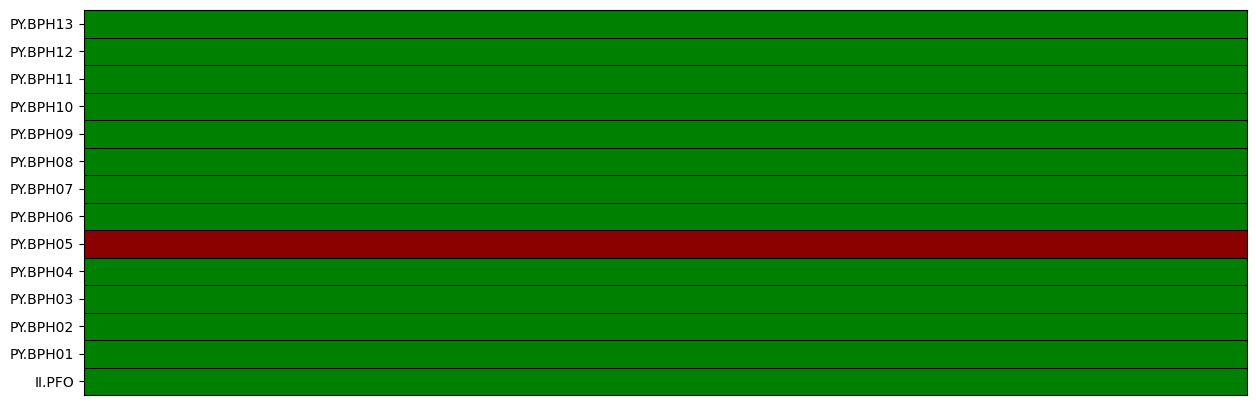


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-29T19:40:06.644538Z - 2023-03-29T19:41:06.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-29T19:40:06.644538Z - 2023-03-29T19:41:06.644538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-29T19:40:06.644538Z - 2023-03-29T19:41:06.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-29T19:40:06.644538Z - 2023-03-29T19:41:06.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-29T19:40:06.644538Z - 2023-03-29T19:41:06.644538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-29T19:40:06.644538Z - 2023-03-29T19:41:06.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-29T19:40:06.644538Z - 2023-03-29T19:41:06.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-29T19:40:06.644538Z - 2023-03-29T19:41:06.644538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-29T19:40:06.644538Z - 2023-03-29T19:41:06.644538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-29T19:40:06.644538Z - 2023-03-29T19:41:06.644538Z |


 -> 152 2023-03-31 00:02:49.740000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-31T00:02:34.738300Z - 2023-03-31T00:03:34.713300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-31T00:02:34.738200Z - 2023-03-31T00:03:34.713200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-31T00:02:34.738200Z - 2023-03-31T00:03:34.713200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


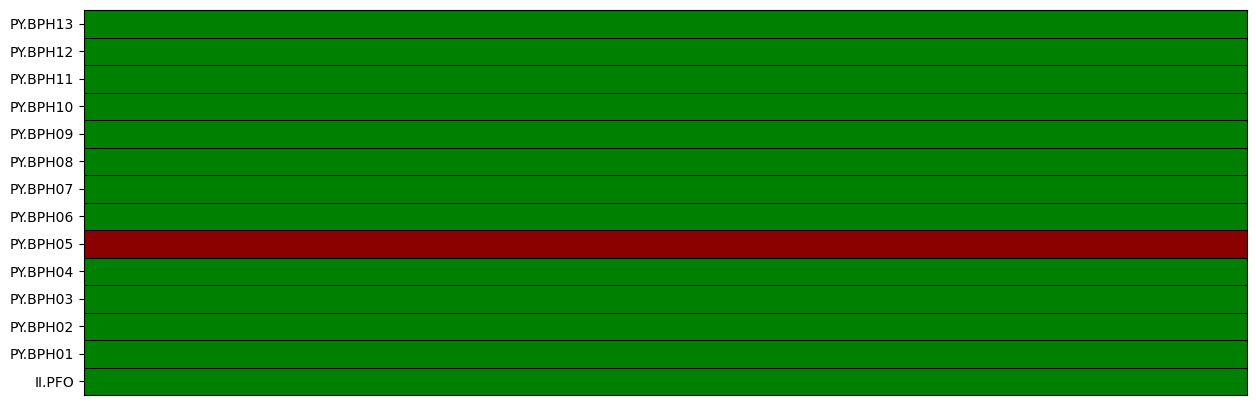


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-31T00:02:34.744538Z - 2023-03-31T00:03:34.744538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-31T00:02:34.744538Z - 2023-03-31T00:03:34.744538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-31T00:02:34.744538Z - 2023-03-31T00:03:34.744538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-31T00:02:34.744538Z - 2023-03-31T00:03:34.744538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-31T00:02:34.744538Z - 2023-03-31T00:03:34.744538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-31T00:02:34.744538Z - 2023-03-31T00:03:34.744538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-31T00:02:34.744538Z - 2023-03-31T00:03:34.744538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-31T00:02:34.744538Z - 2023-03-31T00:03:34.744538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-31T00:02:34.744538Z - 2023-03-31T00:03:34.744538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-31T00:02:34.744538Z - 2023-03-31T00:03:34.744538Z |


 -> 153 2023-03-31 12:05:39.920000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-31T12:05:24.918200Z - 2023-03-31T12:06:24.893200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-31T12:05:24.918200Z - 2023-03-31T12:06:24.893200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-31T12:05:24.918200Z - 2023-03-31T12:06:24.893200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


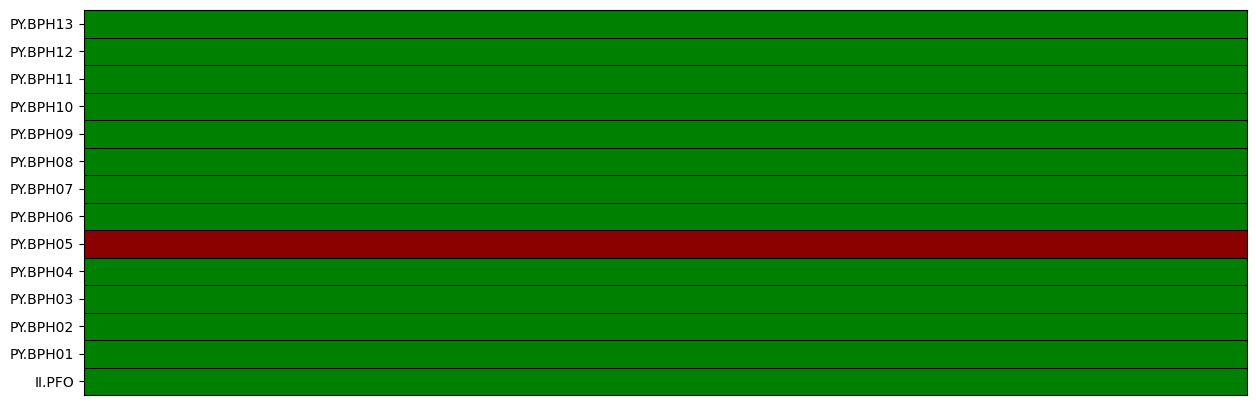


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-31T12:05:24.919538Z - 2023-03-31T12:06:24.919538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-31T12:05:24.919538Z - 2023-03-31T12:06:24.919538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-31T12:05:24.919538Z - 2023-03-31T12:06:24.919538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-31T12:05:24.919538Z - 2023-03-31T12:06:24.919538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-31T12:05:24.919538Z - 2023-03-31T12:06:24.919538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-31T12:05:24.919538Z - 2023-03-31T12:06:24.919538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-31T12:05:24.919538Z - 2023-03-31T12:06:24.919538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-31T12:05:24.919538Z - 2023-03-31T12:06:24.919538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-31T12:05:24.919538Z - 2023-03-31T12:06:24.919538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-31T12:05:24.919538Z - 2023-03-31T12:06:24.919538Z |


 -> 154 2023-03-31 13:36:56.120000 
 -> sensitivity removed!
 -> response removed!


3 Trace(s) in Stream:
PY.BSPF..HJZ | 2023-03-31T13:36:41.118300Z - 2023-03-31T13:37:41.093300Z | 40.0 Hz, 2400 samples
PY.BSPF..HJN | 2023-03-31T13:36:41.118200Z - 2023-03-31T13:37:41.093200Z | 40.0 Hz, 2400 samples
PY.BSPF..HJE | 2023-03-31T13:36:41.118200Z - 2023-03-31T13:37:41.093200Z | 40.0 Hz, 2400 samples

 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


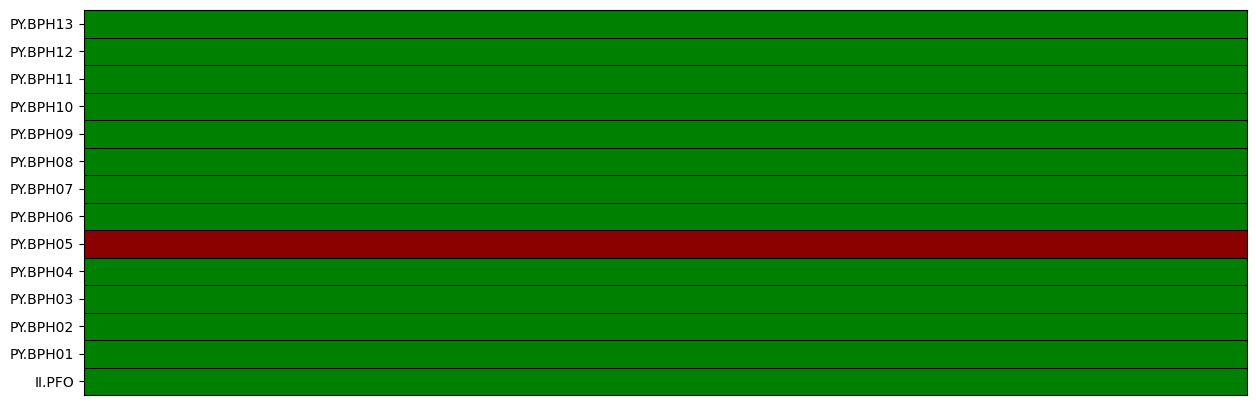


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
II.PFO.10.BHE   | 2023-03-31T13:36:41.119538Z - 2023-03-31T13:37:41.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHN   | 2023-03-31T13:36:41.119538Z - 2023-03-31T13:37:41.119538Z | 40.0 Hz, 2401 samples
II.PFO.10.BHZ   | 2023-03-31T13:36:41.119538Z - 2023-03-31T13:37:41.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJE | 2023-03-31T13:36:41.119538Z - 2023-03-31T13:37:41.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJN | 2023-03-31T13:36:41.119538Z - 2023-03-31T13:37:41.119538Z | 40.0 Hz, 2401 samples
II.RPFO.all.BJZ | 2023-03-31T13:36:41.119538Z - 2023-03-31T13:37:41.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJE | 2023-03-31T13:36:41.119538Z - 2023-03-31T13:37:41.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJN | 2023-03-31T13:36:41.119538Z - 2023-03-31T13:37:41.119538Z | 40.0 Hz, 2401 samples
II.RPFO.inn.BJZ | 2023-03-31T13:36:41.119538Z - 2023-03-31T13:37:41.119538Z | 40.0 Hz, 2401 samples
II.RPFO.mid.BJE | 2023-03-31T13:36:41.119538Z - 2023-03-31T13:37:41.119538Z |


 -> 155 2023-04-01 01:16:07.810000 
 -> sensitivity removed!
 -> Failed to load inventory!
 -> Failed to load waveforms!
 -> failed to rotate to ZNE
'NoneType' object has no attribute 'trim'
 -> failed to request BSPF for event: 155

 -> 156 2023-04-01 11:48:24.670000 
 -> sensitivity removed!
 -> Failed to load inventory!
 -> Failed to load waveforms!
 -> failed to rotate to ZNE
'NoneType' object has no attribute 'trim'
 -> failed to request BSPF for event: 156

 -> 157 2023-04-01 12:10:06.970000 
 -> sensitivity removed!
 -> Failed to load inventory!
 -> Failed to load waveforms!
 -> failed to rotate to ZNE
'NoneType' object has no attribute 'trim'
 -> failed to request BSPF for event: 157

 -> 158 2023-04-01 16:44:39.770000 
 -> sensitivity removed!
 -> Failed to load inventory!
 -> Failed to load waveforms!
 -> failed to rotate to ZNE
'NoneType' object has no attribute 'trim'
 -> failed to request BSPF for event: 158

 -> 159 2023-04-05 09:09:45.750000 
 -> sensitivity removed!
 -

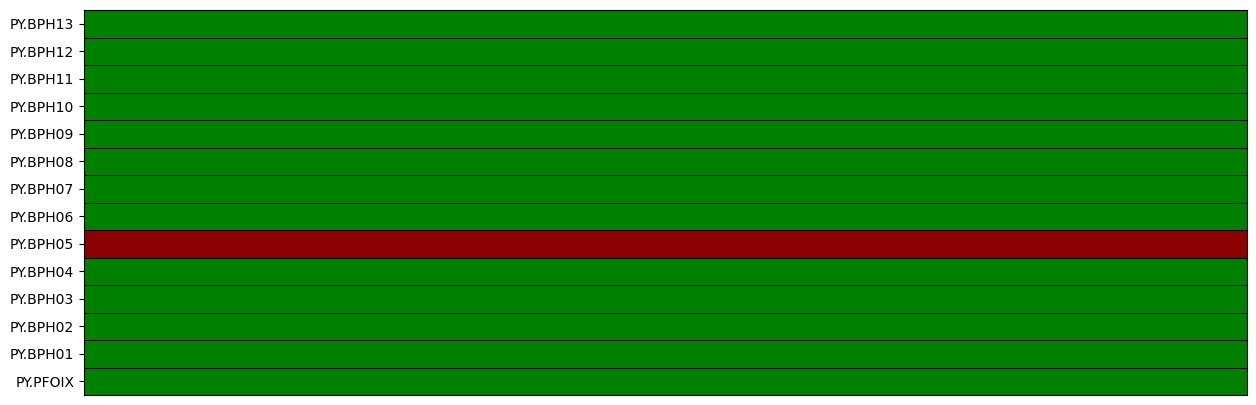


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-05T09:09:30.750300Z - 2023-04-05T09:10:30.750300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-05T09:09:30.750300Z - 2023-04-05T09:10:30.750300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-05T09:09:30.750300Z - 2023-04-05T09:10:30.750300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-05T09:09:30.750000Z - 2023-04-05T09:10:30.750000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-05T09:09:30.750000Z - 2023-04-05T09:10:30.750000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-05T09:09:30.750000Z - 2023-04-05T09:10:30.750000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-05T09:09:30.750000Z - 2023-04-05T09:10:30.750000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-05T09:09:30.750000Z - 2023-04-05T09:10:30.750000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-05T09:09:30.750000Z - 2023-04-05T09:10:30.750000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-05T09:09:30.750000Z - 2023-04-05T09:10:


 -> 160 2023-04-05 14:02:33.330000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


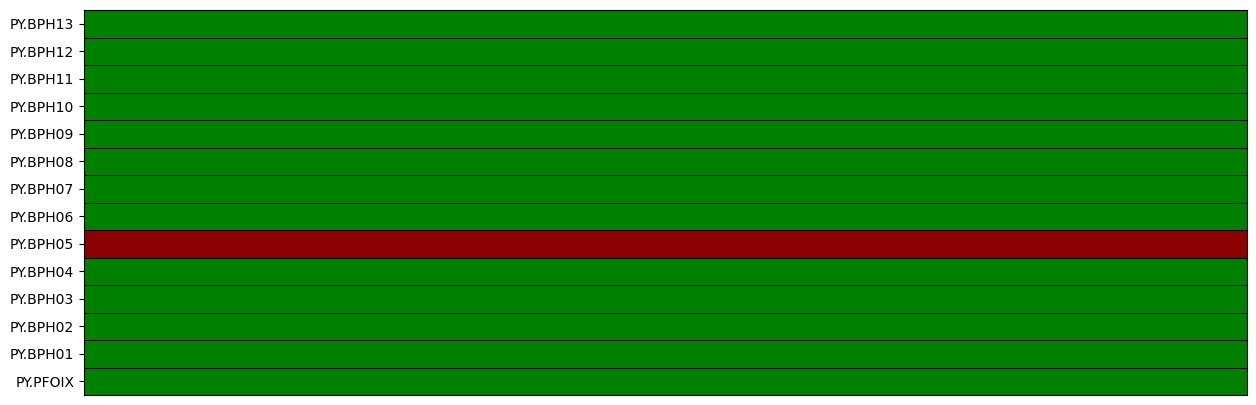


 -> Runtime: 0.77 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-05T14:02:18.332000Z - 2023-04-05T14:03:18.332000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-05T14:02:18.332000Z - 2023-04-05T14:03:18.332000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-05T14:02:18.332000Z - 2023-04-05T14:03:18.332000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-05T14:02:18.330000Z - 2023-04-05T14:03:18.330000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-05T14:02:18.330000Z - 2023-04-05T14:03:18.330000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-05T14:02:18.330000Z - 2023-04-05T14:03:18.330000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-05T14:02:18.330000Z - 2023-04-05T14:03:18.330000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-05T14:02:18.330000Z - 2023-04-05T14:03:18.330000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-05T14:02:18.330000Z - 2023-04-05T14:03:18.330000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-05T14:02:18.330000Z - 2023-04-05T14:03:


 -> 161 2023-04-06 10:45:21.050000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


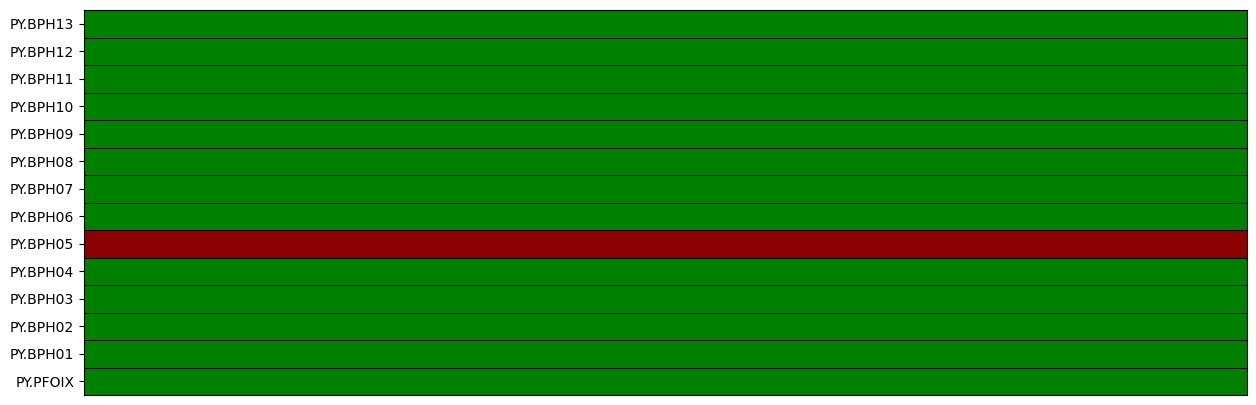


 -> Runtime: 0.73 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-06T10:45:06.052000Z - 2023-04-06T10:46:06.052000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-06T10:45:06.052000Z - 2023-04-06T10:46:06.052000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-06T10:45:06.052000Z - 2023-04-06T10:46:06.052000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-06T10:45:06.050000Z - 2023-04-06T10:46:06.050000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-06T10:45:06.050000Z - 2023-04-06T10:46:06.050000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-06T10:45:06.050000Z - 2023-04-06T10:46:06.050000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-06T10:45:06.050000Z - 2023-04-06T10:46:06.050000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-06T10:45:06.050000Z - 2023-04-06T10:46:06.050000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-06T10:45:06.050000Z - 2023-04-06T10:46:06.050000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-06T10:45:06.050000Z - 2023-04-06T10:46:


 -> 162 2023-04-07 04:30:00.640000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


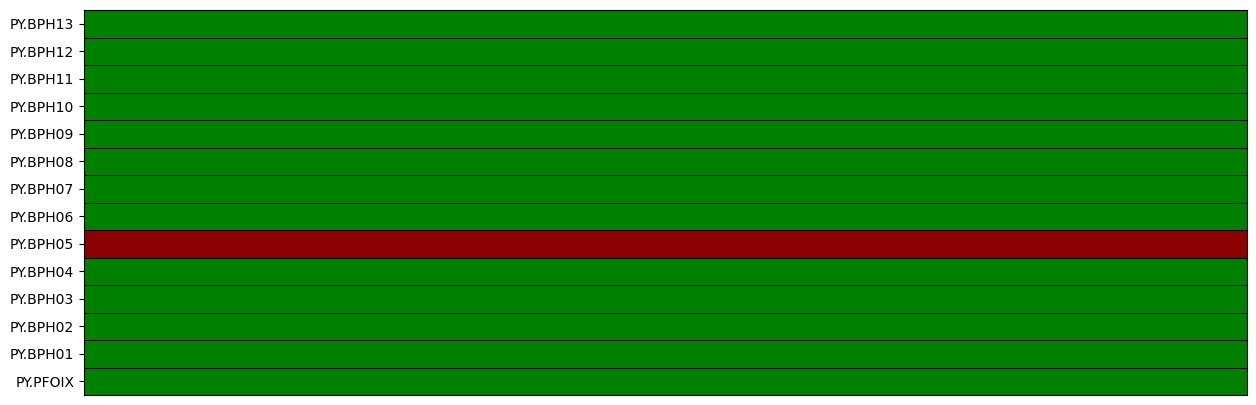


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-07T04:29:45.642100Z - 2023-04-07T04:30:45.642100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-07T04:29:45.642100Z - 2023-04-07T04:30:45.642100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-07T04:29:45.642100Z - 2023-04-07T04:30:45.642100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-07T04:29:45.640000Z - 2023-04-07T04:30:45.640000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-07T04:29:45.640000Z - 2023-04-07T04:30:45.640000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-07T04:29:45.640000Z - 2023-04-07T04:30:45.640000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-07T04:29:45.640000Z - 2023-04-07T04:30:45.640000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-07T04:29:45.640000Z - 2023-04-07T04:30:45.640000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-07T04:29:45.640000Z - 2023-04-07T04:30:45.640000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-07T04:29:45.640000Z - 2023-04-07T04:30:


 -> 163 2023-04-08 02:31:46.740000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


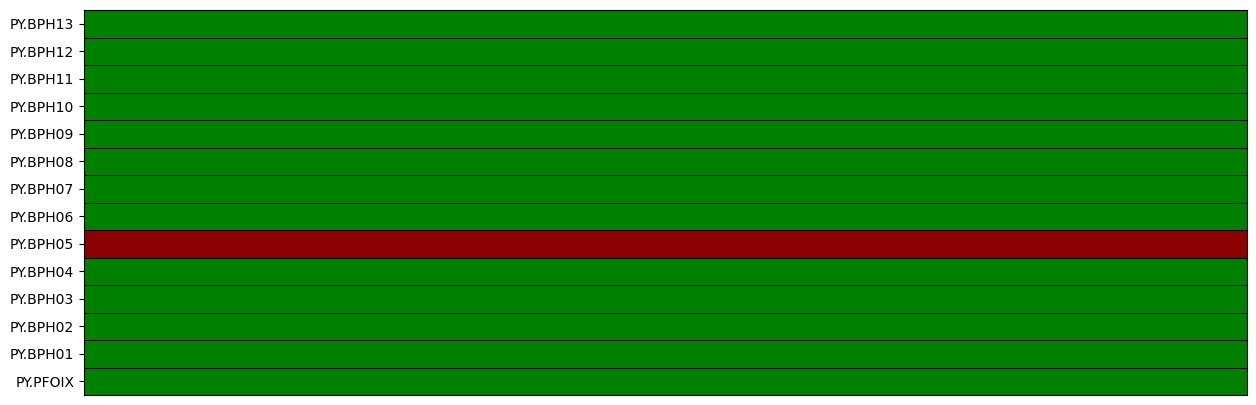


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-08T02:31:31.742000Z - 2023-04-08T02:32:31.742000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-08T02:31:31.742000Z - 2023-04-08T02:32:31.742000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-08T02:31:31.742000Z - 2023-04-08T02:32:31.742000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-08T02:31:31.740000Z - 2023-04-08T02:32:31.740000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-08T02:31:31.740000Z - 2023-04-08T02:32:31.740000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-08T02:31:31.740000Z - 2023-04-08T02:32:31.740000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-08T02:31:31.740000Z - 2023-04-08T02:32:31.740000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-08T02:31:31.740000Z - 2023-04-08T02:32:31.740000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-08T02:31:31.740000Z - 2023-04-08T02:32:31.740000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-08T02:31:31.740000Z - 2023-04-08T02:32:


 -> 164 2023-04-08 15:05:15.180000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


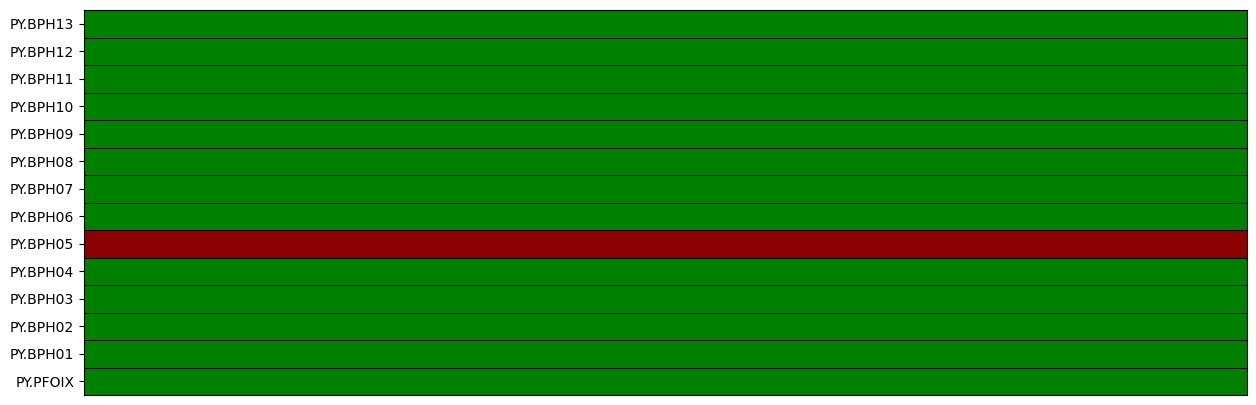


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-08T15:05:00.182000Z - 2023-04-08T15:06:00.182000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-08T15:05:00.182000Z - 2023-04-08T15:06:00.182000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-08T15:05:00.182000Z - 2023-04-08T15:06:00.182000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-08T15:05:00.180000Z - 2023-04-08T15:06:00.180000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-08T15:05:00.180000Z - 2023-04-08T15:06:00.180000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-08T15:05:00.180000Z - 2023-04-08T15:06:00.180000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-08T15:05:00.180000Z - 2023-04-08T15:06:00.180000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-08T15:05:00.180000Z - 2023-04-08T15:06:00.180000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-08T15:05:00.180000Z - 2023-04-08T15:06:00.180000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-08T15:05:00.180000Z - 2023-04-08T15:06:


 -> 165 2023-04-10 14:50:54.400000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


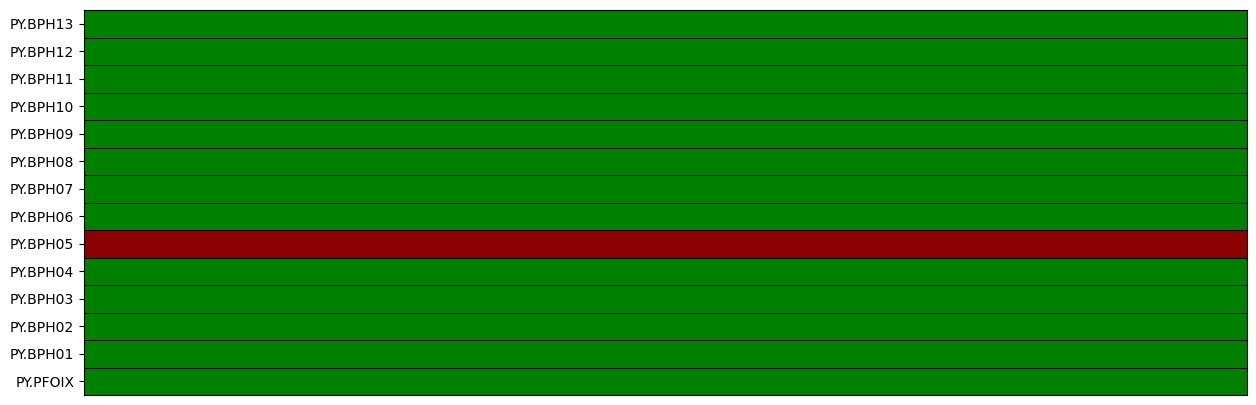


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-10T14:50:39.401800Z - 2023-04-10T14:51:39.401800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-10T14:50:39.401800Z - 2023-04-10T14:51:39.401800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-10T14:50:39.401800Z - 2023-04-10T14:51:39.401800Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-10T14:50:39.400000Z - 2023-04-10T14:51:39.400000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-10T14:50:39.400000Z - 2023-04-10T14:51:39.400000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-10T14:50:39.400000Z - 2023-04-10T14:51:39.400000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-10T14:50:39.400000Z - 2023-04-10T14:51:39.400000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-10T14:50:39.400000Z - 2023-04-10T14:51:39.400000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-10T14:50:39.400000Z - 2023-04-10T14:51:39.400000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-10T14:50:39.400000Z - 2023-04-10T14:51:


 -> 166 2023-04-10 20:40:43.210000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


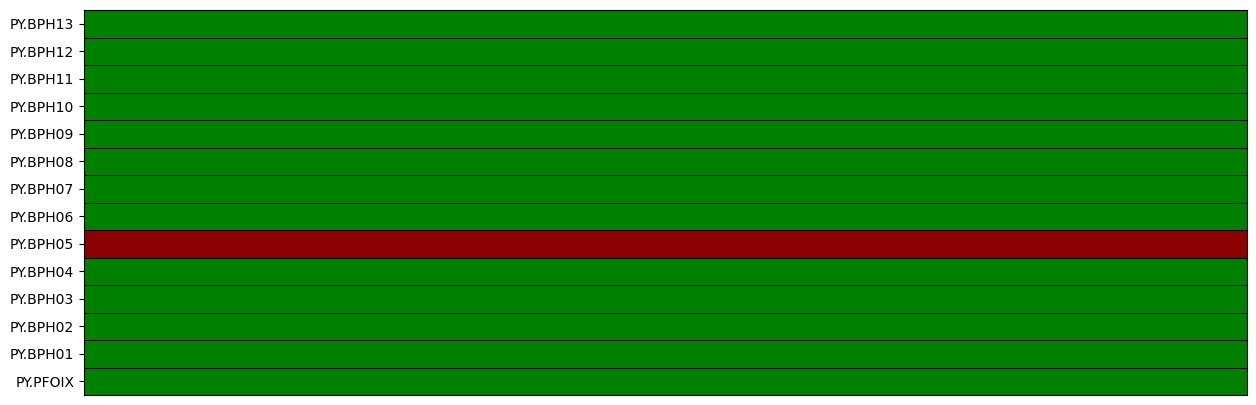


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-10T20:40:28.208800Z - 2023-04-10T20:41:28.208800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-10T20:40:28.208800Z - 2023-04-10T20:41:28.208800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-10T20:40:28.208800Z - 2023-04-10T20:41:28.208800Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-10T20:40:28.210000Z - 2023-04-10T20:41:28.210000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-10T20:40:28.210000Z - 2023-04-10T20:41:28.210000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-10T20:40:28.210000Z - 2023-04-10T20:41:28.210000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-10T20:40:28.210000Z - 2023-04-10T20:41:28.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-10T20:40:28.210000Z - 2023-04-10T20:41:28.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-10T20:40:28.210000Z - 2023-04-10T20:41:28.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-10T20:40:28.210000Z - 2023-04-10T20:41:


 -> 167 2023-04-12 02:34:16.160000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


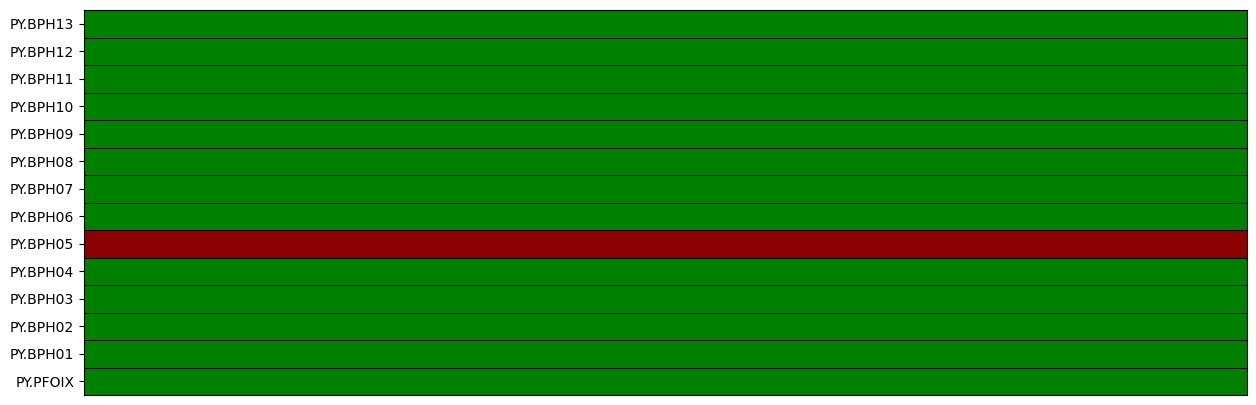


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-12T02:34:01.161000Z - 2023-04-12T02:35:01.161000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-12T02:34:01.161000Z - 2023-04-12T02:35:01.161000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-12T02:34:01.161000Z - 2023-04-12T02:35:01.161000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-12T02:34:01.160000Z - 2023-04-12T02:35:01.160000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-12T02:34:01.160000Z - 2023-04-12T02:35:01.160000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-12T02:34:01.160000Z - 2023-04-12T02:35:01.160000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-12T02:34:01.160000Z - 2023-04-12T02:35:01.160000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-12T02:34:01.160000Z - 2023-04-12T02:35:01.160000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-12T02:34:01.160000Z - 2023-04-12T02:35:01.160000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-12T02:34:01.160000Z - 2023-04-12T02:35:


 -> 168 2023-04-13 00:01:31.900000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


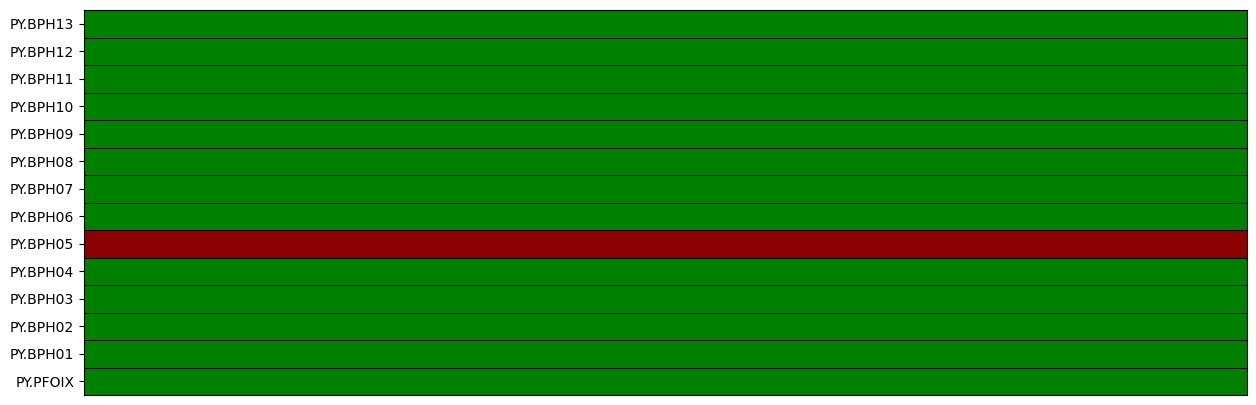


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-13T00:01:16.901800Z - 2023-04-13T00:02:16.901800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-13T00:01:16.901800Z - 2023-04-13T00:02:16.901800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-13T00:01:16.901800Z - 2023-04-13T00:02:16.901800Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-13T00:01:16.900000Z - 2023-04-13T00:02:16.900000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-13T00:01:16.900000Z - 2023-04-13T00:02:16.900000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-13T00:01:16.900000Z - 2023-04-13T00:02:16.900000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-13T00:01:16.900000Z - 2023-04-13T00:02:16.900000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-13T00:01:16.900000Z - 2023-04-13T00:02:16.900000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-13T00:01:16.900000Z - 2023-04-13T00:02:16.900000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-13T00:01:16.900000Z - 2023-04-13T00:02:


 -> 169 2023-04-13 00:52:21.540000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


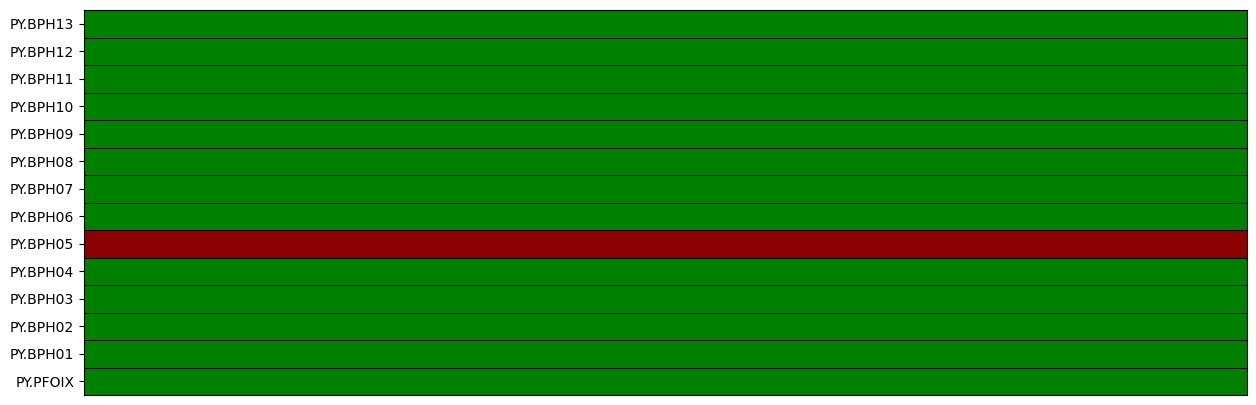


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-13T00:52:06.541800Z - 2023-04-13T00:53:06.541800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-13T00:52:06.541800Z - 2023-04-13T00:53:06.541800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-13T00:52:06.541800Z - 2023-04-13T00:53:06.541800Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-13T00:52:06.540000Z - 2023-04-13T00:53:06.540000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-13T00:52:06.540000Z - 2023-04-13T00:53:06.540000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-13T00:52:06.540000Z - 2023-04-13T00:53:06.540000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-13T00:52:06.540000Z - 2023-04-13T00:53:06.540000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-13T00:52:06.540000Z - 2023-04-13T00:53:06.540000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-13T00:52:06.540000Z - 2023-04-13T00:53:06.540000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-13T00:52:06.540000Z - 2023-04-13T00:53:


 -> 170 2023-04-16 16:13:50.220000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


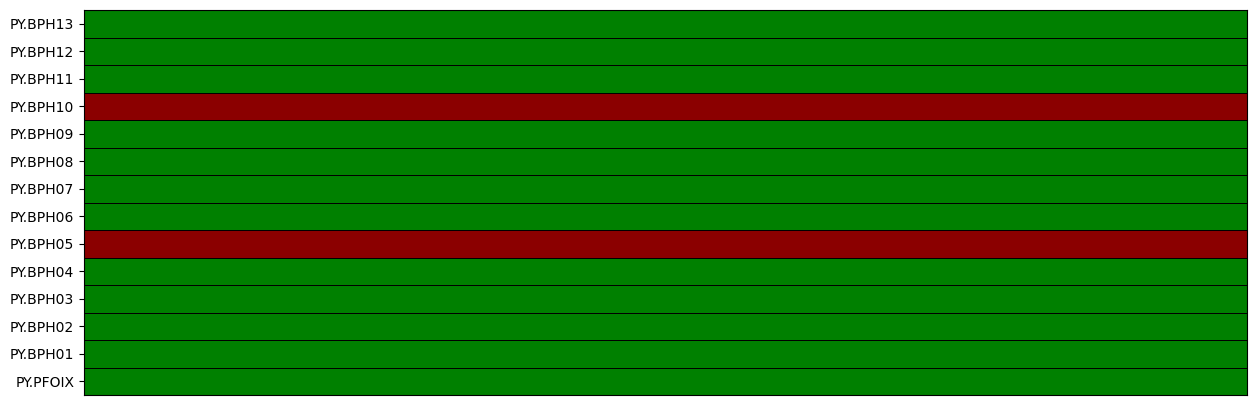


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-16T16:13:35.221700Z - 2023-04-16T16:14:35.221700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-16T16:13:35.221700Z - 2023-04-16T16:14:35.221700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-16T16:13:35.221700Z - 2023-04-16T16:14:35.221700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-16T16:13:35.220000Z - 2023-04-16T16:14:35.220000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-16T16:13:35.220000Z - 2023-04-16T16:14:35.220000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-16T16:13:35.220000Z - 2023-04-16T16:14:35.220000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-16T16:13:35.220000Z - 2023-04-16T16:14:35.220000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-16T16:13:35.220000Z - 2023-04-16T16:14:35.220000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-16T16:13:35.220000Z - 2023-04-16T16:14:35.220000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-16T16:13:35.220000Z - 2023-04-16T16:14:


 -> 171 2023-04-17 18:52:36.930000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


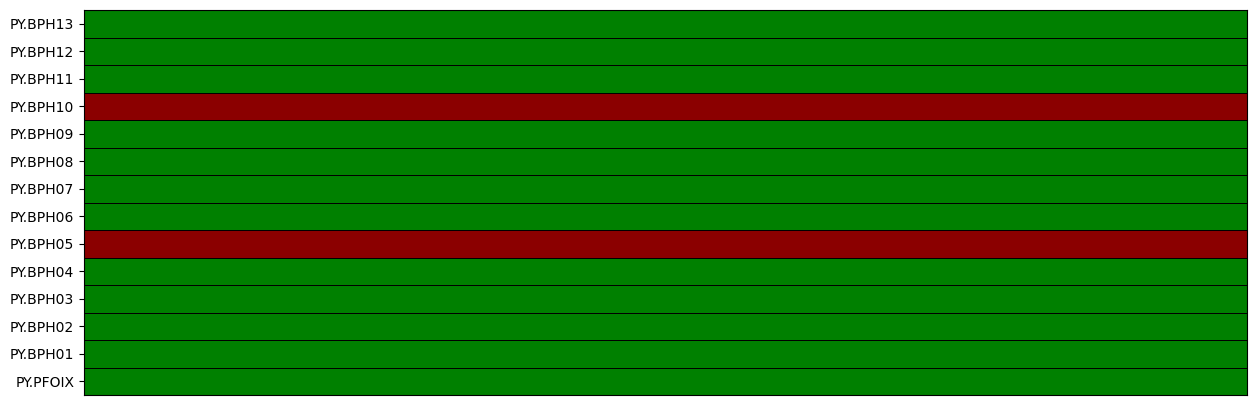


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-17T18:52:21.931700Z - 2023-04-17T18:53:21.931700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-17T18:52:21.931700Z - 2023-04-17T18:53:21.931700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-17T18:52:21.931700Z - 2023-04-17T18:53:21.931700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-17T18:52:21.930000Z - 2023-04-17T18:53:21.930000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-17T18:52:21.930000Z - 2023-04-17T18:53:21.930000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-17T18:52:21.930000Z - 2023-04-17T18:53:21.930000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-17T18:52:21.930000Z - 2023-04-17T18:53:21.930000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-17T18:52:21.930000Z - 2023-04-17T18:53:21.930000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-17T18:52:21.930000Z - 2023-04-17T18:53:21.930000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-17T18:52:21.930000Z - 2023-04-17T18:53:


 -> 172 2023-04-18 10:03:29.380000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


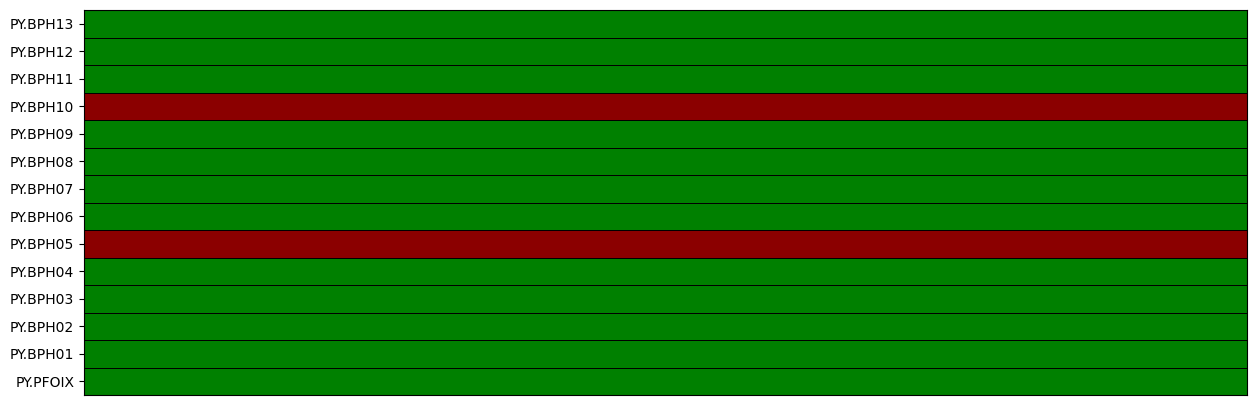


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-18T10:03:14.381700Z - 2023-04-18T10:04:14.381700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-18T10:03:14.381700Z - 2023-04-18T10:04:14.381700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-18T10:03:14.381700Z - 2023-04-18T10:04:14.381700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-18T10:03:14.380000Z - 2023-04-18T10:04:14.380000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-18T10:03:14.380000Z - 2023-04-18T10:04:14.380000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-18T10:03:14.380000Z - 2023-04-18T10:04:14.380000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-18T10:03:14.380000Z - 2023-04-18T10:04:14.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-18T10:03:14.380000Z - 2023-04-18T10:04:14.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-18T10:03:14.380000Z - 2023-04-18T10:04:14.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-18T10:03:14.380000Z - 2023-04-18T10:04:


 -> 173 2023-04-20 04:26:02.940000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


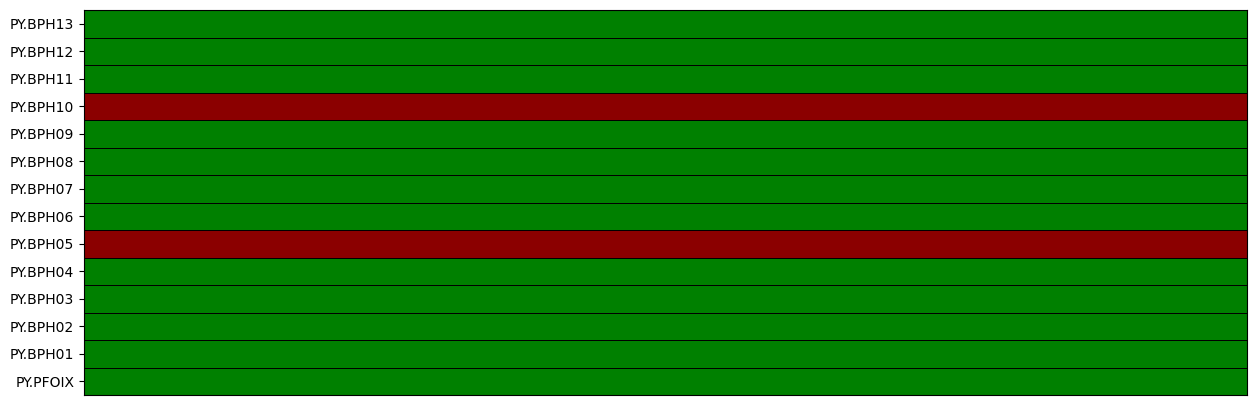


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-20T04:25:47.938900Z - 2023-04-20T04:26:47.938900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-20T04:25:47.938900Z - 2023-04-20T04:26:47.938900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-20T04:25:47.938900Z - 2023-04-20T04:26:47.938900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-20T04:25:47.940000Z - 2023-04-20T04:26:47.940000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-20T04:25:47.940000Z - 2023-04-20T04:26:47.940000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-20T04:25:47.940000Z - 2023-04-20T04:26:47.940000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-20T04:25:47.940000Z - 2023-04-20T04:26:47.940000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-20T04:25:47.940000Z - 2023-04-20T04:26:47.940000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-20T04:25:47.940000Z - 2023-04-20T04:26:47.940000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-20T04:25:47.940000Z - 2023-04-20T04:26:


 -> 174 2023-04-21 05:58:29.320000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


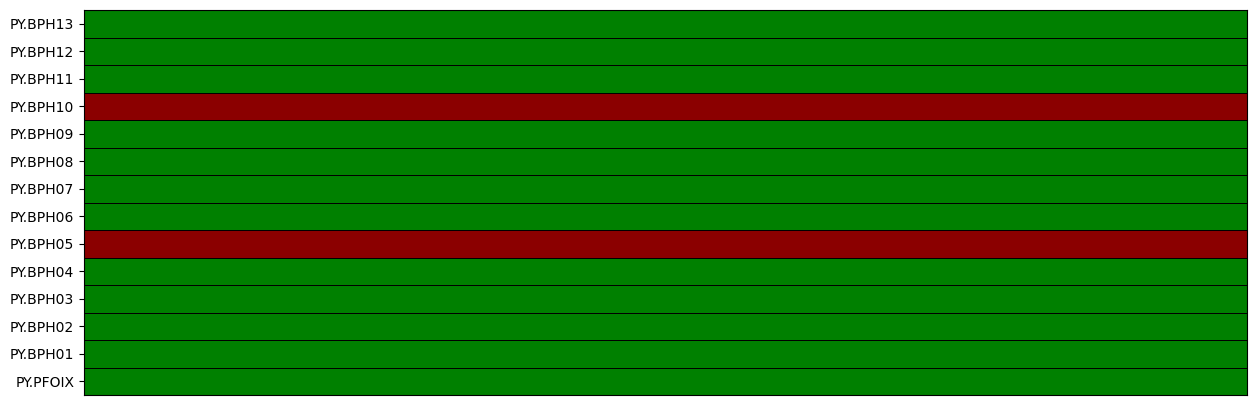


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-21T05:58:14.317900Z - 2023-04-21T05:59:14.317900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-21T05:58:14.317900Z - 2023-04-21T05:59:14.317900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-21T05:58:14.317900Z - 2023-04-21T05:59:14.317900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-21T05:58:14.320000Z - 2023-04-21T05:59:14.320000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-21T05:58:14.320000Z - 2023-04-21T05:59:14.320000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-21T05:58:14.320000Z - 2023-04-21T05:59:14.320000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-21T05:58:14.320000Z - 2023-04-21T05:59:14.320000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-21T05:58:14.320000Z - 2023-04-21T05:59:14.320000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-21T05:58:14.320000Z - 2023-04-21T05:59:14.320000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-21T05:58:14.320000Z - 2023-04-21T05:59:


 -> 175 2023-04-22 17:24:34.470000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


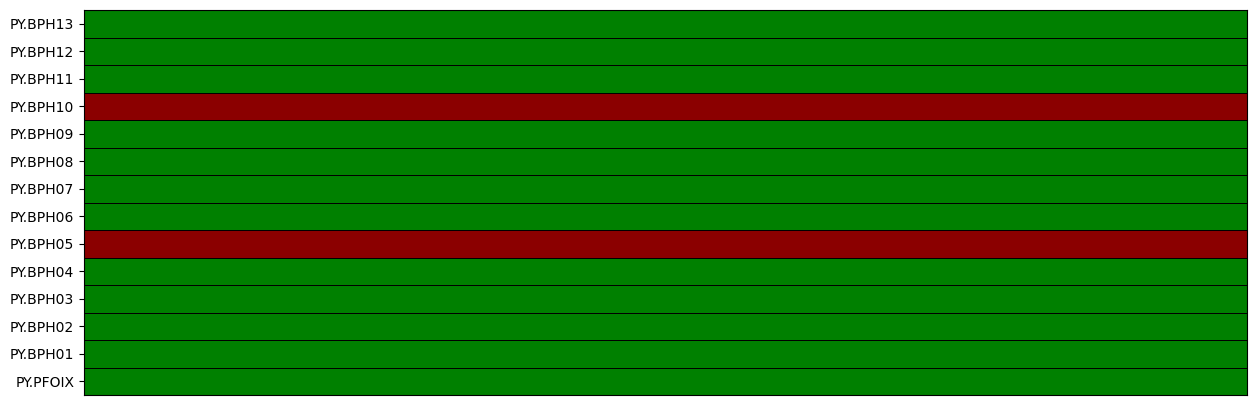


 -> Runtime: 0.74 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-22T17:24:19.467900Z - 2023-04-22T17:25:19.467900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-22T17:24:19.467900Z - 2023-04-22T17:25:19.467900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-22T17:24:19.467900Z - 2023-04-22T17:25:19.467900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-22T17:24:19.470000Z - 2023-04-22T17:25:19.470000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-22T17:24:19.470000Z - 2023-04-22T17:25:19.470000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-22T17:24:19.470000Z - 2023-04-22T17:25:19.470000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-22T17:24:19.470000Z - 2023-04-22T17:25:19.470000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-22T17:24:19.470000Z - 2023-04-22T17:25:19.470000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-22T17:24:19.470000Z - 2023-04-22T17:25:19.470000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-22T17:24:19.470000Z - 2023-04-22T17:25:


 -> 176 2023-04-24 04:48:39.760000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


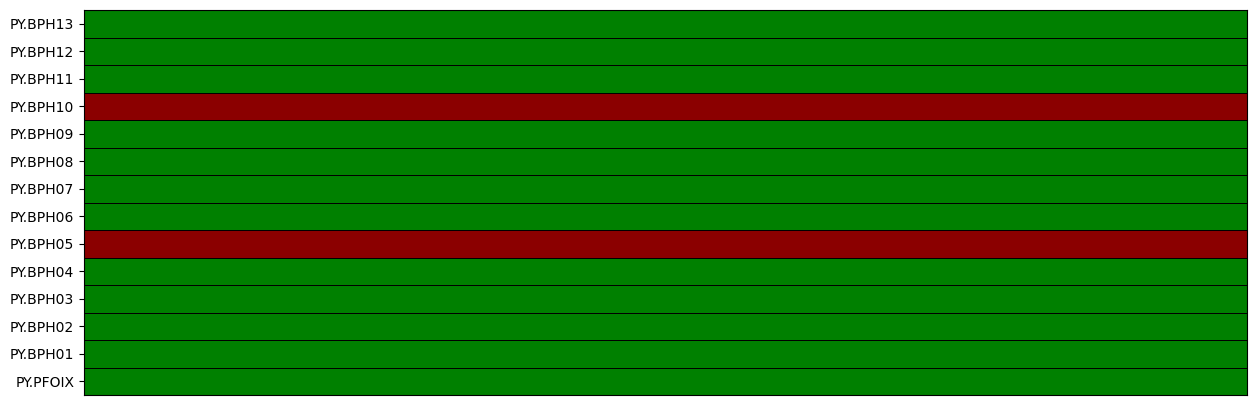


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-24T04:48:24.758400Z - 2023-04-24T04:49:24.758400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-24T04:48:24.758400Z - 2023-04-24T04:49:24.758400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-24T04:48:24.758400Z - 2023-04-24T04:49:24.758400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-24T04:48:24.760000Z - 2023-04-24T04:49:24.760000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-24T04:48:24.760000Z - 2023-04-24T04:49:24.760000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-24T04:48:24.760000Z - 2023-04-24T04:49:24.760000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-24T04:48:24.760000Z - 2023-04-24T04:49:24.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-24T04:48:24.760000Z - 2023-04-24T04:49:24.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-24T04:48:24.760000Z - 2023-04-24T04:49:24.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-24T04:48:24.760000Z - 2023-04-24T04:49:


 -> 177 2023-04-24 15:19:56.380000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


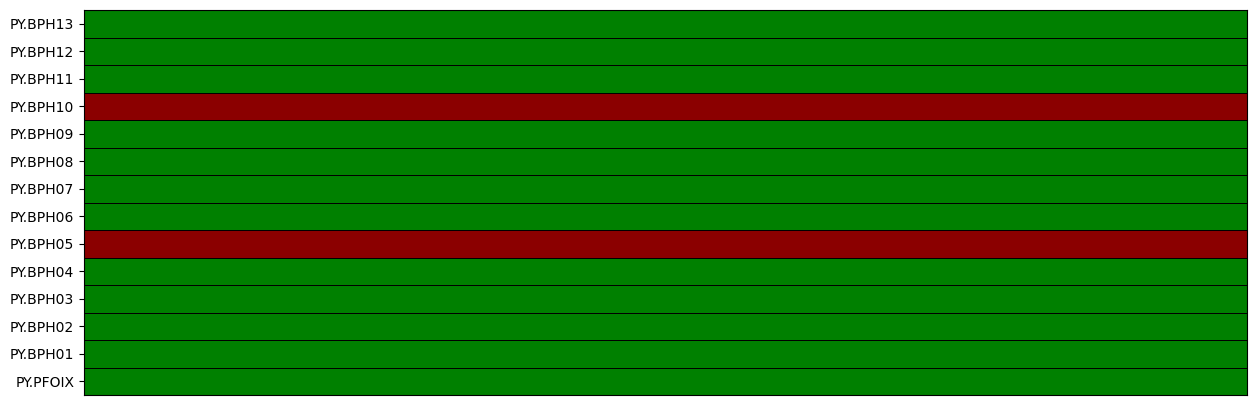


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-24T15:19:41.378400Z - 2023-04-24T15:20:41.378400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-24T15:19:41.378400Z - 2023-04-24T15:20:41.378400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-24T15:19:41.378400Z - 2023-04-24T15:20:41.378400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-24T15:19:41.380000Z - 2023-04-24T15:20:41.380000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-24T15:19:41.380000Z - 2023-04-24T15:20:41.380000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-24T15:19:41.380000Z - 2023-04-24T15:20:41.380000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-24T15:19:41.380000Z - 2023-04-24T15:20:41.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-24T15:19:41.380000Z - 2023-04-24T15:20:41.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-24T15:19:41.380000Z - 2023-04-24T15:20:41.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-24T15:19:41.380000Z - 2023-04-24T15:20:


 -> 178 2023-04-24 16:38:11.080000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


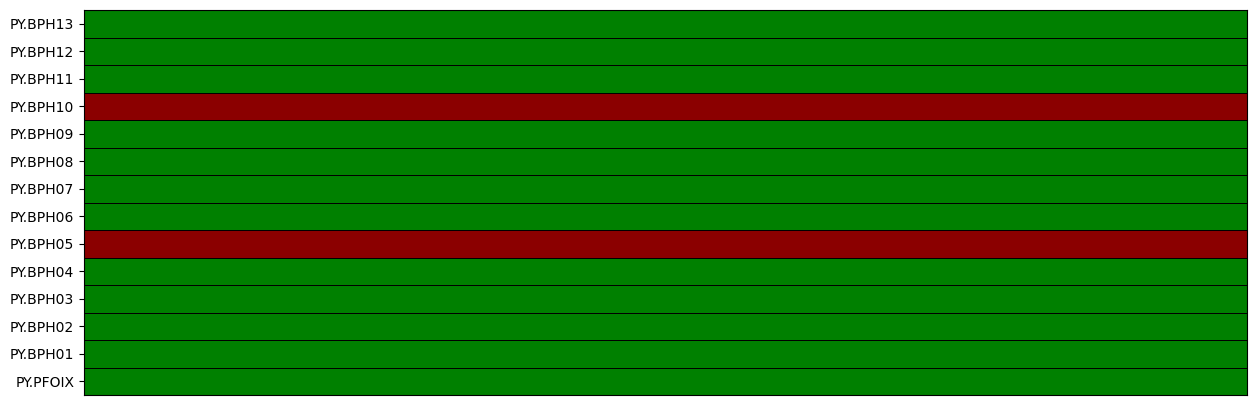


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-24T16:37:56.078400Z - 2023-04-24T16:38:56.078400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-24T16:37:56.078400Z - 2023-04-24T16:38:56.078400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-24T16:37:56.078400Z - 2023-04-24T16:38:56.078400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-24T16:37:56.080000Z - 2023-04-24T16:38:56.080000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-24T16:37:56.080000Z - 2023-04-24T16:38:56.080000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-24T16:37:56.080000Z - 2023-04-24T16:38:56.080000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-24T16:37:56.080000Z - 2023-04-24T16:38:56.080000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-24T16:37:56.080000Z - 2023-04-24T16:38:56.080000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-24T16:37:56.080000Z - 2023-04-24T16:38:56.080000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-24T16:37:56.080000Z - 2023-04-24T16:38:


 -> 179 2023-04-25 11:55:47.190000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


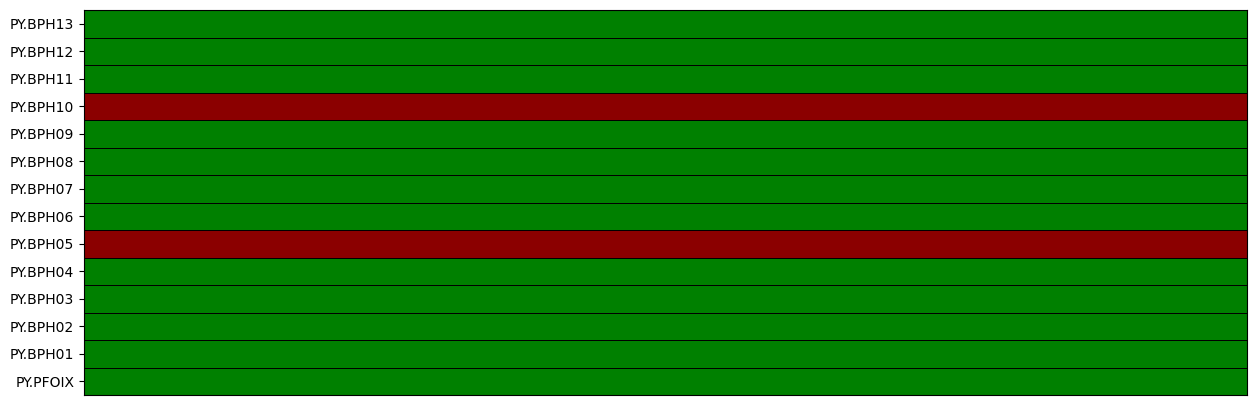


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-25T11:55:32.190400Z - 2023-04-25T11:56:32.190400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-25T11:55:32.190400Z - 2023-04-25T11:56:32.190400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-25T11:55:32.190400Z - 2023-04-25T11:56:32.190400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-25T11:55:32.190000Z - 2023-04-25T11:56:32.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-25T11:55:32.190000Z - 2023-04-25T11:56:32.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-25T11:55:32.190000Z - 2023-04-25T11:56:32.190000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-25T11:55:32.190000Z - 2023-04-25T11:56:32.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-25T11:55:32.190000Z - 2023-04-25T11:56:32.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-25T11:55:32.190000Z - 2023-04-25T11:56:32.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-25T11:55:32.190000Z - 2023-04-25T11:56:


 -> 180 2023-04-25 11:57:29.970000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


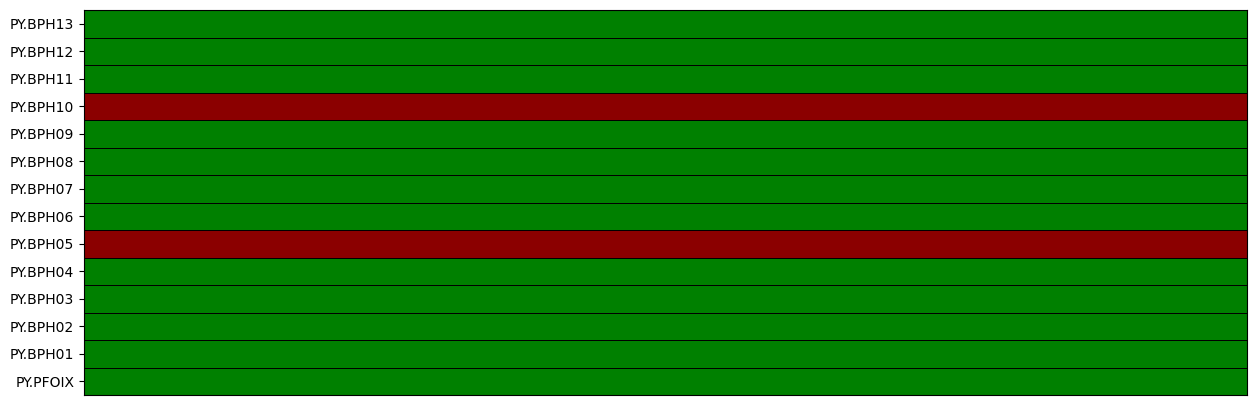


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-25T11:57:14.970400Z - 2023-04-25T11:58:14.970400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-25T11:57:14.970400Z - 2023-04-25T11:58:14.970400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-25T11:57:14.970400Z - 2023-04-25T11:58:14.970400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-25T11:57:14.970000Z - 2023-04-25T11:58:14.970000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-25T11:57:14.970000Z - 2023-04-25T11:58:14.970000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-25T11:57:14.970000Z - 2023-04-25T11:58:14.970000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-25T11:57:14.970000Z - 2023-04-25T11:58:14.970000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-25T11:57:14.970000Z - 2023-04-25T11:58:14.970000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-25T11:57:14.970000Z - 2023-04-25T11:58:14.970000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-25T11:57:14.970000Z - 2023-04-25T11:58:


 -> 181 2023-04-26 06:46:58.450000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


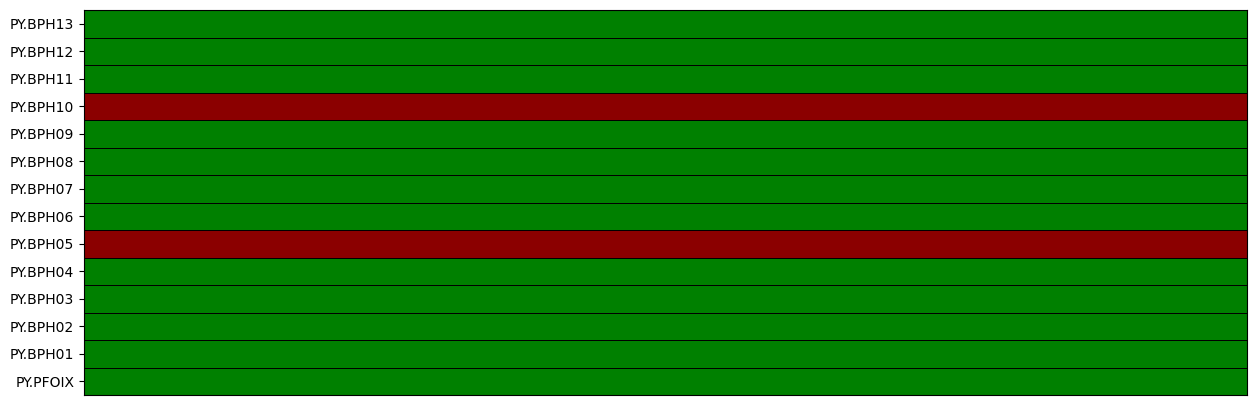


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-26T06:46:43.448400Z - 2023-04-26T06:47:43.448400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-26T06:46:43.448400Z - 2023-04-26T06:47:43.448400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-26T06:46:43.448400Z - 2023-04-26T06:47:43.448400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-26T06:46:43.450000Z - 2023-04-26T06:47:43.450000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-26T06:46:43.450000Z - 2023-04-26T06:47:43.450000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-26T06:46:43.450000Z - 2023-04-26T06:47:43.450000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-26T06:46:43.450000Z - 2023-04-26T06:47:43.450000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-26T06:46:43.450000Z - 2023-04-26T06:47:43.450000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-26T06:46:43.450000Z - 2023-04-26T06:47:43.450000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-26T06:46:43.450000Z - 2023-04-26T06:47:


 -> 182 2023-04-27 02:18:01.040000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


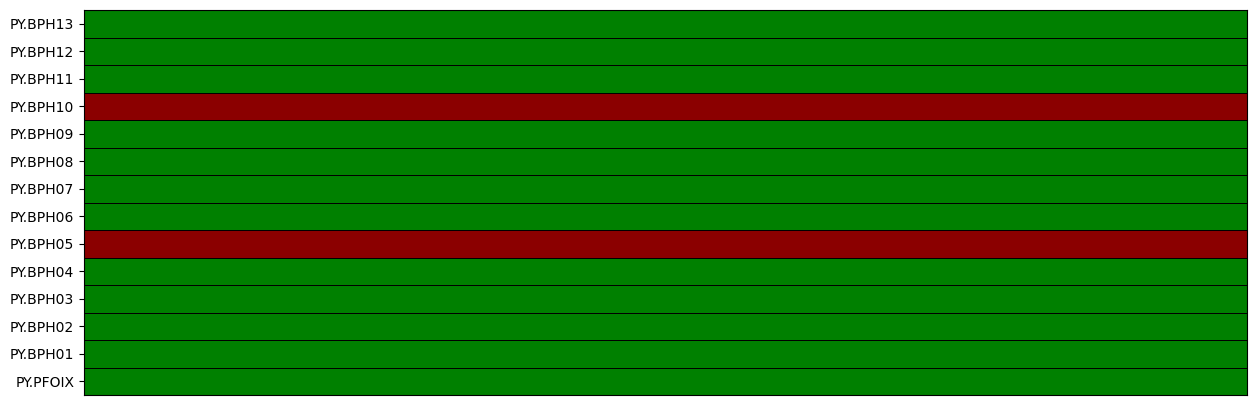


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-27T02:17:46.038300Z - 2023-04-27T02:18:46.038300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-27T02:17:46.038300Z - 2023-04-27T02:18:46.038300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-27T02:17:46.038300Z - 2023-04-27T02:18:46.038300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-27T02:17:46.040000Z - 2023-04-27T02:18:46.040000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-27T02:17:46.040000Z - 2023-04-27T02:18:46.040000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-27T02:17:46.040000Z - 2023-04-27T02:18:46.040000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-27T02:17:46.040000Z - 2023-04-27T02:18:46.040000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-27T02:17:46.040000Z - 2023-04-27T02:18:46.040000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-27T02:17:46.040000Z - 2023-04-27T02:18:46.040000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-27T02:17:46.040000Z - 2023-04-27T02:18:


 -> 183 2023-04-27 10:01:52.470000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


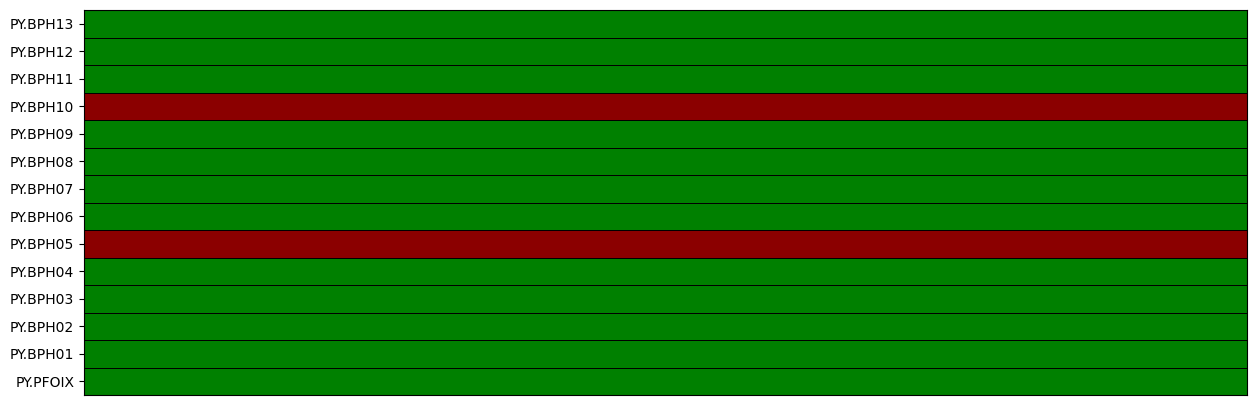


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-27T10:01:37.468300Z - 2023-04-27T10:02:37.468300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-27T10:01:37.468300Z - 2023-04-27T10:02:37.468300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-27T10:01:37.468300Z - 2023-04-27T10:02:37.468300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-27T10:01:37.470000Z - 2023-04-27T10:02:37.470000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-27T10:01:37.470000Z - 2023-04-27T10:02:37.470000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-27T10:01:37.470000Z - 2023-04-27T10:02:37.470000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-27T10:01:37.470000Z - 2023-04-27T10:02:37.470000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-27T10:01:37.470000Z - 2023-04-27T10:02:37.470000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-27T10:01:37.470000Z - 2023-04-27T10:02:37.470000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-27T10:01:37.470000Z - 2023-04-27T10:02:


 -> 184 2023-04-28 18:53:05.460000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


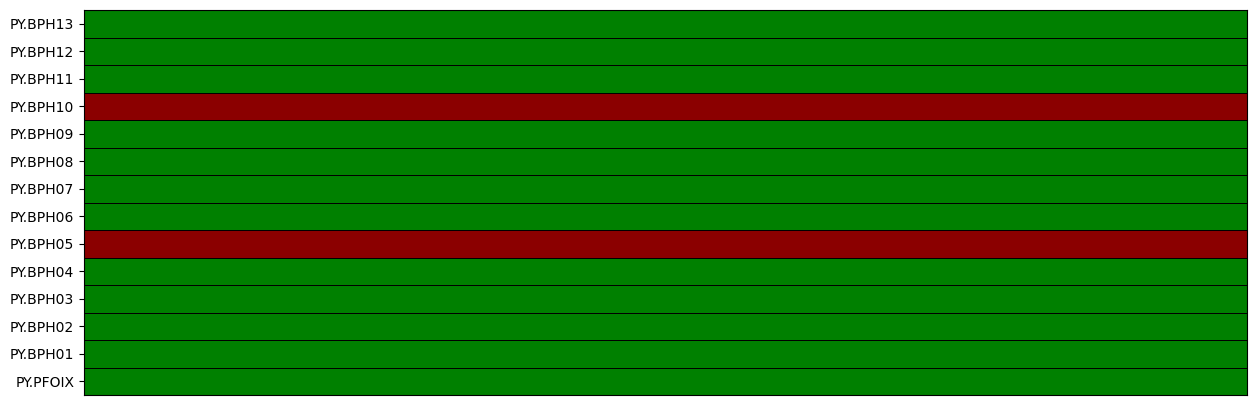


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-28T18:52:50.458300Z - 2023-04-28T18:53:50.458300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-28T18:52:50.458300Z - 2023-04-28T18:53:50.458300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-28T18:52:50.458300Z - 2023-04-28T18:53:50.458300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-28T18:52:50.460000Z - 2023-04-28T18:53:50.460000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-28T18:52:50.460000Z - 2023-04-28T18:53:50.460000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-28T18:52:50.460000Z - 2023-04-28T18:53:50.460000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-28T18:52:50.460000Z - 2023-04-28T18:53:50.460000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-28T18:52:50.460000Z - 2023-04-28T18:53:50.460000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-28T18:52:50.460000Z - 2023-04-28T18:53:50.460000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-28T18:52:50.460000Z - 2023-04-28T18:53:


 -> 185 2023-04-29 00:27:39.340000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


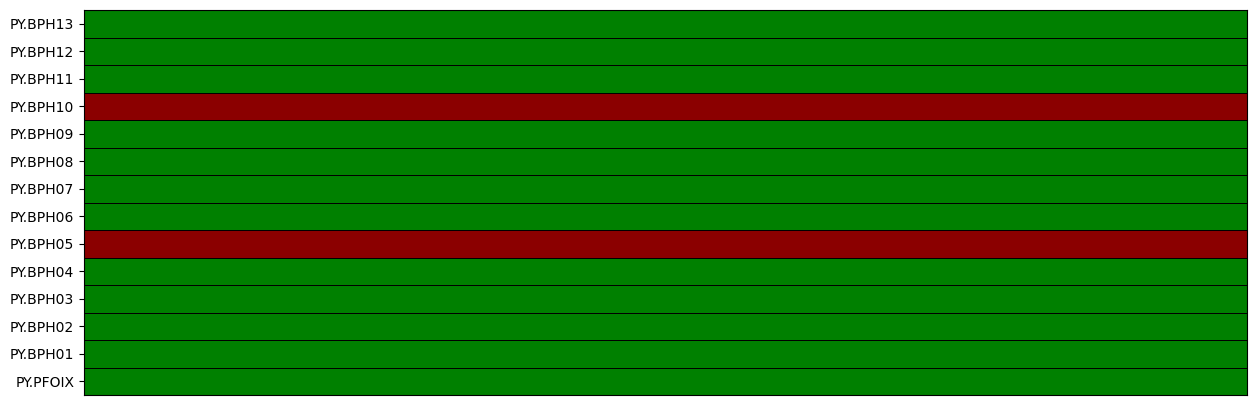


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-29T00:27:24.338300Z - 2023-04-29T00:28:24.338300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-29T00:27:24.338300Z - 2023-04-29T00:28:24.338300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-29T00:27:24.338300Z - 2023-04-29T00:28:24.338300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-29T00:27:24.340000Z - 2023-04-29T00:28:24.340000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-29T00:27:24.340000Z - 2023-04-29T00:28:24.340000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-29T00:27:24.340000Z - 2023-04-29T00:28:24.340000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-29T00:27:24.340000Z - 2023-04-29T00:28:24.340000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-29T00:27:24.340000Z - 2023-04-29T00:28:24.340000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-29T00:27:24.340000Z - 2023-04-29T00:28:24.340000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-29T00:27:24.340000Z - 2023-04-29T00:28:


 -> 186 2023-04-29 21:23:33.630000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


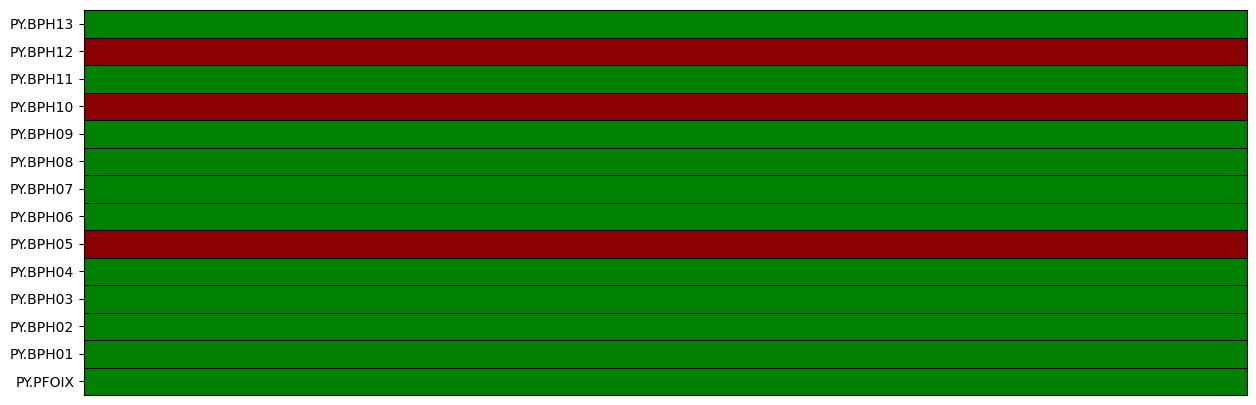


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-29T21:23:18.628300Z - 2023-04-29T21:24:18.628300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-29T21:23:18.628300Z - 2023-04-29T21:24:18.628300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-29T21:23:18.628300Z - 2023-04-29T21:24:18.628300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-29T21:23:18.630000Z - 2023-04-29T21:24:18.630000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-29T21:23:18.630000Z - 2023-04-29T21:24:18.630000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-29T21:23:18.630000Z - 2023-04-29T21:24:18.630000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-29T21:23:18.630000Z - 2023-04-29T21:24:18.630000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-29T21:23:18.630000Z - 2023-04-29T21:24:18.630000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-29T21:23:18.630000Z - 2023-04-29T21:24:18.630000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-29T21:23:18.630000Z - 2023-04-29T21:24:


 -> 187 2023-04-30 07:27:16.590000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


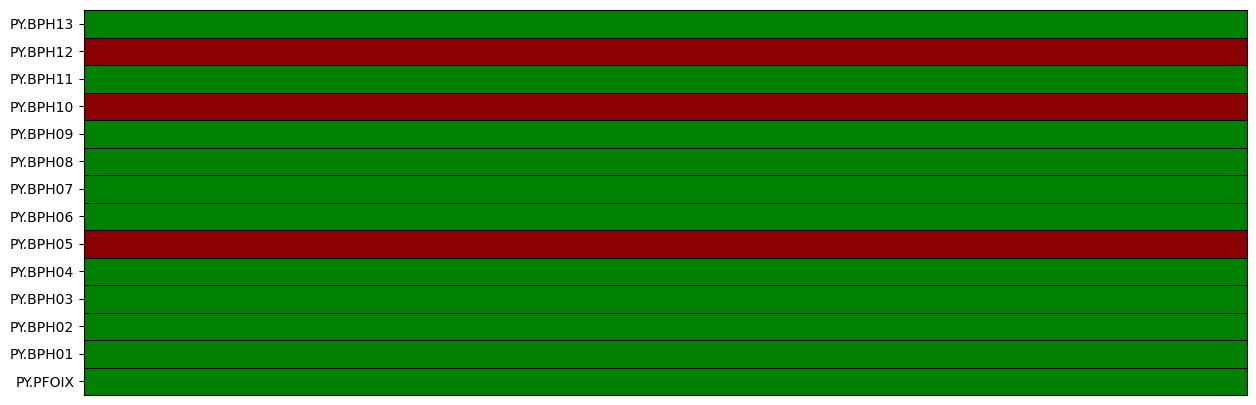


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-30T07:27:01.588300Z - 2023-04-30T07:28:01.588300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-30T07:27:01.588300Z - 2023-04-30T07:28:01.588300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-30T07:27:01.588300Z - 2023-04-30T07:28:01.588300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-30T07:27:01.590000Z - 2023-04-30T07:28:01.590000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-30T07:27:01.590000Z - 2023-04-30T07:28:01.590000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-30T07:27:01.590000Z - 2023-04-30T07:28:01.590000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-30T07:27:01.590000Z - 2023-04-30T07:28:01.590000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-30T07:27:01.590000Z - 2023-04-30T07:28:01.590000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-30T07:27:01.590000Z - 2023-04-30T07:28:01.590000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-30T07:27:01.590000Z - 2023-04-30T07:28:


 -> 188 2023-04-30 22:11:15.960000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


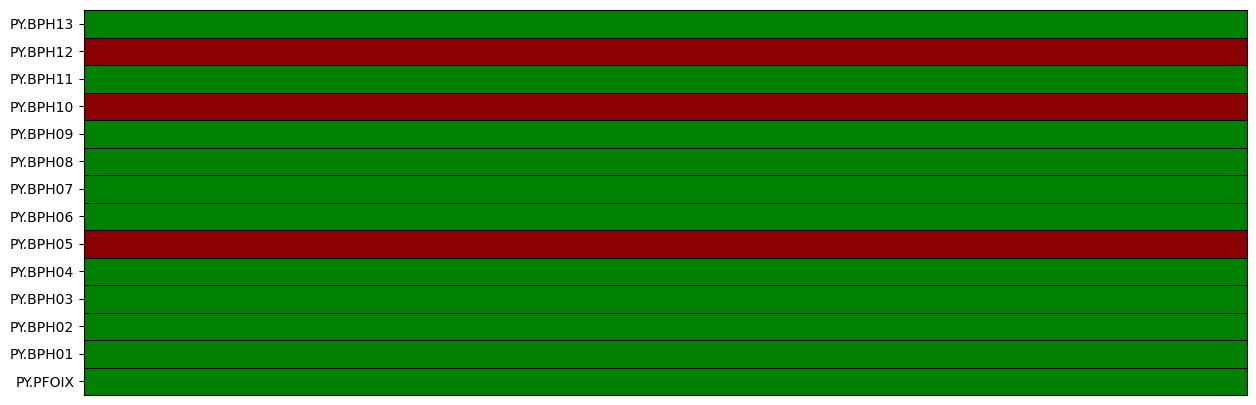


 -> Runtime: 0.62 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-04-30T22:11:00.961400Z - 2023-04-30T22:12:00.961400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-04-30T22:11:00.961400Z - 2023-04-30T22:12:00.961400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-04-30T22:11:00.961400Z - 2023-04-30T22:12:00.961400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-04-30T22:11:00.960000Z - 2023-04-30T22:12:00.960000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-04-30T22:11:00.960000Z - 2023-04-30T22:12:00.960000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-04-30T22:11:00.960000Z - 2023-04-30T22:12:00.960000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-04-30T22:11:00.960000Z - 2023-04-30T22:12:00.960000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-04-30T22:11:00.960000Z - 2023-04-30T22:12:00.960000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-04-30T22:11:00.960000Z - 2023-04-30T22:12:00.960000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-04-30T22:11:00.960000Z - 2023-04-30T22:12:


 -> 189 2023-05-01 13:49:05.710000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


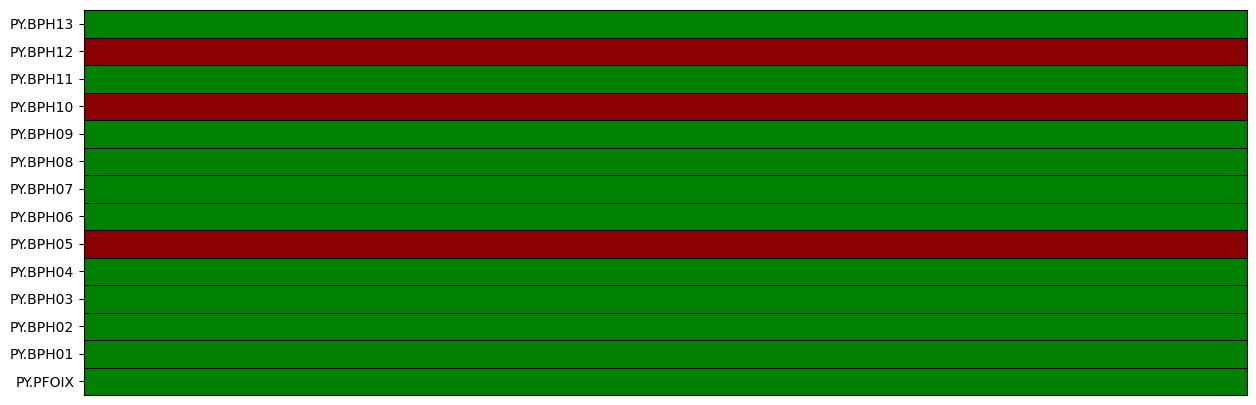


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-01T13:48:50.711400Z - 2023-05-01T13:49:50.711400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-01T13:48:50.711400Z - 2023-05-01T13:49:50.711400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-01T13:48:50.711400Z - 2023-05-01T13:49:50.711400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-01T13:48:50.710000Z - 2023-05-01T13:49:50.710000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-01T13:48:50.710000Z - 2023-05-01T13:49:50.710000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-01T13:48:50.710000Z - 2023-05-01T13:49:50.710000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-01T13:48:50.710000Z - 2023-05-01T13:49:50.710000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-01T13:48:50.710000Z - 2023-05-01T13:49:50.710000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-01T13:48:50.710000Z - 2023-05-01T13:49:50.710000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-01T13:48:50.710000Z - 2023-05-01T13:49:


 -> 190 2023-05-01 21:44:44.310000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


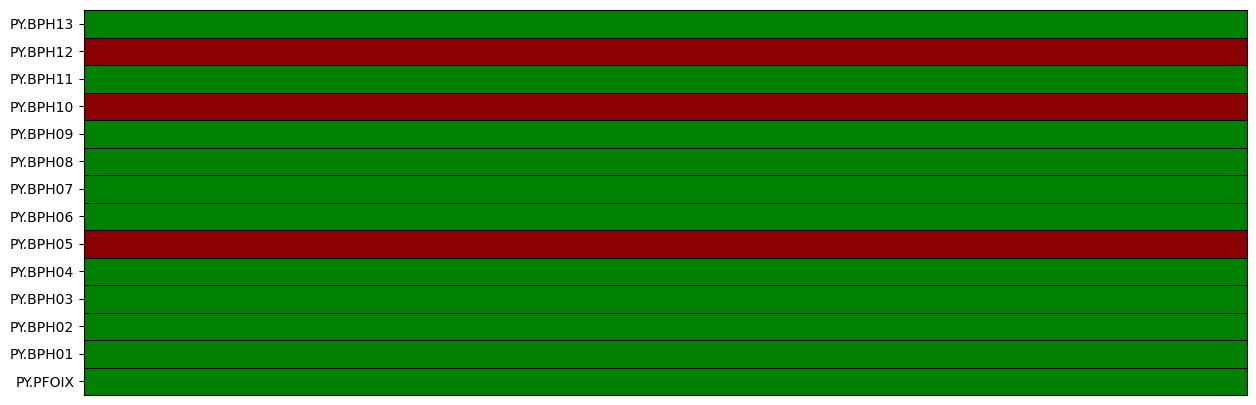


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-01T21:44:29.311400Z - 2023-05-01T21:45:29.311400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-01T21:44:29.311400Z - 2023-05-01T21:45:29.311400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-01T21:44:29.311400Z - 2023-05-01T21:45:29.311400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-01T21:44:29.310000Z - 2023-05-01T21:45:29.310000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-01T21:44:29.310000Z - 2023-05-01T21:45:29.310000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-01T21:44:29.310000Z - 2023-05-01T21:45:29.310000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-01T21:44:29.310000Z - 2023-05-01T21:45:29.310000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-01T21:44:29.310000Z - 2023-05-01T21:45:29.310000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-01T21:44:29.310000Z - 2023-05-01T21:45:29.310000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-01T21:44:29.310000Z - 2023-05-01T21:45:


 -> 191 2023-05-03 01:43:20.780000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


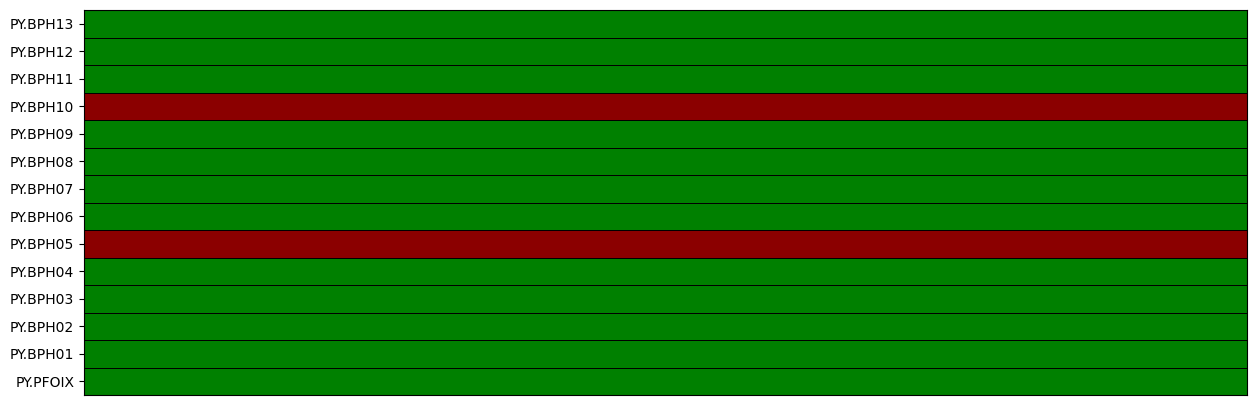


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-03T01:43:05.782000Z - 2023-05-03T01:44:05.782000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-03T01:43:05.782000Z - 2023-05-03T01:44:05.782000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-03T01:43:05.782000Z - 2023-05-03T01:44:05.782000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-03T01:43:05.780000Z - 2023-05-03T01:44:05.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-03T01:43:05.780000Z - 2023-05-03T01:44:05.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-03T01:43:05.780000Z - 2023-05-03T01:44:05.780000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-03T01:43:05.780000Z - 2023-05-03T01:44:05.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-03T01:43:05.780000Z - 2023-05-03T01:44:05.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-03T01:43:05.780000Z - 2023-05-03T01:44:05.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-03T01:43:05.780000Z - 2023-05-03T01:44:


 -> 192 2023-05-03 19:56:58.660000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


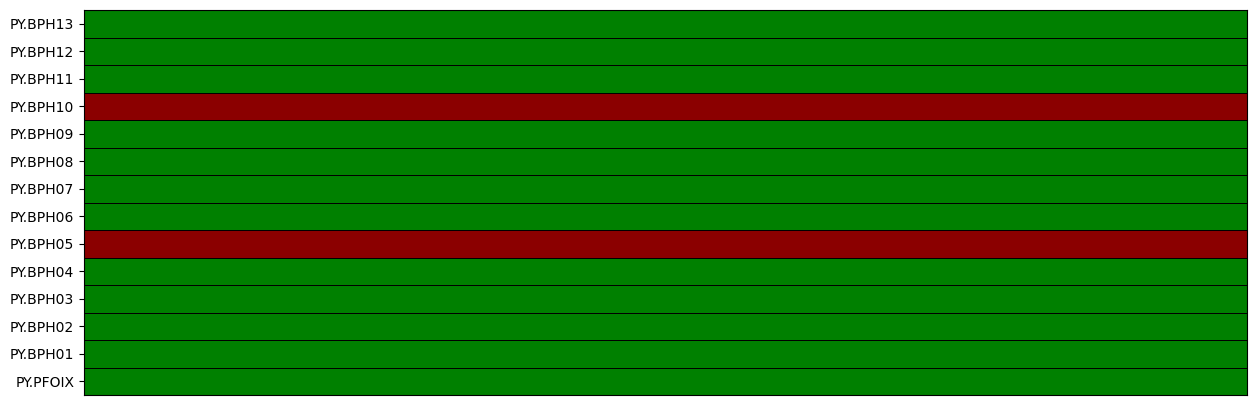


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-03T19:56:43.661700Z - 2023-05-03T19:57:43.661700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-03T19:56:43.661700Z - 2023-05-03T19:57:43.661700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-03T19:56:43.661700Z - 2023-05-03T19:57:43.661700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-03T19:56:43.660000Z - 2023-05-03T19:57:43.660000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-03T19:56:43.660000Z - 2023-05-03T19:57:43.660000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-03T19:56:43.660000Z - 2023-05-03T19:57:43.660000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-03T19:56:43.660000Z - 2023-05-03T19:57:43.660000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-03T19:56:43.660000Z - 2023-05-03T19:57:43.660000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-03T19:56:43.660000Z - 2023-05-03T19:57:43.660000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-03T19:56:43.660000Z - 2023-05-03T19:57:


 -> 193 2023-05-03 21:14:20.210000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


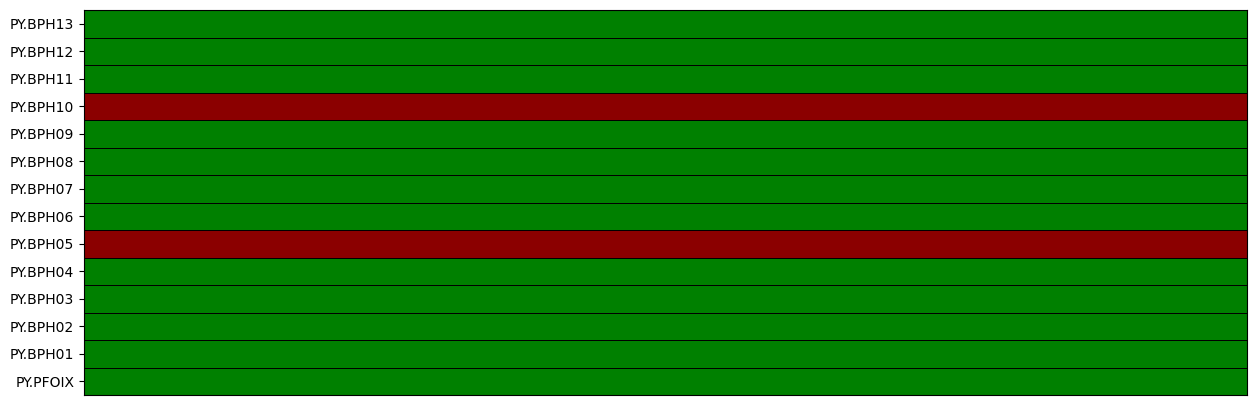


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-03T21:14:05.211700Z - 2023-05-03T21:15:05.211700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-03T21:14:05.211700Z - 2023-05-03T21:15:05.211700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-03T21:14:05.211700Z - 2023-05-03T21:15:05.211700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-03T21:14:05.210000Z - 2023-05-03T21:15:05.210000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-03T21:14:05.210000Z - 2023-05-03T21:15:05.210000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-03T21:14:05.210000Z - 2023-05-03T21:15:05.210000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-03T21:14:05.210000Z - 2023-05-03T21:15:05.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-03T21:14:05.210000Z - 2023-05-03T21:15:05.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-03T21:14:05.210000Z - 2023-05-03T21:15:05.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-03T21:14:05.210000Z - 2023-05-03T21:15:


 -> 194 2023-05-05 21:42:19.180000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


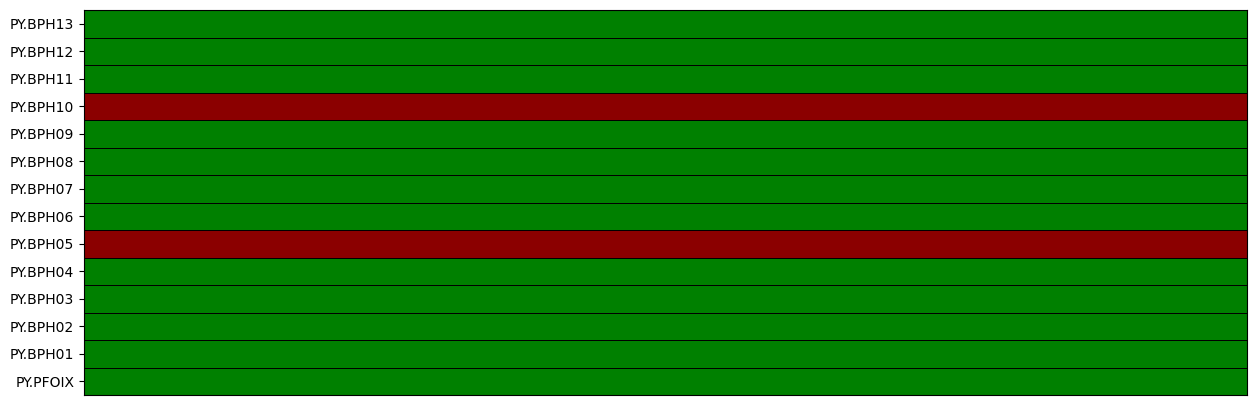


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-05T21:42:04.178000Z - 2023-05-05T21:43:04.178000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-05T21:42:04.178000Z - 2023-05-05T21:43:04.178000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-05T21:42:04.178000Z - 2023-05-05T21:43:04.178000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-05T21:42:04.180000Z - 2023-05-05T21:43:04.180000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-05T21:42:04.180000Z - 2023-05-05T21:43:04.180000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-05T21:42:04.180000Z - 2023-05-05T21:43:04.180000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-05T21:42:04.180000Z - 2023-05-05T21:43:04.180000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-05T21:42:04.180000Z - 2023-05-05T21:43:04.180000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-05T21:42:04.180000Z - 2023-05-05T21:43:04.180000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-05T21:42:04.180000Z - 2023-05-05T21:43:


 -> 195 2023-05-06 02:18:54.790000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


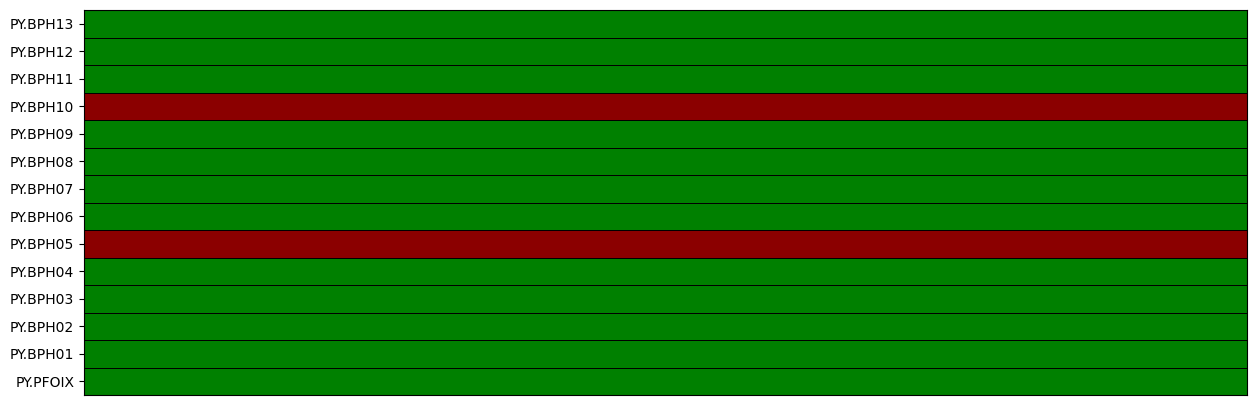


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-06T02:18:39.791700Z - 2023-05-06T02:19:39.791700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-06T02:18:39.791700Z - 2023-05-06T02:19:39.791700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-06T02:18:39.791700Z - 2023-05-06T02:19:39.791700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-06T02:18:39.790000Z - 2023-05-06T02:19:39.790000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-06T02:18:39.790000Z - 2023-05-06T02:19:39.790000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-06T02:18:39.790000Z - 2023-05-06T02:19:39.790000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-06T02:18:39.790000Z - 2023-05-06T02:19:39.790000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-06T02:18:39.790000Z - 2023-05-06T02:19:39.790000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-06T02:18:39.790000Z - 2023-05-06T02:19:39.790000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-06T02:18:39.790000Z - 2023-05-06T02:19:


 -> 196 2023-05-09 02:22:07.210000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


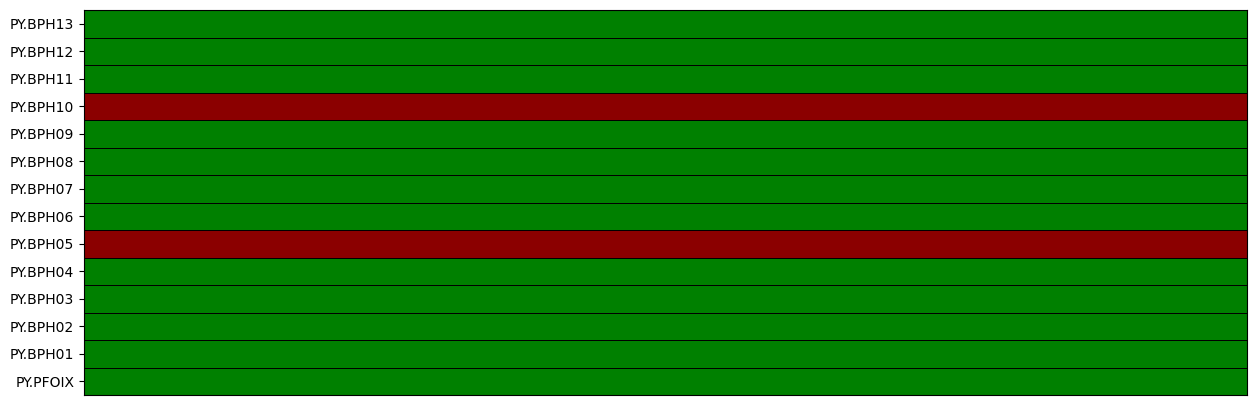


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-09T02:21:52.209300Z - 2023-05-09T02:22:52.209300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-09T02:21:52.209300Z - 2023-05-09T02:22:52.209300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-09T02:21:52.209300Z - 2023-05-09T02:22:52.209300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-09T02:21:52.210000Z - 2023-05-09T02:22:52.210000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-09T02:21:52.210000Z - 2023-05-09T02:22:52.210000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-09T02:21:52.210000Z - 2023-05-09T02:22:52.210000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-09T02:21:52.210000Z - 2023-05-09T02:22:52.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-09T02:21:52.210000Z - 2023-05-09T02:22:52.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-09T02:21:52.210000Z - 2023-05-09T02:22:52.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-09T02:21:52.210000Z - 2023-05-09T02:22:


 -> 197 2023-05-09 03:01:09.100000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


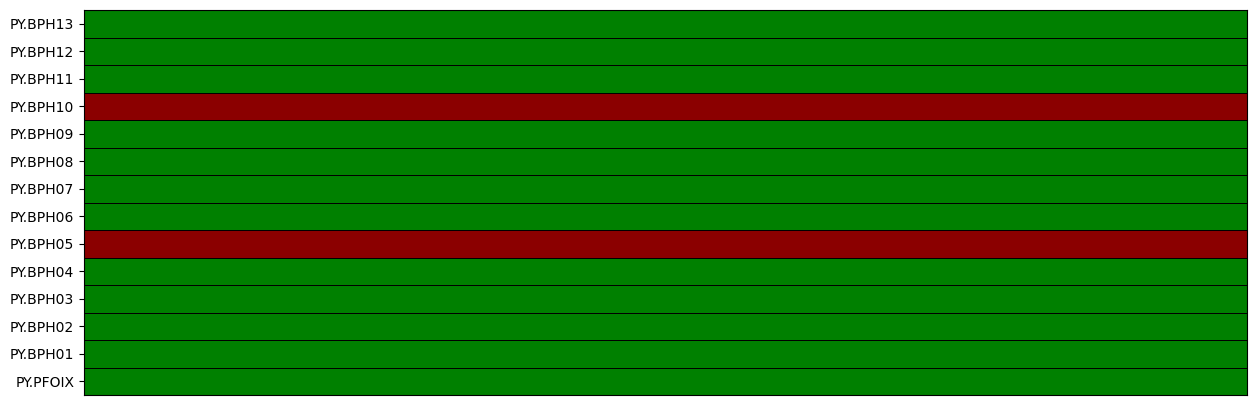


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-09T03:00:54.098000Z - 2023-05-09T03:01:54.098000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-09T03:00:54.098000Z - 2023-05-09T03:01:54.098000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-09T03:00:54.098000Z - 2023-05-09T03:01:54.098000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-09T03:00:54.100000Z - 2023-05-09T03:01:54.100000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-09T03:00:54.100000Z - 2023-05-09T03:01:54.100000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-09T03:00:54.100000Z - 2023-05-09T03:01:54.100000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-09T03:00:54.100000Z - 2023-05-09T03:01:54.100000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-09T03:00:54.100000Z - 2023-05-09T03:01:54.100000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-09T03:00:54.100000Z - 2023-05-09T03:01:54.100000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-09T03:00:54.100000Z - 2023-05-09T03:01:


 -> 198 2023-05-10 19:48:55.040000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


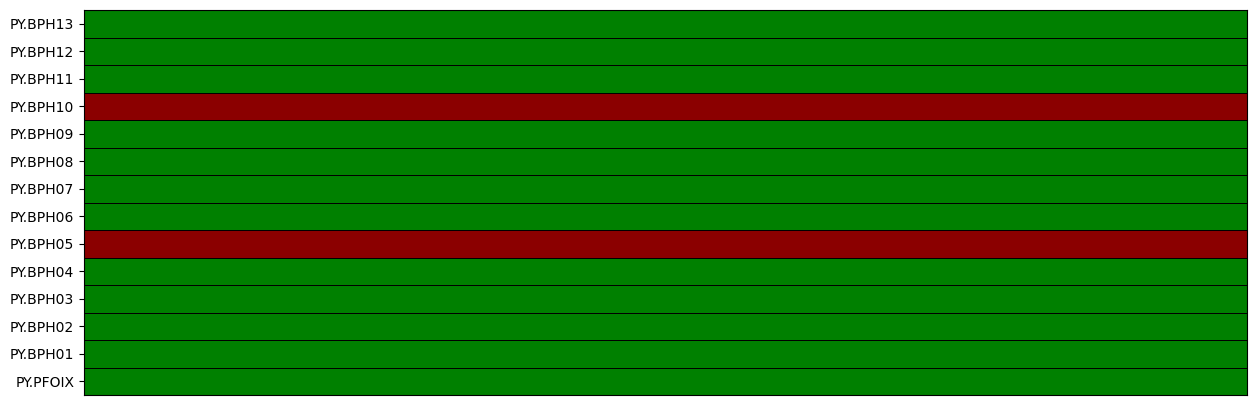


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-10T19:48:40.037700Z - 2023-05-10T19:49:40.037700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-10T19:48:40.037700Z - 2023-05-10T19:49:40.037700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-10T19:48:40.037700Z - 2023-05-10T19:49:40.037700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-10T19:48:40.040000Z - 2023-05-10T19:49:40.040000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-10T19:48:40.040000Z - 2023-05-10T19:49:40.040000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-10T19:48:40.040000Z - 2023-05-10T19:49:40.040000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-10T19:48:40.040000Z - 2023-05-10T19:49:40.040000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-10T19:48:40.040000Z - 2023-05-10T19:49:40.040000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-10T19:48:40.040000Z - 2023-05-10T19:49:40.040000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-10T19:48:40.040000Z - 2023-05-10T19:49:


 -> 199 2023-05-10 20:20:14.660000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


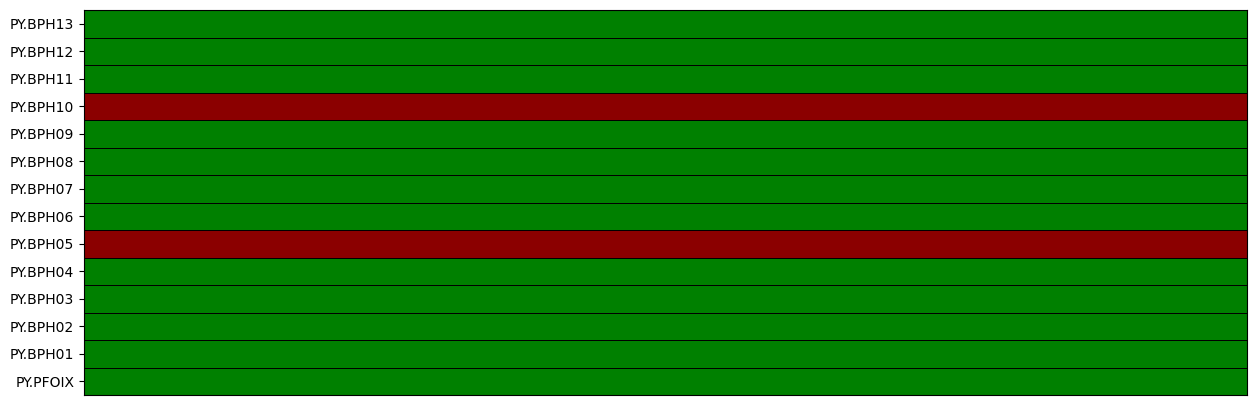


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-10T20:19:59.657700Z - 2023-05-10T20:20:59.657700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-10T20:19:59.657700Z - 2023-05-10T20:20:59.657700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-10T20:19:59.657700Z - 2023-05-10T20:20:59.657700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-10T20:19:59.660000Z - 2023-05-10T20:20:59.660000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-10T20:19:59.660000Z - 2023-05-10T20:20:59.660000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-10T20:19:59.660000Z - 2023-05-10T20:20:59.660000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-10T20:19:59.660000Z - 2023-05-10T20:20:59.660000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-10T20:19:59.660000Z - 2023-05-10T20:20:59.660000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-10T20:19:59.660000Z - 2023-05-10T20:20:59.660000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-10T20:19:59.660000Z - 2023-05-10T20:20:


 -> 200 2023-05-11 18:26:50.410000 
 -> sensitivity removed!
 -> response removed!
 -> BPH02 Failed to load inventory!
 -> BPH02 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


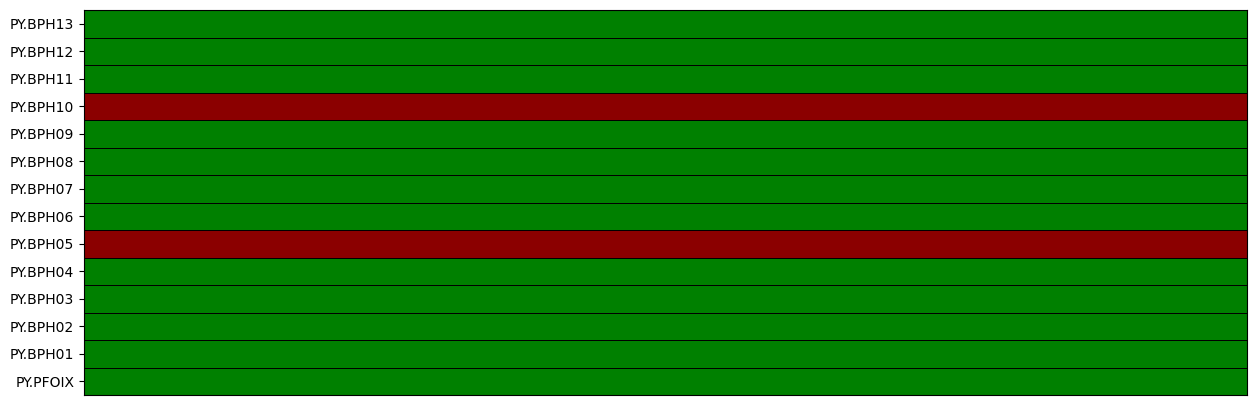


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-11T18:26:35.409200Z - 2023-05-11T18:27:35.409200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-11T18:26:35.409200Z - 2023-05-11T18:27:35.409200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-11T18:26:35.409200Z - 2023-05-11T18:27:35.409200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-11T18:26:35.410000Z - 2023-05-11T18:27:35.410000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-11T18:26:35.410000Z - 2023-05-11T18:27:35.410000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-11T18:26:35.410000Z - 2023-05-11T18:27:35.410000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-11T18:26:35.410000Z - 2023-05-11T18:27:35.410000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-11T18:26:35.410000Z - 2023-05-11T18:27:35.410000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-11T18:26:35.410000Z - 2023-05-11T18:27:35.410000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-11T18:26:35.410000Z - 2023-05-11T18:27:


 -> 201 2023-05-12 01:32:53.070000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


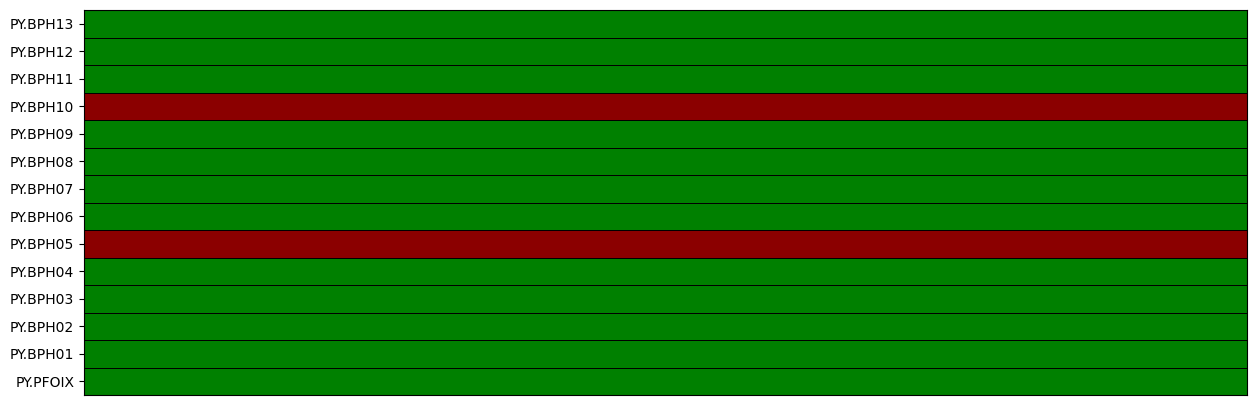


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-12T01:32:38.069200Z - 2023-05-12T01:33:38.069200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-12T01:32:38.069200Z - 2023-05-12T01:33:38.069200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-12T01:32:38.069200Z - 2023-05-12T01:33:38.069200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-12T01:32:38.070000Z - 2023-05-12T01:33:38.070000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-12T01:32:38.070000Z - 2023-05-12T01:33:38.070000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-12T01:32:38.070000Z - 2023-05-12T01:33:38.070000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-12T01:32:38.070000Z - 2023-05-12T01:33:38.070000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-12T01:32:38.070000Z - 2023-05-12T01:33:38.070000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-12T01:32:38.070000Z - 2023-05-12T01:33:38.070000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-12T01:32:38.070000Z - 2023-05-12T01:33:


 -> 202 2023-05-12 17:30:43.140000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


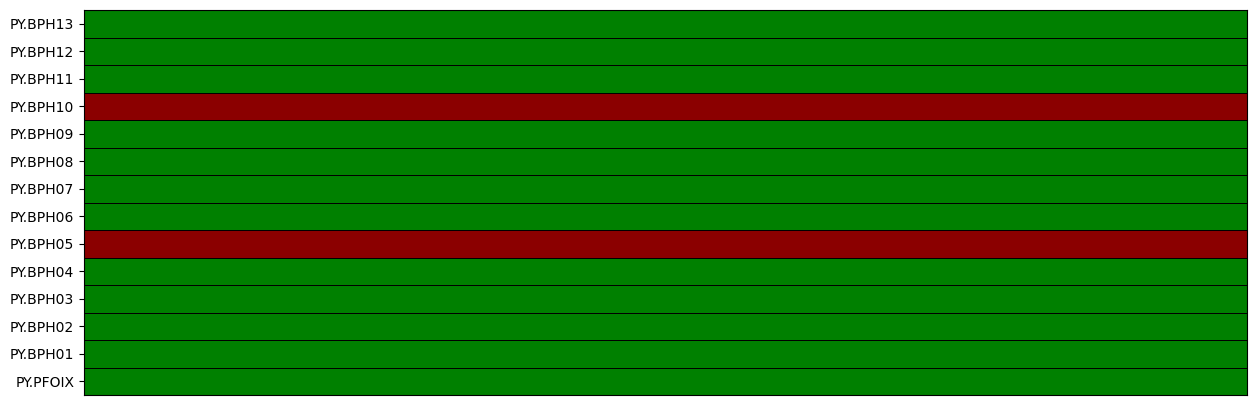


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-12T17:30:28.139200Z - 2023-05-12T17:31:28.139200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-12T17:30:28.139200Z - 2023-05-12T17:31:28.139200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-12T17:30:28.139200Z - 2023-05-12T17:31:28.139200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-12T17:30:28.140000Z - 2023-05-12T17:31:28.140000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-12T17:30:28.140000Z - 2023-05-12T17:31:28.140000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-12T17:30:28.140000Z - 2023-05-12T17:31:28.140000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-12T17:30:28.140000Z - 2023-05-12T17:31:28.140000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-12T17:30:28.140000Z - 2023-05-12T17:31:28.140000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-12T17:30:28.140000Z - 2023-05-12T17:31:28.140000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-12T17:30:28.140000Z - 2023-05-12T17:31:


 -> 203 2023-05-12 20:39:51.900000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...
 -> failed to compute ADR all ...
 -> PFOIX Failed to load inventory!
 -> PFOIX failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


9 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-12T20:39:36.899200Z - 2023-05-12T20:40:36.899200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-12T20:39:36.899200Z - 2023-05-12T20:40:36.899200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-12T20:39:36.899200Z - 2023-05-12T20:40:36.899200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-12T20:39:36.900000Z - 2023-05-12T20:40:36.900000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-12T20:39:36.900000Z - 2023-05-12T20:40:36.900000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-12T20:39:36.900000Z - 2023-05-12T20:40:36.900000Z | 200.0 Hz, 12001 samples
PY.RPFO.inn.BJE | 2023-05-12T20:39:36.900000Z - 2023-05-12T20:40:36.900000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJN | 2023-05-12T20:39:36.900000Z - 2023-05-12T20:40:36.900000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJZ | 2023-05-12T20:39:36.900000Z - 2023-05-12T20:40:36.900000Z | 40.0 Hz, 2401 samples


 -> 204 2023-05-13 23:06:14.550000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


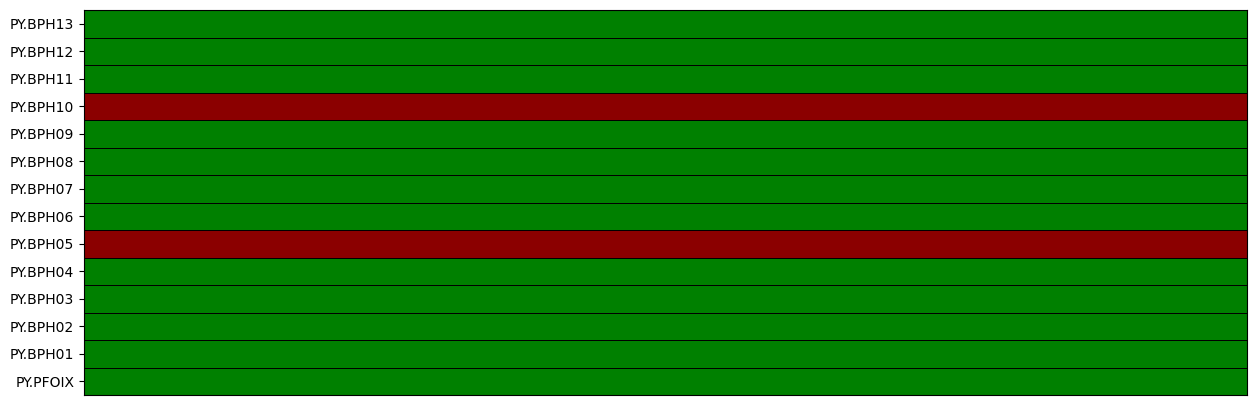


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-13T23:05:59.549200Z - 2023-05-13T23:06:59.549200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-13T23:05:59.549200Z - 2023-05-13T23:06:59.549200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-13T23:05:59.549200Z - 2023-05-13T23:06:59.549200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-13T23:05:59.550000Z - 2023-05-13T23:06:59.550000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-13T23:05:59.550000Z - 2023-05-13T23:06:59.550000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-13T23:05:59.550000Z - 2023-05-13T23:06:59.550000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-13T23:05:59.550000Z - 2023-05-13T23:06:59.550000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-13T23:05:59.550000Z - 2023-05-13T23:06:59.550000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-13T23:05:59.550000Z - 2023-05-13T23:06:59.550000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-13T23:05:59.550000Z - 2023-05-13T23:06:


 -> 205 2023-05-14 02:10:24.170000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


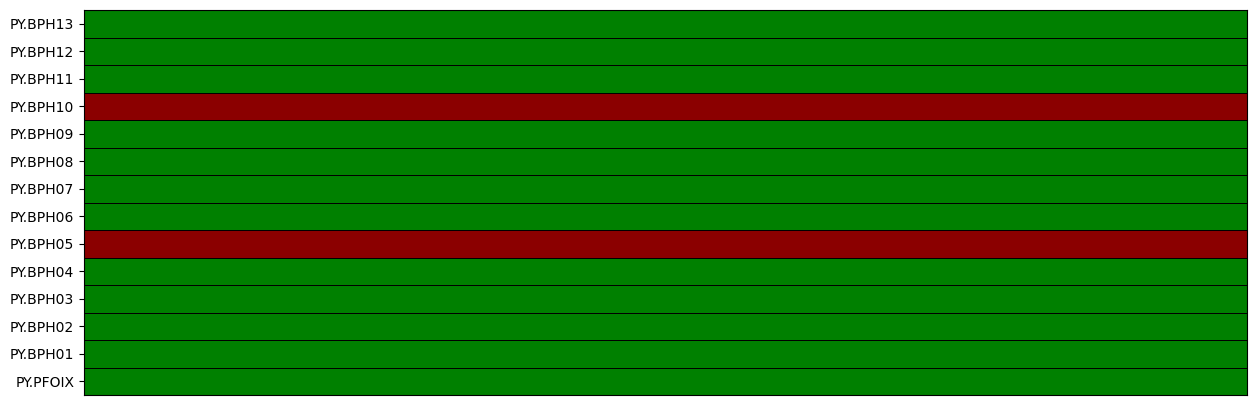


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-14T02:10:09.169200Z - 2023-05-14T02:11:09.169200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-14T02:10:09.169200Z - 2023-05-14T02:11:09.169200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-14T02:10:09.169200Z - 2023-05-14T02:11:09.169200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-14T02:10:09.170000Z - 2023-05-14T02:11:09.170000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-14T02:10:09.170000Z - 2023-05-14T02:11:09.170000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-14T02:10:09.170000Z - 2023-05-14T02:11:09.170000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-14T02:10:09.170000Z - 2023-05-14T02:11:09.170000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-14T02:10:09.170000Z - 2023-05-14T02:11:09.170000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-14T02:10:09.170000Z - 2023-05-14T02:11:09.170000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-14T02:10:09.170000Z - 2023-05-14T02:11:


 -> 206 2023-05-14 11:17:06.660000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


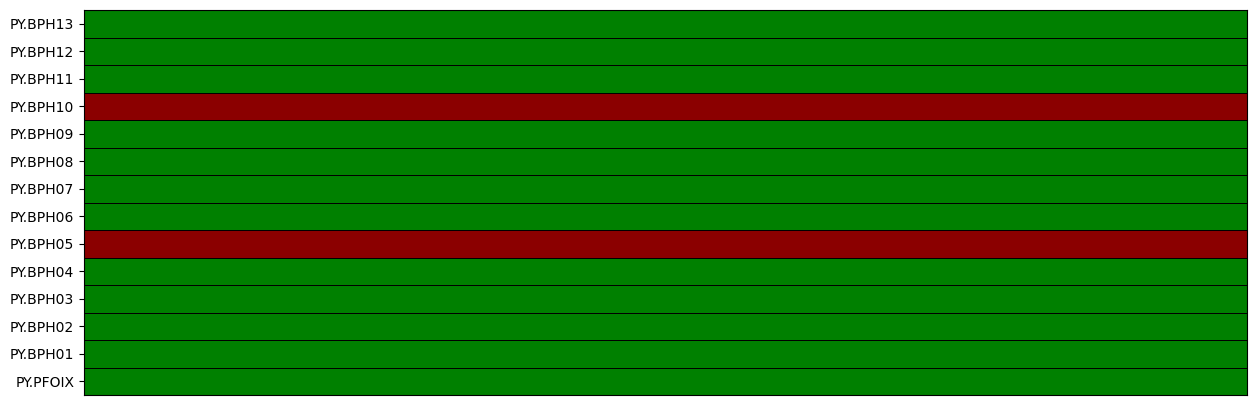


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-14T11:16:51.659200Z - 2023-05-14T11:17:51.659200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-14T11:16:51.659200Z - 2023-05-14T11:17:51.659200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-14T11:16:51.659200Z - 2023-05-14T11:17:51.659200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-14T11:16:51.660000Z - 2023-05-14T11:17:51.660000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-14T11:16:51.660000Z - 2023-05-14T11:17:51.660000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-14T11:16:51.660000Z - 2023-05-14T11:17:51.660000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-14T11:16:51.660000Z - 2023-05-14T11:17:51.660000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-14T11:16:51.660000Z - 2023-05-14T11:17:51.660000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-14T11:16:51.660000Z - 2023-05-14T11:17:51.660000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-14T11:16:51.660000Z - 2023-05-14T11:17:


 -> 207 2023-05-15 08:21:09.720000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


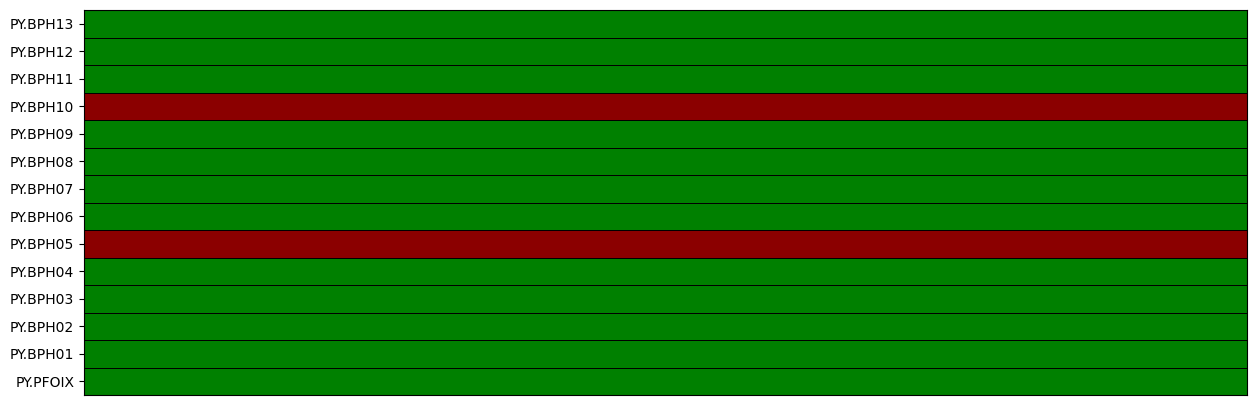


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-15T08:20:54.719000Z - 2023-05-15T08:21:54.719000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-15T08:20:54.719000Z - 2023-05-15T08:21:54.719000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-15T08:20:54.719000Z - 2023-05-15T08:21:54.719000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-15T08:20:54.720000Z - 2023-05-15T08:21:54.720000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-15T08:20:54.720000Z - 2023-05-15T08:21:54.720000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-15T08:20:54.720000Z - 2023-05-15T08:21:54.720000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-15T08:20:54.720000Z - 2023-05-15T08:21:54.720000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-15T08:20:54.720000Z - 2023-05-15T08:21:54.720000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-15T08:20:54.720000Z - 2023-05-15T08:21:54.720000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-15T08:20:54.720000Z - 2023-05-15T08:21:


 -> 208 2023-05-15 08:38:30.190000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


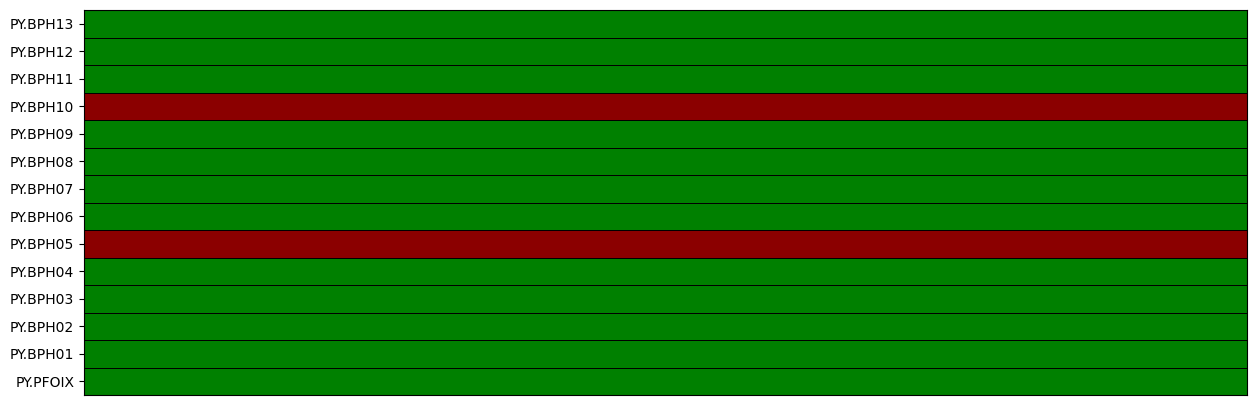


 -> Runtime: 0.65 minutes
 -> BPH01 Failed to load inventory!
 -> BPH01 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 7 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.3 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-15T08:38:15.189000Z - 2023-05-15T08:39:15.189000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-15T08:38:15.189000Z - 2023-05-15T08:39:15.189000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-15T08:38:15.189000Z - 2023-05-15T08:39:15.189000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-15T08:38:15.190000Z - 2023-05-15T08:39:15.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-15T08:38:15.190000Z - 2023-05-15T08:39:15.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-15T08:38:15.190000Z - 2023-05-15T08:39:15.190000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-15T08:38:15.190000Z - 2023-05-15T08:39:15.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-15T08:38:15.190000Z - 2023-05-15T08:39:15.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-15T08:38:15.190000Z - 2023-05-15T08:39:15.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-15T08:38:15.190000Z - 2023-05-15T08:39:


 -> 209 2023-05-16 11:43:07.610000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


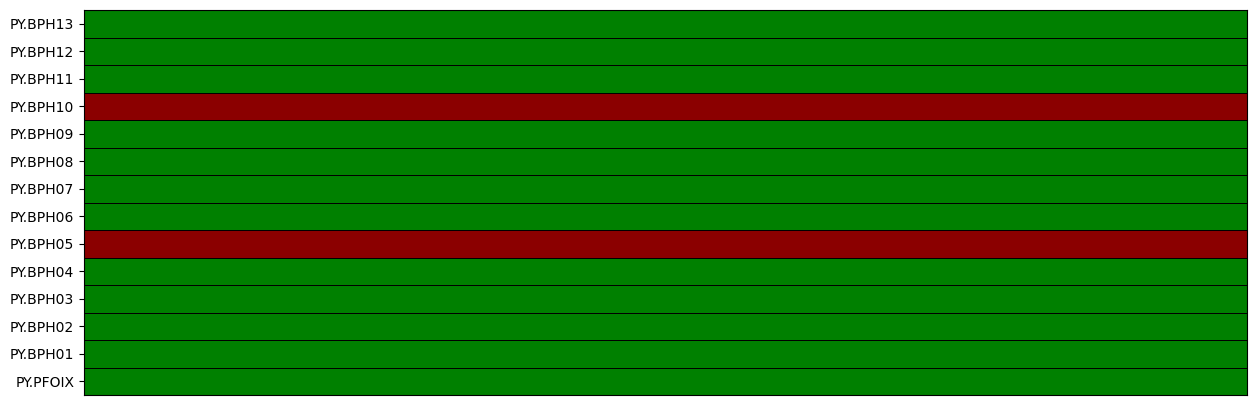


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-16T11:42:52.609000Z - 2023-05-16T11:43:52.609000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-16T11:42:52.609000Z - 2023-05-16T11:43:52.609000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-16T11:42:52.609000Z - 2023-05-16T11:43:52.609000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-16T11:42:52.610000Z - 2023-05-16T11:43:52.610000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-16T11:42:52.610000Z - 2023-05-16T11:43:52.610000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-16T11:42:52.610000Z - 2023-05-16T11:43:52.610000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-16T11:42:52.610000Z - 2023-05-16T11:43:52.610000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-16T11:42:52.610000Z - 2023-05-16T11:43:52.610000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-16T11:42:52.610000Z - 2023-05-16T11:43:52.610000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-16T11:42:52.610000Z - 2023-05-16T11:43:


 -> 210 2023-05-19 23:40:24.430000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


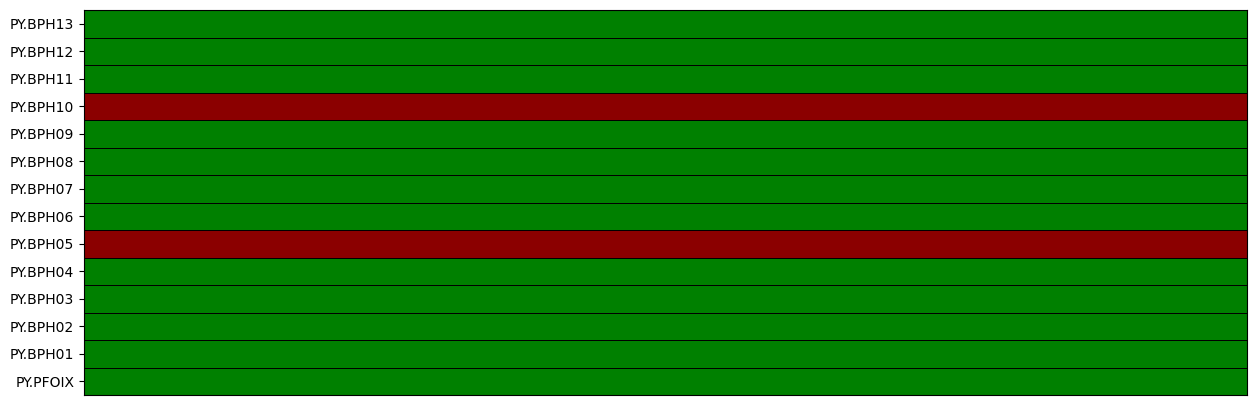


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.52 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-19T23:40:09.428800Z - 2023-05-19T23:41:09.428800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-19T23:40:09.428800Z - 2023-05-19T23:41:09.428800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-19T23:40:09.428800Z - 2023-05-19T23:41:09.428800Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-19T23:40:09.430000Z - 2023-05-19T23:41:09.430000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-19T23:40:09.430000Z - 2023-05-19T23:41:09.430000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-19T23:40:09.430000Z - 2023-05-19T23:41:09.430000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-19T23:40:09.430000Z - 2023-05-19T23:41:09.430000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-19T23:40:09.430000Z - 2023-05-19T23:41:09.430000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-19T23:40:09.430000Z - 2023-05-19T23:41:09.430000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-19T23:40:09.430000Z - 2023-05-19T23:41:


 -> 211 2023-05-20 08:18:16.240000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


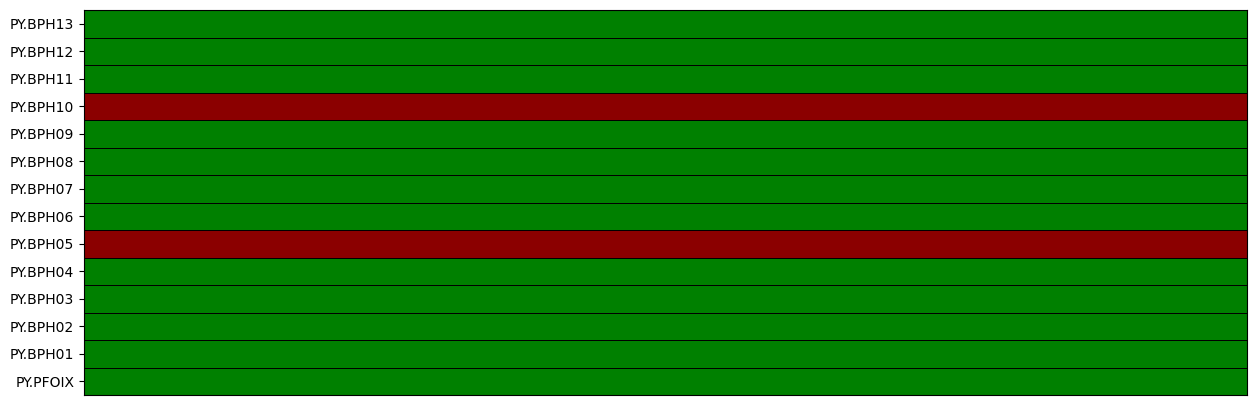


 -> Runtime: 0.73 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.47 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-20T08:18:01.238800Z - 2023-05-20T08:19:01.238800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-20T08:18:01.238800Z - 2023-05-20T08:19:01.238800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-20T08:18:01.238800Z - 2023-05-20T08:19:01.238800Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-20T08:18:01.240000Z - 2023-05-20T08:19:01.240000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-20T08:18:01.240000Z - 2023-05-20T08:19:01.240000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-20T08:18:01.240000Z - 2023-05-20T08:19:01.240000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-20T08:18:01.240000Z - 2023-05-20T08:19:01.240000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-20T08:18:01.240000Z - 2023-05-20T08:19:01.240000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-20T08:18:01.240000Z - 2023-05-20T08:19:01.240000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-20T08:18:01.240000Z - 2023-05-20T08:19:


 -> 212 2023-05-20 08:20:51.820000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


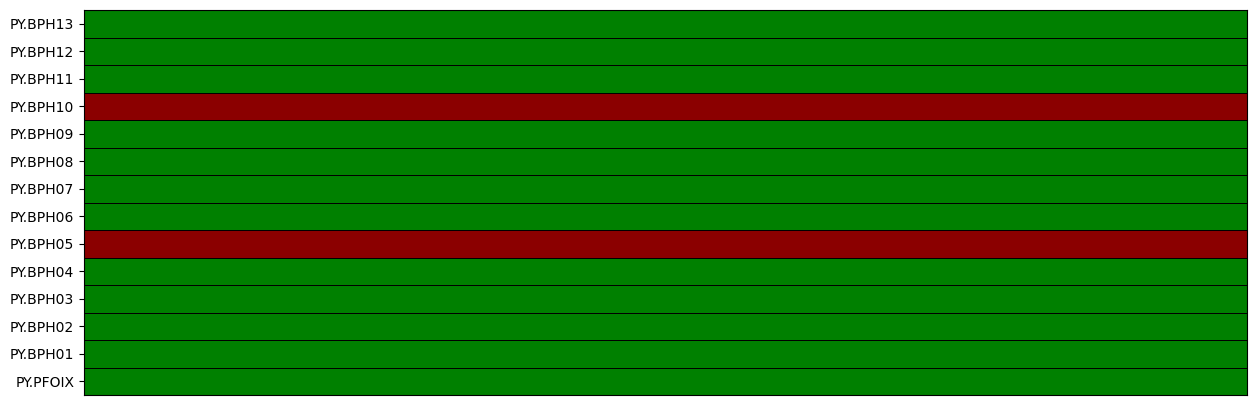


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-20T08:20:36.818800Z - 2023-05-20T08:21:36.818800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-20T08:20:36.818800Z - 2023-05-20T08:21:36.818800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-20T08:20:36.818800Z - 2023-05-20T08:21:36.818800Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-20T08:20:36.820000Z - 2023-05-20T08:21:36.820000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-20T08:20:36.820000Z - 2023-05-20T08:21:36.820000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-20T08:20:36.820000Z - 2023-05-20T08:21:36.820000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-20T08:20:36.820000Z - 2023-05-20T08:21:36.820000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-20T08:20:36.820000Z - 2023-05-20T08:21:36.820000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-20T08:20:36.820000Z - 2023-05-20T08:21:36.820000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-20T08:20:36.820000Z - 2023-05-20T08:21:


 -> 213 2023-05-21 00:55:19.720000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


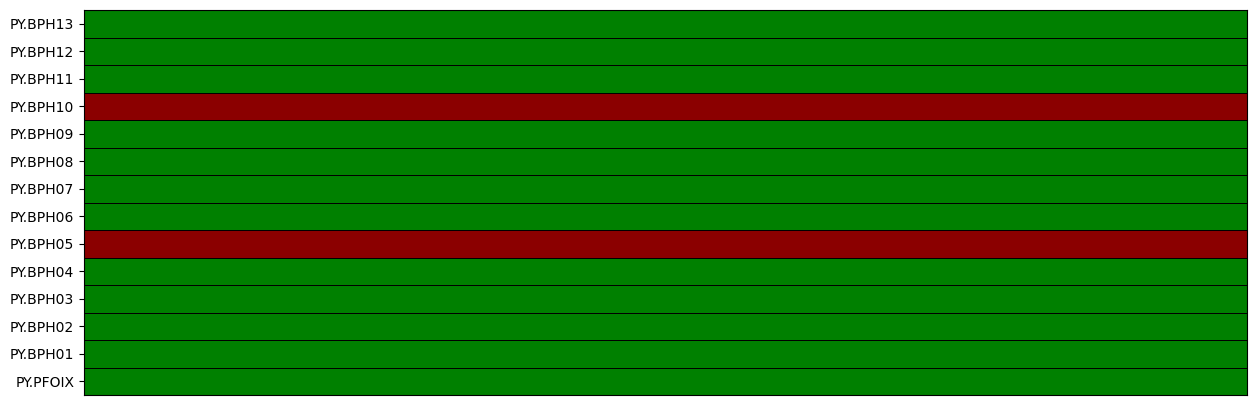


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-21T00:55:04.718700Z - 2023-05-21T00:56:04.718700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-21T00:55:04.718700Z - 2023-05-21T00:56:04.718700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-21T00:55:04.718700Z - 2023-05-21T00:56:04.718700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-21T00:55:04.720000Z - 2023-05-21T00:56:04.720000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-21T00:55:04.720000Z - 2023-05-21T00:56:04.720000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-21T00:55:04.720000Z - 2023-05-21T00:56:04.720000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-21T00:55:04.720000Z - 2023-05-21T00:56:04.720000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-21T00:55:04.720000Z - 2023-05-21T00:56:04.720000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-21T00:55:04.720000Z - 2023-05-21T00:56:04.720000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-21T00:55:04.720000Z - 2023-05-21T00:56:


 -> 214 2023-05-22 18:42:09.850000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


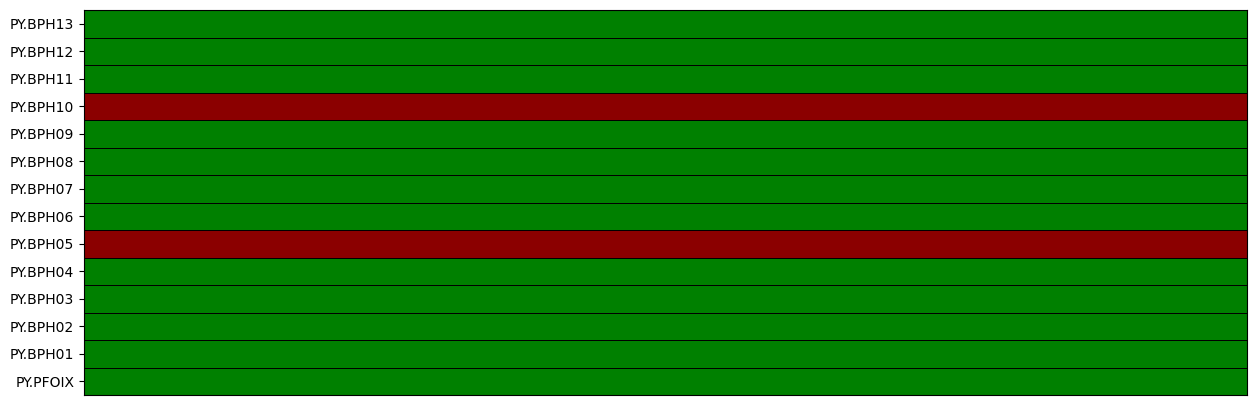


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...
 -> failed to compute ADR inner ...


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-22T18:41:54.849000Z - 2023-05-22T18:42:54.849000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-22T18:41:54.849000Z - 2023-05-22T18:42:54.849000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-22T18:41:54.849000Z - 2023-05-22T18:42:54.849000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-22T18:41:54.850000Z - 2023-05-22T18:42:54.850000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-22T18:41:54.850000Z - 2023-05-22T18:42:54.850000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-22T18:41:54.850000Z - 2023-05-22T18:42:54.850000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-22T18:41:54.850000Z - 2023-05-22T18:42:54.850000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-22T18:41:54.850000Z - 2023-05-22T18:42:54.850000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-22T18:41:54.850000Z - 2023-05-22T18:42:54.850000Z | 40.0 Hz, 2401 samples
PY.RPFO.mid.BJE | 2023-05-22T18:41:54.850000Z - 2023-05-22T18:42:


 -> 215 2023-05-22 22:17:06.870000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


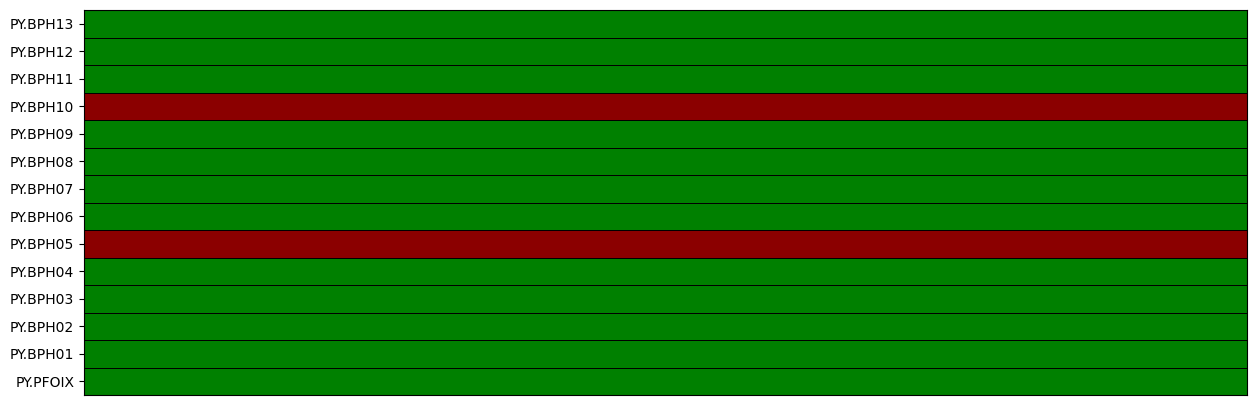


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-22T22:16:51.869000Z - 2023-05-22T22:17:51.869000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-22T22:16:51.869000Z - 2023-05-22T22:17:51.869000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-22T22:16:51.869000Z - 2023-05-22T22:17:51.869000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-22T22:16:51.870000Z - 2023-05-22T22:17:51.870000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-22T22:16:51.870000Z - 2023-05-22T22:17:51.870000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-22T22:16:51.870000Z - 2023-05-22T22:17:51.870000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-22T22:16:51.870000Z - 2023-05-22T22:17:51.870000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-22T22:16:51.870000Z - 2023-05-22T22:17:51.870000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-22T22:16:51.870000Z - 2023-05-22T22:17:51.870000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-22T22:16:51.870000Z - 2023-05-22T22:17:


 -> 216 2023-05-23 02:29:41.190000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


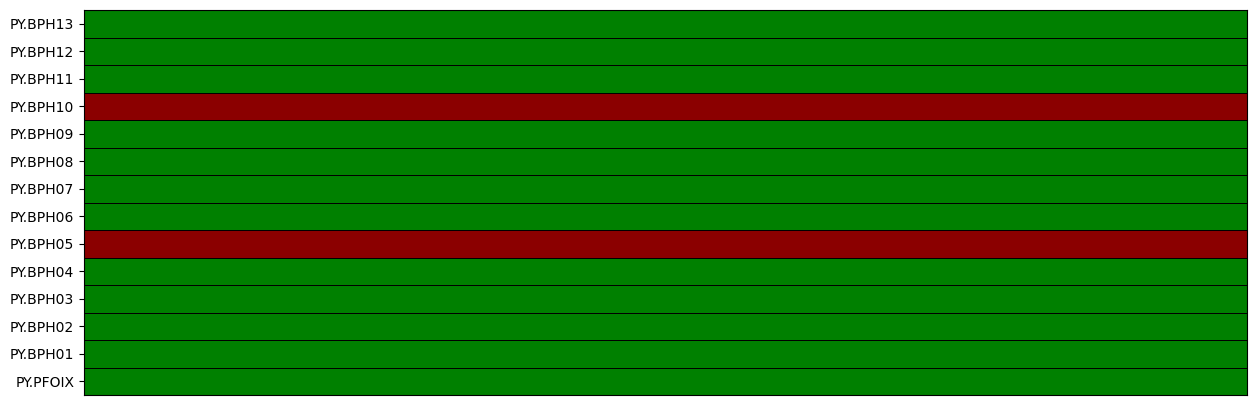


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> BPH04 Failed to load inventory!
 -> BPH04 failed to rotate to ZNE
 -> continue computing ADR for 4 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-23T02:29:26.189000Z - 2023-05-23T02:30:26.189000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-23T02:29:26.189000Z - 2023-05-23T02:30:26.189000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-23T02:29:26.189000Z - 2023-05-23T02:30:26.189000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-23T02:29:26.190000Z - 2023-05-23T02:30:26.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-23T02:29:26.190000Z - 2023-05-23T02:30:26.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-23T02:29:26.190000Z - 2023-05-23T02:30:26.190000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-23T02:29:26.190000Z - 2023-05-23T02:30:26.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-23T02:29:26.190000Z - 2023-05-23T02:30:26.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-23T02:29:26.190000Z - 2023-05-23T02:30:26.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-23T02:29:26.190000Z - 2023-05-23T02:30:


 -> 217 2023-05-23 10:22:59.530000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


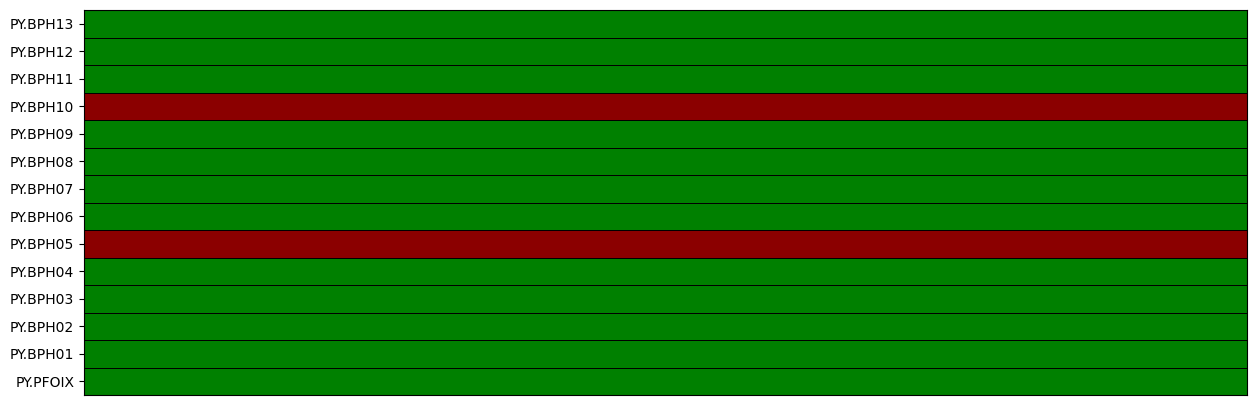


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-23T10:22:44.529000Z - 2023-05-23T10:23:44.529000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-23T10:22:44.529000Z - 2023-05-23T10:23:44.529000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-23T10:22:44.529000Z - 2023-05-23T10:23:44.529000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-23T10:22:44.530000Z - 2023-05-23T10:23:44.530000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-23T10:22:44.530000Z - 2023-05-23T10:23:44.530000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-23T10:22:44.530000Z - 2023-05-23T10:23:44.530000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-23T10:22:44.530000Z - 2023-05-23T10:23:44.530000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-23T10:22:44.530000Z - 2023-05-23T10:23:44.530000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-23T10:22:44.530000Z - 2023-05-23T10:23:44.530000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-23T10:22:44.530000Z - 2023-05-23T10:23:


 -> 218 2023-05-24 15:33:55.510000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


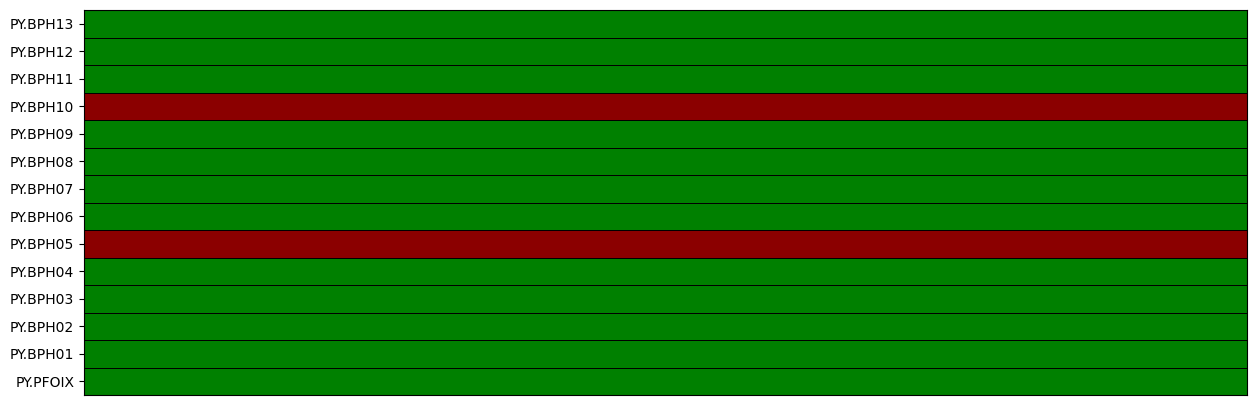


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-24T15:33:40.512500Z - 2023-05-24T15:34:40.507500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJN    | 2023-05-24T15:33:40.512500Z - 2023-05-24T15:34:40.507500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJZ    | 2023-05-24T15:33:40.512500Z - 2023-05-24T15:34:40.507500Z | 200.0 Hz, 12000 samples
PY.PFOIX..HHE   | 2023-05-24T15:33:40.510000Z - 2023-05-24T15:34:40.510000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-24T15:33:40.510000Z - 2023-05-24T15:34:40.510000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-24T15:33:40.510000Z - 2023-05-24T15:34:40.510000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-24T15:33:40.510000Z - 2023-05-24T15:34:40.510000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-24T15:33:40.510000Z - 2023-05-24T15:34:40.510000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-24T15:33:40.510000Z - 2023-05-24T15:34:40.510000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-24T15:33:40.510000Z - 2023-05-24T15:34:


 -> 219 2023-05-24 19:11:52.210000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


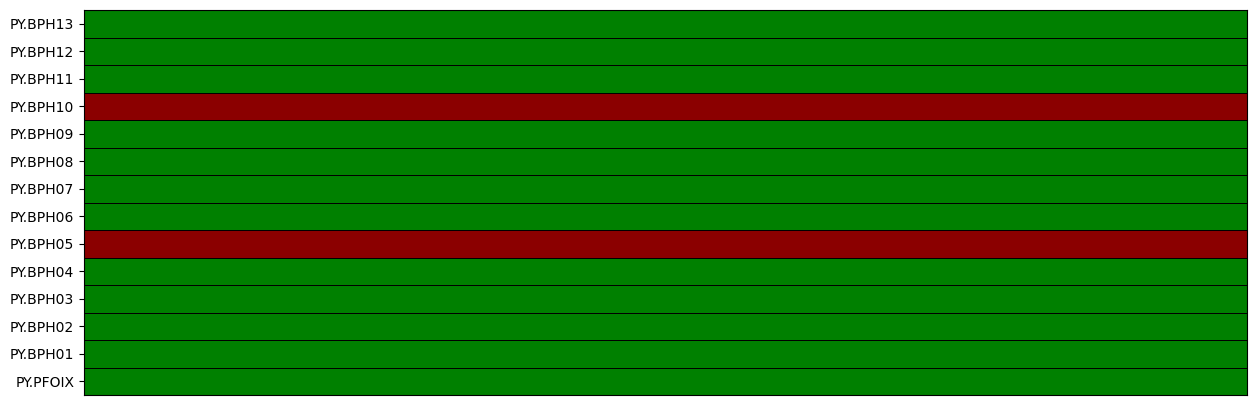


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-24T19:11:37.212500Z - 2023-05-24T19:12:37.207500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJN    | 2023-05-24T19:11:37.212500Z - 2023-05-24T19:12:37.207500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJZ    | 2023-05-24T19:11:37.212500Z - 2023-05-24T19:12:37.207500Z | 200.0 Hz, 12000 samples
PY.PFOIX..HHE   | 2023-05-24T19:11:37.210000Z - 2023-05-24T19:12:37.210000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-24T19:11:37.210000Z - 2023-05-24T19:12:37.210000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-24T19:11:37.210000Z - 2023-05-24T19:12:37.210000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-24T19:11:37.210000Z - 2023-05-24T19:12:37.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-24T19:11:37.210000Z - 2023-05-24T19:12:37.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-24T19:11:37.210000Z - 2023-05-24T19:12:37.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-24T19:11:37.210000Z - 2023-05-24T19:12:


 -> 220 2023-05-24 19:43:16.270000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


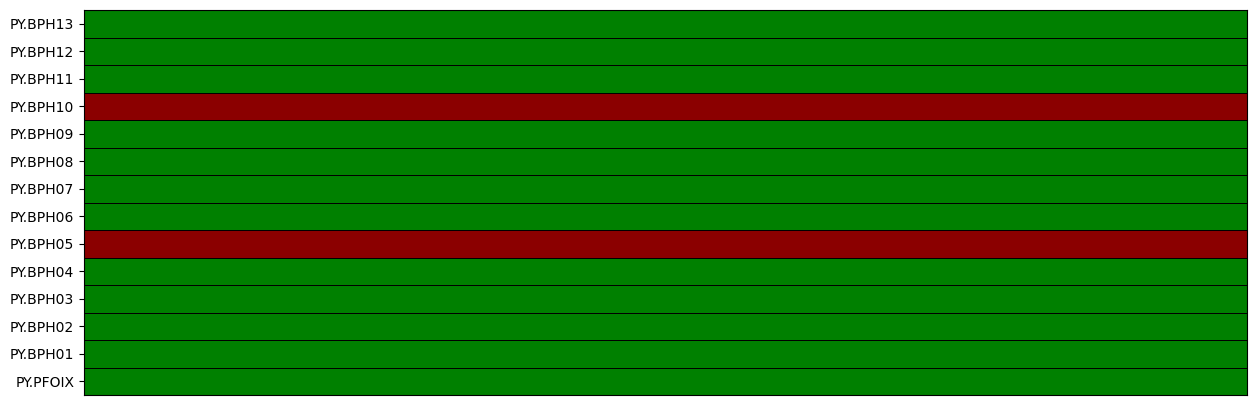


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-24T19:43:01.272500Z - 2023-05-24T19:44:01.267500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJN    | 2023-05-24T19:43:01.272500Z - 2023-05-24T19:44:01.267500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJZ    | 2023-05-24T19:43:01.272500Z - 2023-05-24T19:44:01.267500Z | 200.0 Hz, 12000 samples
PY.PFOIX..HHE   | 2023-05-24T19:43:01.270000Z - 2023-05-24T19:44:01.270000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-24T19:43:01.270000Z - 2023-05-24T19:44:01.270000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-24T19:43:01.270000Z - 2023-05-24T19:44:01.270000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-24T19:43:01.270000Z - 2023-05-24T19:44:01.270000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-24T19:43:01.270000Z - 2023-05-24T19:44:01.270000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-24T19:43:01.270000Z - 2023-05-24T19:44:01.270000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-24T19:43:01.270000Z - 2023-05-24T19:44:


 -> 221 2023-05-24 21:25:50.550000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


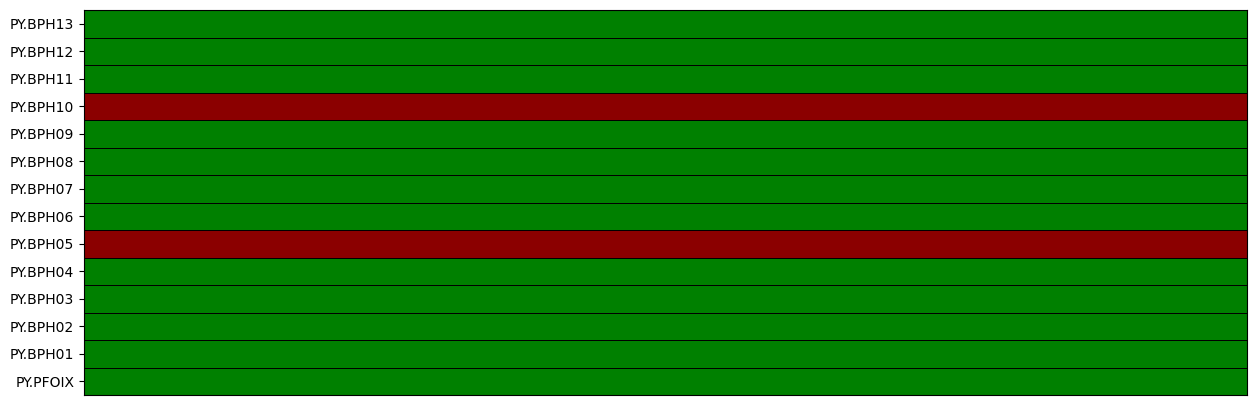


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH08 Failed to load inventory!
 -> BPH08 failed to rotate to ZNE
 -> continue computing ADR for 7 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-24T21:25:35.552500Z - 2023-05-24T21:26:35.547500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJN    | 2023-05-24T21:25:35.552500Z - 2023-05-24T21:26:35.547500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJZ    | 2023-05-24T21:25:35.552500Z - 2023-05-24T21:26:35.547500Z | 200.0 Hz, 12000 samples
PY.PFOIX..HHE   | 2023-05-24T21:25:35.550000Z - 2023-05-24T21:26:35.550000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-24T21:25:35.550000Z - 2023-05-24T21:26:35.550000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-24T21:25:35.550000Z - 2023-05-24T21:26:35.550000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-24T21:25:35.550000Z - 2023-05-24T21:26:35.550000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-24T21:25:35.550000Z - 2023-05-24T21:26:35.550000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-24T21:25:35.550000Z - 2023-05-24T21:26:35.550000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-24T21:25:35.550000Z - 2023-05-24T21:26:


 -> 222 2023-05-25 23:38:03.090000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


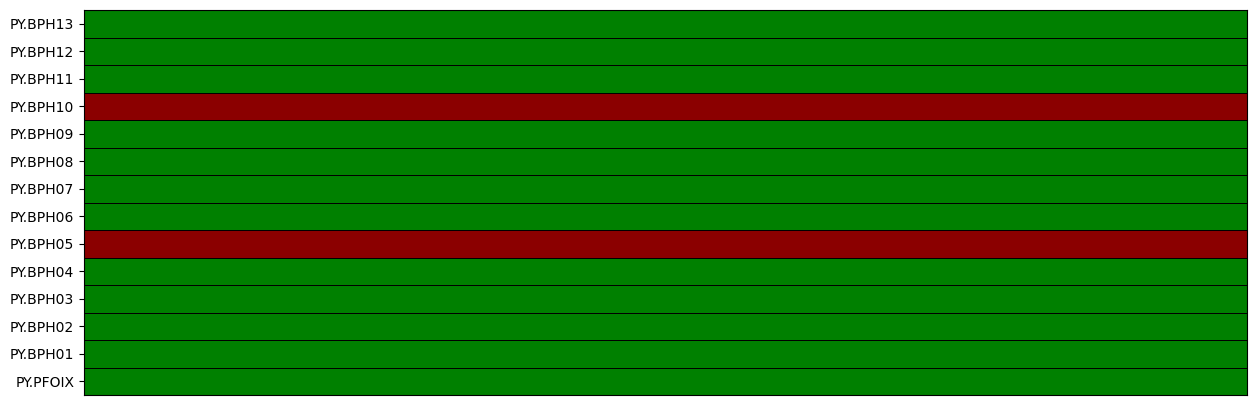


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-25T23:37:48.092000Z - 2023-05-25T23:38:48.092000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-25T23:37:48.092000Z - 2023-05-25T23:38:48.092000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-25T23:37:48.092000Z - 2023-05-25T23:38:48.092000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-25T23:37:48.090000Z - 2023-05-25T23:38:48.090000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-25T23:37:48.090000Z - 2023-05-25T23:38:48.090000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-25T23:37:48.090000Z - 2023-05-25T23:38:48.090000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-25T23:37:48.090000Z - 2023-05-25T23:38:48.090000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-25T23:37:48.090000Z - 2023-05-25T23:38:48.090000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-25T23:37:48.090000Z - 2023-05-25T23:38:48.090000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-25T23:37:48.090000Z - 2023-05-25T23:38:


 -> 223 2023-05-28 06:28:20.190000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH09 Failed to load inventory!
 -> BPH09 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


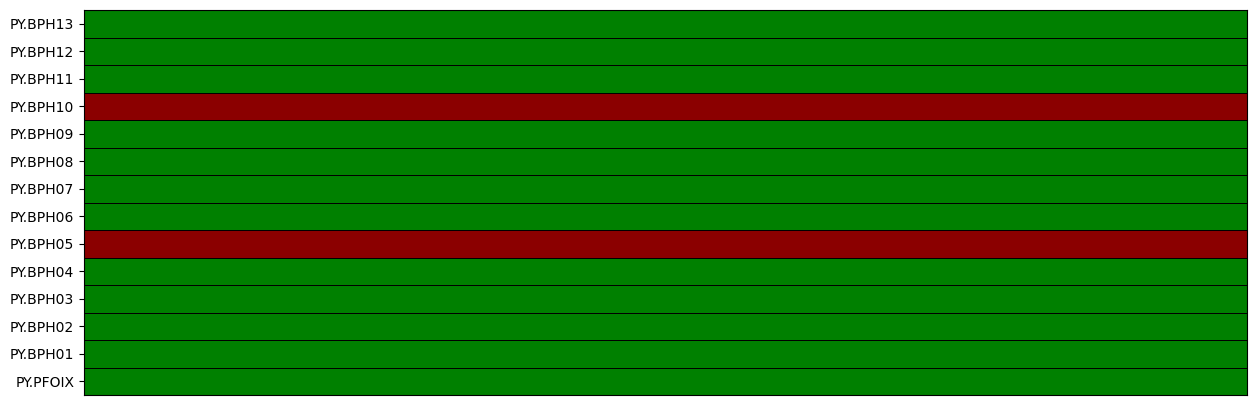


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-28T06:28:05.192200Z - 2023-05-28T06:29:05.192200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-28T06:28:05.192200Z - 2023-05-28T06:29:05.192200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-28T06:28:05.192200Z - 2023-05-28T06:29:05.192200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-28T06:28:05.190000Z - 2023-05-28T06:29:05.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-28T06:28:05.190000Z - 2023-05-28T06:29:05.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-28T06:28:05.190000Z - 2023-05-28T06:29:05.190000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-28T06:28:05.190000Z - 2023-05-28T06:29:05.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-28T06:28:05.190000Z - 2023-05-28T06:29:05.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-28T06:28:05.190000Z - 2023-05-28T06:29:05.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-28T06:28:05.190000Z - 2023-05-28T06:29:


 -> 224 2023-05-28 15:32:37.620000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


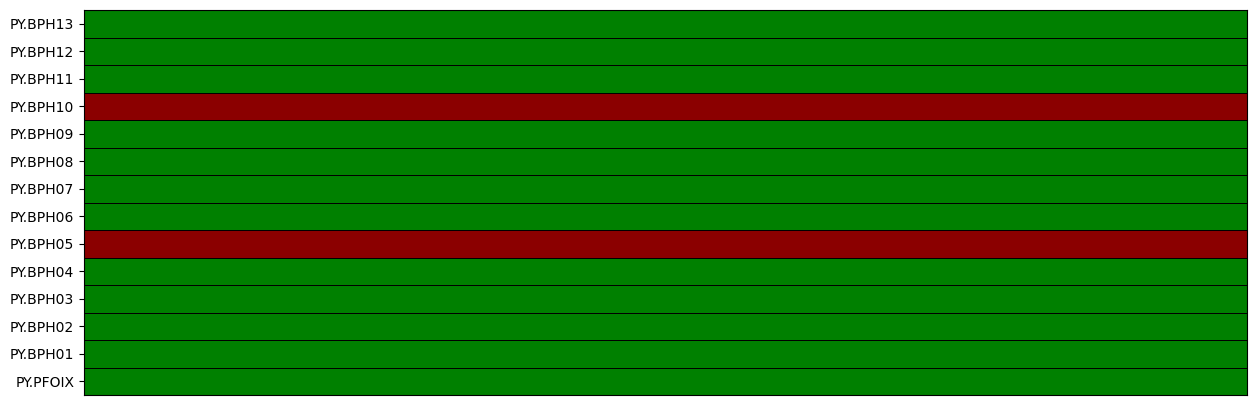


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-28T15:32:22.622200Z - 2023-05-28T15:33:22.622200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-28T15:32:22.622200Z - 2023-05-28T15:33:22.622200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-28T15:32:22.622200Z - 2023-05-28T15:33:22.622200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-28T15:32:22.620000Z - 2023-05-28T15:33:22.620000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-28T15:32:22.620000Z - 2023-05-28T15:33:22.620000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-28T15:32:22.620000Z - 2023-05-28T15:33:22.620000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-28T15:32:22.620000Z - 2023-05-28T15:33:22.620000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-28T15:32:22.620000Z - 2023-05-28T15:33:22.620000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-28T15:32:22.620000Z - 2023-05-28T15:33:22.620000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-28T15:32:22.620000Z - 2023-05-28T15:33:


 -> 225 2023-05-29 03:40:21.400000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


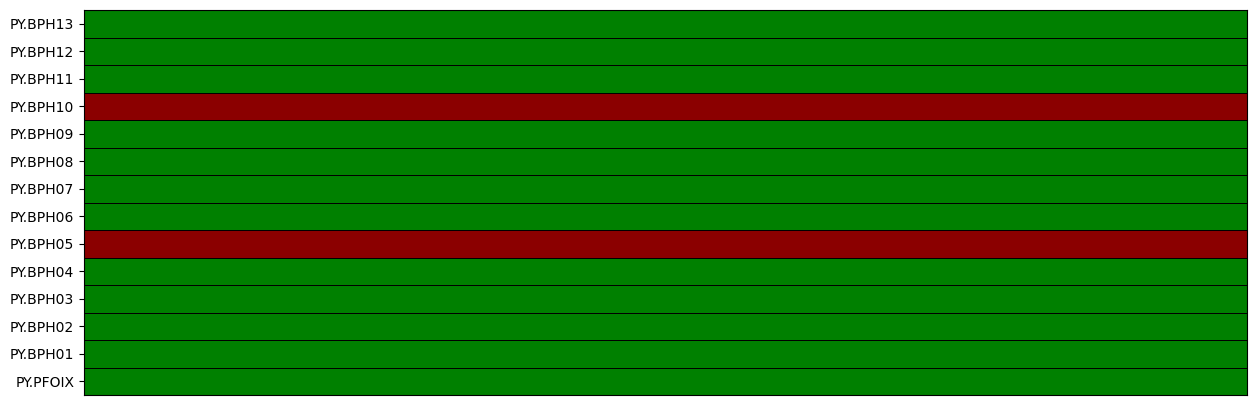


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> BPH03 Failed to load inventory!
 -> failed to compute ADR inner ...


9 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-29T03:40:06.402200Z - 2023-05-29T03:41:06.402200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-29T03:40:06.402200Z - 2023-05-29T03:41:06.402200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-29T03:40:06.402200Z - 2023-05-29T03:41:06.402200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-29T03:40:06.400000Z - 2023-05-29T03:41:06.400000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-29T03:40:06.400000Z - 2023-05-29T03:41:06.400000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-29T03:40:06.400000Z - 2023-05-29T03:41:06.400000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-29T03:40:06.400000Z - 2023-05-29T03:41:06.400000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-29T03:40:06.400000Z - 2023-05-29T03:41:06.400000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-29T03:40:06.400000Z - 2023-05-29T03:41:06.400000Z | 40.0 Hz, 2401 samples


 -> 226 2023-05-30 12:46:22.830000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


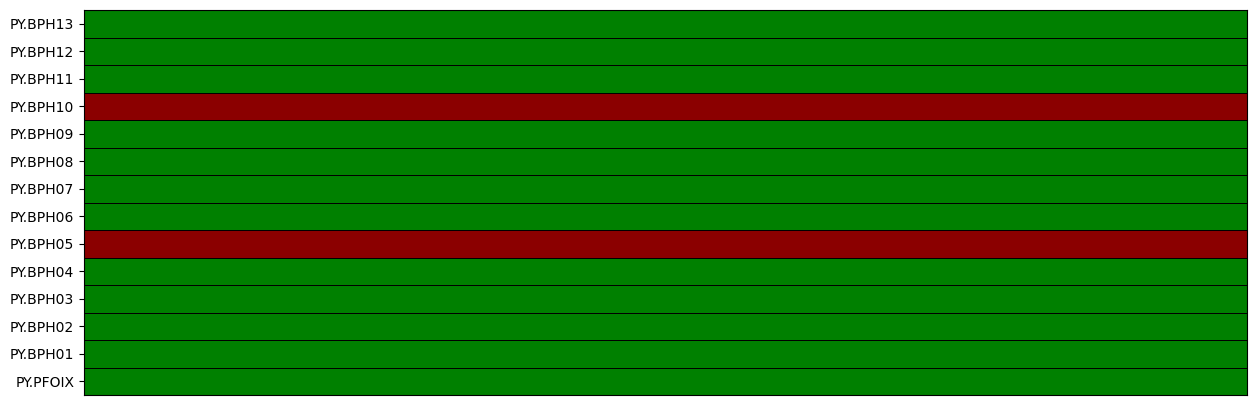


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.47 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-30T12:46:07.832300Z - 2023-05-30T12:47:07.832300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-30T12:46:07.832300Z - 2023-05-30T12:47:07.832300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-30T12:46:07.832300Z - 2023-05-30T12:47:07.832300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-30T12:46:07.830000Z - 2023-05-30T12:47:07.830000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-30T12:46:07.830000Z - 2023-05-30T12:47:07.830000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-30T12:46:07.830000Z - 2023-05-30T12:47:07.830000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-30T12:46:07.830000Z - 2023-05-30T12:47:07.830000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-30T12:46:07.830000Z - 2023-05-30T12:47:07.830000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-30T12:46:07.830000Z - 2023-05-30T12:47:07.830000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-30T12:46:07.830000Z - 2023-05-30T12:47:


 -> 227 2023-05-30 19:45:32.620000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


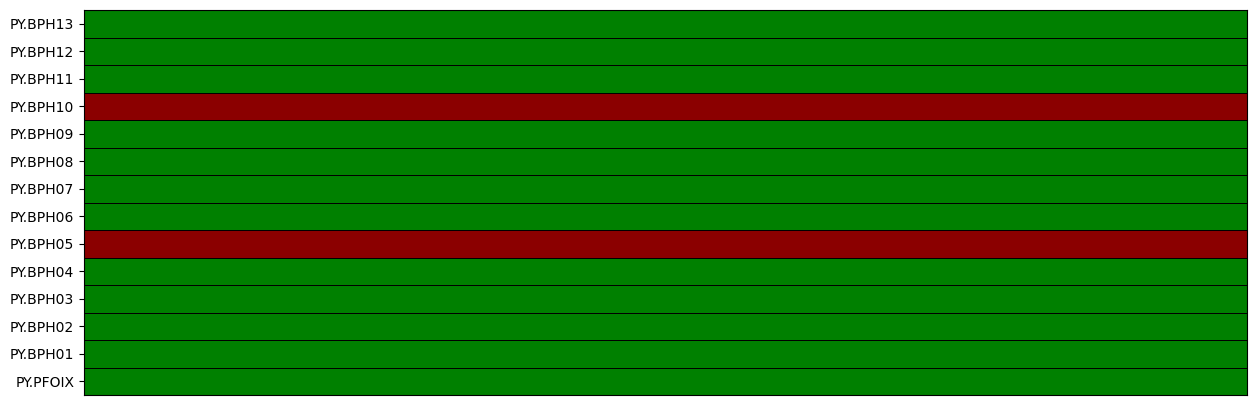


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-30T19:45:17.622300Z - 2023-05-30T19:46:17.622300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-30T19:45:17.622300Z - 2023-05-30T19:46:17.622300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-30T19:45:17.622300Z - 2023-05-30T19:46:17.622300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-30T19:45:17.620000Z - 2023-05-30T19:46:17.620000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-30T19:45:17.620000Z - 2023-05-30T19:46:17.620000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-30T19:45:17.620000Z - 2023-05-30T19:46:17.620000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-30T19:45:17.620000Z - 2023-05-30T19:46:17.620000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-30T19:45:17.620000Z - 2023-05-30T19:46:17.620000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-30T19:45:17.620000Z - 2023-05-30T19:46:17.620000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-30T19:45:17.620000Z - 2023-05-30T19:46:


 -> 228 2023-05-31 15:07:18.530000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


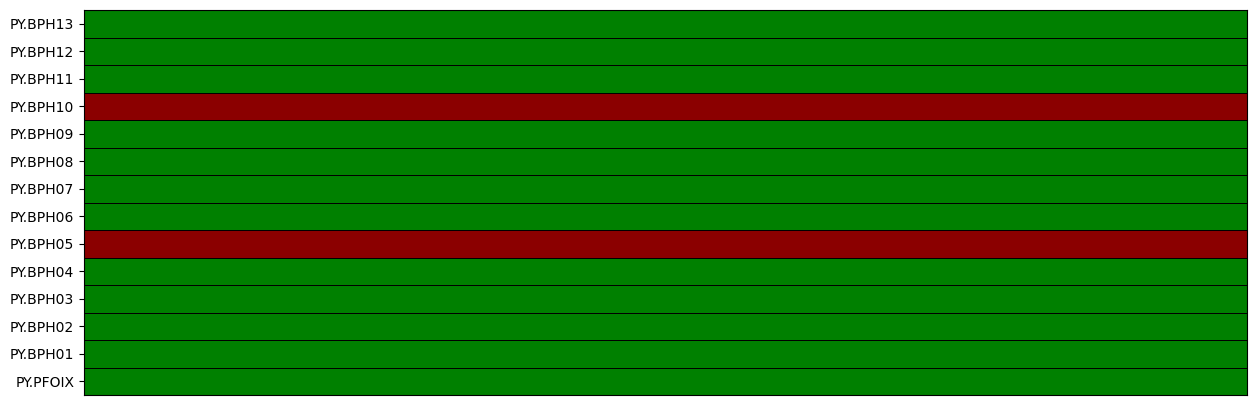


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH07 Failed to load inventory!
 -> BPH07 failed to rotate to ZNE
 -> continue computing ADR for 7 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-31T15:07:03.532300Z - 2023-05-31T15:08:03.532300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-31T15:07:03.532300Z - 2023-05-31T15:08:03.532300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-31T15:07:03.532300Z - 2023-05-31T15:08:03.532300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-31T15:07:03.530000Z - 2023-05-31T15:08:03.530000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-31T15:07:03.530000Z - 2023-05-31T15:08:03.530000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-31T15:07:03.530000Z - 2023-05-31T15:08:03.530000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-31T15:07:03.530000Z - 2023-05-31T15:08:03.530000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-31T15:07:03.530000Z - 2023-05-31T15:08:03.530000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-31T15:07:03.530000Z - 2023-05-31T15:08:03.530000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-31T15:07:03.530000Z - 2023-05-31T15:08:


 -> 229 2023-05-31 23:27:27.570000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


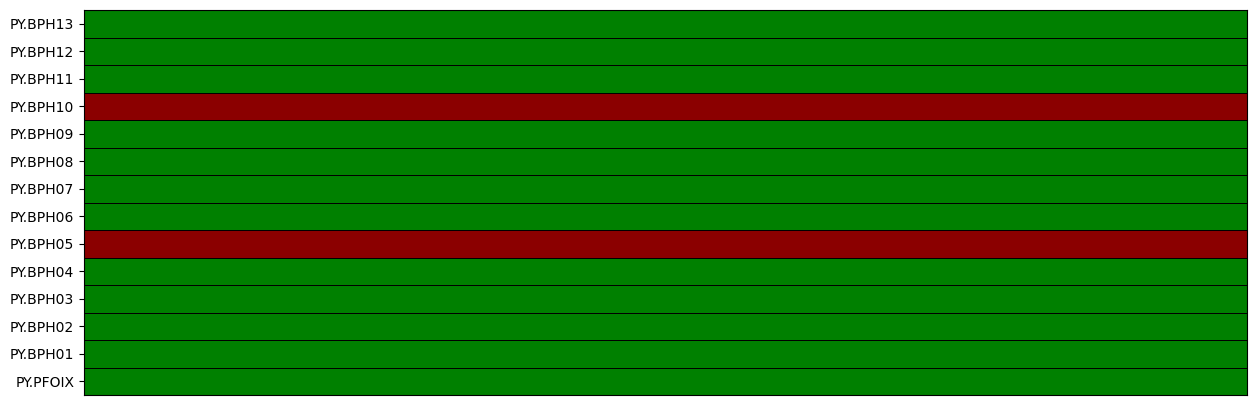


 -> Runtime: 0.64 minutes
 -> PFOIX Failed to load inventory!
 -> failed to compute ADR mid ...
 -> BPH01 Failed to load inventory!
 -> BPH01 failed to rotate to ZNE
 -> BPH02 Failed to load inventory!
 -> BPH02 failed to rotate to ZNE
 -> continue computing ADR for 3 of 5 stations ...

 -> Runtime: 0.25 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-05-31T23:27:12.572300Z - 2023-05-31T23:28:12.572300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-05-31T23:27:12.572300Z - 2023-05-31T23:28:12.572300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-05-31T23:27:12.572300Z - 2023-05-31T23:28:12.572300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-05-31T23:27:12.570000Z - 2023-05-31T23:28:12.570000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-05-31T23:27:12.570000Z - 2023-05-31T23:28:12.570000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-05-31T23:27:12.570000Z - 2023-05-31T23:28:12.570000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-05-31T23:27:12.570000Z - 2023-05-31T23:28:12.570000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-05-31T23:27:12.570000Z - 2023-05-31T23:28:12.570000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-05-31T23:27:12.570000Z - 2023-05-31T23:28:12.570000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-05-31T23:27:12.570000Z - 2023-05-31T23:28:


 -> 230 2023-06-03 13:30:20.310000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


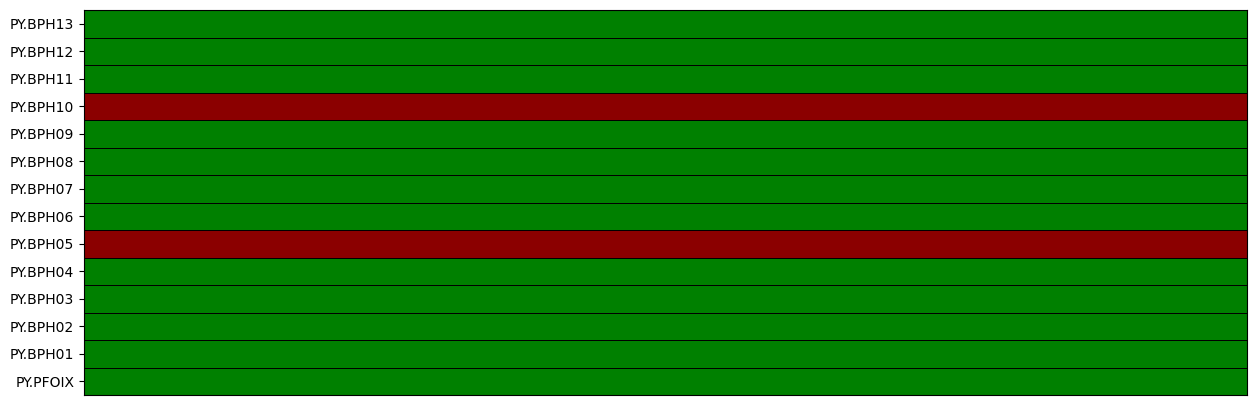


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-03T13:30:05.312300Z - 2023-06-03T13:31:05.312300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-03T13:30:05.312300Z - 2023-06-03T13:31:05.312300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-03T13:30:05.312300Z - 2023-06-03T13:31:05.312300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-03T13:30:05.310000Z - 2023-06-03T13:31:05.310000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-03T13:30:05.310000Z - 2023-06-03T13:31:05.310000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-03T13:30:05.310000Z - 2023-06-03T13:31:05.310000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-03T13:30:05.310000Z - 2023-06-03T13:31:05.310000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-03T13:30:05.310000Z - 2023-06-03T13:31:05.310000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-03T13:30:05.310000Z - 2023-06-03T13:31:05.310000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-03T13:30:05.310000Z - 2023-06-03T13:31:


 -> 231 2023-06-04 04:43:02.890000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


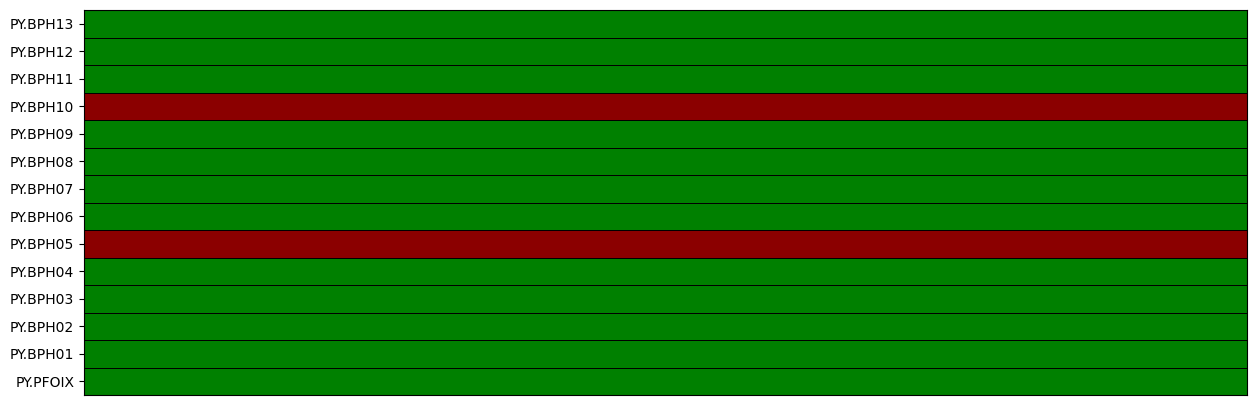


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> BPH01 Failed to load inventory!
 -> BPH01 failed to rotate to ZNE
 -> continue computing ADR for 4 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-04T04:42:47.892300Z - 2023-06-04T04:43:47.892300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-04T04:42:47.892300Z - 2023-06-04T04:43:47.892300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-04T04:42:47.892300Z - 2023-06-04T04:43:47.892300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-04T04:42:47.890000Z - 2023-06-04T04:43:47.890000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-04T04:42:47.890000Z - 2023-06-04T04:43:47.890000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-04T04:42:47.890000Z - 2023-06-04T04:43:47.890000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-04T04:42:47.890000Z - 2023-06-04T04:43:47.890000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-04T04:42:47.890000Z - 2023-06-04T04:43:47.890000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-04T04:42:47.890000Z - 2023-06-04T04:43:47.890000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-04T04:42:47.890000Z - 2023-06-04T04:43:


 -> 232 2023-06-05 06:07:59.080000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


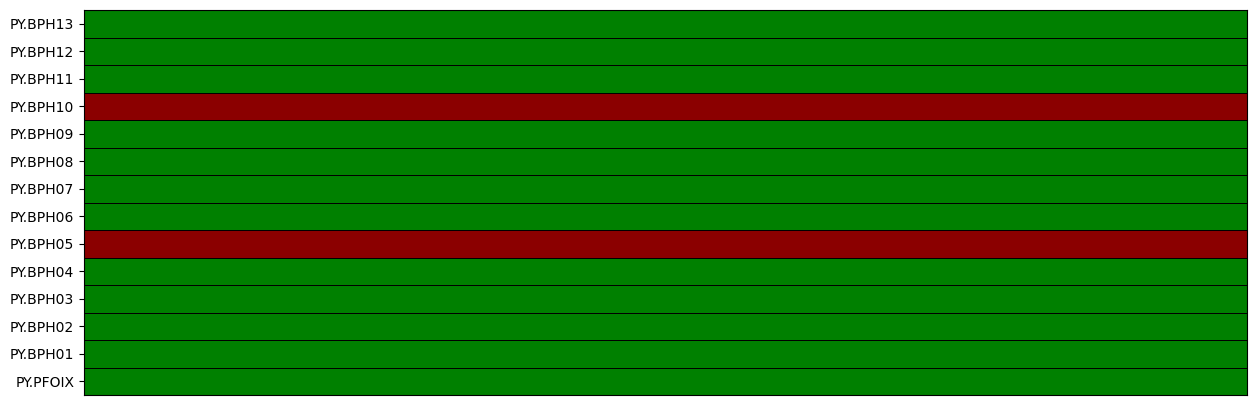


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...
 -> failed to compute ADR inner ...


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-05T06:07:44.082400Z - 2023-06-05T06:08:44.082400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-05T06:07:44.082400Z - 2023-06-05T06:08:44.082400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-05T06:07:44.082400Z - 2023-06-05T06:08:44.082400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-05T06:07:44.080000Z - 2023-06-05T06:08:44.080000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-05T06:07:44.080000Z - 2023-06-05T06:08:44.080000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-05T06:07:44.080000Z - 2023-06-05T06:08:44.080000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-05T06:07:44.080000Z - 2023-06-05T06:08:44.080000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-05T06:07:44.080000Z - 2023-06-05T06:08:44.080000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-05T06:07:44.080000Z - 2023-06-05T06:08:44.080000Z | 40.0 Hz, 2401 samples
PY.RPFO.mid.BJE | 2023-06-05T06:07:44.080000Z - 2023-06-05T06:08:


 -> 233 2023-06-05 17:22:02.350000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


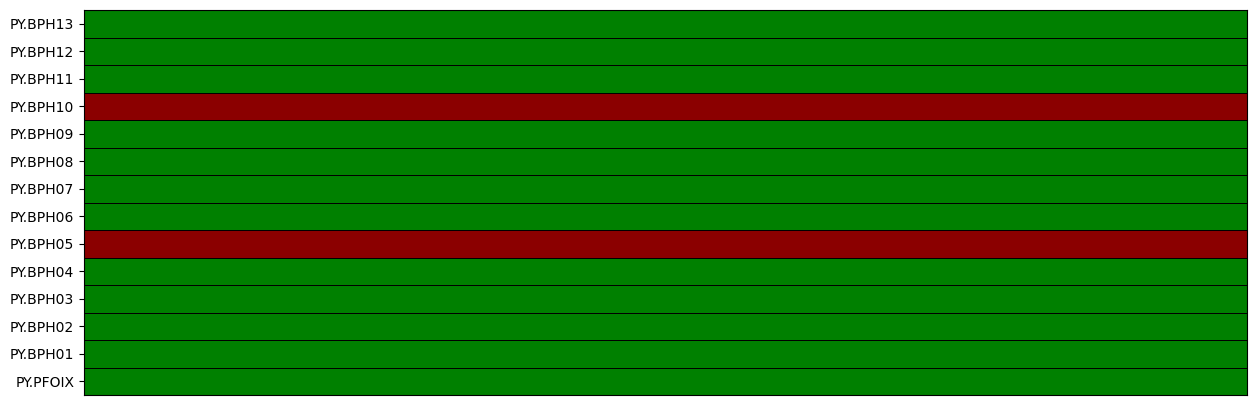


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-05T17:21:47.352200Z - 2023-06-05T17:22:47.352200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-05T17:21:47.352200Z - 2023-06-05T17:22:47.352200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-05T17:21:47.352200Z - 2023-06-05T17:22:47.352200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-05T17:21:47.350000Z - 2023-06-05T17:22:47.350000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-05T17:21:47.350000Z - 2023-06-05T17:22:47.350000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-05T17:21:47.350000Z - 2023-06-05T17:22:47.350000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-05T17:21:47.350000Z - 2023-06-05T17:22:47.350000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-05T17:21:47.350000Z - 2023-06-05T17:22:47.350000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-05T17:21:47.350000Z - 2023-06-05T17:22:47.350000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-05T17:21:47.350000Z - 2023-06-05T17:22:


 -> 234 2023-06-05 17:23:05.920000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


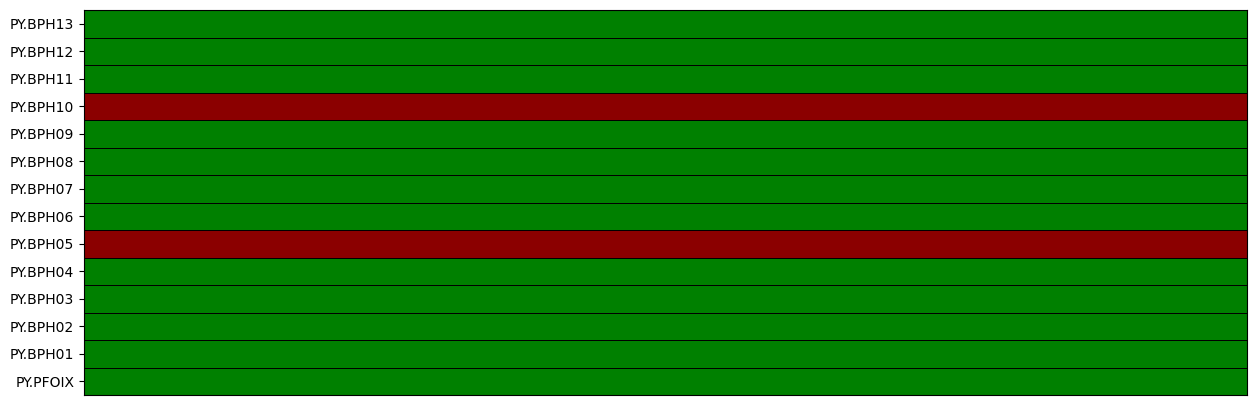


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-05T17:22:50.922200Z - 2023-06-05T17:23:50.922200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-05T17:22:50.922200Z - 2023-06-05T17:23:50.922200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-05T17:22:50.922200Z - 2023-06-05T17:23:50.922200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-05T17:22:50.920000Z - 2023-06-05T17:23:50.920000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-05T17:22:50.920000Z - 2023-06-05T17:23:50.920000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-05T17:22:50.920000Z - 2023-06-05T17:23:50.920000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-05T17:22:50.920000Z - 2023-06-05T17:23:50.920000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-05T17:22:50.920000Z - 2023-06-05T17:23:50.920000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-05T17:22:50.920000Z - 2023-06-05T17:23:50.920000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-05T17:22:50.920000Z - 2023-06-05T17:23:


 -> 235 2023-06-11 02:38:25.290000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


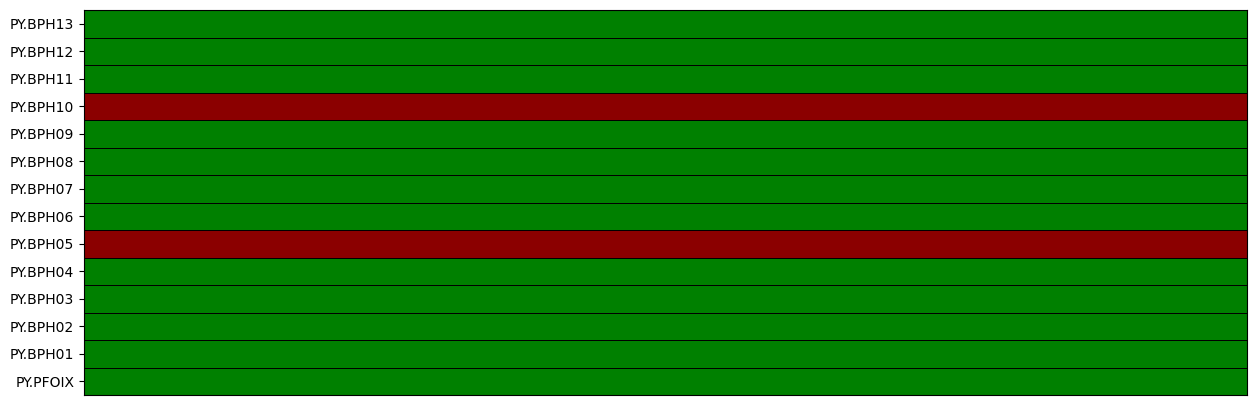


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH06 Failed to load inventory!
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-11T02:38:10.292200Z - 2023-06-11T02:39:10.292200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-11T02:38:10.292200Z - 2023-06-11T02:39:10.292200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-11T02:38:10.292200Z - 2023-06-11T02:39:10.292200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-11T02:38:10.290000Z - 2023-06-11T02:39:10.290000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-11T02:38:10.290000Z - 2023-06-11T02:39:10.290000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-11T02:38:10.290000Z - 2023-06-11T02:39:10.290000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-11T02:38:10.290000Z - 2023-06-11T02:39:10.290000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-11T02:38:10.290000Z - 2023-06-11T02:39:10.290000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-11T02:38:10.290000Z - 2023-06-11T02:39:10.290000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-11T02:38:10.290000Z - 2023-06-11T02:39:


 -> 236 2023-06-11 03:32:26.760000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


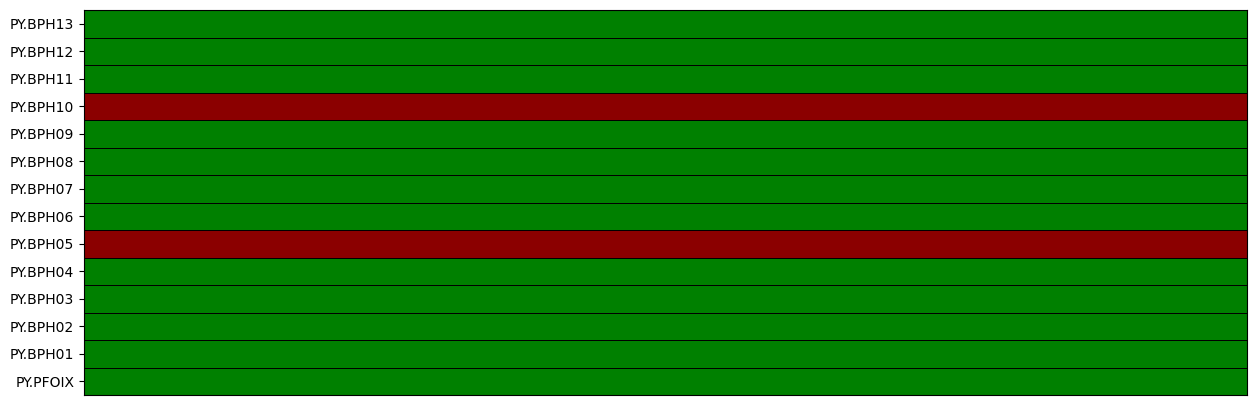


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-11T03:32:11.762200Z - 2023-06-11T03:33:11.762200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-11T03:32:11.762200Z - 2023-06-11T03:33:11.762200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-11T03:32:11.762200Z - 2023-06-11T03:33:11.762200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-11T03:32:11.760000Z - 2023-06-11T03:33:11.760000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-11T03:32:11.760000Z - 2023-06-11T03:33:11.760000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-11T03:32:11.760000Z - 2023-06-11T03:33:11.760000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-11T03:32:11.760000Z - 2023-06-11T03:33:11.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-11T03:32:11.760000Z - 2023-06-11T03:33:11.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-11T03:32:11.760000Z - 2023-06-11T03:33:11.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-11T03:32:11.760000Z - 2023-06-11T03:33:


 -> 237 2023-06-15 04:11:15.220000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


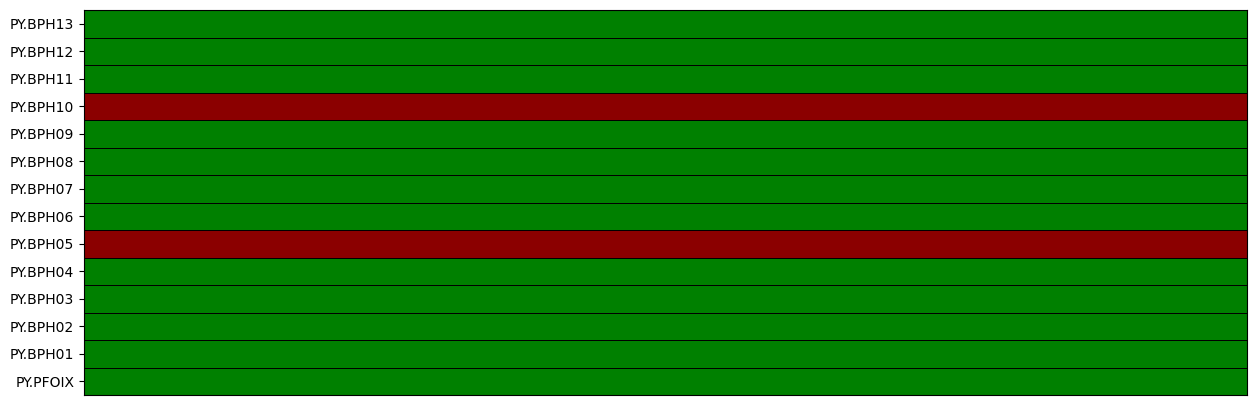


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-15T04:11:00.222100Z - 2023-06-15T04:12:00.222100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-15T04:11:00.222100Z - 2023-06-15T04:12:00.222100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-15T04:11:00.222100Z - 2023-06-15T04:12:00.222100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-15T04:11:00.220000Z - 2023-06-15T04:12:00.220000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-15T04:11:00.220000Z - 2023-06-15T04:12:00.220000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-15T04:11:00.220000Z - 2023-06-15T04:12:00.220000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-15T04:11:00.220000Z - 2023-06-15T04:12:00.220000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-15T04:11:00.220000Z - 2023-06-15T04:12:00.220000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-15T04:11:00.220000Z - 2023-06-15T04:12:00.220000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-15T04:11:00.220000Z - 2023-06-15T04:12:


 -> 238 2023-06-17 07:17:28.120000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


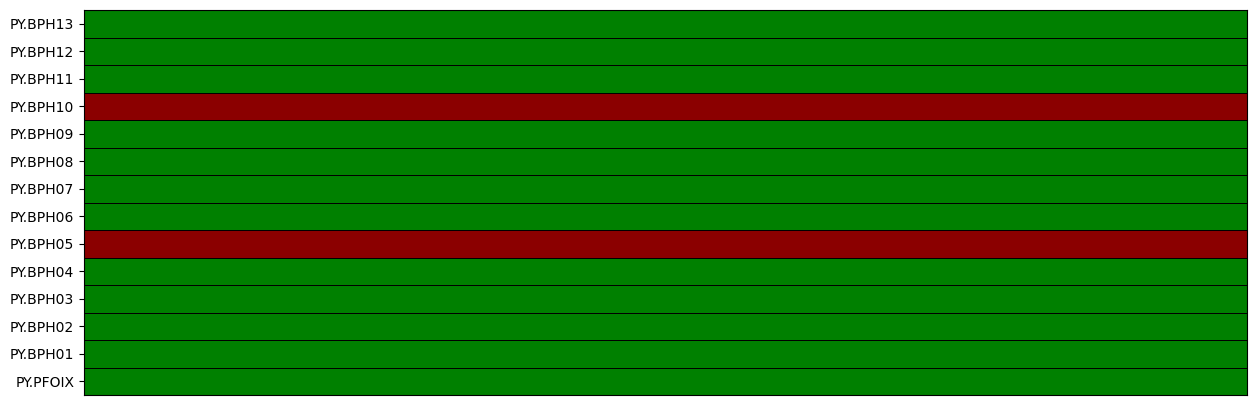


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-17T07:17:13.122400Z - 2023-06-17T07:18:13.122400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-17T07:17:13.122400Z - 2023-06-17T07:18:13.122400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-17T07:17:13.122400Z - 2023-06-17T07:18:13.122400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-17T07:17:13.120000Z - 2023-06-17T07:18:13.120000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-17T07:17:13.120000Z - 2023-06-17T07:18:13.120000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-17T07:17:13.120000Z - 2023-06-17T07:18:13.120000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-17T07:17:13.120000Z - 2023-06-17T07:18:13.120000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-17T07:17:13.120000Z - 2023-06-17T07:18:13.120000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-17T07:17:13.120000Z - 2023-06-17T07:18:13.120000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-17T07:17:13.120000Z - 2023-06-17T07:18:


 -> 239 2023-06-18 10:43:51.780000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


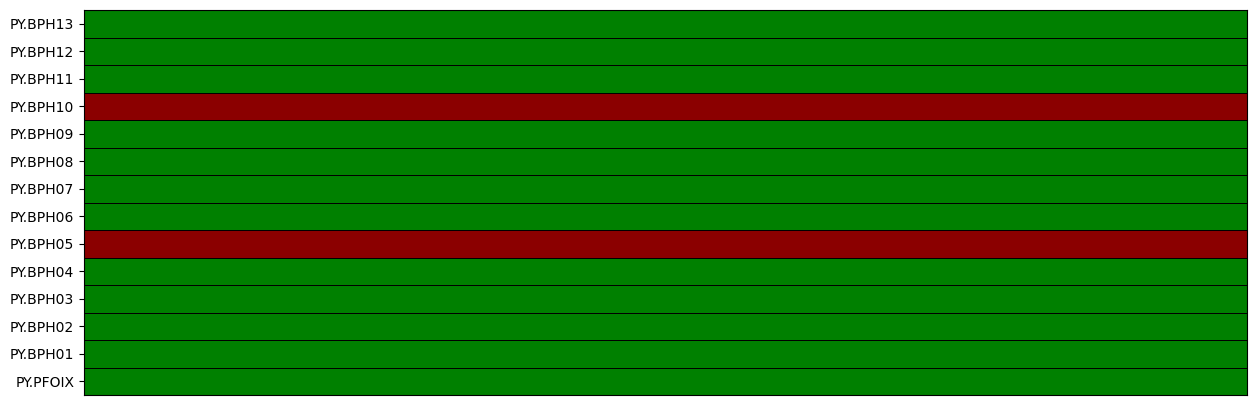


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-18T10:43:36.782400Z - 2023-06-18T10:44:36.782400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-18T10:43:36.782400Z - 2023-06-18T10:44:36.782400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-18T10:43:36.782400Z - 2023-06-18T10:44:36.782400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-18T10:43:36.780000Z - 2023-06-18T10:44:36.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-18T10:43:36.780000Z - 2023-06-18T10:44:36.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-18T10:43:36.780000Z - 2023-06-18T10:44:36.780000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-18T10:43:36.780000Z - 2023-06-18T10:44:36.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-18T10:43:36.780000Z - 2023-06-18T10:44:36.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-18T10:43:36.780000Z - 2023-06-18T10:44:36.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-18T10:43:36.780000Z - 2023-06-18T10:44:


 -> 240 2023-06-19 06:54:54.060000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH07 Failed to load inventory!
 -> BPH07 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 11 of 14 stations ...
 -> failed to compute ADR all ...
 -> BPH01 Failed to load inventory!
 -> failed to compute ADR mid ...
 -> PFOIX Failed to load inventory!
 -> failed to compute ADR inner ...


6 Trace(s) in Stream:
PY.BSPF..HJE  | 2023-06-19T06:54:39.059900Z - 2023-06-19T06:55:39.059900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN  | 2023-06-19T06:54:39.059900Z - 2023-06-19T06:55:39.059900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ  | 2023-06-19T06:54:39.059900Z - 2023-06-19T06:55:39.059900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE | 2023-06-19T06:54:39.060000Z - 2023-06-19T06:55:39.060000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN | 2023-06-19T06:54:39.060000Z - 2023-06-19T06:55:39.060000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ | 2023-06-19T06:54:39.060000Z - 2023-06-19T06:55:39.060000Z | 200.0 Hz, 12001 samples


 -> 241 2023-06-20 23:42:15.310000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


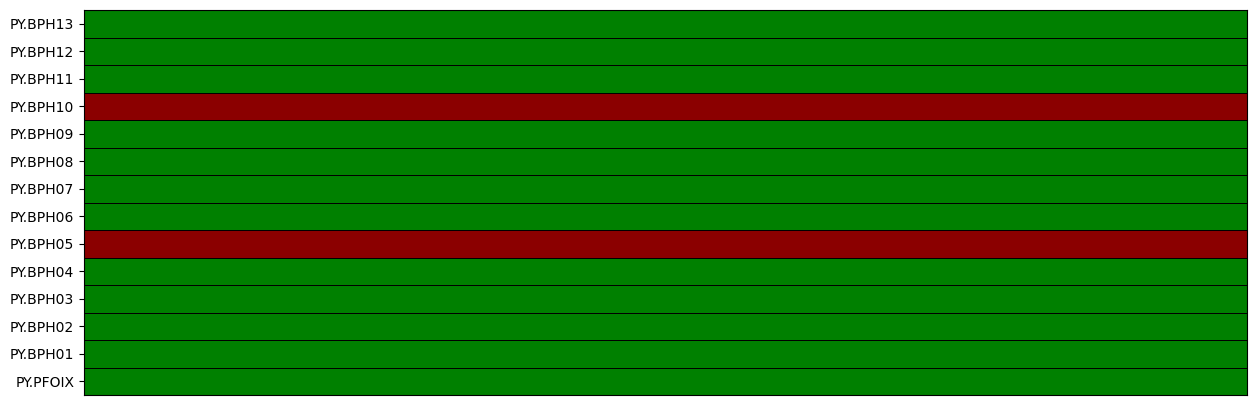


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-20T23:42:00.310100Z - 2023-06-20T23:43:00.310100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-20T23:42:00.310100Z - 2023-06-20T23:43:00.310100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-20T23:42:00.310100Z - 2023-06-20T23:43:00.310100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-20T23:42:00.310000Z - 2023-06-20T23:43:00.310000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-20T23:42:00.310000Z - 2023-06-20T23:43:00.310000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-20T23:42:00.310000Z - 2023-06-20T23:43:00.310000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-20T23:42:00.310000Z - 2023-06-20T23:43:00.310000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-20T23:42:00.310000Z - 2023-06-20T23:43:00.310000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-20T23:42:00.310000Z - 2023-06-20T23:43:00.310000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-20T23:42:00.310000Z - 2023-06-20T23:43:


 -> 242 2023-06-22 02:37:34.870000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


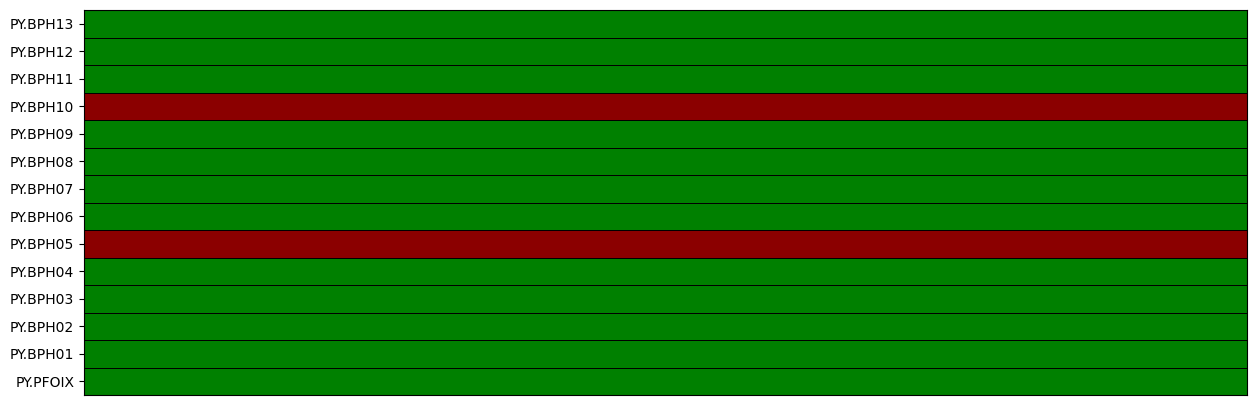


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-22T02:37:19.870100Z - 2023-06-22T02:38:19.870100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-22T02:37:19.870100Z - 2023-06-22T02:38:19.870100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-22T02:37:19.870100Z - 2023-06-22T02:38:19.870100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-22T02:37:19.870000Z - 2023-06-22T02:38:19.870000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-22T02:37:19.870000Z - 2023-06-22T02:38:19.870000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-22T02:37:19.870000Z - 2023-06-22T02:38:19.870000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-22T02:37:19.870000Z - 2023-06-22T02:38:19.870000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-22T02:37:19.870000Z - 2023-06-22T02:38:19.870000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-22T02:37:19.870000Z - 2023-06-22T02:38:19.870000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-22T02:37:19.870000Z - 2023-06-22T02:38:


 -> 243 2023-06-23 05:12:37.680000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


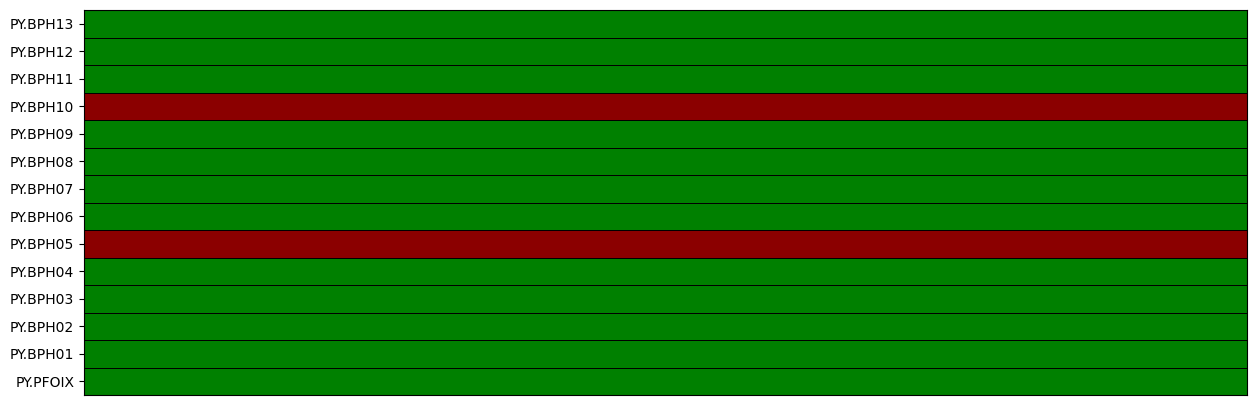


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-23T05:12:22.680100Z - 2023-06-23T05:13:22.680100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-23T05:12:22.680100Z - 2023-06-23T05:13:22.680100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-23T05:12:22.680100Z - 2023-06-23T05:13:22.680100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-23T05:12:22.680000Z - 2023-06-23T05:13:22.680000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-23T05:12:22.680000Z - 2023-06-23T05:13:22.680000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-23T05:12:22.680000Z - 2023-06-23T05:13:22.680000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-23T05:12:22.680000Z - 2023-06-23T05:13:22.680000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-23T05:12:22.680000Z - 2023-06-23T05:13:22.680000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-23T05:12:22.680000Z - 2023-06-23T05:13:22.680000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-23T05:12:22.680000Z - 2023-06-23T05:13:


 -> 244 2023-06-25 19:35:15.960000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


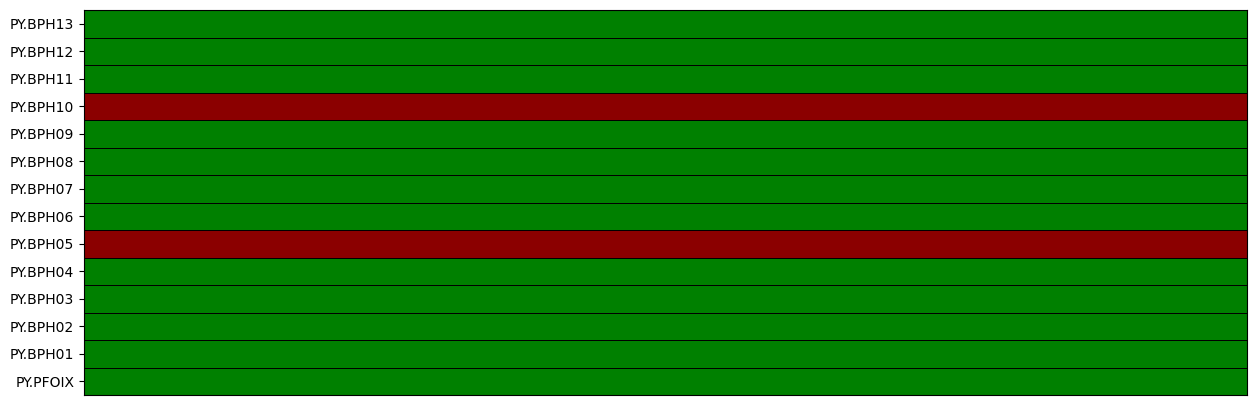


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.49 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-25T19:35:00.958600Z - 2023-06-25T19:36:00.958600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-25T19:35:00.958600Z - 2023-06-25T19:36:00.958600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-25T19:35:00.958600Z - 2023-06-25T19:36:00.958600Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-25T19:35:00.960000Z - 2023-06-25T19:36:00.960000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-25T19:35:00.960000Z - 2023-06-25T19:36:00.960000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-25T19:35:00.960000Z - 2023-06-25T19:36:00.960000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-25T19:35:00.960000Z - 2023-06-25T19:36:00.960000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-25T19:35:00.960000Z - 2023-06-25T19:36:00.960000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-25T19:35:00.960000Z - 2023-06-25T19:36:00.960000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-25T19:35:00.960000Z - 2023-06-25T19:36:


 -> 245 2023-06-25 20:21:44.480000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


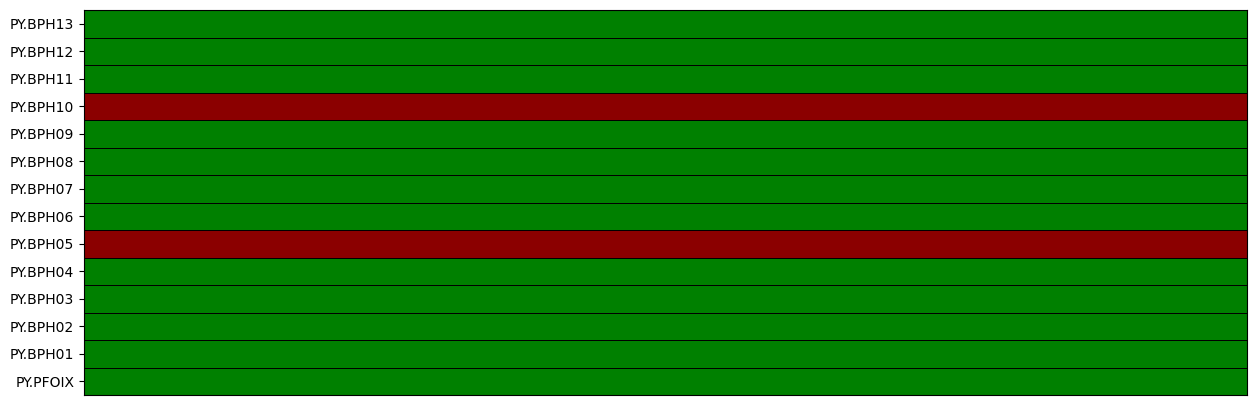


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...
 -> failed to compute ADR inner ...


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-25T20:21:29.478600Z - 2023-06-25T20:22:29.478600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-25T20:21:29.478600Z - 2023-06-25T20:22:29.478600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-25T20:21:29.478600Z - 2023-06-25T20:22:29.478600Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-25T20:21:29.480000Z - 2023-06-25T20:22:29.480000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-25T20:21:29.480000Z - 2023-06-25T20:22:29.480000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-25T20:21:29.480000Z - 2023-06-25T20:22:29.480000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-25T20:21:29.480000Z - 2023-06-25T20:22:29.480000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-25T20:21:29.480000Z - 2023-06-25T20:22:29.480000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-25T20:21:29.480000Z - 2023-06-25T20:22:29.480000Z | 40.0 Hz, 2401 samples
PY.RPFO.mid.BJE | 2023-06-25T20:21:29.480000Z - 2023-06-25T20:22:


 -> 246 2023-06-26 07:39:35.530000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


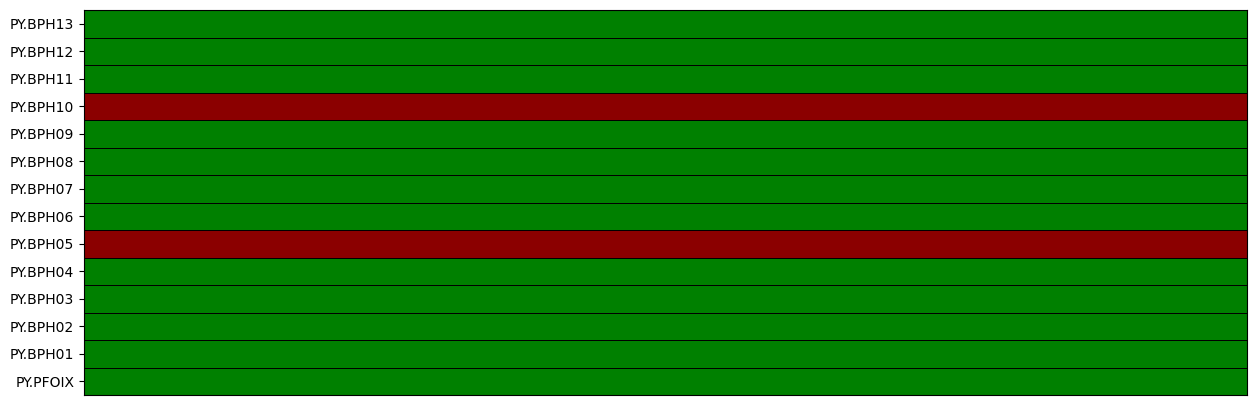


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-26T07:39:20.528600Z - 2023-06-26T07:40:20.528600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-26T07:39:20.528600Z - 2023-06-26T07:40:20.528600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-26T07:39:20.528600Z - 2023-06-26T07:40:20.528600Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-26T07:39:20.530000Z - 2023-06-26T07:40:20.530000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-26T07:39:20.530000Z - 2023-06-26T07:40:20.530000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-26T07:39:20.530000Z - 2023-06-26T07:40:20.530000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-26T07:39:20.530000Z - 2023-06-26T07:40:20.530000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-26T07:39:20.530000Z - 2023-06-26T07:40:20.530000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-26T07:39:20.530000Z - 2023-06-26T07:40:20.530000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-26T07:39:20.530000Z - 2023-06-26T07:40:


 -> 247 2023-06-27 07:03:01.380000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


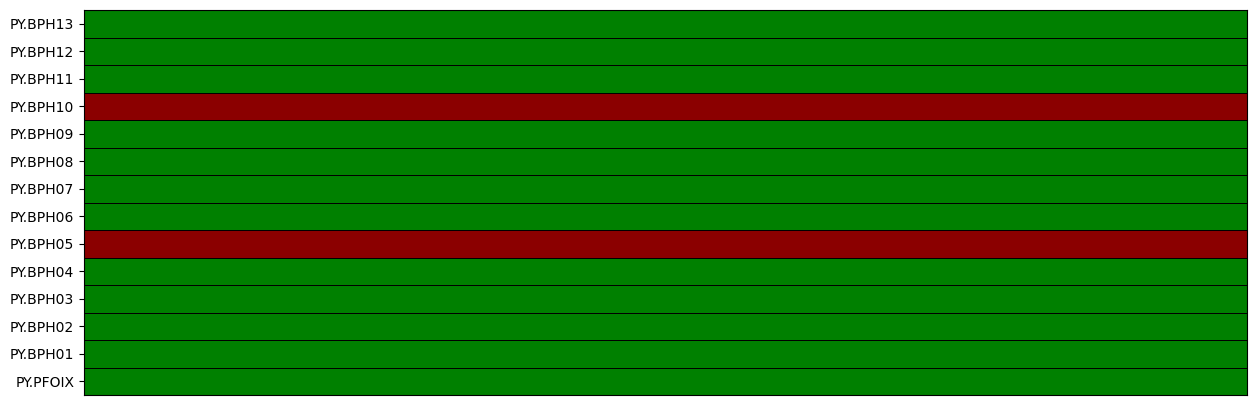


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-27T07:02:46.379900Z - 2023-06-27T07:03:46.379900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-27T07:02:46.379900Z - 2023-06-27T07:03:46.379900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-27T07:02:46.379900Z - 2023-06-27T07:03:46.379900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-27T07:02:46.380000Z - 2023-06-27T07:03:46.380000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-27T07:02:46.380000Z - 2023-06-27T07:03:46.380000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-27T07:02:46.380000Z - 2023-06-27T07:03:46.380000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-27T07:02:46.380000Z - 2023-06-27T07:03:46.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-27T07:02:46.380000Z - 2023-06-27T07:03:46.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-27T07:02:46.380000Z - 2023-06-27T07:03:46.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-27T07:02:46.380000Z - 2023-06-27T07:03:


 -> 248 2023-06-27 16:11:14.360000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


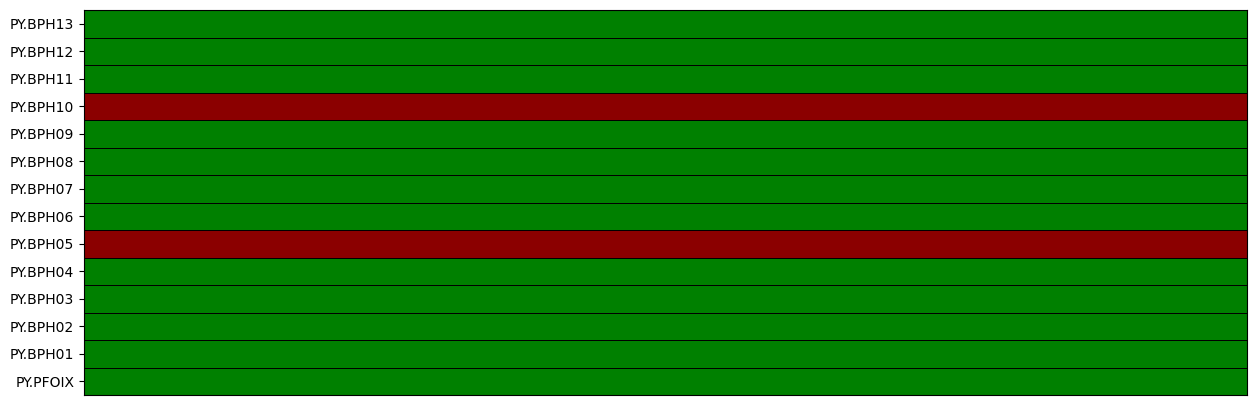


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-27T16:10:59.359900Z - 2023-06-27T16:11:59.359900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-27T16:10:59.359900Z - 2023-06-27T16:11:59.359900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-27T16:10:59.359900Z - 2023-06-27T16:11:59.359900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-27T16:10:59.360000Z - 2023-06-27T16:11:59.360000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-27T16:10:59.360000Z - 2023-06-27T16:11:59.360000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-27T16:10:59.360000Z - 2023-06-27T16:11:59.360000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-27T16:10:59.360000Z - 2023-06-27T16:11:59.360000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-27T16:10:59.360000Z - 2023-06-27T16:11:59.360000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-27T16:10:59.360000Z - 2023-06-27T16:11:59.360000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-27T16:10:59.360000Z - 2023-06-27T16:11:


 -> 249 2023-06-28 01:45:06.060000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


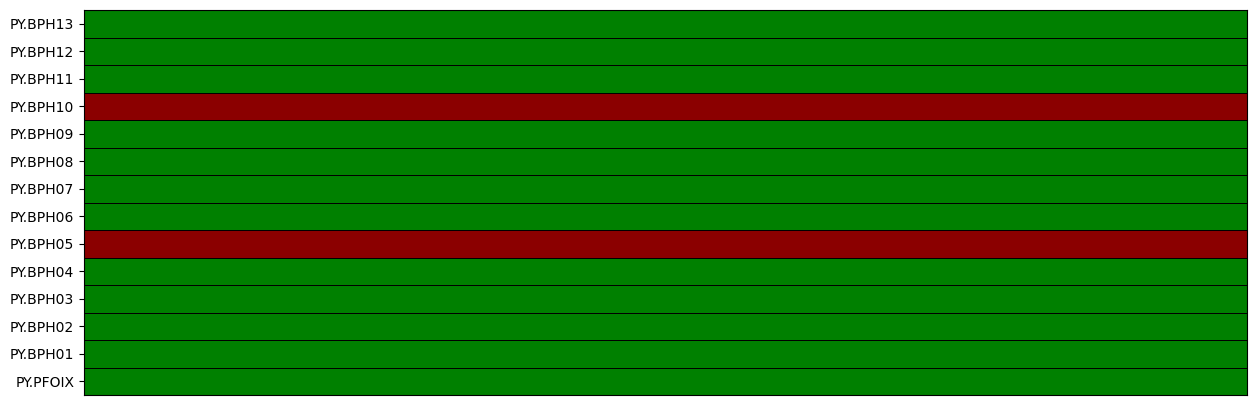


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-28T01:44:51.060200Z - 2023-06-28T01:45:51.060200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-28T01:44:51.060200Z - 2023-06-28T01:45:51.060200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-28T01:44:51.060200Z - 2023-06-28T01:45:51.060200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-28T01:44:51.060000Z - 2023-06-28T01:45:51.060000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-28T01:44:51.060000Z - 2023-06-28T01:45:51.060000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-28T01:44:51.060000Z - 2023-06-28T01:45:51.060000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-28T01:44:51.060000Z - 2023-06-28T01:45:51.060000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-28T01:44:51.060000Z - 2023-06-28T01:45:51.060000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-28T01:44:51.060000Z - 2023-06-28T01:45:51.060000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-28T01:44:51.060000Z - 2023-06-28T01:45:


 -> 250 2023-06-28 04:15:07.840000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH10..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


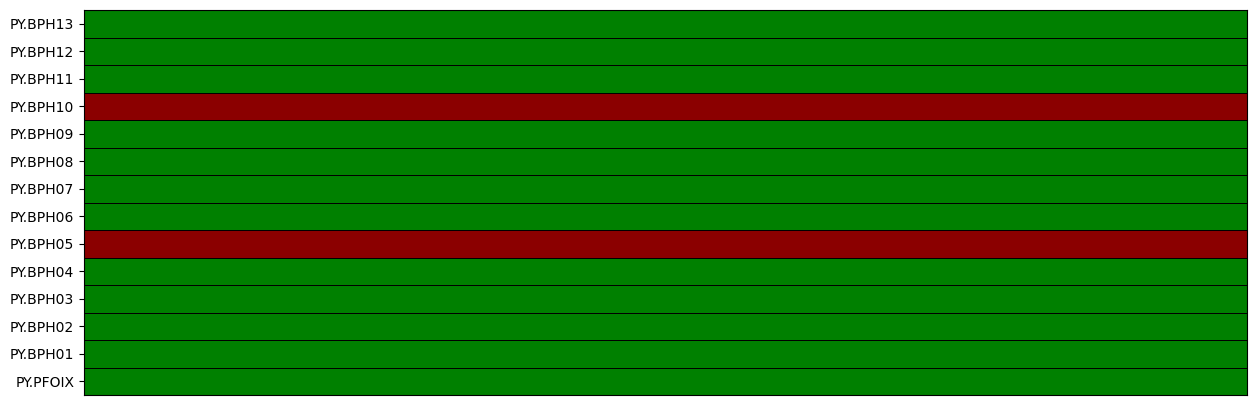


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-28T04:14:52.840200Z - 2023-06-28T04:15:52.840200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-28T04:14:52.840200Z - 2023-06-28T04:15:52.840200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-28T04:14:52.840200Z - 2023-06-28T04:15:52.840200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-28T04:14:52.840000Z - 2023-06-28T04:15:52.840000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-28T04:14:52.840000Z - 2023-06-28T04:15:52.840000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-28T04:14:52.840000Z - 2023-06-28T04:15:52.840000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-28T04:14:52.840000Z - 2023-06-28T04:15:52.840000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-28T04:14:52.840000Z - 2023-06-28T04:15:52.840000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-28T04:14:52.840000Z - 2023-06-28T04:15:52.840000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-28T04:14:52.840000Z - 2023-06-28T04:15:


 -> 251 2023-06-30 23:07:07.100000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


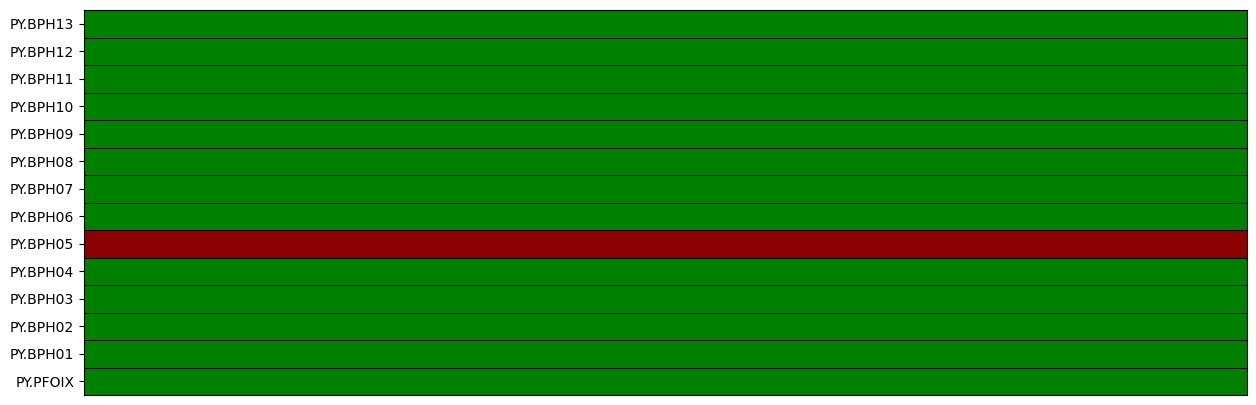


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-06-30T23:06:52.100200Z - 2023-06-30T23:07:52.100200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-06-30T23:06:52.100200Z - 2023-06-30T23:07:52.100200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-06-30T23:06:52.100200Z - 2023-06-30T23:07:52.100200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-06-30T23:06:52.100000Z - 2023-06-30T23:07:52.100000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-06-30T23:06:52.100000Z - 2023-06-30T23:07:52.100000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-06-30T23:06:52.100000Z - 2023-06-30T23:07:52.100000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-06-30T23:06:52.100000Z - 2023-06-30T23:07:52.100000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-06-30T23:06:52.100000Z - 2023-06-30T23:07:52.100000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-06-30T23:06:52.100000Z - 2023-06-30T23:07:52.100000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-06-30T23:06:52.100000Z - 2023-06-30T23:07:


 -> 252 2023-07-01 19:26:42.610000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


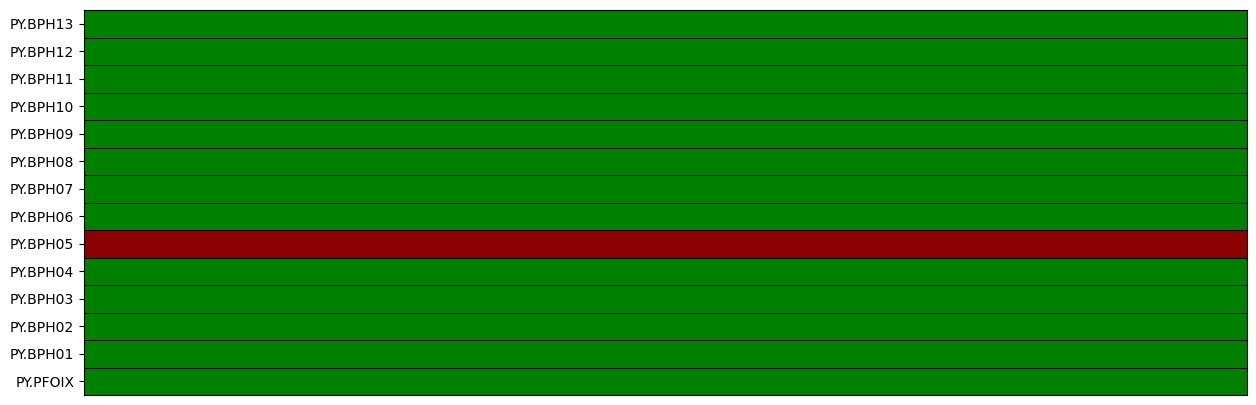


 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> BPH02 Failed to load inventory!
 -> BPH02 failed to rotate to ZNE
 -> continue computing ADR for 4 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-01T19:26:27.610200Z - 2023-07-01T19:27:27.610200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-01T19:26:27.610200Z - 2023-07-01T19:27:27.610200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-01T19:26:27.610200Z - 2023-07-01T19:27:27.610200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-01T19:26:27.610000Z - 2023-07-01T19:27:27.610000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-01T19:26:27.610000Z - 2023-07-01T19:27:27.610000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-01T19:26:27.610000Z - 2023-07-01T19:27:27.610000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-01T19:26:27.610000Z - 2023-07-01T19:27:27.610000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-01T19:26:27.610000Z - 2023-07-01T19:27:27.610000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-01T19:26:27.610000Z - 2023-07-01T19:27:27.610000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-01T19:26:27.610000Z - 2023-07-01T19:27:


 -> 253 2023-07-01 20:43:04.290000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 13 of 14 stations ...


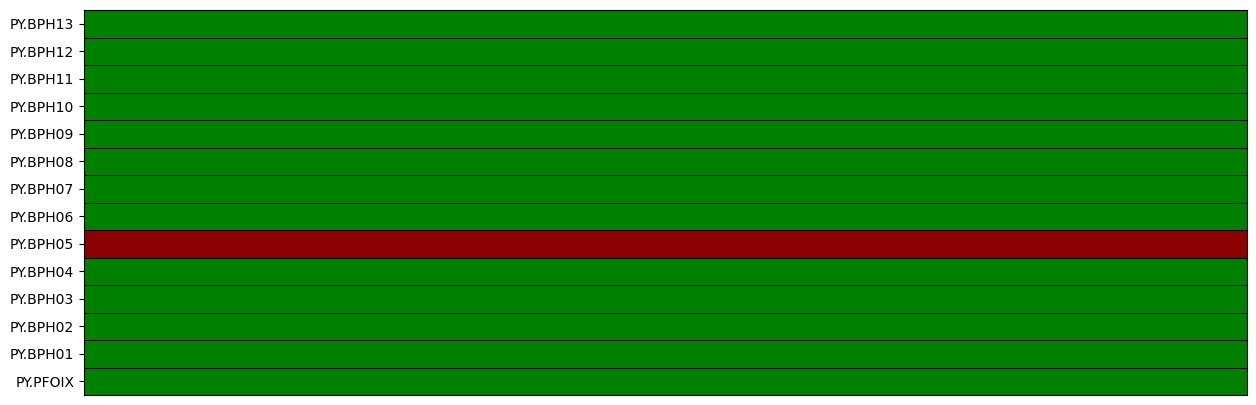


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.41 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-01T20:42:49.290200Z - 2023-07-01T20:43:49.290200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-01T20:42:49.290200Z - 2023-07-01T20:43:49.290200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-01T20:42:49.290200Z - 2023-07-01T20:43:49.290200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-01T20:42:49.290000Z - 2023-07-01T20:43:49.290000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-01T20:42:49.290000Z - 2023-07-01T20:43:49.290000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-01T20:42:49.290000Z - 2023-07-01T20:43:49.290000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-01T20:42:49.290000Z - 2023-07-01T20:43:49.290000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-01T20:42:49.290000Z - 2023-07-01T20:43:49.290000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-01T20:42:49.290000Z - 2023-07-01T20:43:49.290000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-01T20:42:49.290000Z - 2023-07-01T20:43:


 -> 254 2023-07-02 20:36:42.220000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


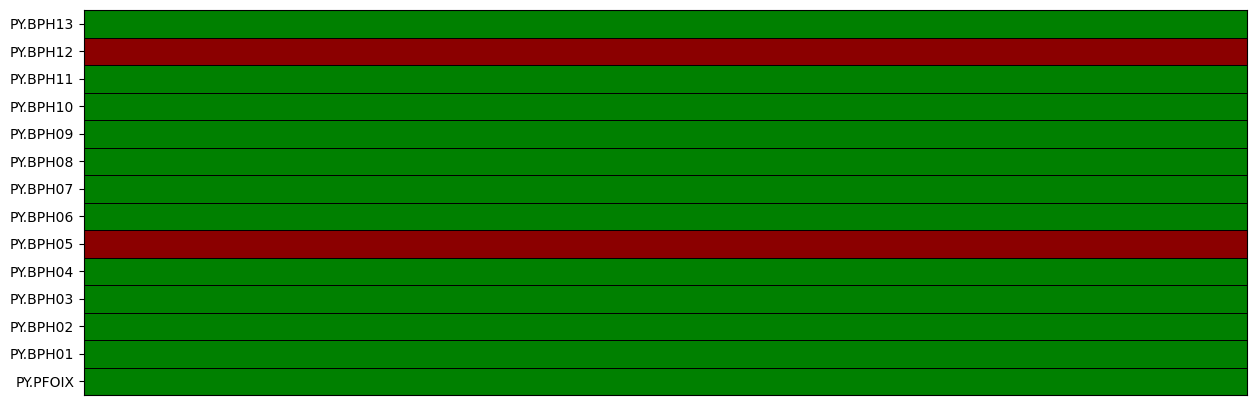


 -> Runtime: 0.73 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-02T20:36:27.220200Z - 2023-07-02T20:37:27.220200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-02T20:36:27.220200Z - 2023-07-02T20:37:27.220200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-02T20:36:27.220200Z - 2023-07-02T20:37:27.220200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-02T20:36:27.220000Z - 2023-07-02T20:37:27.220000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-02T20:36:27.220000Z - 2023-07-02T20:37:27.220000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-02T20:36:27.220000Z - 2023-07-02T20:37:27.220000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-02T20:36:27.220000Z - 2023-07-02T20:37:27.220000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-02T20:36:27.220000Z - 2023-07-02T20:37:27.220000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-02T20:36:27.220000Z - 2023-07-02T20:37:27.220000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-02T20:36:27.220000Z - 2023-07-02T20:37:


 -> 255 2023-07-07 16:02:29.240000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-07T16:02:14.239500Z - 2023-07-07T16:03:14.239500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-07T16:02:14.239500Z - 2023-07-07T16:03:14.239500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-07T16:02:14.239500Z - 2023-07-07T16:03:14.239500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-07T16:02:14.240000Z - 2023-07-07T16:03:14.240000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-07T16:02:14.240000Z - 2023-07-07T16:03:14.240000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-07T16:02:14.240000Z - 2023-07-07T16:03:14.240000Z | 200.0 Hz, 12001 samples
PY.RPFO.inn.BJE | 2023-07-07T16:02:14.240000Z - 2023-07-07T16:03:14.240000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJN | 2023-07-07T16:02:14.240000Z - 2023-07-07T16:03:14.240000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJZ | 2023-07-07T16:02:14.240000Z - 2023-07-07T16:03:14.240000Z | 40.0 Hz, 2401 samples
PY.RPFO.mid.BJE | 2023-07-07T16:02:14.240000Z - 2023-07-07T16:03:


 -> 256 2023-07-08 02:46:01.230000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


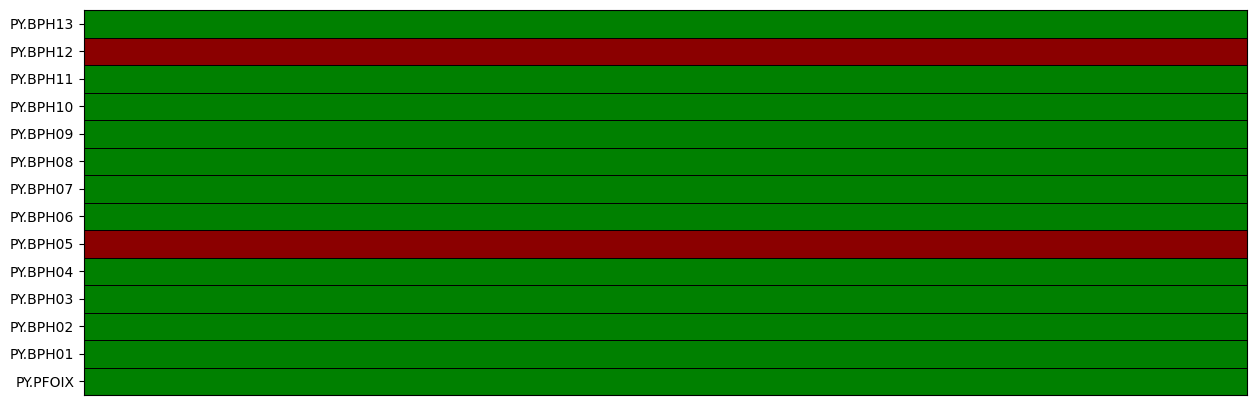


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-08T02:45:46.229500Z - 2023-07-08T02:46:46.229500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-08T02:45:46.229500Z - 2023-07-08T02:46:46.229500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-08T02:45:46.229500Z - 2023-07-08T02:46:46.229500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-08T02:45:46.230000Z - 2023-07-08T02:46:46.230000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-08T02:45:46.230000Z - 2023-07-08T02:46:46.230000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-08T02:45:46.230000Z - 2023-07-08T02:46:46.230000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-08T02:45:46.230000Z - 2023-07-08T02:46:46.230000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-08T02:45:46.230000Z - 2023-07-08T02:46:46.230000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-08T02:45:46.230000Z - 2023-07-08T02:46:46.230000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-08T02:45:46.230000Z - 2023-07-08T02:46:


 -> 257 2023-07-10 20:53:23.380000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


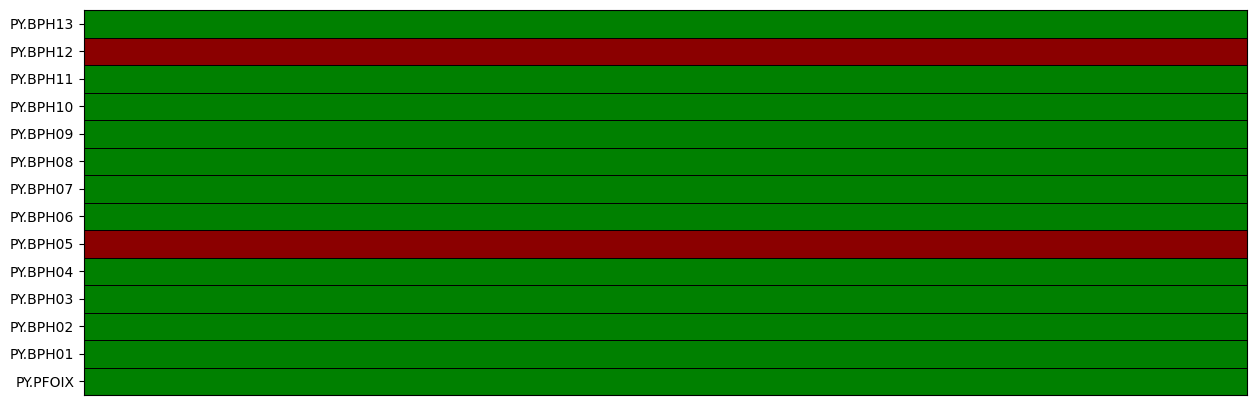


 -> Runtime: 0.67 minutes
 -> BPH02 Failed to load inventory!
 -> BPH02 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 7 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-10T20:53:08.378900Z - 2023-07-10T20:54:08.378900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-10T20:53:08.378900Z - 2023-07-10T20:54:08.378900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-10T20:53:08.378900Z - 2023-07-10T20:54:08.378900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-10T20:53:08.380000Z - 2023-07-10T20:54:08.380000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-10T20:53:08.380000Z - 2023-07-10T20:54:08.380000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-10T20:53:08.380000Z - 2023-07-10T20:54:08.380000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-10T20:53:08.380000Z - 2023-07-10T20:54:08.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-10T20:53:08.380000Z - 2023-07-10T20:54:08.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-10T20:53:08.380000Z - 2023-07-10T20:54:08.380000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-10T20:53:08.380000Z - 2023-07-10T20:54:


 -> 258 2023-07-10 20:58:44.090000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


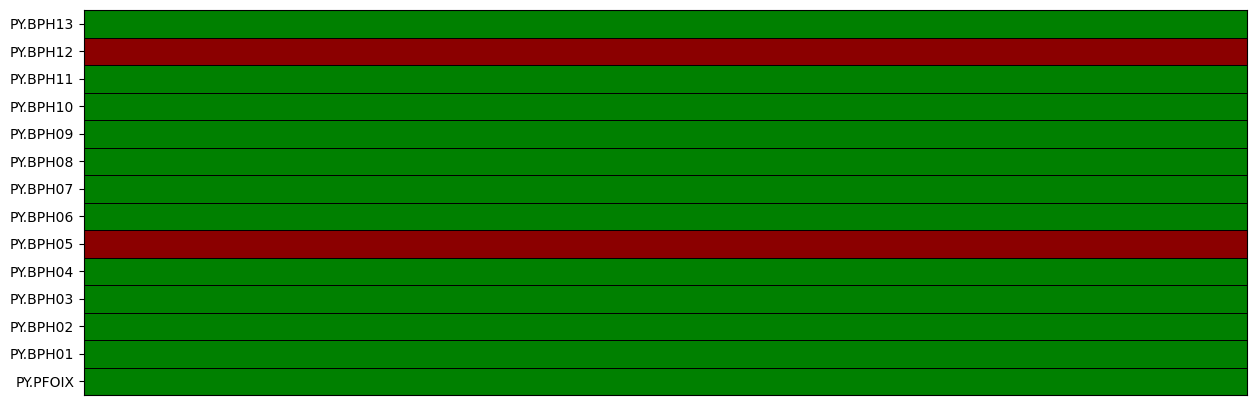


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH08 Failed to load inventory!
 -> BPH08 failed to rotate to ZNE
 -> continue computing ADR for 7 of 9 stations ...
 -> failed to compute ADR mid ...
 -> PFOIX Failed to load inventory!
 -> failed to compute ADR inner ...


9 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-10T20:58:29.088900Z - 2023-07-10T20:59:29.088900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-10T20:58:29.088900Z - 2023-07-10T20:59:29.088900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-10T20:58:29.088900Z - 2023-07-10T20:59:29.088900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-10T20:58:29.090000Z - 2023-07-10T20:59:29.090000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-10T20:58:29.090000Z - 2023-07-10T20:59:29.090000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-10T20:58:29.090000Z - 2023-07-10T20:59:29.090000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-10T20:58:29.090000Z - 2023-07-10T20:59:29.090000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-10T20:58:29.090000Z - 2023-07-10T20:59:29.090000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-10T20:58:29.090000Z - 2023-07-10T20:59:29.090000Z | 40.0 Hz, 2401 samples


 -> 259 2023-07-12 02:29:04.940000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


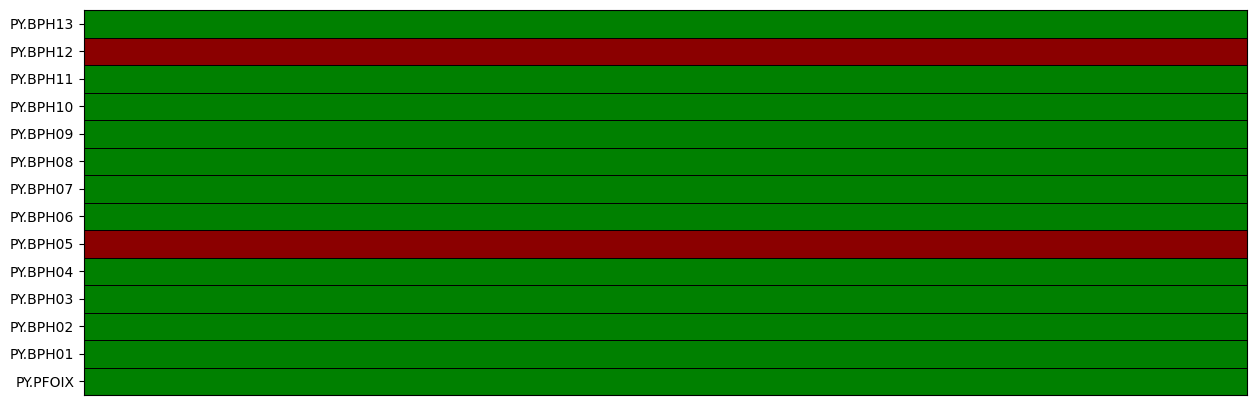


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-12T02:28:49.939100Z - 2023-07-12T02:29:49.939100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-12T02:28:49.939100Z - 2023-07-12T02:29:49.939100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-12T02:28:49.939100Z - 2023-07-12T02:29:49.939100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-12T02:28:49.940000Z - 2023-07-12T02:29:49.940000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-12T02:28:49.940000Z - 2023-07-12T02:29:49.940000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-12T02:28:49.940000Z - 2023-07-12T02:29:49.940000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-12T02:28:49.940000Z - 2023-07-12T02:29:49.940000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-12T02:28:49.940000Z - 2023-07-12T02:29:49.940000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-12T02:28:49.940000Z - 2023-07-12T02:29:49.940000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-12T02:28:49.940000Z - 2023-07-12T02:29:


 -> 260 2023-07-13 02:32:21.950000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


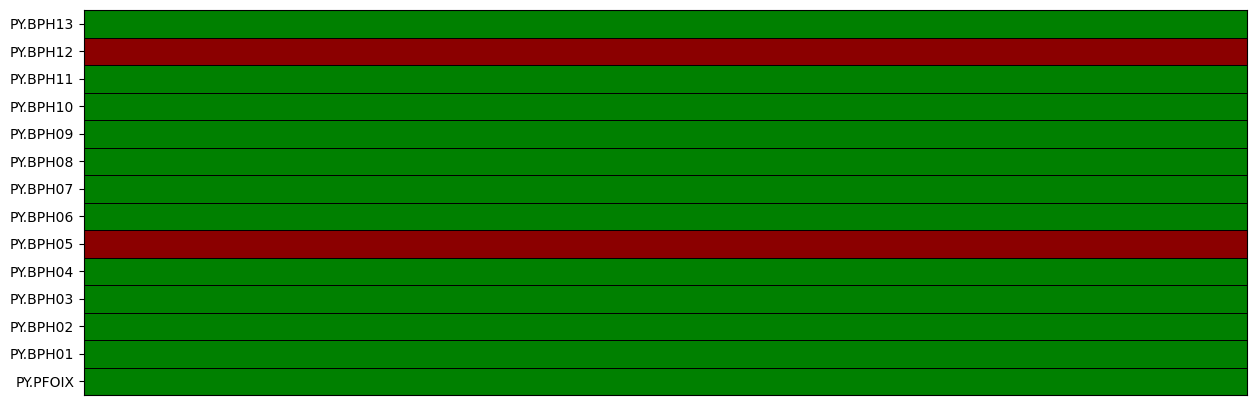


 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.48 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-13T02:32:06.949500Z - 2023-07-13T02:33:06.949500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-13T02:32:06.949500Z - 2023-07-13T02:33:06.949500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-13T02:32:06.949500Z - 2023-07-13T02:33:06.949500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-13T02:32:06.950000Z - 2023-07-13T02:33:06.950000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-13T02:32:06.950000Z - 2023-07-13T02:33:06.950000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-13T02:32:06.950000Z - 2023-07-13T02:33:06.950000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-13T02:32:06.950000Z - 2023-07-13T02:33:06.950000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-13T02:32:06.950000Z - 2023-07-13T02:33:06.950000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-13T02:32:06.950000Z - 2023-07-13T02:33:06.950000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-13T02:32:06.950000Z - 2023-07-13T02:33:


 -> 261 2023-07-13 08:50:44.680000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


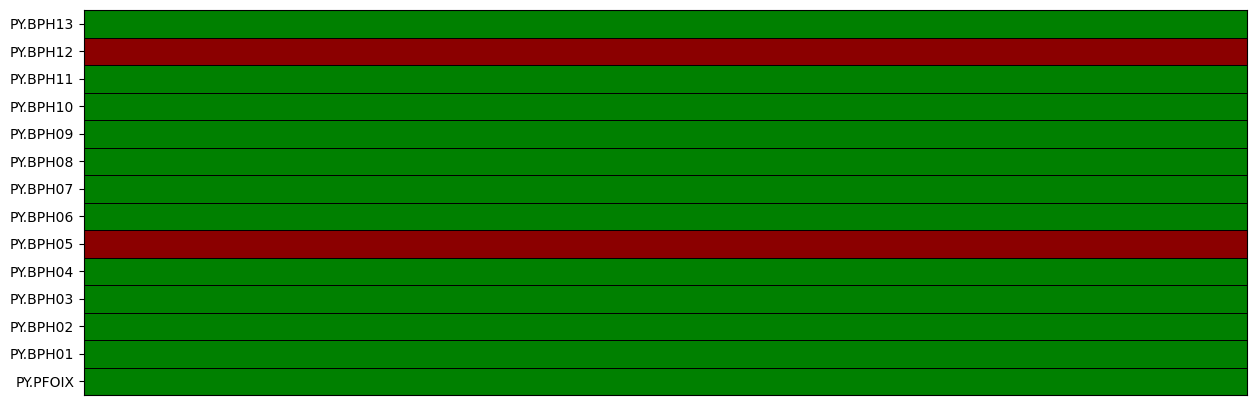


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-13T08:50:29.679300Z - 2023-07-13T08:51:29.679300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-13T08:50:29.679300Z - 2023-07-13T08:51:29.679300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-13T08:50:29.679300Z - 2023-07-13T08:51:29.679300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-13T08:50:29.680000Z - 2023-07-13T08:51:29.680000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-13T08:50:29.680000Z - 2023-07-13T08:51:29.680000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-13T08:50:29.680000Z - 2023-07-13T08:51:29.680000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-13T08:50:29.680000Z - 2023-07-13T08:51:29.680000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-13T08:50:29.680000Z - 2023-07-13T08:51:29.680000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-13T08:50:29.680000Z - 2023-07-13T08:51:29.680000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-13T08:50:29.680000Z - 2023-07-13T08:51:


 -> 262 2023-07-13 11:20:28.110000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


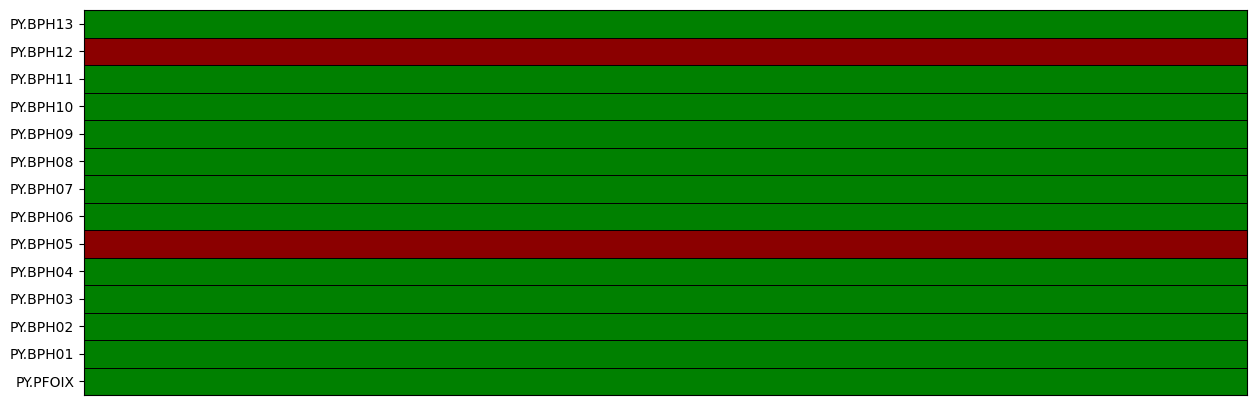


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-13T11:20:13.109300Z - 2023-07-13T11:21:13.109300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-13T11:20:13.109300Z - 2023-07-13T11:21:13.109300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-13T11:20:13.109300Z - 2023-07-13T11:21:13.109300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-13T11:20:13.110000Z - 2023-07-13T11:21:13.110000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-13T11:20:13.110000Z - 2023-07-13T11:21:13.110000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-13T11:20:13.110000Z - 2023-07-13T11:21:13.110000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-13T11:20:13.110000Z - 2023-07-13T11:21:13.110000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-13T11:20:13.110000Z - 2023-07-13T11:21:13.110000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-13T11:20:13.110000Z - 2023-07-13T11:21:13.110000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-13T11:20:13.110000Z - 2023-07-13T11:21:


 -> 263 2023-07-14 16:57:21.190000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


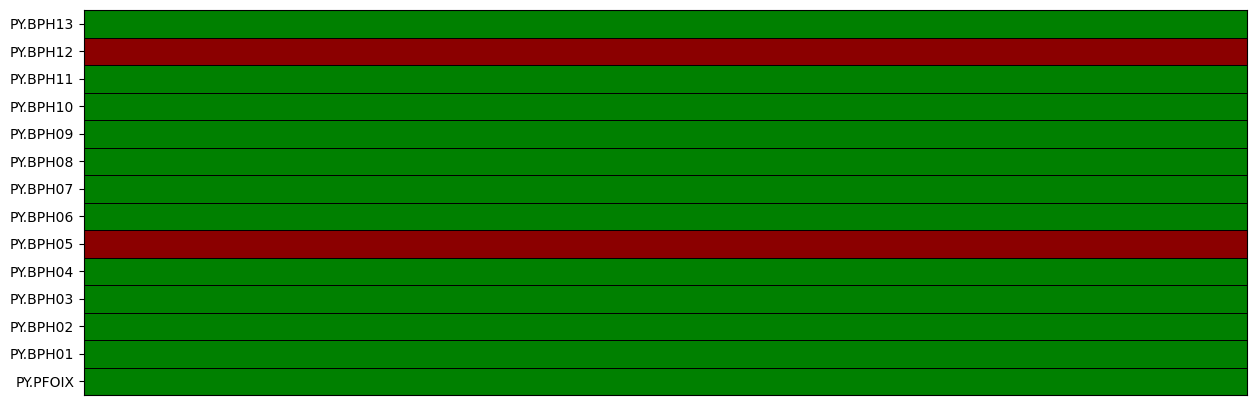


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-14T16:57:06.189200Z - 2023-07-14T16:58:06.189200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-14T16:57:06.189200Z - 2023-07-14T16:58:06.189200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-14T16:57:06.189200Z - 2023-07-14T16:58:06.189200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-14T16:57:06.190000Z - 2023-07-14T16:58:06.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-14T16:57:06.190000Z - 2023-07-14T16:58:06.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-14T16:57:06.190000Z - 2023-07-14T16:58:06.190000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-14T16:57:06.190000Z - 2023-07-14T16:58:06.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-14T16:57:06.190000Z - 2023-07-14T16:58:06.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-14T16:57:06.190000Z - 2023-07-14T16:58:06.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-14T16:57:06.190000Z - 2023-07-14T16:58:


 -> 264 2023-07-17 00:46:03.190000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


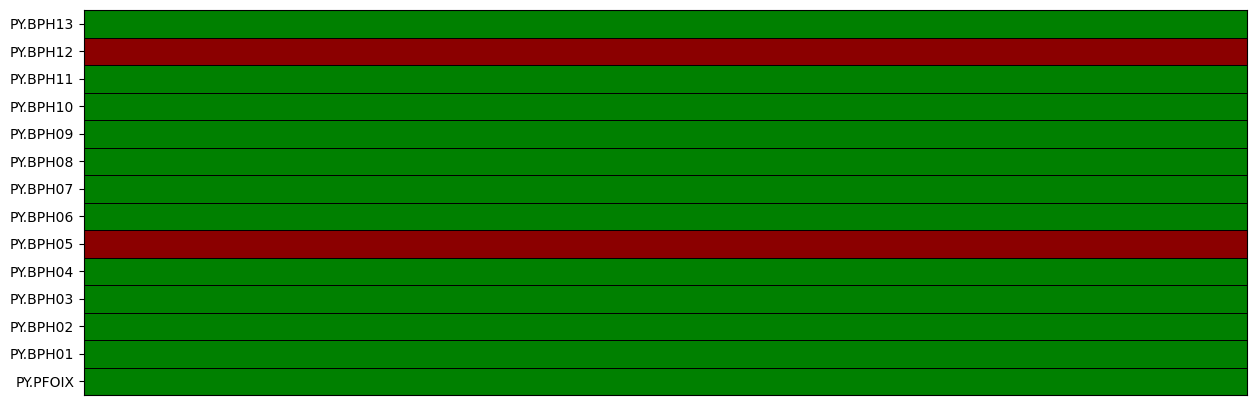


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-17T00:45:48.189200Z - 2023-07-17T00:46:48.189200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-17T00:45:48.189200Z - 2023-07-17T00:46:48.189200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-17T00:45:48.189200Z - 2023-07-17T00:46:48.189200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-17T00:45:48.190000Z - 2023-07-17T00:46:48.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-17T00:45:48.190000Z - 2023-07-17T00:46:48.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-17T00:45:48.190000Z - 2023-07-17T00:46:48.190000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-17T00:45:48.190000Z - 2023-07-17T00:46:48.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-17T00:45:48.190000Z - 2023-07-17T00:46:48.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-17T00:45:48.190000Z - 2023-07-17T00:46:48.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-17T00:45:48.190000Z - 2023-07-17T00:46:


 -> 265 2023-07-18 01:13:30.270000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


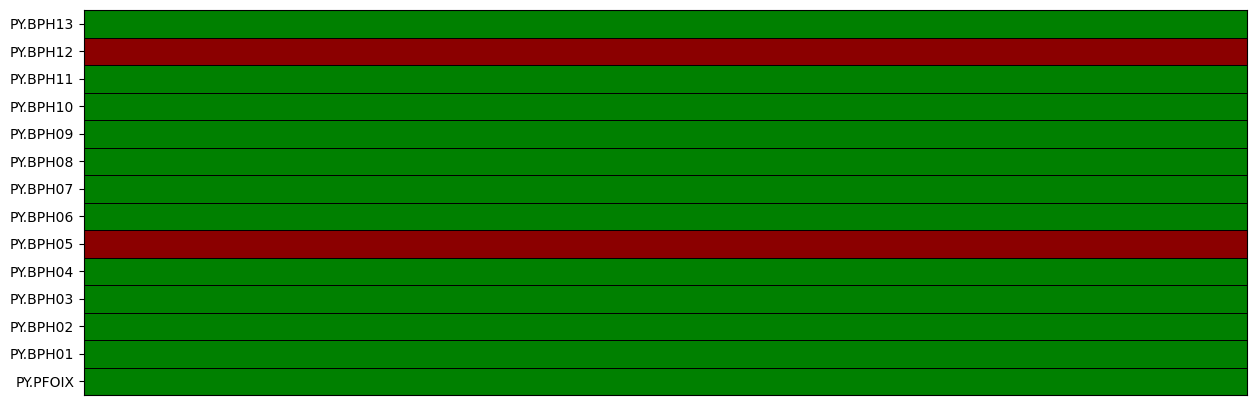


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-18T01:13:15.269100Z - 2023-07-18T01:14:15.269100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-18T01:13:15.269100Z - 2023-07-18T01:14:15.269100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-18T01:13:15.269100Z - 2023-07-18T01:14:15.269100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-18T01:13:15.270000Z - 2023-07-18T01:14:15.270000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-18T01:13:15.270000Z - 2023-07-18T01:14:15.270000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-18T01:13:15.270000Z - 2023-07-18T01:14:15.270000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-18T01:13:15.270000Z - 2023-07-18T01:14:15.270000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-18T01:13:15.270000Z - 2023-07-18T01:14:15.270000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-18T01:13:15.270000Z - 2023-07-18T01:14:15.270000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-18T01:13:15.270000Z - 2023-07-18T01:14:


 -> 266 2023-07-18 05:32:11.840000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


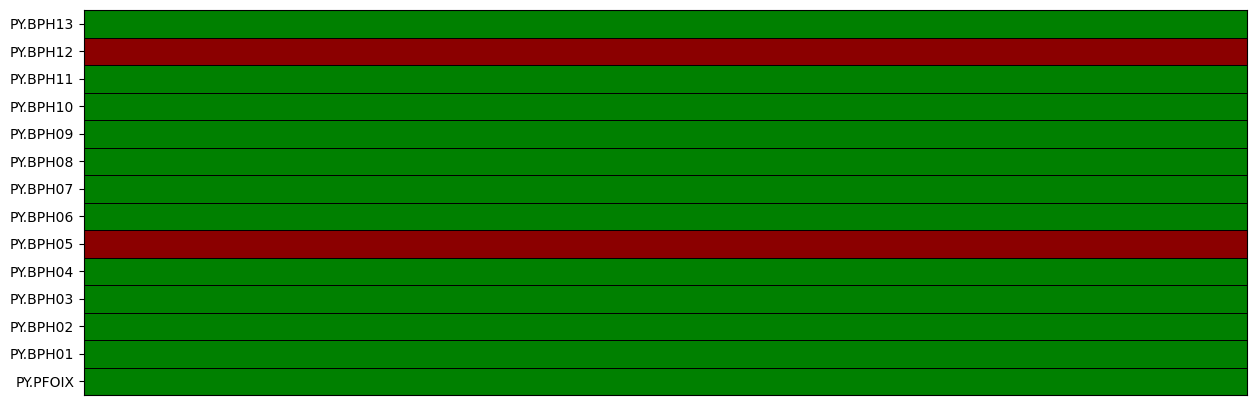


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-18T05:31:56.839000Z - 2023-07-18T05:32:56.839000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-18T05:31:56.839100Z - 2023-07-18T05:32:56.839100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-18T05:31:56.839100Z - 2023-07-18T05:32:56.839100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-18T05:31:56.840000Z - 2023-07-18T05:32:56.840000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-18T05:31:56.840000Z - 2023-07-18T05:32:56.840000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-18T05:31:56.840000Z - 2023-07-18T05:32:56.840000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-18T05:31:56.840000Z - 2023-07-18T05:32:56.840000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-18T05:31:56.840000Z - 2023-07-18T05:32:56.840000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-18T05:31:56.840000Z - 2023-07-18T05:32:56.840000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-18T05:31:56.840000Z - 2023-07-18T05:32:


 -> 267 2023-07-19 21:26:40.610000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


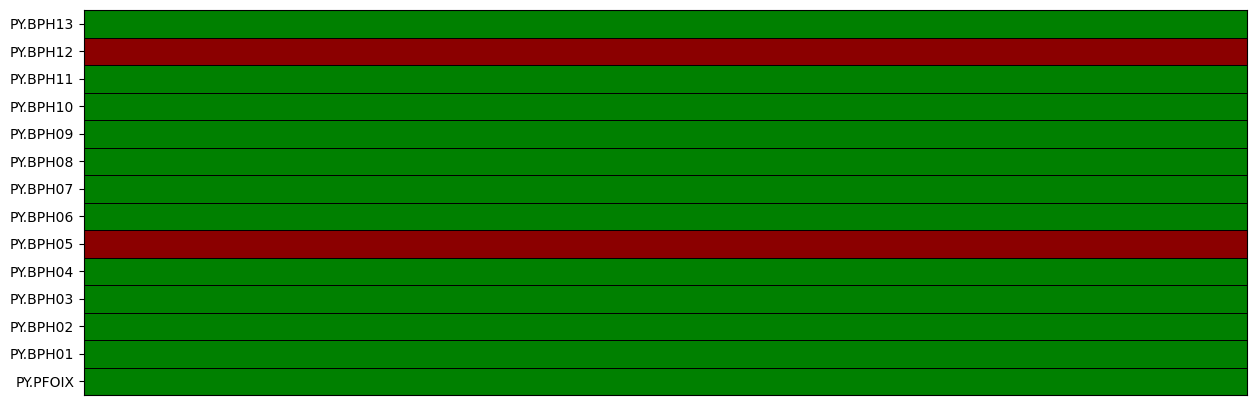


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-19T21:26:25.609100Z - 2023-07-19T21:27:25.609100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-19T21:26:25.609100Z - 2023-07-19T21:27:25.609100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-19T21:26:25.609100Z - 2023-07-19T21:27:25.609100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-19T21:26:25.610000Z - 2023-07-19T21:27:25.610000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-19T21:26:25.610000Z - 2023-07-19T21:27:25.610000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-19T21:26:25.610000Z - 2023-07-19T21:27:25.610000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-19T21:26:25.610000Z - 2023-07-19T21:27:25.610000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-19T21:26:25.610000Z - 2023-07-19T21:27:25.610000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-19T21:26:25.610000Z - 2023-07-19T21:27:25.610000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-19T21:26:25.610000Z - 2023-07-19T21:27:


 -> 268 2023-07-19 23:27:49.640000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


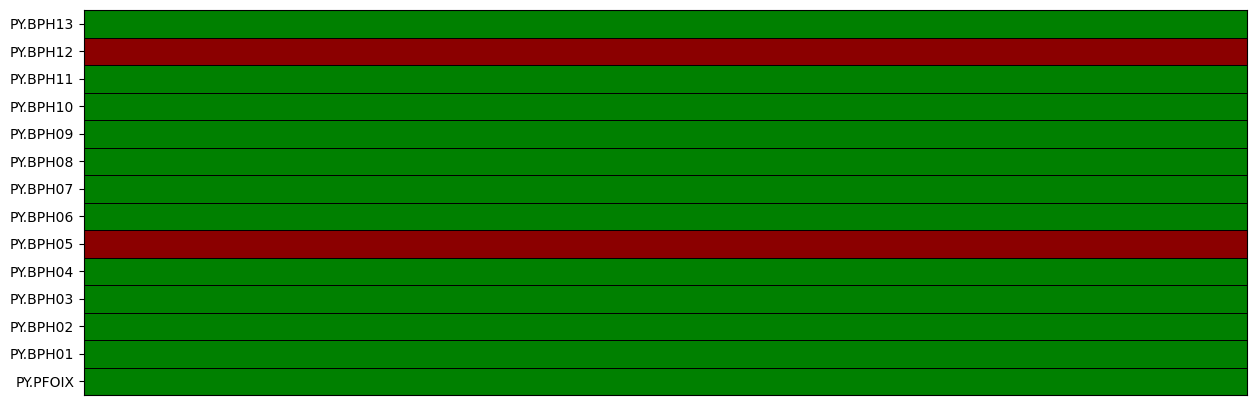


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-19T23:27:34.639100Z - 2023-07-19T23:28:34.639100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-19T23:27:34.639100Z - 2023-07-19T23:28:34.639100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-19T23:27:34.639100Z - 2023-07-19T23:28:34.639100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-19T23:27:34.640000Z - 2023-07-19T23:28:34.640000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-19T23:27:34.640000Z - 2023-07-19T23:28:34.640000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-19T23:27:34.640000Z - 2023-07-19T23:28:34.640000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-19T23:27:34.640000Z - 2023-07-19T23:28:34.640000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-19T23:27:34.640000Z - 2023-07-19T23:28:34.640000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-19T23:27:34.640000Z - 2023-07-19T23:28:34.640000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-19T23:27:34.640000Z - 2023-07-19T23:28:


 -> 269 2023-07-20 04:53:51.990000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


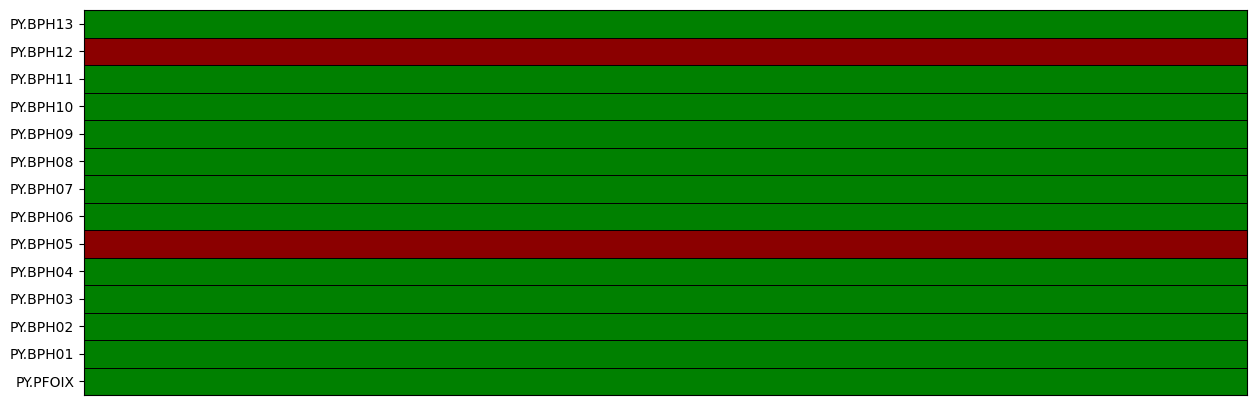


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-20T04:53:36.989100Z - 2023-07-20T04:54:36.989100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-20T04:53:36.989100Z - 2023-07-20T04:54:36.989100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-20T04:53:36.989100Z - 2023-07-20T04:54:36.989100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-20T04:53:36.990000Z - 2023-07-20T04:54:36.990000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-20T04:53:36.990000Z - 2023-07-20T04:54:36.990000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-20T04:53:36.990000Z - 2023-07-20T04:54:36.990000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-20T04:53:36.990000Z - 2023-07-20T04:54:36.990000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-20T04:53:36.990000Z - 2023-07-20T04:54:36.990000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-20T04:53:36.990000Z - 2023-07-20T04:54:36.990000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-20T04:53:36.990000Z - 2023-07-20T04:54:


 -> 270 2023-07-20 16:01:17.830000 
 -> sensitivity removed!
 -> response removed!
 -> BPH03 Failed to load inventory!
 -> BPH03 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


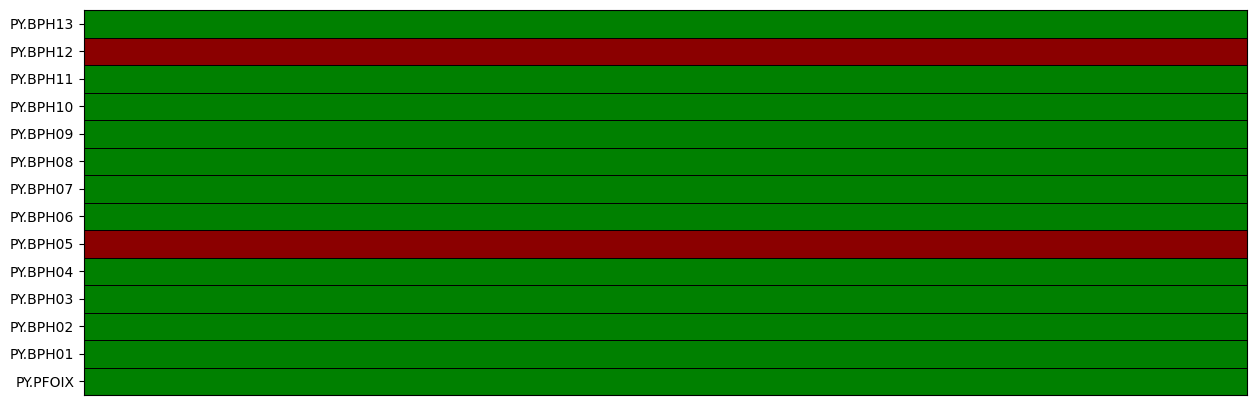


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-20T16:01:02.829400Z - 2023-07-20T16:02:02.829400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-20T16:01:02.829400Z - 2023-07-20T16:02:02.829400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-20T16:01:02.829400Z - 2023-07-20T16:02:02.829400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-20T16:01:02.830000Z - 2023-07-20T16:02:02.830000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-20T16:01:02.830000Z - 2023-07-20T16:02:02.830000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-20T16:01:02.830000Z - 2023-07-20T16:02:02.830000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-20T16:01:02.830000Z - 2023-07-20T16:02:02.830000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-20T16:01:02.830000Z - 2023-07-20T16:02:02.830000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-20T16:01:02.830000Z - 2023-07-20T16:02:02.830000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-20T16:01:02.830000Z - 2023-07-20T16:02:


 -> 271 2023-07-22 12:52:57.190000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


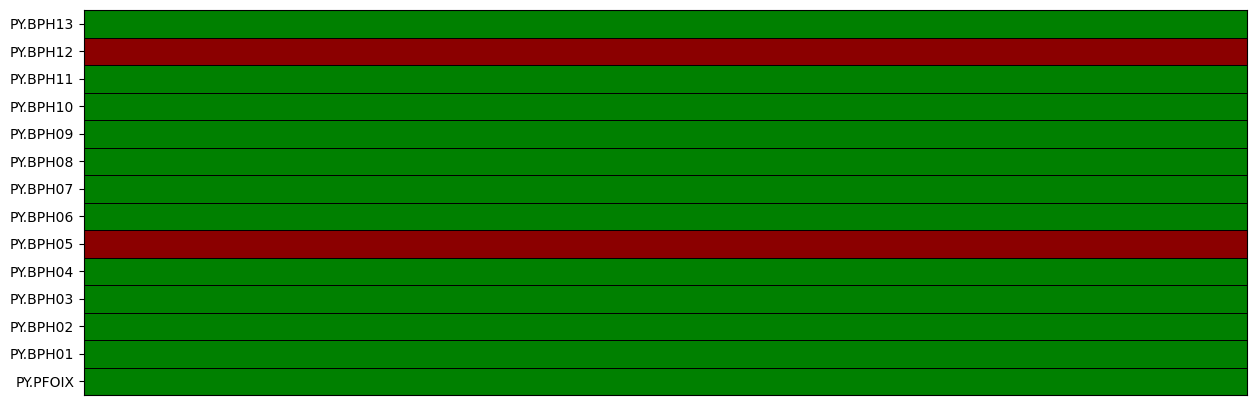


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.25 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-22T12:52:42.191500Z - 2023-07-22T12:53:42.191500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-22T12:52:42.191500Z - 2023-07-22T12:53:42.191500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-22T12:52:42.191600Z - 2023-07-22T12:53:42.191600Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-22T12:52:42.190000Z - 2023-07-22T12:53:42.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-22T12:52:42.190000Z - 2023-07-22T12:53:42.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-22T12:52:42.190000Z - 2023-07-22T12:53:42.190000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-22T12:52:42.190000Z - 2023-07-22T12:53:42.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-22T12:52:42.190000Z - 2023-07-22T12:53:42.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-22T12:52:42.190000Z - 2023-07-22T12:53:42.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-22T12:52:42.190000Z - 2023-07-22T12:53:


 -> 272 2023-07-24 18:18:36.100000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


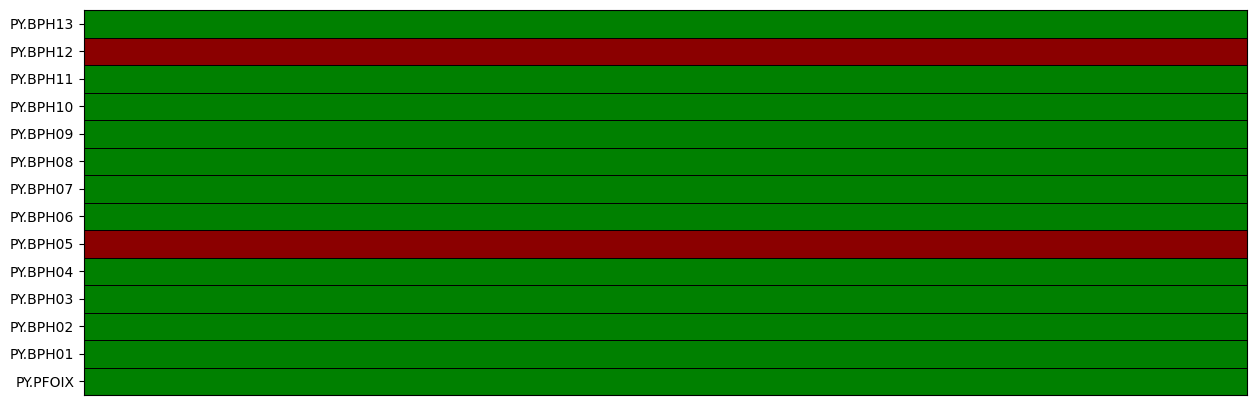


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-24T18:18:21.101700Z - 2023-07-24T18:19:21.101700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-24T18:18:21.101700Z - 2023-07-24T18:19:21.101700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-24T18:18:21.101700Z - 2023-07-24T18:19:21.101700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-24T18:18:21.100000Z - 2023-07-24T18:19:21.100000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-24T18:18:21.100000Z - 2023-07-24T18:19:21.100000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-24T18:18:21.100000Z - 2023-07-24T18:19:21.100000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-24T18:18:21.100000Z - 2023-07-24T18:19:21.100000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-24T18:18:21.100000Z - 2023-07-24T18:19:21.100000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-24T18:18:21.100000Z - 2023-07-24T18:19:21.100000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-24T18:18:21.100000Z - 2023-07-24T18:19:


 -> 273 2023-07-24 20:38:39.070000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


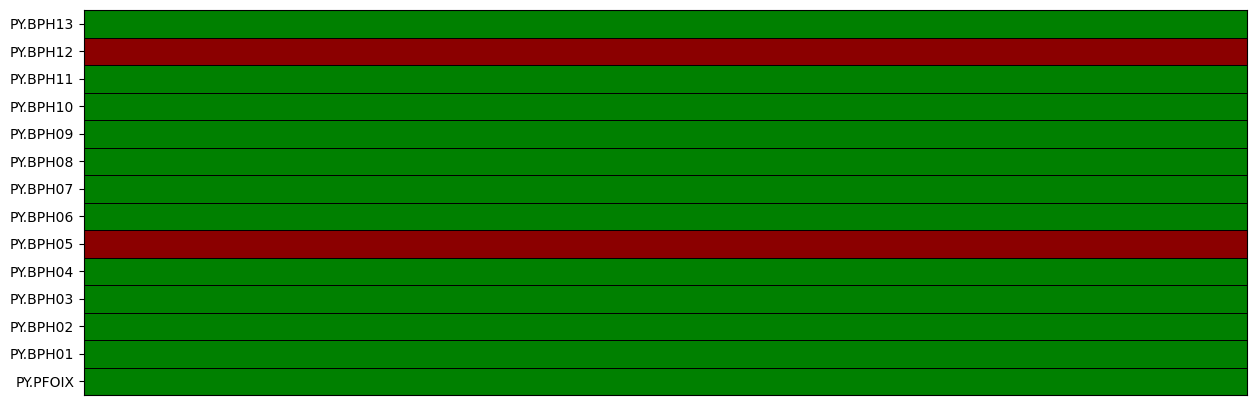


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-24T20:38:24.071700Z - 2023-07-24T20:39:24.071700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-24T20:38:24.071700Z - 2023-07-24T20:39:24.071700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-24T20:38:24.071700Z - 2023-07-24T20:39:24.071700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-24T20:38:24.070000Z - 2023-07-24T20:39:24.070000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-24T20:38:24.070000Z - 2023-07-24T20:39:24.070000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-24T20:38:24.070000Z - 2023-07-24T20:39:24.070000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-24T20:38:24.070000Z - 2023-07-24T20:39:24.070000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-24T20:38:24.070000Z - 2023-07-24T20:39:24.070000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-24T20:38:24.070000Z - 2023-07-24T20:39:24.070000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-24T20:38:24.070000Z - 2023-07-24T20:39:


 -> 274 2023-07-26 06:46:43.820000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


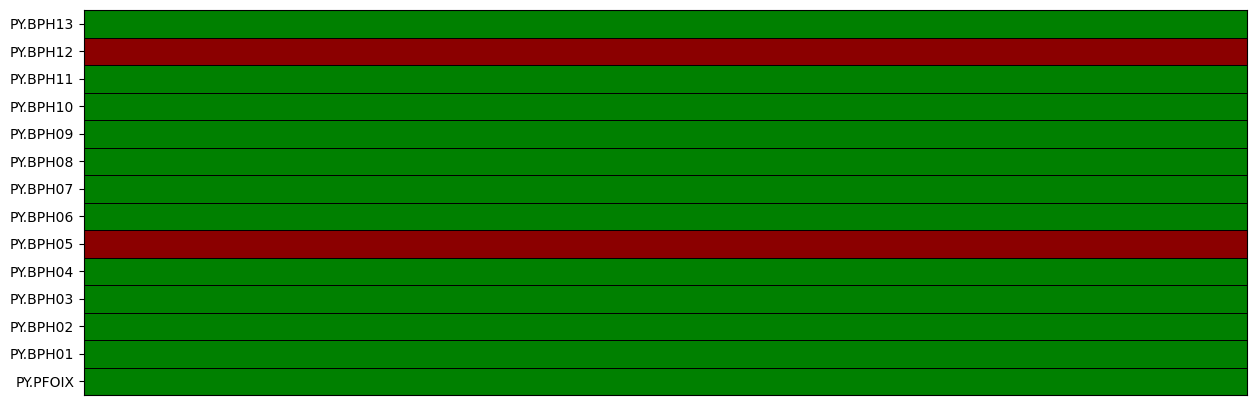


 -> Runtime: 0.7 minutes
 -> BPH03 Failed to load inventory!
 -> BPH03 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 7 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> BPH01 Failed to load inventory!
 -> BPH01 failed to rotate to ZNE
 -> continue computing ADR for 4 of 5 stations ...
 -> failed to compute ADR inner ...


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-26T06:46:28.821500Z - 2023-07-26T06:47:28.821500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-26T06:46:28.821500Z - 2023-07-26T06:47:28.821500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-26T06:46:28.821500Z - 2023-07-26T06:47:28.821500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-26T06:46:28.820000Z - 2023-07-26T06:47:28.820000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-26T06:46:28.820000Z - 2023-07-26T06:47:28.820000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-26T06:46:28.820000Z - 2023-07-26T06:47:28.820000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-26T06:46:28.820000Z - 2023-07-26T06:47:28.820000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-26T06:46:28.820000Z - 2023-07-26T06:47:28.820000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-26T06:46:28.820000Z - 2023-07-26T06:47:28.820000Z | 40.0 Hz, 2401 samples
PY.RPFO.mid.BJE | 2023-07-26T06:46:28.820000Z - 2023-07-26T06:47:


 -> 275 2023-07-28 19:12:37.360000 
 -> sensitivity removed!
 -> response removed!
 -> BPH03 Failed to load inventory!
 -> BPH03 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


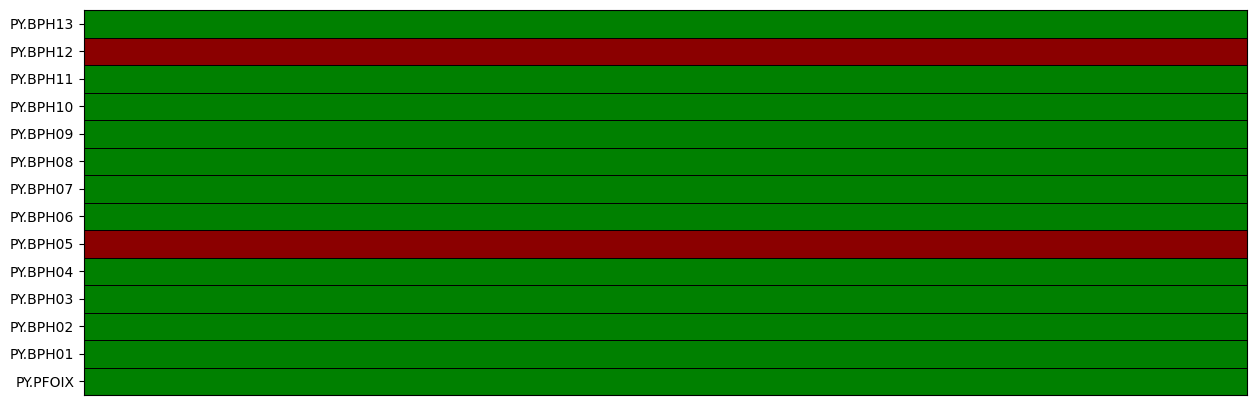


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-28T19:12:22.361500Z - 2023-07-28T19:13:22.361500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-28T19:12:22.361500Z - 2023-07-28T19:13:22.361500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-28T19:12:22.361500Z - 2023-07-28T19:13:22.361500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-28T19:12:22.360000Z - 2023-07-28T19:13:22.360000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-28T19:12:22.360000Z - 2023-07-28T19:13:22.360000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-28T19:12:22.360000Z - 2023-07-28T19:13:22.360000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-28T19:12:22.360000Z - 2023-07-28T19:13:22.360000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-28T19:12:22.360000Z - 2023-07-28T19:13:22.360000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-28T19:12:22.360000Z - 2023-07-28T19:13:22.360000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-28T19:12:22.360000Z - 2023-07-28T19:13:


 -> 276 2023-07-28 21:58:47.830000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


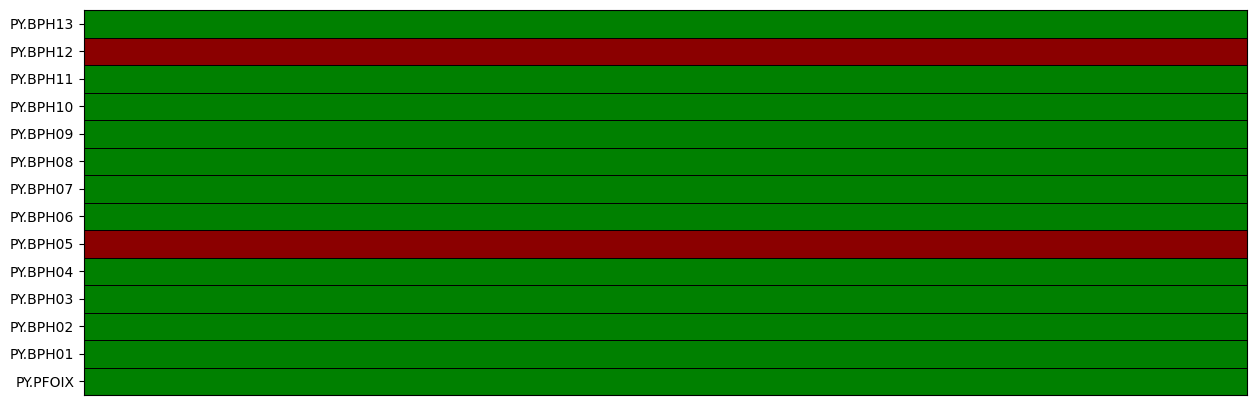


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-07-28T21:58:32.831500Z - 2023-07-28T21:59:32.831500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-07-28T21:58:32.831500Z - 2023-07-28T21:59:32.831500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-07-28T21:58:32.831500Z - 2023-07-28T21:59:32.831500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-07-28T21:58:32.830000Z - 2023-07-28T21:59:32.830000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-07-28T21:58:32.830000Z - 2023-07-28T21:59:32.830000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-07-28T21:58:32.830000Z - 2023-07-28T21:59:32.830000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-07-28T21:58:32.830000Z - 2023-07-28T21:59:32.830000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-07-28T21:58:32.830000Z - 2023-07-28T21:59:32.830000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-07-28T21:58:32.830000Z - 2023-07-28T21:59:32.830000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-07-28T21:58:32.830000Z - 2023-07-28T21:59:


 -> 277 2023-08-01 13:04:08.700000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


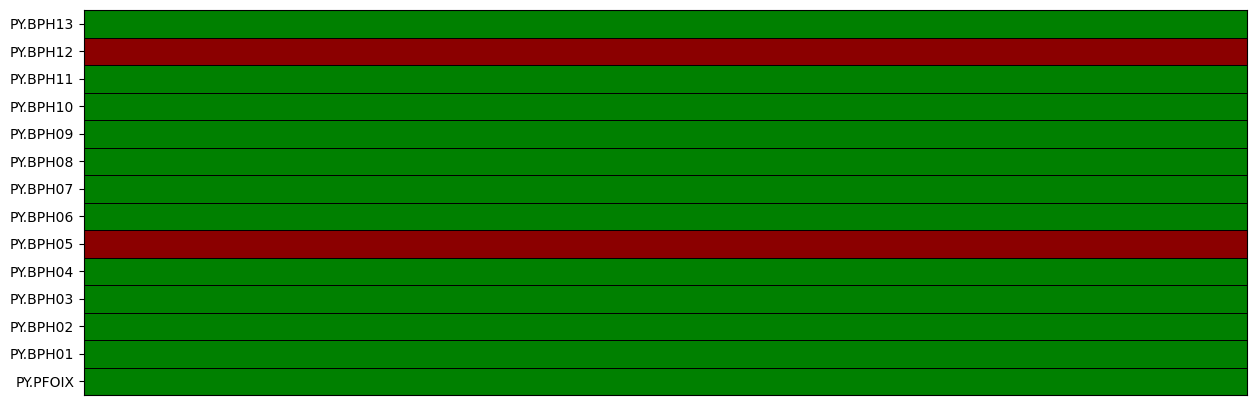


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-01T13:03:53.700300Z - 2023-08-01T13:04:53.700300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-01T13:03:53.700300Z - 2023-08-01T13:04:53.700300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-01T13:03:53.700300Z - 2023-08-01T13:04:53.700300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-01T13:03:53.700000Z - 2023-08-01T13:04:53.700000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-01T13:03:53.700000Z - 2023-08-01T13:04:53.700000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-01T13:03:53.700000Z - 2023-08-01T13:04:53.700000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-01T13:03:53.700000Z - 2023-08-01T13:04:53.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-01T13:03:53.700000Z - 2023-08-01T13:04:53.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-01T13:03:53.700000Z - 2023-08-01T13:04:53.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-01T13:03:53.700000Z - 2023-08-01T13:04:


 -> 278 2023-08-07 08:39:25.700000 
 -> Failed to load inventory!
 -> sensitivity removed!
 -> failed to rotate to ZNE
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


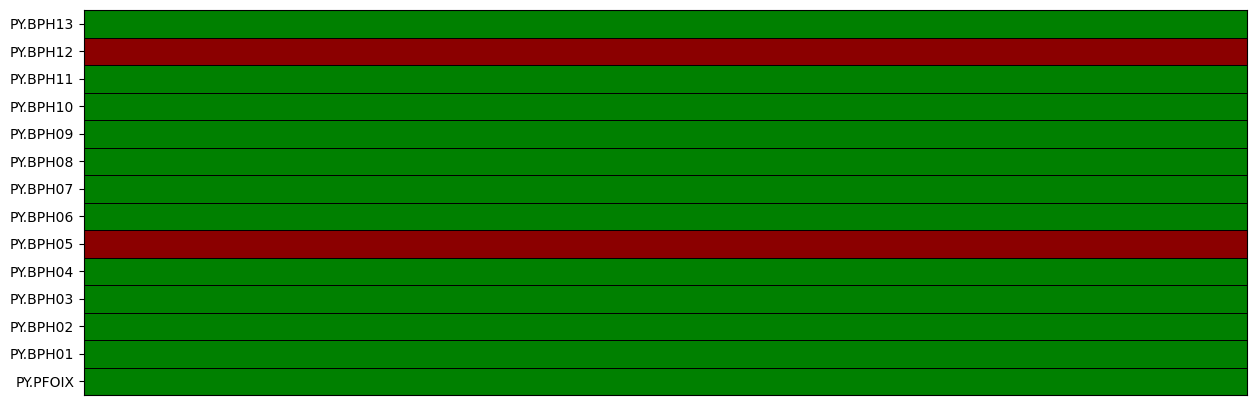


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


12 Trace(s) in Stream:
PY.BSPF..HJ1    | 2023-08-07T08:39:10.700300Z - 2023-08-07T08:40:10.700300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJ2    | 2023-08-07T08:39:10.700300Z - 2023-08-07T08:40:10.700300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJ3    | 2023-08-07T08:39:10.700300Z - 2023-08-07T08:40:10.700300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-07T08:39:10.700000Z - 2023-08-07T08:40:10.700000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-07T08:39:10.700000Z - 2023-08-07T08:40:10.700000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-07T08:39:10.700000Z - 2023-08-07T08:40:10.700000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-07T08:39:10.700000Z - 2023-08-07T08:40:10.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-07T08:39:10.700000Z - 2023-08-07T08:40:10.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-07T08:39:10.700000Z - 2023-08-07T08:40:10.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-07T08:39:10.700000Z - 2023-08-07T08:40:


 -> 279 2023-08-10 05:55:53.790000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


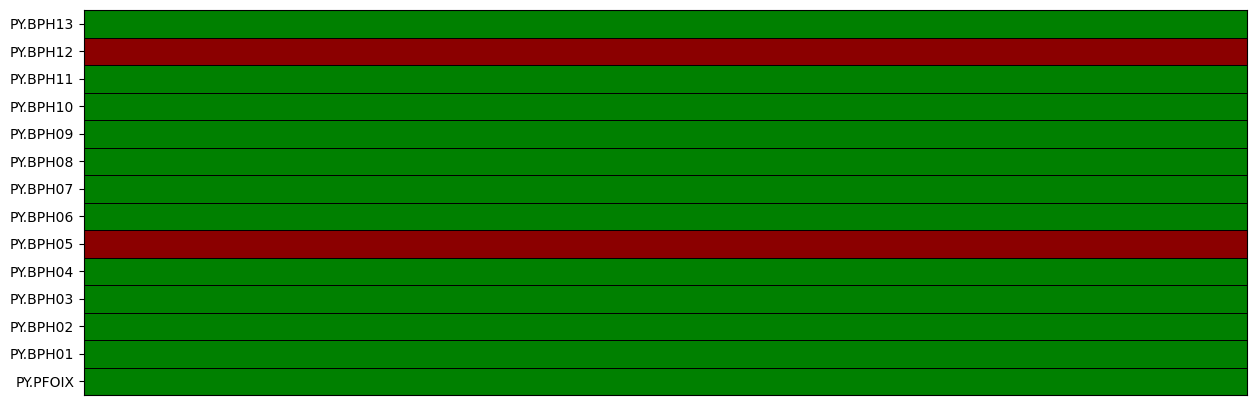


 -> Runtime: 0.69 minutes
 -> BPH05 Failed to load inventory!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH08 Failed to load inventory!
 -> failed to compute ADR mid ...
 -> PFOIX Failed to load inventory!
 -> failed to compute ADR inner ...


9 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-10T05:55:38.790500Z - 2023-08-10T05:56:38.790500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-10T05:55:38.790500Z - 2023-08-10T05:56:38.790500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-10T05:55:38.790500Z - 2023-08-10T05:56:38.790500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-10T05:55:38.790000Z - 2023-08-10T05:56:38.790000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-10T05:55:38.790000Z - 2023-08-10T05:56:38.790000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-10T05:55:38.790000Z - 2023-08-10T05:56:38.790000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-10T05:55:38.790000Z - 2023-08-10T05:56:38.790000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-10T05:55:38.790000Z - 2023-08-10T05:56:38.790000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-10T05:55:38.790000Z - 2023-08-10T05:56:38.790000Z | 40.0 Hz, 2401 samples


 -> 280 2023-08-12 04:17:17.920000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH09 Failed to load inventory!
 -> BPH09 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...
 -> failed to compute ADR all ...
 -> BPH04 Failed to load inventory!
 -> BPH04 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 7 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-12T04:17:02.918500Z - 2023-08-12T04:18:02.918500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-12T04:17:02.918500Z - 2023-08-12T04:18:02.918500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-12T04:17:02.918600Z - 2023-08-12T04:18:02.918600Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-12T04:17:02.920000Z - 2023-08-12T04:18:02.920000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-12T04:17:02.920000Z - 2023-08-12T04:18:02.920000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-12T04:17:02.920000Z - 2023-08-12T04:18:02.920000Z | 200.0 Hz, 12001 samples
PY.RPFO.inn.BJE | 2023-08-12T04:17:02.920000Z - 2023-08-12T04:18:02.920000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJN | 2023-08-12T04:17:02.920000Z - 2023-08-12T04:18:02.920000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJZ | 2023-08-12T04:17:02.920000Z - 2023-08-12T04:18:02.920000Z | 40.0 Hz, 2401 samples
PY.RPFO.mid.BJE | 2023-08-12T04:17:02.920000Z - 2023-08-12T04:18:


 -> 281 2023-08-12 04:18:31.540000 
 -> sensitivity removed!
 -> response removed!
 -> BPH04 Failed to load inventory!
 -> BPH04 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


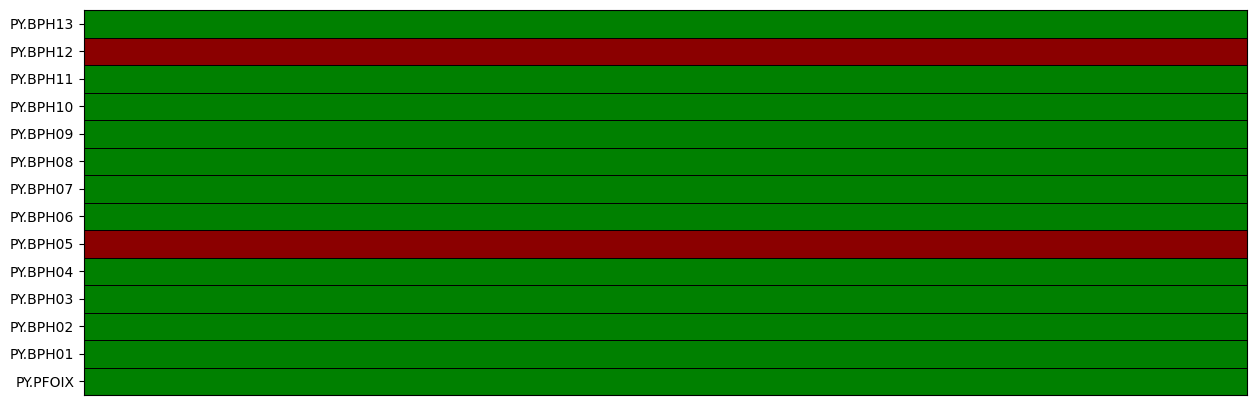


 -> Runtime: 0.64 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.47 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-12T04:18:16.538600Z - 2023-08-12T04:19:16.538600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-12T04:18:16.538600Z - 2023-08-12T04:19:16.538600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-12T04:18:16.538600Z - 2023-08-12T04:19:16.538600Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-12T04:18:16.540000Z - 2023-08-12T04:19:16.540000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-12T04:18:16.540000Z - 2023-08-12T04:19:16.540000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-12T04:18:16.540000Z - 2023-08-12T04:19:16.540000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-12T04:18:16.540000Z - 2023-08-12T04:19:16.540000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-12T04:18:16.540000Z - 2023-08-12T04:19:16.540000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-12T04:18:16.540000Z - 2023-08-12T04:19:16.540000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-12T04:18:16.540000Z - 2023-08-12T04:19:


 -> 282 2023-08-13 09:46:59.250000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


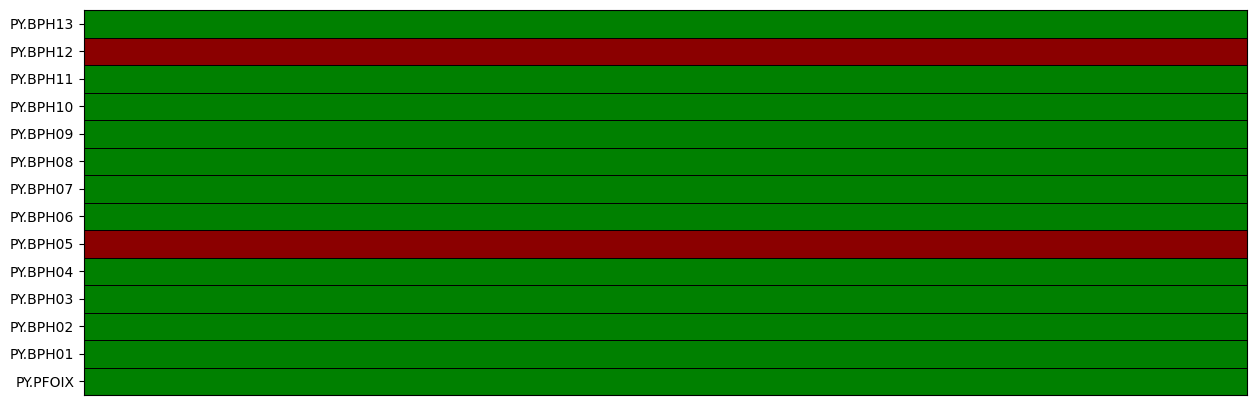


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-13T09:46:44.247700Z - 2023-08-13T09:47:44.247700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-13T09:46:44.247700Z - 2023-08-13T09:47:44.247700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-13T09:46:44.247700Z - 2023-08-13T09:47:44.247700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-13T09:46:44.250000Z - 2023-08-13T09:47:44.250000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-13T09:46:44.250000Z - 2023-08-13T09:47:44.250000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-13T09:46:44.250000Z - 2023-08-13T09:47:44.250000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-13T09:46:44.250000Z - 2023-08-13T09:47:44.250000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-13T09:46:44.250000Z - 2023-08-13T09:47:44.250000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-13T09:46:44.250000Z - 2023-08-13T09:47:44.250000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-13T09:46:44.250000Z - 2023-08-13T09:47:


 -> 283 2023-08-14 04:10:35.780000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


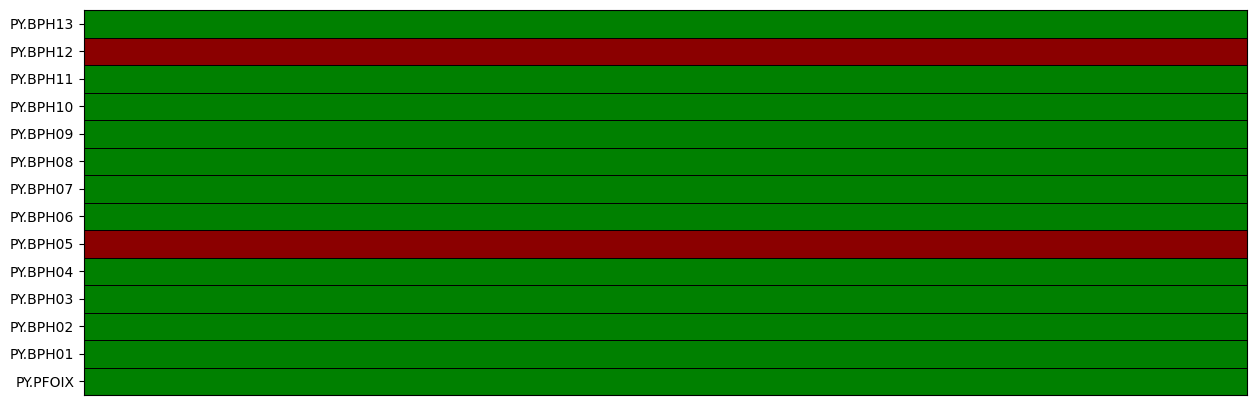


 -> Runtime: 0.72 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.49 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-14T04:10:20.781300Z - 2023-08-14T04:11:20.781300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-14T04:10:20.781300Z - 2023-08-14T04:11:20.781300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-14T04:10:20.781300Z - 2023-08-14T04:11:20.781300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-14T04:10:20.780000Z - 2023-08-14T04:11:20.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-14T04:10:20.780000Z - 2023-08-14T04:11:20.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-14T04:10:20.780000Z - 2023-08-14T04:11:20.780000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-14T04:10:20.780000Z - 2023-08-14T04:11:20.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-14T04:10:20.780000Z - 2023-08-14T04:11:20.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-14T04:10:20.780000Z - 2023-08-14T04:11:20.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-14T04:10:20.780000Z - 2023-08-14T04:11:


 -> 284 2023-08-16 01:23:47.730000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


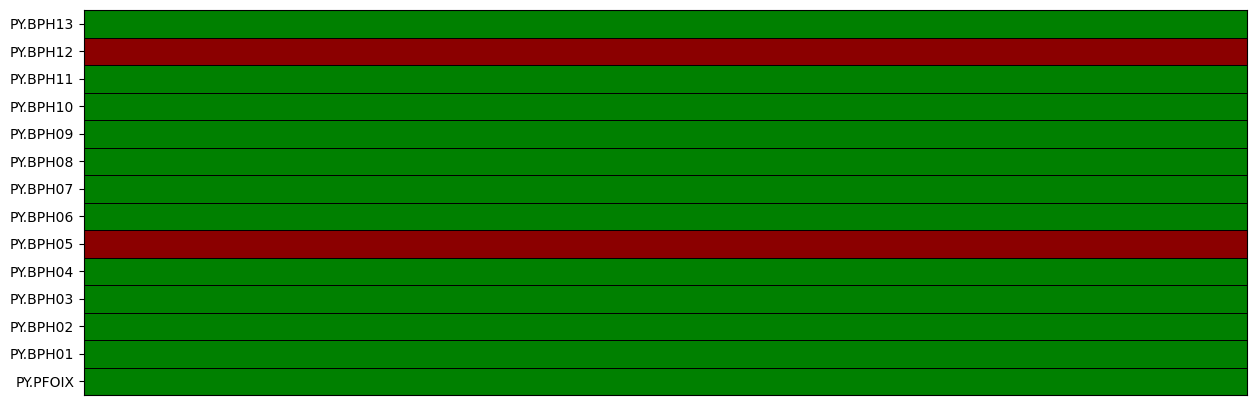


 -> Runtime: 0.74 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.3 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-16T01:23:32.731400Z - 2023-08-16T01:24:32.731400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-16T01:23:32.731400Z - 2023-08-16T01:24:32.731400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-16T01:23:32.731400Z - 2023-08-16T01:24:32.731400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-16T01:23:32.730000Z - 2023-08-16T01:24:32.730000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-16T01:23:32.730000Z - 2023-08-16T01:24:32.730000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-16T01:23:32.730000Z - 2023-08-16T01:24:32.730000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-16T01:23:32.730000Z - 2023-08-16T01:24:32.730000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-16T01:23:32.730000Z - 2023-08-16T01:24:32.730000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-16T01:23:32.730000Z - 2023-08-16T01:24:32.730000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-16T01:23:32.730000Z - 2023-08-16T01:24:


 -> 285 2023-08-16 06:04:21.760000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


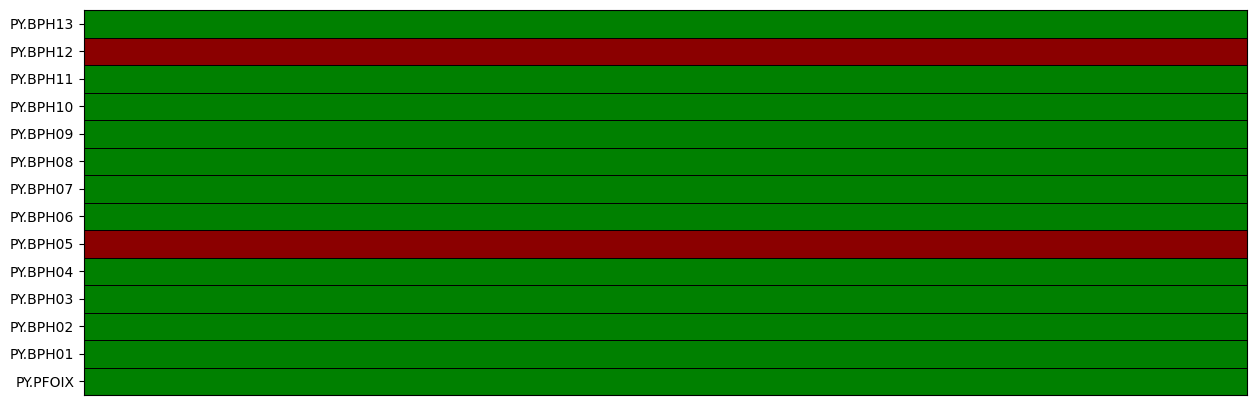


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> PFOIX Failed to load inventory!
 -> PFOIX failed to rotate to ZNE
 -> failed to compute ADR inner ...


9 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-16T06:04:06.761400Z - 2023-08-16T06:05:06.761400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-16T06:04:06.761400Z - 2023-08-16T06:05:06.761400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-16T06:04:06.761400Z - 2023-08-16T06:05:06.761400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-16T06:04:06.760000Z - 2023-08-16T06:05:06.760000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-16T06:04:06.760000Z - 2023-08-16T06:05:06.760000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-16T06:04:06.760000Z - 2023-08-16T06:05:06.760000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-16T06:04:06.760000Z - 2023-08-16T06:05:06.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-16T06:04:06.760000Z - 2023-08-16T06:05:06.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-16T06:04:06.760000Z - 2023-08-16T06:05:06.760000Z | 40.0 Hz, 2401 samples


 -> 286 2023-08-18 11:47:54.570000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


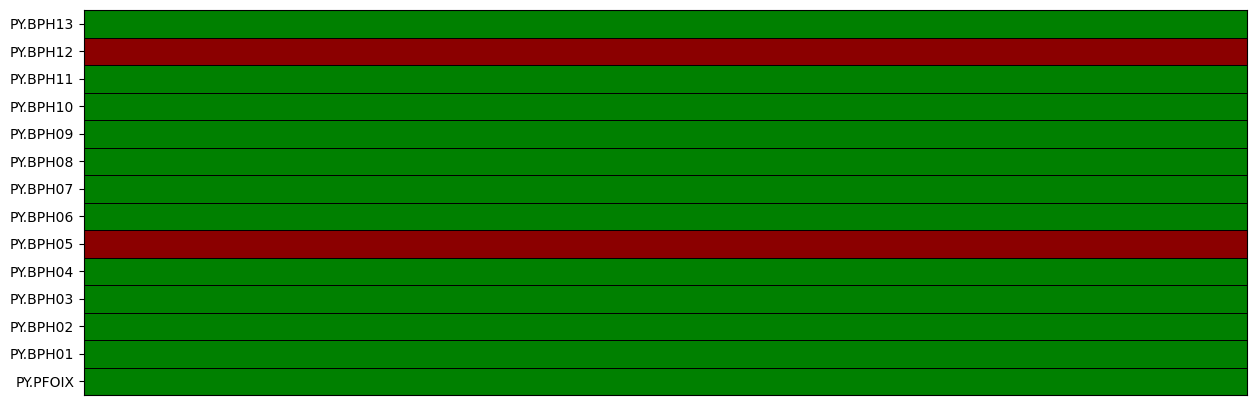


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> BPH01 Failed to load inventory!
 -> BPH01 failed to rotate to ZNE
 -> continue computing ADR for 4 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-18T11:47:39.571500Z - 2023-08-18T11:48:39.571500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-18T11:47:39.571500Z - 2023-08-18T11:48:39.571500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-18T11:47:39.571500Z - 2023-08-18T11:48:39.571500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-18T11:47:39.570000Z - 2023-08-18T11:48:39.570000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-18T11:47:39.570000Z - 2023-08-18T11:48:39.570000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-18T11:47:39.570000Z - 2023-08-18T11:48:39.570000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-18T11:47:39.570000Z - 2023-08-18T11:48:39.570000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-18T11:47:39.570000Z - 2023-08-18T11:48:39.570000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-18T11:47:39.570000Z - 2023-08-18T11:48:39.570000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-18T11:47:39.570000Z - 2023-08-18T11:48:


 -> 287 2023-08-19 08:57:48.340000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


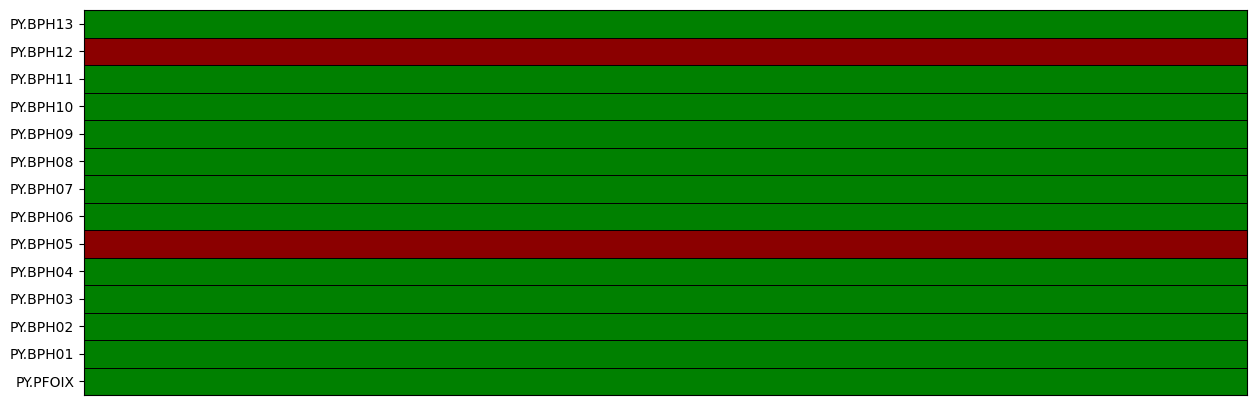


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-19T08:57:33.341500Z - 2023-08-19T08:58:33.341500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-19T08:57:33.341500Z - 2023-08-19T08:58:33.341500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-19T08:57:33.341500Z - 2023-08-19T08:58:33.341500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-19T08:57:33.340000Z - 2023-08-19T08:58:33.340000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-19T08:57:33.340000Z - 2023-08-19T08:58:33.340000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-19T08:57:33.340000Z - 2023-08-19T08:58:33.340000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-19T08:57:33.340000Z - 2023-08-19T08:58:33.340000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-19T08:57:33.340000Z - 2023-08-19T08:58:33.340000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-19T08:57:33.340000Z - 2023-08-19T08:58:33.340000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-19T08:57:33.340000Z - 2023-08-19T08:58:


 -> 288 2023-08-21 00:56:54.760000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


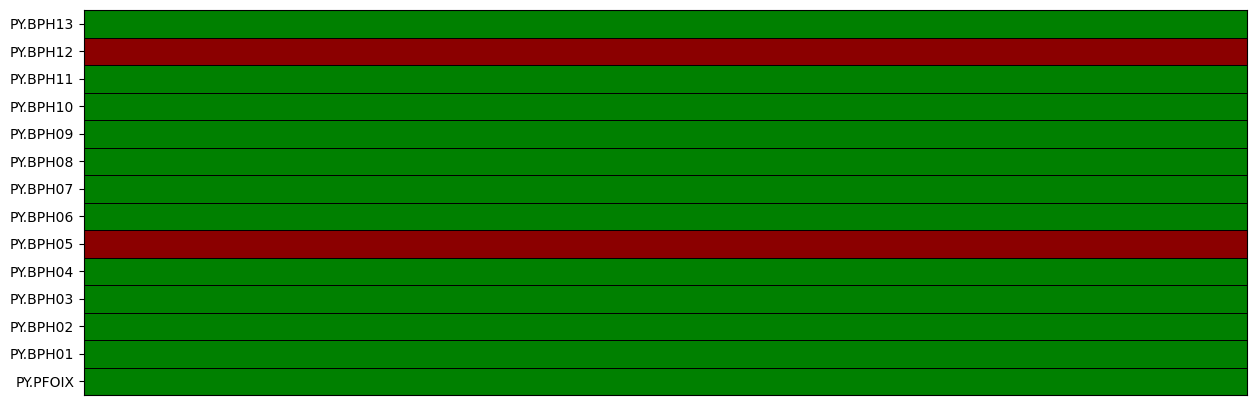


 -> Runtime: 0.79 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-21T00:56:39.761700Z - 2023-08-21T00:57:39.761700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-21T00:56:39.761700Z - 2023-08-21T00:57:39.761700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-21T00:56:39.761700Z - 2023-08-21T00:57:39.761700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-21T00:56:39.760000Z - 2023-08-21T00:57:39.760000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-21T00:56:39.760000Z - 2023-08-21T00:57:39.760000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-21T00:56:39.760000Z - 2023-08-21T00:57:39.760000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-21T00:56:39.760000Z - 2023-08-21T00:57:39.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-21T00:56:39.760000Z - 2023-08-21T00:57:39.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-21T00:56:39.760000Z - 2023-08-21T00:57:39.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-21T00:56:39.760000Z - 2023-08-21T00:57:


 -> 289 2023-08-22 05:32:49.090000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


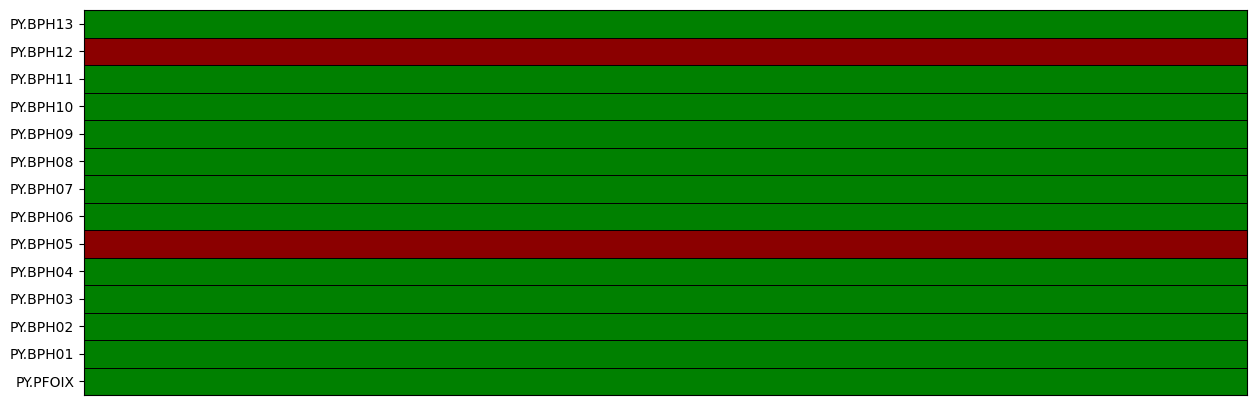


 -> Runtime: 0.69 minutes
 -> BPH05 Failed to load inventory!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-22T05:32:34.091700Z - 2023-08-22T05:33:34.091700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-22T05:32:34.091700Z - 2023-08-22T05:33:34.091700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-22T05:32:34.091700Z - 2023-08-22T05:33:34.091700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-22T05:32:34.090000Z - 2023-08-22T05:33:34.090000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-22T05:32:34.090000Z - 2023-08-22T05:33:34.090000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-22T05:32:34.090000Z - 2023-08-22T05:33:34.090000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-22T05:32:34.090000Z - 2023-08-22T05:33:34.090000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-22T05:32:34.090000Z - 2023-08-22T05:33:34.090000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-22T05:32:34.090000Z - 2023-08-22T05:33:34.090000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-22T05:32:34.090000Z - 2023-08-22T05:33:


 -> 290 2023-08-24 08:08:49.150000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH08 Failed to load inventory!
 -> failed to compute ADR all ...
 -> PFOIX Failed to load inventory!
 -> PFOIX failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


9 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-24T08:08:34.152200Z - 2023-08-24T08:09:34.152200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-24T08:08:34.152200Z - 2023-08-24T08:09:34.152200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-24T08:08:34.152200Z - 2023-08-24T08:09:34.152200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-24T08:08:34.150000Z - 2023-08-24T08:09:34.150000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-24T08:08:34.150000Z - 2023-08-24T08:09:34.150000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-24T08:08:34.150000Z - 2023-08-24T08:09:34.150000Z | 200.0 Hz, 12001 samples
PY.RPFO.inn.BJE | 2023-08-24T08:08:34.150000Z - 2023-08-24T08:09:34.150000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJN | 2023-08-24T08:08:34.150000Z - 2023-08-24T08:09:34.150000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJZ | 2023-08-24T08:08:34.150000Z - 2023-08-24T08:09:34.150000Z | 40.0 Hz, 2401 samples


 -> 291 2023-08-24 12:42:22.250000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


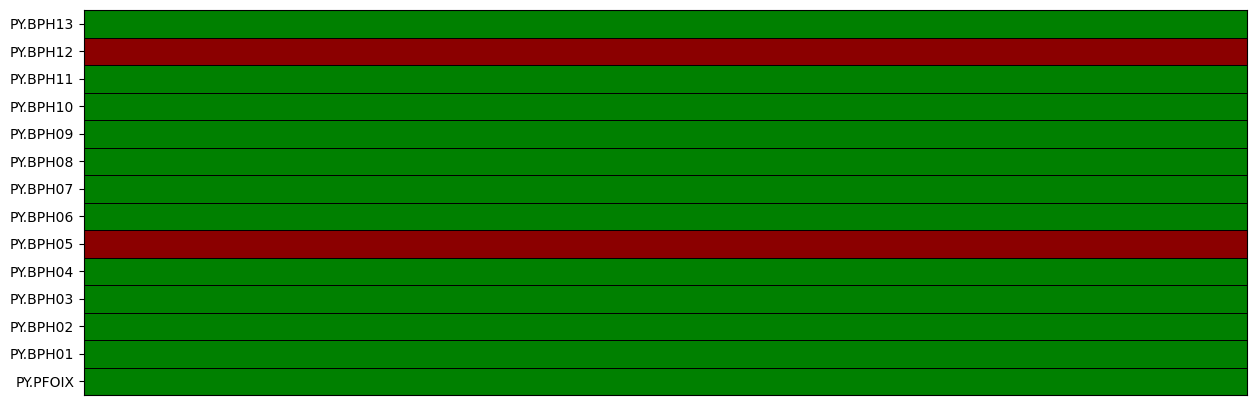


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-24T12:42:07.252200Z - 2023-08-24T12:43:07.252200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-24T12:42:07.252200Z - 2023-08-24T12:43:07.252200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-24T12:42:07.252200Z - 2023-08-24T12:43:07.252200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-24T12:42:07.250000Z - 2023-08-24T12:43:07.250000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-24T12:42:07.250000Z - 2023-08-24T12:43:07.250000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-24T12:42:07.250000Z - 2023-08-24T12:43:07.250000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-24T12:42:07.250000Z - 2023-08-24T12:43:07.250000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-24T12:42:07.250000Z - 2023-08-24T12:43:07.250000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-24T12:42:07.250000Z - 2023-08-24T12:43:07.250000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-24T12:42:07.250000Z - 2023-08-24T12:43:


 -> 292 2023-08-24 19:25:38.290000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


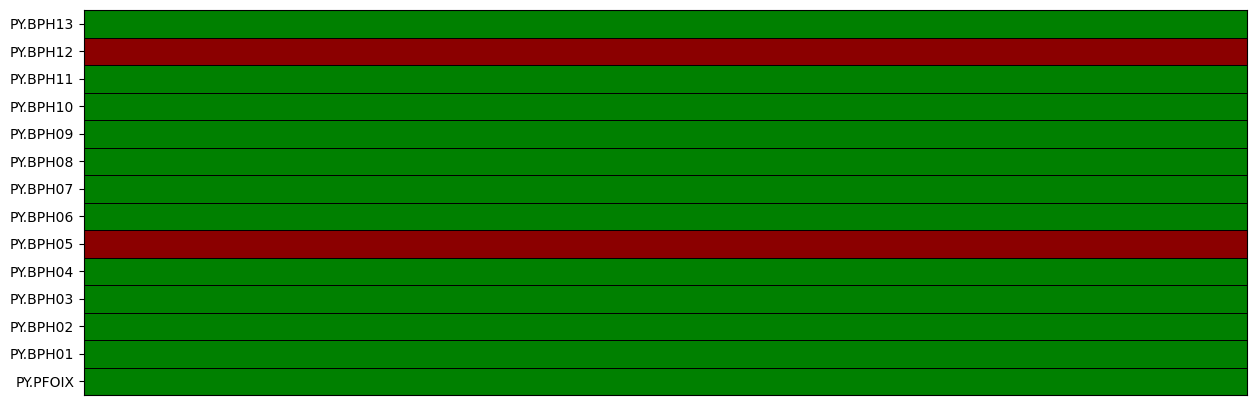


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-24T19:25:23.292500Z - 2023-08-24T19:26:23.287500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJN    | 2023-08-24T19:25:23.292500Z - 2023-08-24T19:26:23.287500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJZ    | 2023-08-24T19:25:23.292500Z - 2023-08-24T19:26:23.287500Z | 200.0 Hz, 12000 samples
PY.PFOIX..HHE   | 2023-08-24T19:25:23.290000Z - 2023-08-24T19:26:23.290000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-24T19:25:23.290000Z - 2023-08-24T19:26:23.290000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-24T19:25:23.290000Z - 2023-08-24T19:26:23.290000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-24T19:25:23.290000Z - 2023-08-24T19:26:23.290000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-24T19:25:23.290000Z - 2023-08-24T19:26:23.290000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-24T19:25:23.290000Z - 2023-08-24T19:26:23.290000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-24T19:25:23.290000Z - 2023-08-24T19:26:


 -> 293 2023-08-26 16:37:59.800000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


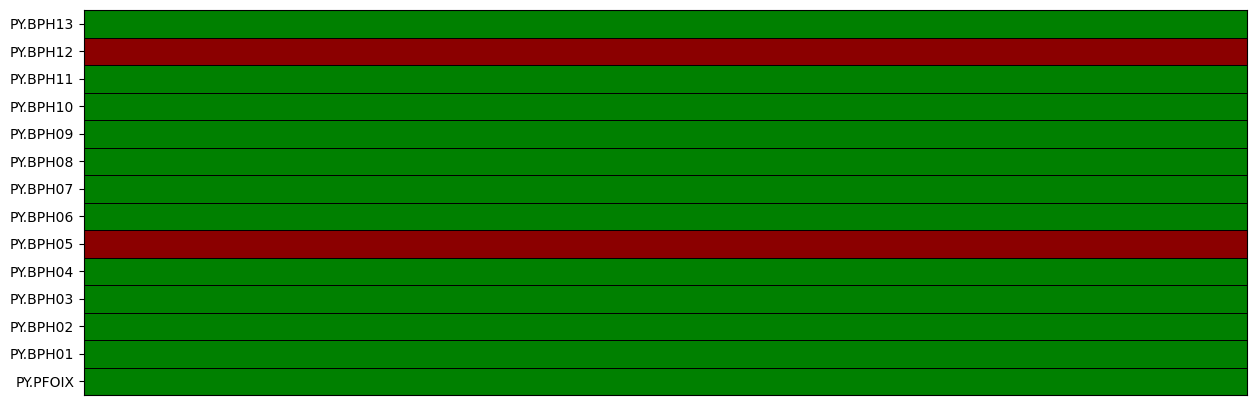


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-26T16:37:44.802400Z - 2023-08-26T16:38:44.802400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-26T16:37:44.802400Z - 2023-08-26T16:38:44.802400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-26T16:37:44.802400Z - 2023-08-26T16:38:44.802400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-26T16:37:44.800000Z - 2023-08-26T16:38:44.800000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-26T16:37:44.800000Z - 2023-08-26T16:38:44.800000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-26T16:37:44.800000Z - 2023-08-26T16:38:44.800000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-26T16:37:44.800000Z - 2023-08-26T16:38:44.800000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-26T16:37:44.800000Z - 2023-08-26T16:38:44.800000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-26T16:37:44.800000Z - 2023-08-26T16:38:44.800000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-26T16:37:44.800000Z - 2023-08-26T16:38:


 -> 294 2023-08-28 10:27:34.700000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


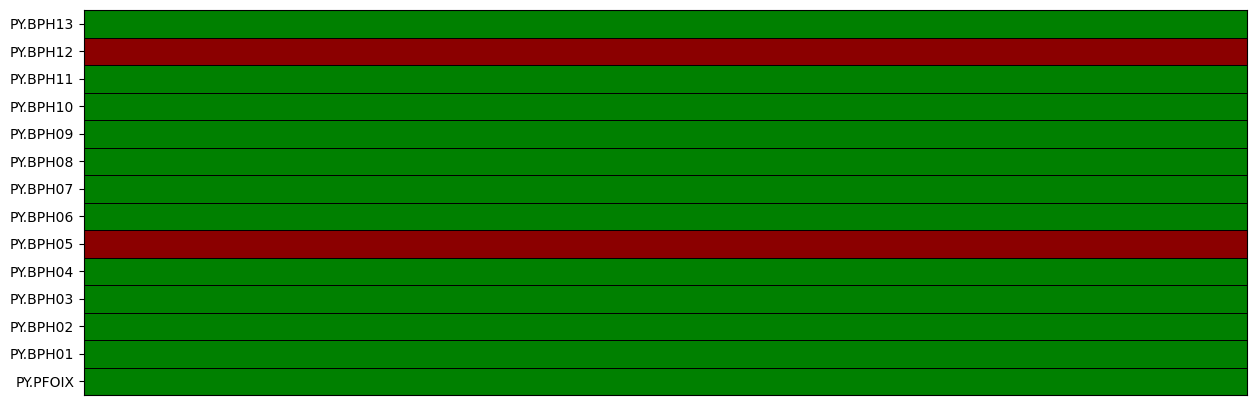


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH06 Failed to load inventory!
 -> failed to compute ADR mid ...
 -> PFOIX Failed to load inventory!
 -> PFOIX failed to rotate to ZNE
 -> BPH02 Failed to load inventory!
 -> BPH02 failed to rotate to ZNE
 -> failed to compute ADR inner ...


9 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-28T10:27:19.700400Z - 2023-08-28T10:28:19.700400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-28T10:27:19.700400Z - 2023-08-28T10:28:19.700400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-28T10:27:19.700400Z - 2023-08-28T10:28:19.700400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-28T10:27:19.700000Z - 2023-08-28T10:28:19.700000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-28T10:27:19.700000Z - 2023-08-28T10:28:19.700000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-28T10:27:19.700000Z - 2023-08-28T10:28:19.700000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-28T10:27:19.700000Z - 2023-08-28T10:28:19.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-28T10:27:19.700000Z - 2023-08-28T10:28:19.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-28T10:27:19.700000Z - 2023-08-28T10:28:19.700000Z | 40.0 Hz, 2401 samples


 -> 295 2023-08-28 23:37:14.130000 
 -> sensitivity removed!
 -> response removed!
 -> BPH02 Failed to load inventory!
 -> BPH02 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


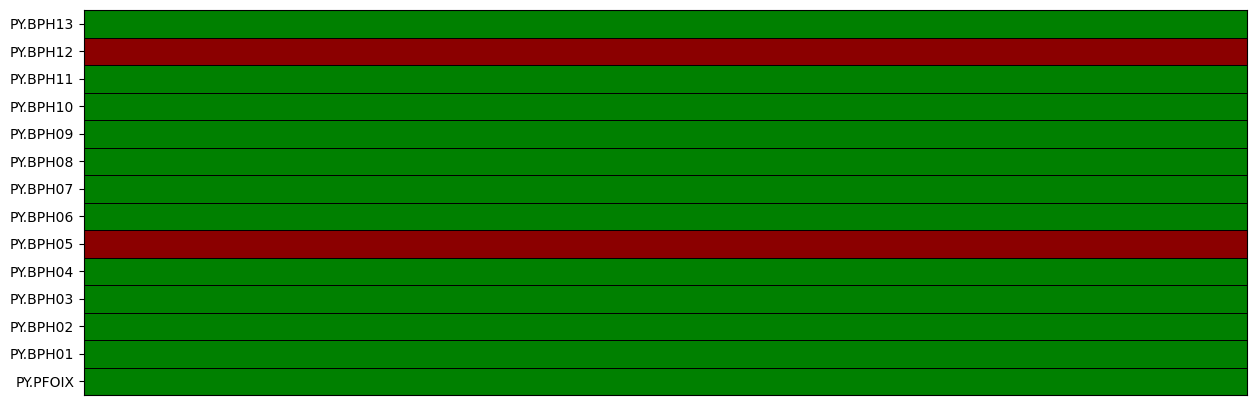


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-28T23:36:59.130300Z - 2023-08-28T23:37:59.130300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-28T23:36:59.130400Z - 2023-08-28T23:37:59.130400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-28T23:36:59.130400Z - 2023-08-28T23:37:59.130400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-28T23:36:59.130000Z - 2023-08-28T23:37:59.130000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-28T23:36:59.130000Z - 2023-08-28T23:37:59.130000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-28T23:36:59.130000Z - 2023-08-28T23:37:59.130000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-28T23:36:59.130000Z - 2023-08-28T23:37:59.130000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-28T23:36:59.130000Z - 2023-08-28T23:37:59.130000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-28T23:36:59.130000Z - 2023-08-28T23:37:59.130000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-28T23:36:59.130000Z - 2023-08-28T23:37:


 -> 296 2023-08-29 20:53:28.390000 
 -> sensitivity removed!
 -> response removed!
 -> BPH05 Failed to load inventory!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH08 Failed to load inventory!
 -> BPH08 failed to rotate to ZNE
 -> BPH10 Failed to load inventory!
 -> BPH10 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> BPH13 Failed to load inventory!
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-29T20:53:13.390600Z - 2023-08-29T20:54:13.390600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-29T20:53:13.390600Z - 2023-08-29T20:54:13.390600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-29T20:53:13.390600Z - 2023-08-29T20:54:13.390600Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-29T20:53:13.390000Z - 2023-08-29T20:54:13.390000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-29T20:53:13.390000Z - 2023-08-29T20:54:13.390000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-29T20:53:13.390000Z - 2023-08-29T20:54:13.390000Z | 200.0 Hz, 12001 samples
PY.RPFO.inn.BJE | 2023-08-29T20:53:13.390000Z - 2023-08-29T20:54:13.390000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJN | 2023-08-29T20:53:13.390000Z - 2023-08-29T20:54:13.390000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJZ | 2023-08-29T20:53:13.390000Z - 2023-08-29T20:54:13.390000Z | 40.0 Hz, 2401 samples
PY.RPFO.mid.BJE | 2023-08-29T20:53:13.390000Z - 2023-08-29T20:54:


 -> 297 2023-08-30 08:46:25.260000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


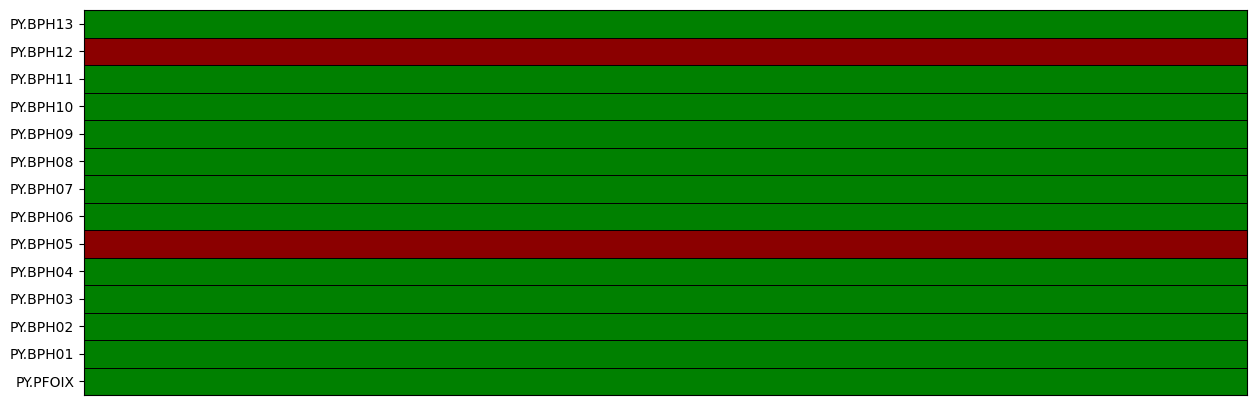


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-30T08:46:10.260600Z - 2023-08-30T08:47:10.260600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-30T08:46:10.260600Z - 2023-08-30T08:47:10.260600Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-30T08:46:10.260600Z - 2023-08-30T08:47:10.260600Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-30T08:46:10.260000Z - 2023-08-30T08:47:10.260000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-30T08:46:10.260000Z - 2023-08-30T08:47:10.260000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-30T08:46:10.260000Z - 2023-08-30T08:47:10.260000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-30T08:46:10.260000Z - 2023-08-30T08:47:10.260000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-30T08:46:10.260000Z - 2023-08-30T08:47:10.260000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-30T08:46:10.260000Z - 2023-08-30T08:47:10.260000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-30T08:46:10.260000Z - 2023-08-30T08:47:


 -> 298 2023-08-30 15:31:13.500000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


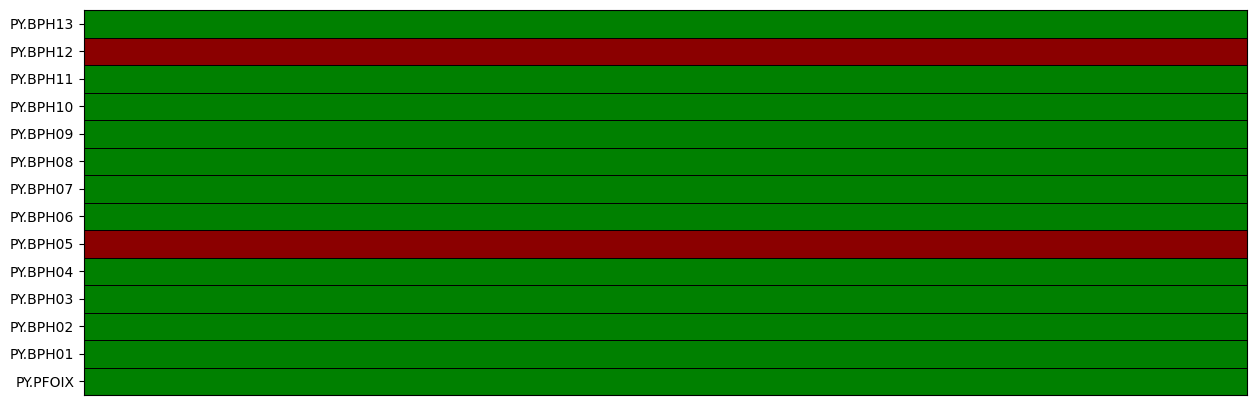


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-30T15:30:58.500000Z - 2023-08-30T15:31:58.500000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-30T15:30:58.500000Z - 2023-08-30T15:31:58.500000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-30T15:30:58.500000Z - 2023-08-30T15:31:58.500000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-30T15:30:58.500000Z - 2023-08-30T15:31:58.500000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-30T15:30:58.500000Z - 2023-08-30T15:31:58.500000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-30T15:30:58.500000Z - 2023-08-30T15:31:58.500000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-30T15:30:58.500000Z - 2023-08-30T15:31:58.500000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-30T15:30:58.500000Z - 2023-08-30T15:31:58.500000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-30T15:30:58.500000Z - 2023-08-30T15:31:58.500000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-30T15:30:58.500000Z - 2023-08-30T15:31:


 -> 299 2023-08-30 15:32:05.710000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


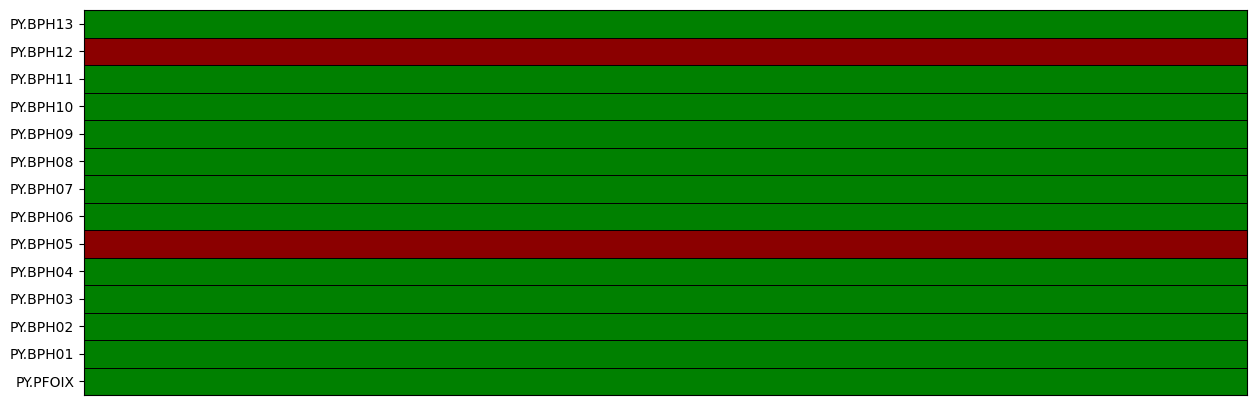


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-30T15:31:50.710000Z - 2023-08-30T15:32:50.710000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-30T15:31:50.710000Z - 2023-08-30T15:32:50.710000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-30T15:31:50.710000Z - 2023-08-30T15:32:50.710000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-30T15:31:50.710000Z - 2023-08-30T15:32:50.710000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-30T15:31:50.710000Z - 2023-08-30T15:32:50.710000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-30T15:31:50.710000Z - 2023-08-30T15:32:50.710000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-30T15:31:50.710000Z - 2023-08-30T15:32:50.710000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-30T15:31:50.710000Z - 2023-08-30T15:32:50.710000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-30T15:31:50.710000Z - 2023-08-30T15:32:50.710000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-30T15:31:50.710000Z - 2023-08-30T15:32:


 -> 300 2023-08-31 21:11:09.690000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


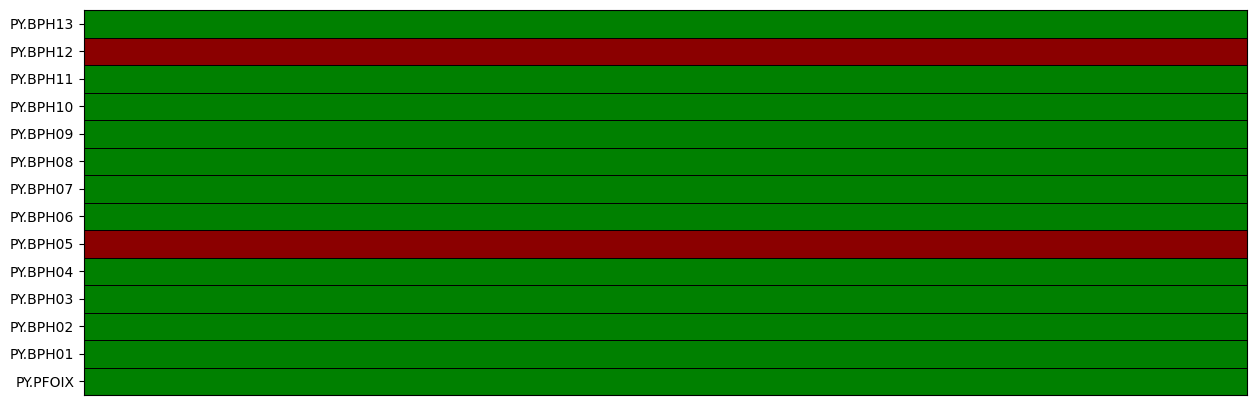


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-08-31T21:10:54.690000Z - 2023-08-31T21:11:54.690000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-08-31T21:10:54.690000Z - 2023-08-31T21:11:54.690000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-08-31T21:10:54.690000Z - 2023-08-31T21:11:54.690000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-08-31T21:10:54.690000Z - 2023-08-31T21:11:54.690000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-08-31T21:10:54.690000Z - 2023-08-31T21:11:54.690000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-08-31T21:10:54.690000Z - 2023-08-31T21:11:54.690000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-08-31T21:10:54.690000Z - 2023-08-31T21:11:54.690000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-08-31T21:10:54.690000Z - 2023-08-31T21:11:54.690000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-08-31T21:10:54.690000Z - 2023-08-31T21:11:54.690000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-08-31T21:10:54.690000Z - 2023-08-31T21:11:


 -> 301 2023-09-01 08:45:26.790000 
 -> sensitivity removed!
 -> response removed!
 -> BPH04 Failed to load inventory!
 -> BPH04 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


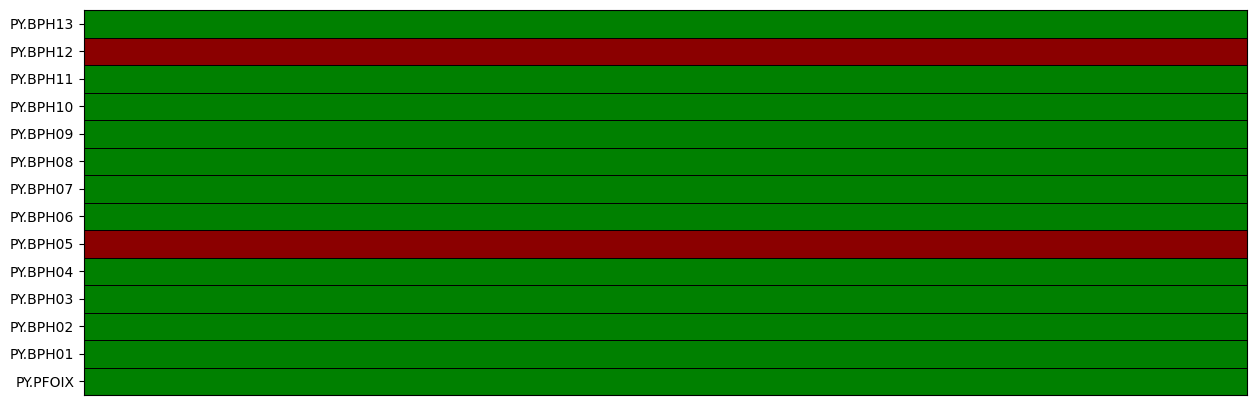


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-01T08:45:11.790000Z - 2023-09-01T08:46:11.790000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-01T08:45:11.790000Z - 2023-09-01T08:46:11.790000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-01T08:45:11.790000Z - 2023-09-01T08:46:11.790000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-01T08:45:11.790000Z - 2023-09-01T08:46:11.790000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-01T08:45:11.790000Z - 2023-09-01T08:46:11.790000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-01T08:45:11.790000Z - 2023-09-01T08:46:11.790000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-01T08:45:11.790000Z - 2023-09-01T08:46:11.790000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-01T08:45:11.790000Z - 2023-09-01T08:46:11.790000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-01T08:45:11.790000Z - 2023-09-01T08:46:11.790000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-01T08:45:11.790000Z - 2023-09-01T08:46:


 -> 302 2023-09-01 11:56:28.140000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


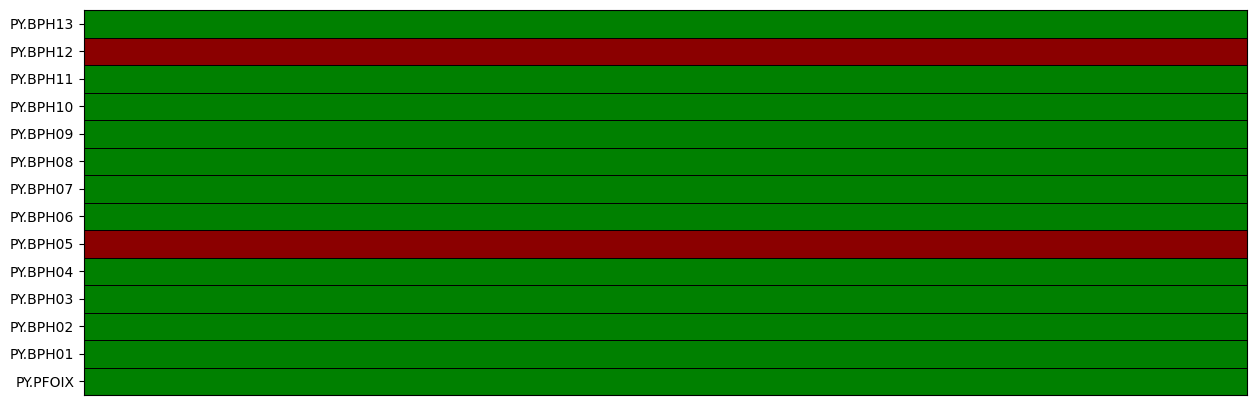


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-01T11:56:13.140000Z - 2023-09-01T11:57:13.140000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-01T11:56:13.140000Z - 2023-09-01T11:57:13.140000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-01T11:56:13.140000Z - 2023-09-01T11:57:13.140000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-01T11:56:13.140000Z - 2023-09-01T11:57:13.140000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-01T11:56:13.140000Z - 2023-09-01T11:57:13.140000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-01T11:56:13.140000Z - 2023-09-01T11:57:13.140000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-01T11:56:13.140000Z - 2023-09-01T11:57:13.140000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-01T11:56:13.140000Z - 2023-09-01T11:57:13.140000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-01T11:56:13.140000Z - 2023-09-01T11:57:13.140000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-01T11:56:13.140000Z - 2023-09-01T11:57:


 -> 303 2023-09-03 01:45:31.780000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


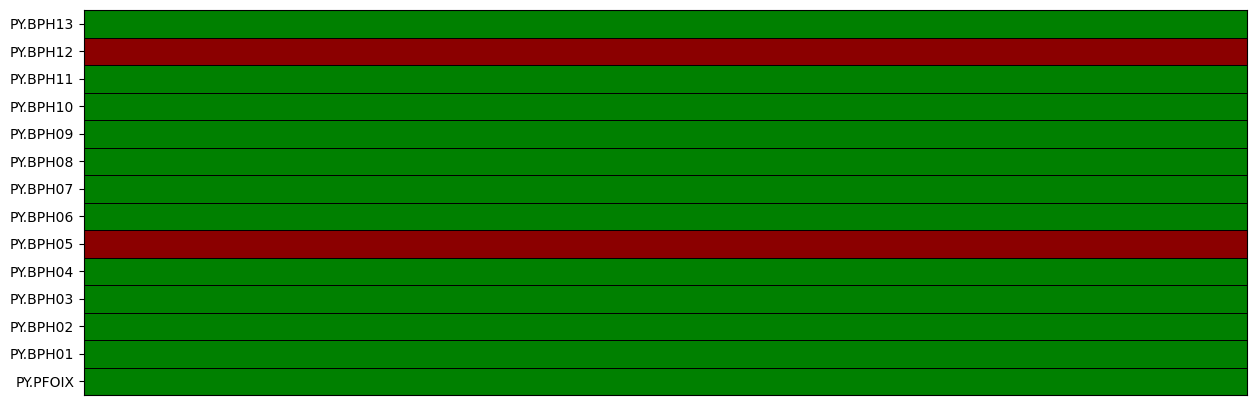


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-03T01:45:16.780000Z - 2023-09-03T01:46:16.780000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-03T01:45:16.780000Z - 2023-09-03T01:46:16.780000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-03T01:45:16.780000Z - 2023-09-03T01:46:16.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-03T01:45:16.780000Z - 2023-09-03T01:46:16.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-03T01:45:16.780000Z - 2023-09-03T01:46:16.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-03T01:45:16.780000Z - 2023-09-03T01:46:16.780000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-03T01:45:16.780000Z - 2023-09-03T01:46:16.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-03T01:45:16.780000Z - 2023-09-03T01:46:16.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-03T01:45:16.780000Z - 2023-09-03T01:46:16.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-03T01:45:16.780000Z - 2023-09-03T01:46:


 -> 304 2023-09-04 15:53:58.330000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


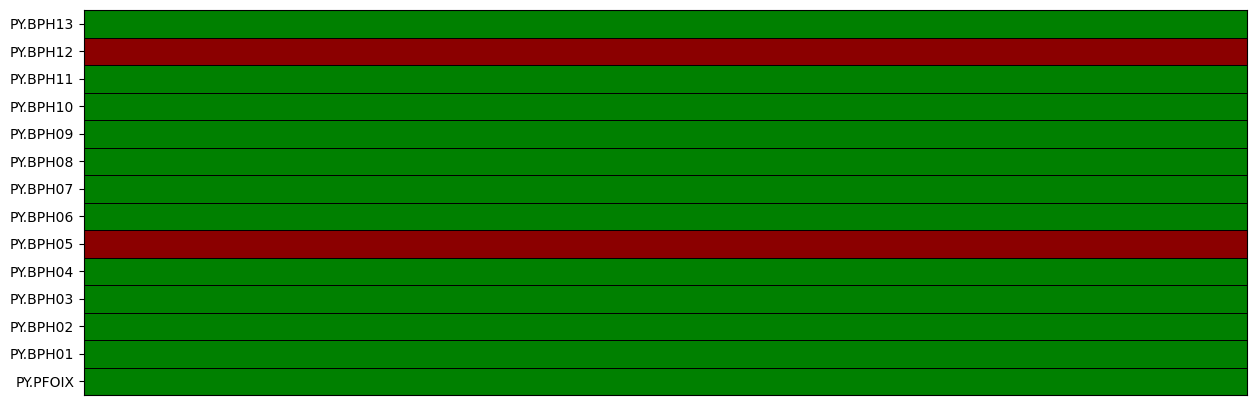


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-04T15:53:43.328200Z - 2023-09-04T15:54:43.328200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-04T15:53:43.328200Z - 2023-09-04T15:54:43.328200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-04T15:53:43.328200Z - 2023-09-04T15:54:43.328200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-04T15:53:43.330000Z - 2023-09-04T15:54:43.330000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-04T15:53:43.330000Z - 2023-09-04T15:54:43.330000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-04T15:53:43.330000Z - 2023-09-04T15:54:43.330000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-04T15:53:43.330000Z - 2023-09-04T15:54:43.330000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-04T15:53:43.330000Z - 2023-09-04T15:54:43.330000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-04T15:53:43.330000Z - 2023-09-04T15:54:43.330000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-04T15:53:43.330000Z - 2023-09-04T15:54:


 -> 305 2023-09-05 11:15:27.700000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH11 Failed to load inventory!
 -> BPH11 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


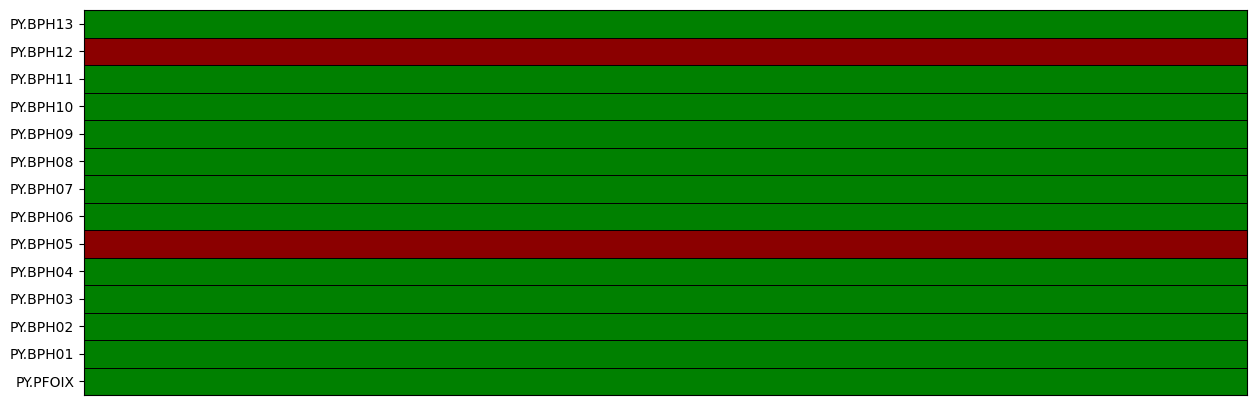


 -> Runtime: 0.68 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-05T11:15:12.698200Z - 2023-09-05T11:16:12.698200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-05T11:15:12.698200Z - 2023-09-05T11:16:12.698200Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-05T11:15:12.698200Z - 2023-09-05T11:16:12.698200Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-05T11:15:12.700000Z - 2023-09-05T11:16:12.700000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-05T11:15:12.700000Z - 2023-09-05T11:16:12.700000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-05T11:15:12.700000Z - 2023-09-05T11:16:12.700000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-05T11:15:12.700000Z - 2023-09-05T11:16:12.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-05T11:15:12.700000Z - 2023-09-05T11:16:12.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-05T11:15:12.700000Z - 2023-09-05T11:16:12.700000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-05T11:15:12.700000Z - 2023-09-05T11:16:


 -> 306 2023-09-05 22:38:55.780000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


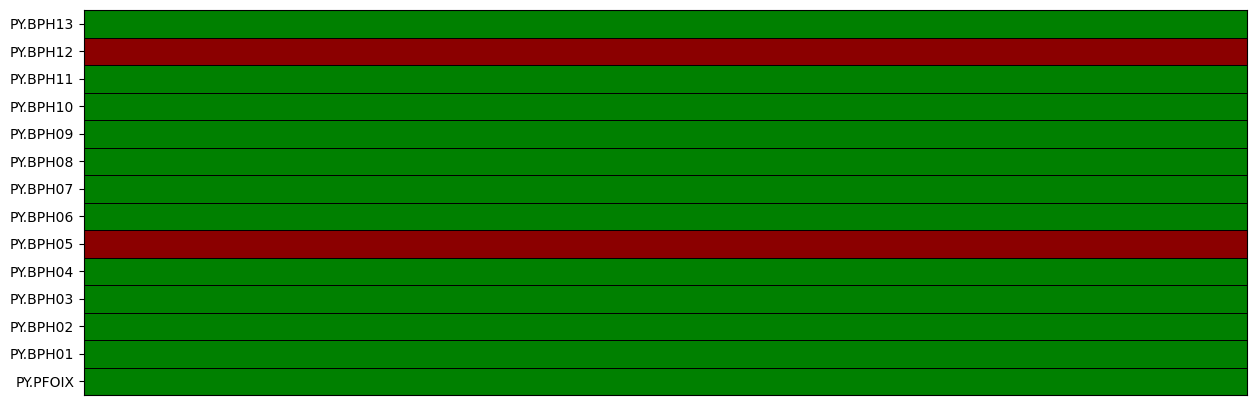


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-05T22:38:40.778000Z - 2023-09-05T22:39:40.778000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-05T22:38:40.778000Z - 2023-09-05T22:39:40.778000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-05T22:38:40.778000Z - 2023-09-05T22:39:40.778000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-05T22:38:40.780000Z - 2023-09-05T22:39:40.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-05T22:38:40.780000Z - 2023-09-05T22:39:40.780000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-05T22:38:40.780000Z - 2023-09-05T22:39:40.780000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-05T22:38:40.780000Z - 2023-09-05T22:39:40.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-05T22:38:40.780000Z - 2023-09-05T22:39:40.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-05T22:38:40.780000Z - 2023-09-05T22:39:40.780000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-05T22:38:40.780000Z - 2023-09-05T22:39:


 -> 307 2023-09-07 13:35:25.470000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


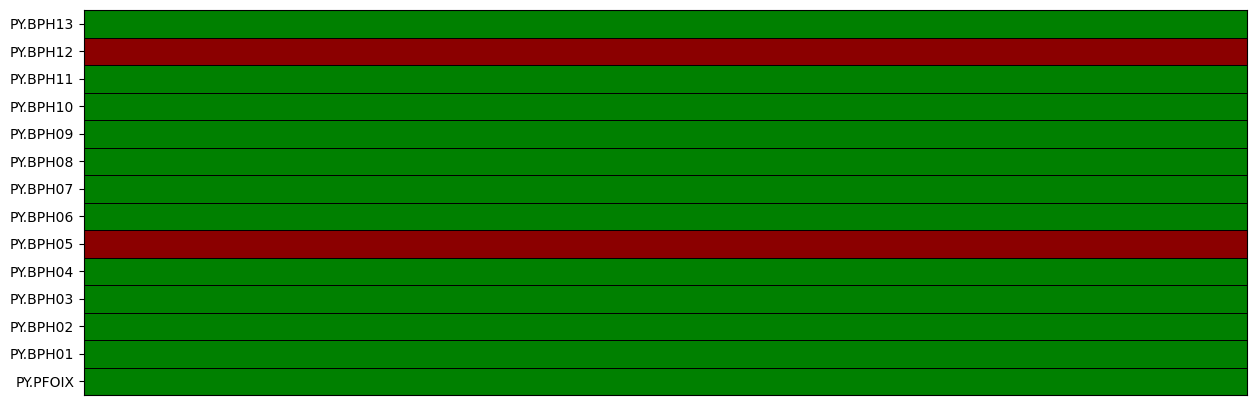


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-07T13:35:10.468000Z - 2023-09-07T13:36:10.468000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-07T13:35:10.468000Z - 2023-09-07T13:36:10.468000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-07T13:35:10.468000Z - 2023-09-07T13:36:10.468000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-07T13:35:10.470000Z - 2023-09-07T13:36:10.470000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-07T13:35:10.470000Z - 2023-09-07T13:36:10.470000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-07T13:35:10.470000Z - 2023-09-07T13:36:10.470000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-07T13:35:10.470000Z - 2023-09-07T13:36:10.470000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-07T13:35:10.470000Z - 2023-09-07T13:36:10.470000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-07T13:35:10.470000Z - 2023-09-07T13:36:10.470000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-07T13:35:10.470000Z - 2023-09-07T13:36:


 -> 308 2023-09-08 05:59:23.360000 
 -> sensitivity removed!
 -> Failed to load inventory!
 -> response removed!
 -> failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


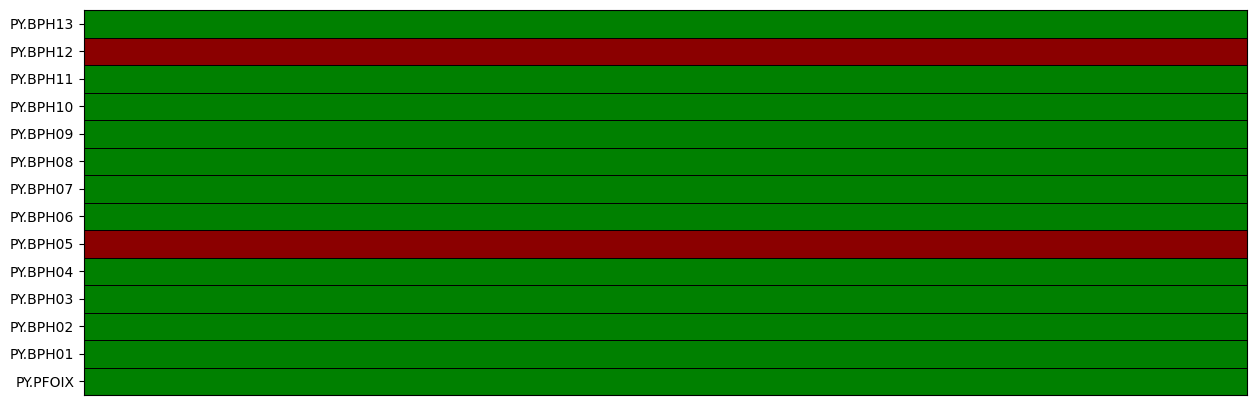


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-08T05:59:08.358000Z - 2023-09-08T06:00:08.358000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-08T05:59:08.358000Z - 2023-09-08T06:00:08.358000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-08T05:59:08.358000Z - 2023-09-08T06:00:08.358000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-08T05:59:08.360000Z - 2023-09-08T06:00:08.360000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-08T05:59:08.360000Z - 2023-09-08T06:00:08.360000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-08T05:59:08.360000Z - 2023-09-08T06:00:08.360000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-08T05:59:08.360000Z - 2023-09-08T06:00:08.360000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-08T05:59:08.360000Z - 2023-09-08T06:00:08.360000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-08T05:59:08.360000Z - 2023-09-08T06:00:08.360000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-08T05:59:08.360000Z - 2023-09-08T06:00:


 -> 309 2023-09-09 14:38:05.420000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-09T14:37:50.422000Z - 2023-09-09T14:38:50.422000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-09T14:37:50.422000Z - 2023-09-09T14:38:50.422000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-09T14:37:50.422000Z - 2023-09-09T14:38:50.422000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-09T14:37:50.420000Z - 2023-09-09T14:38:50.420000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-09T14:37:50.420000Z - 2023-09-09T14:38:50.420000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-09T14:37:50.420000Z - 2023-09-09T14:38:50.420000Z | 200.0 Hz, 12001 samples
PY.RPFO.inn.BJE | 2023-09-09T14:37:50.420000Z - 2023-09-09T14:38:50.420000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJN | 2023-09-09T14:37:50.420000Z - 2023-09-09T14:38:50.420000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJZ | 2023-09-09T14:37:50.420000Z - 2023-09-09T14:38:50.420000Z | 40.0 Hz, 2401 samples
PY.RPFO.mid.BJE | 2023-09-09T14:37:50.420000Z - 2023-09-09T14:38:


 -> 310 2023-09-10 14:28:43.200000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


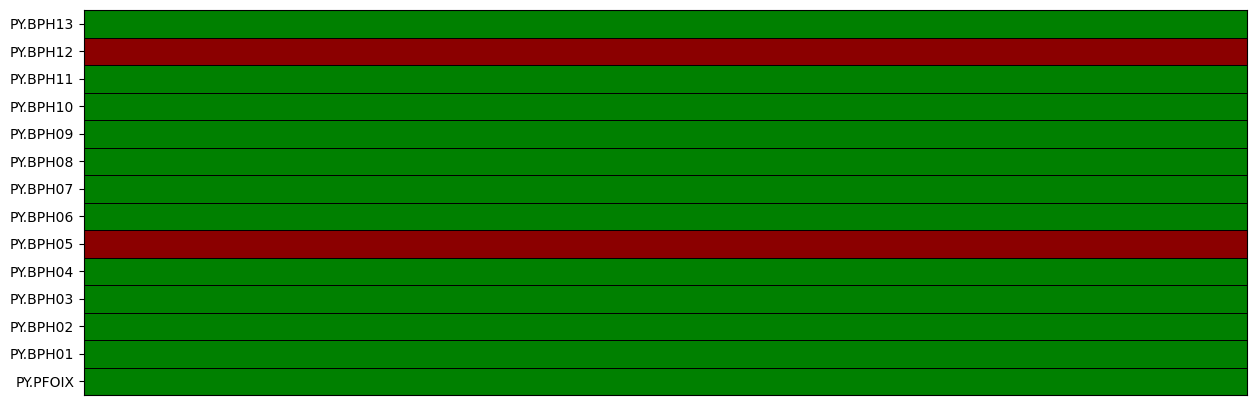


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> PFOIX Failed to load inventory!
 -> PFOIX failed to rotate to ZNE
 -> failed to compute ADR inner ...


9 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-10T14:28:28.202400Z - 2023-09-10T14:29:28.202400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-10T14:28:28.202400Z - 2023-09-10T14:29:28.202400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-10T14:28:28.202400Z - 2023-09-10T14:29:28.202400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-10T14:28:28.200000Z - 2023-09-10T14:29:28.200000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-10T14:28:28.200000Z - 2023-09-10T14:29:28.200000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-10T14:28:28.200000Z - 2023-09-10T14:29:28.200000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-10T14:28:28.200000Z - 2023-09-10T14:29:28.200000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-10T14:28:28.200000Z - 2023-09-10T14:29:28.200000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-10T14:28:28.200000Z - 2023-09-10T14:29:28.200000Z | 40.0 Hz, 2401 samples


 -> 311 2023-09-10 21:06:24.460000 
 -> sensitivity removed!
 -> response removed!
 -> BPH03 Failed to load inventory!
 -> failed to compute ADR all ...
 -> BPH04 Failed to load inventory!
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...
 -> failed to compute ADR inner ...


6 Trace(s) in Stream:
PY.BSPF..HJE  | 2023-09-10T21:06:09.462400Z - 2023-09-10T21:07:09.462400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN  | 2023-09-10T21:06:09.462400Z - 2023-09-10T21:07:09.462400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ  | 2023-09-10T21:06:09.462400Z - 2023-09-10T21:07:09.462400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE | 2023-09-10T21:06:09.460000Z - 2023-09-10T21:07:09.460000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN | 2023-09-10T21:06:09.460000Z - 2023-09-10T21:07:09.460000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ | 2023-09-10T21:06:09.460000Z - 2023-09-10T21:07:09.460000Z | 200.0 Hz, 12001 samples


 -> 312 2023-09-11 06:09:17.930000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


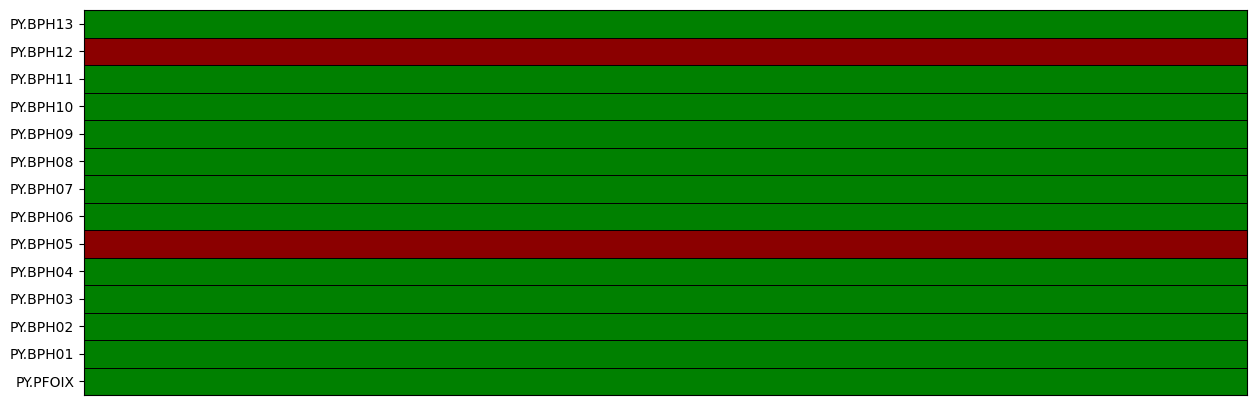


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.45 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-11T06:09:02.929000Z - 2023-09-11T06:10:02.929000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-11T06:09:02.929000Z - 2023-09-11T06:10:02.929000Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-11T06:09:02.929000Z - 2023-09-11T06:10:02.929000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-11T06:09:02.930000Z - 2023-09-11T06:10:02.930000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-11T06:09:02.930000Z - 2023-09-11T06:10:02.930000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-11T06:09:02.930000Z - 2023-09-11T06:10:02.930000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-11T06:09:02.930000Z - 2023-09-11T06:10:02.930000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-11T06:09:02.930000Z - 2023-09-11T06:10:02.930000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-11T06:09:02.930000Z - 2023-09-11T06:10:02.930000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-11T06:09:02.930000Z - 2023-09-11T06:10:


 -> 313 2023-09-11 09:20:15.690000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


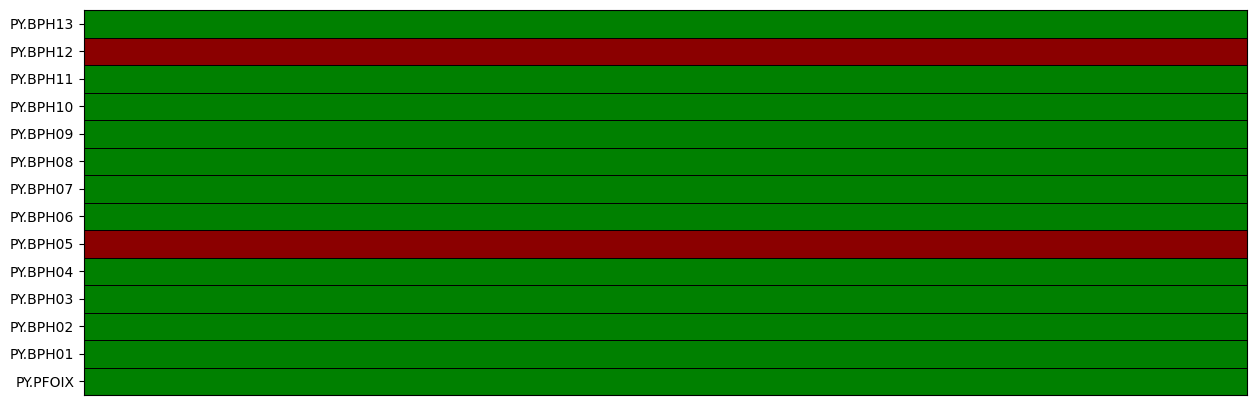


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-11T09:20:00.692400Z - 2023-09-11T09:21:00.692400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-11T09:20:00.692400Z - 2023-09-11T09:21:00.692400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-11T09:20:00.692400Z - 2023-09-11T09:21:00.692400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-11T09:20:00.690000Z - 2023-09-11T09:21:00.690000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-11T09:20:00.690000Z - 2023-09-11T09:21:00.690000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-11T09:20:00.690000Z - 2023-09-11T09:21:00.690000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-11T09:20:00.690000Z - 2023-09-11T09:21:00.690000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-11T09:20:00.690000Z - 2023-09-11T09:21:00.690000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-11T09:20:00.690000Z - 2023-09-11T09:21:00.690000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-11T09:20:00.690000Z - 2023-09-11T09:21:


 -> 314 2023-09-11 21:55:22.640000 
 -> Failed to load inventory!
 -> sensitivity removed!
 -> failed to rotate to ZNE
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


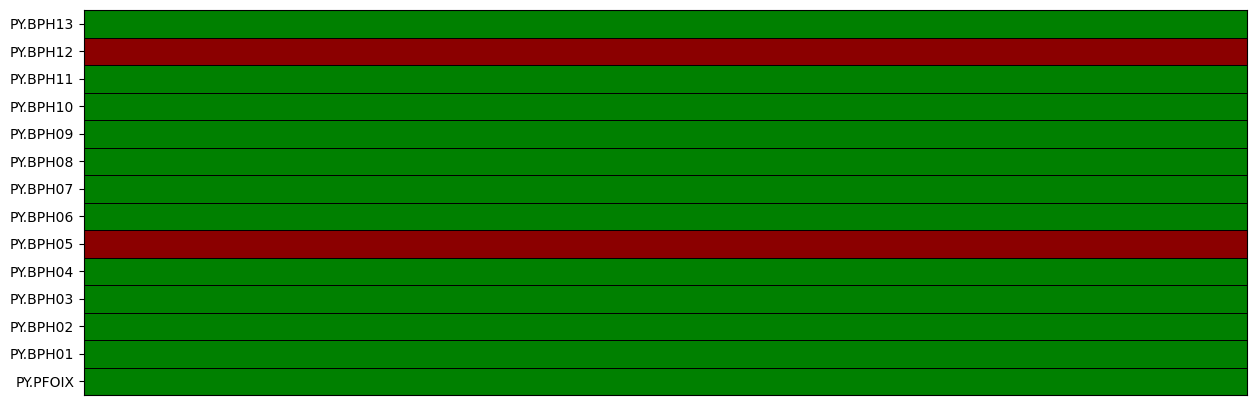


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJ1    | 2023-09-11T21:55:07.642500Z - 2023-09-11T21:56:07.637500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJ2    | 2023-09-11T21:55:07.642500Z - 2023-09-11T21:56:07.637500Z | 200.0 Hz, 12000 samples
PY.BSPF..HJ3    | 2023-09-11T21:55:07.642500Z - 2023-09-11T21:56:07.637500Z | 200.0 Hz, 12000 samples
PY.PFOIX..HHE   | 2023-09-11T21:55:07.640000Z - 2023-09-11T21:56:07.640000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-11T21:55:07.640000Z - 2023-09-11T21:56:07.640000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-11T21:55:07.640000Z - 2023-09-11T21:56:07.640000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-11T21:55:07.640000Z - 2023-09-11T21:56:07.640000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-11T21:55:07.640000Z - 2023-09-11T21:56:07.640000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-11T21:55:07.640000Z - 2023-09-11T21:56:07.640000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-11T21:55:07.640000Z - 2023-09-11T21:56:


 -> 315 2023-09-13 05:24:01.760000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


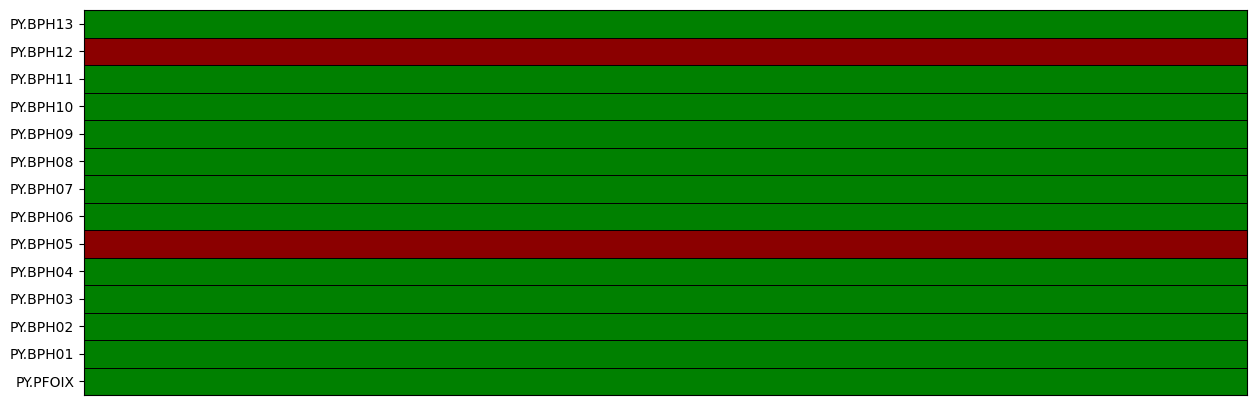


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-13T05:23:46.758300Z - 2023-09-13T05:24:46.758300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-13T05:23:46.758300Z - 2023-09-13T05:24:46.758300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-13T05:23:46.758300Z - 2023-09-13T05:24:46.758300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-13T05:23:46.760000Z - 2023-09-13T05:24:46.760000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-13T05:23:46.760000Z - 2023-09-13T05:24:46.760000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-13T05:23:46.760000Z - 2023-09-13T05:24:46.760000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-13T05:23:46.760000Z - 2023-09-13T05:24:46.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-13T05:23:46.760000Z - 2023-09-13T05:24:46.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-13T05:23:46.760000Z - 2023-09-13T05:24:46.760000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-13T05:23:46.760000Z - 2023-09-13T05:24:


 -> 316 2023-09-14 00:24:00.650000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH09 Failed to load inventory!
 -> BPH09 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> BPH13 Failed to load inventory!
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


9 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-14T00:23:45.648300Z - 2023-09-14T00:24:45.648300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-14T00:23:45.648300Z - 2023-09-14T00:24:45.648300Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-14T00:23:45.648300Z - 2023-09-14T00:24:45.648300Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-14T00:23:45.650000Z - 2023-09-14T00:24:45.650000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-14T00:23:45.650000Z - 2023-09-14T00:24:45.650000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-14T00:23:45.650000Z - 2023-09-14T00:24:45.650000Z | 200.0 Hz, 12001 samples
PY.RPFO.inn.BJE | 2023-09-14T00:23:45.650000Z - 2023-09-14T00:24:45.650000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJN | 2023-09-14T00:23:45.650000Z - 2023-09-14T00:24:45.650000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJZ | 2023-09-14T00:23:45.650000Z - 2023-09-14T00:24:45.650000Z | 40.0 Hz, 2401 samples


 -> 317 2023-09-15 05:48:07.170000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH12 Failed to load inventory!
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...
 -> failed to compute ADR all ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-15T05:47:52.168400Z - 2023-09-15T05:48:52.168400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-15T05:47:52.168400Z - 2023-09-15T05:48:52.168400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-15T05:47:52.168400Z - 2023-09-15T05:48:52.168400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-15T05:47:52.170000Z - 2023-09-15T05:48:52.170000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-15T05:47:52.170000Z - 2023-09-15T05:48:52.170000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-15T05:47:52.170000Z - 2023-09-15T05:48:52.170000Z | 200.0 Hz, 12001 samples
PY.RPFO.inn.BJE | 2023-09-15T05:47:52.170000Z - 2023-09-15T05:48:52.170000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJN | 2023-09-15T05:47:52.170000Z - 2023-09-15T05:48:52.170000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJZ | 2023-09-15T05:47:52.170000Z - 2023-09-15T05:48:52.170000Z | 40.0 Hz, 2401 samples
PY.RPFO.mid.BJE | 2023-09-15T05:47:52.170000Z - 2023-09-15T05:48:


 -> 318 2023-09-16 14:36:28.810000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


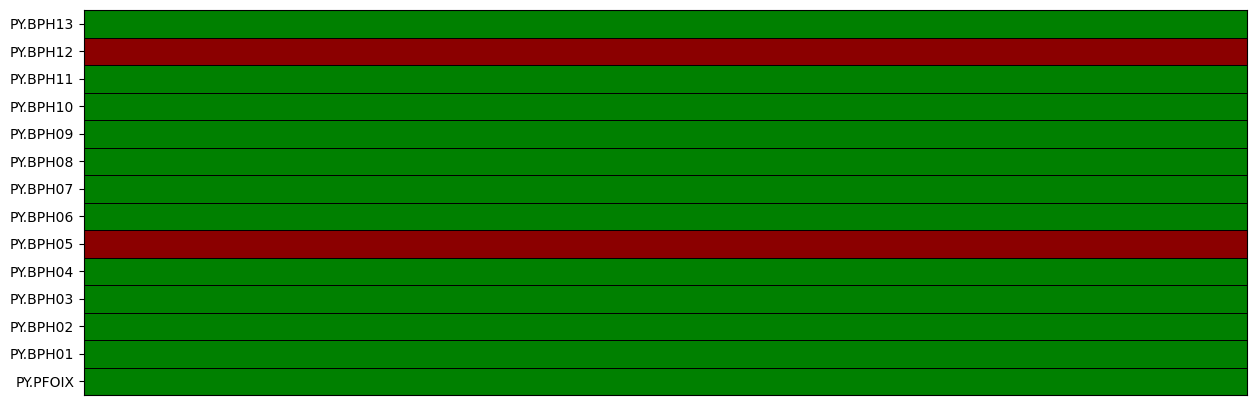


 -> Runtime: 0.7 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-16T14:36:13.808400Z - 2023-09-16T14:37:13.808400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-16T14:36:13.808500Z - 2023-09-16T14:37:13.808500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-16T14:36:13.808500Z - 2023-09-16T14:37:13.808500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-16T14:36:13.810000Z - 2023-09-16T14:37:13.810000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-16T14:36:13.810000Z - 2023-09-16T14:37:13.810000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-16T14:36:13.810000Z - 2023-09-16T14:37:13.810000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-16T14:36:13.810000Z - 2023-09-16T14:37:13.810000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-16T14:36:13.810000Z - 2023-09-16T14:37:13.810000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-16T14:36:13.810000Z - 2023-09-16T14:37:13.810000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-16T14:36:13.810000Z - 2023-09-16T14:37:


 -> 319 2023-09-16 16:49:57.560000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


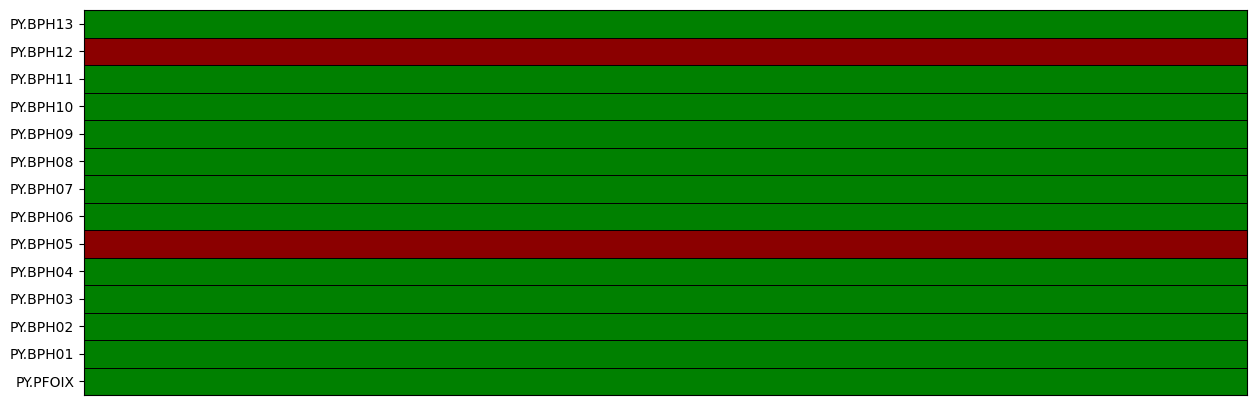


 -> Runtime: 0.66 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-16T16:49:42.558500Z - 2023-09-16T16:50:42.558500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-16T16:49:42.558500Z - 2023-09-16T16:50:42.558500Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-16T16:49:42.558500Z - 2023-09-16T16:50:42.558500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-16T16:49:42.560000Z - 2023-09-16T16:50:42.560000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-16T16:49:42.560000Z - 2023-09-16T16:50:42.560000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-16T16:49:42.560000Z - 2023-09-16T16:50:42.560000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-16T16:49:42.560000Z - 2023-09-16T16:50:42.560000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-16T16:49:42.560000Z - 2023-09-16T16:50:42.560000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-16T16:49:42.560000Z - 2023-09-16T16:50:42.560000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-16T16:49:42.560000Z - 2023-09-16T16:50:


 -> 320 2023-09-16 22:01:33.840000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


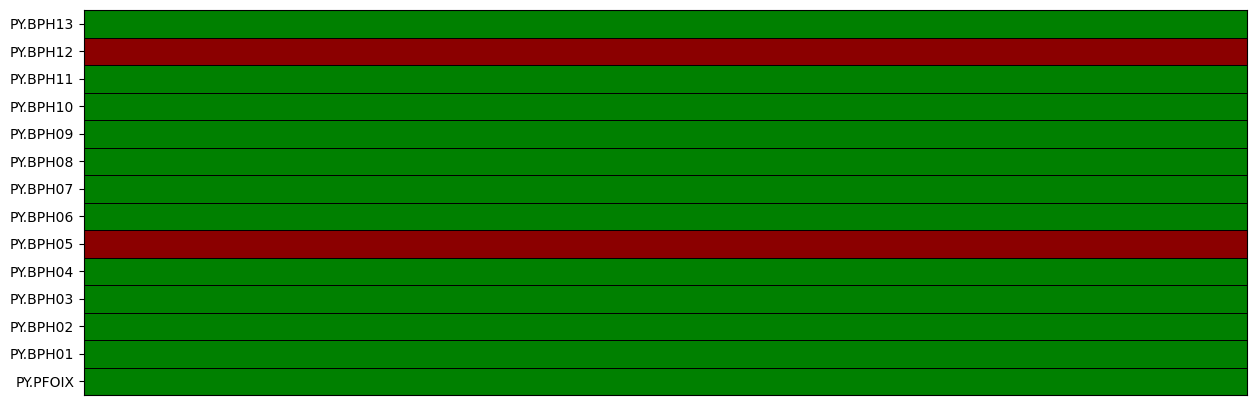


 -> Runtime: 0.63 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.42 minutes
 -> BPH02 Failed to load inventory!
 -> BPH02 failed to rotate to ZNE
 -> continue computing ADR for 4 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-16T22:01:18.838400Z - 2023-09-16T22:02:18.838400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-16T22:01:18.838400Z - 2023-09-16T22:02:18.838400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-16T22:01:18.838500Z - 2023-09-16T22:02:18.838500Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-16T22:01:18.840000Z - 2023-09-16T22:02:18.840000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-16T22:01:18.840000Z - 2023-09-16T22:02:18.840000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-16T22:01:18.840000Z - 2023-09-16T22:02:18.840000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-16T22:01:18.840000Z - 2023-09-16T22:02:18.840000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-16T22:01:18.840000Z - 2023-09-16T22:02:18.840000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-16T22:01:18.840000Z - 2023-09-16T22:02:18.840000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-16T22:01:18.840000Z - 2023-09-16T22:02:


 -> 321 2023-09-18 02:23:22.570000 
 -> sensitivity removed!
 -> response removed!
 -> BPH03 Failed to load inventory!
 -> geting waveforms failed for PY.BPH03..BH* ...
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 11 of 14 stations ...


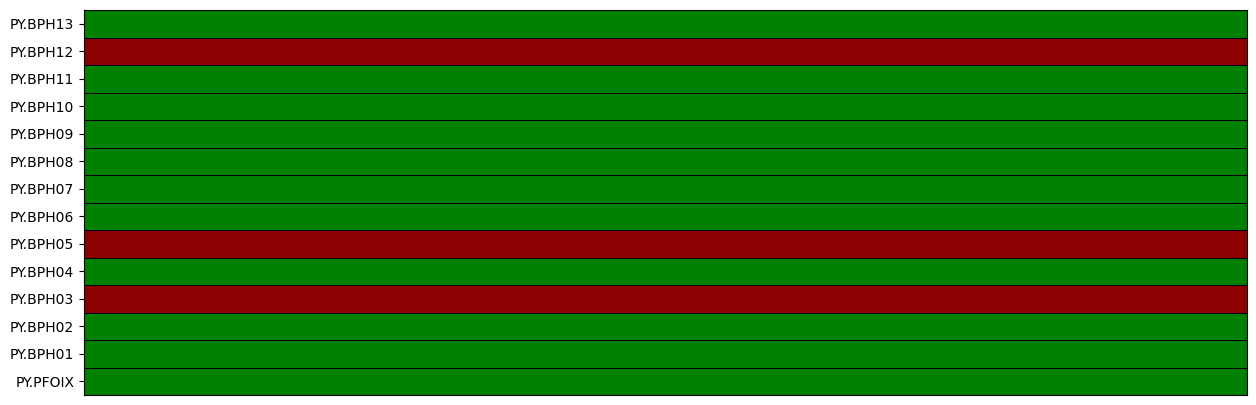


 -> Runtime: 2.65 minutes
 -> BPH02 Failed to load inventory!
 -> BPH02 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 7 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.26 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-18T02:23:07.568400Z - 2023-09-18T02:24:07.568400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-18T02:23:07.568400Z - 2023-09-18T02:24:07.568400Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-18T02:23:07.568400Z - 2023-09-18T02:24:07.568400Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-18T02:23:07.570000Z - 2023-09-18T02:24:07.570000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-18T02:23:07.570000Z - 2023-09-18T02:24:07.570000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-18T02:23:07.570000Z - 2023-09-18T02:24:07.570000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-18T02:23:07.570000Z - 2023-09-18T02:24:07.570000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-18T02:23:07.570000Z - 2023-09-18T02:24:07.570000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-18T02:23:07.570000Z - 2023-09-18T02:24:07.570000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-18T02:23:07.570000Z - 2023-09-18T02:24:


 -> 322 2023-09-19 00:35:13.890000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


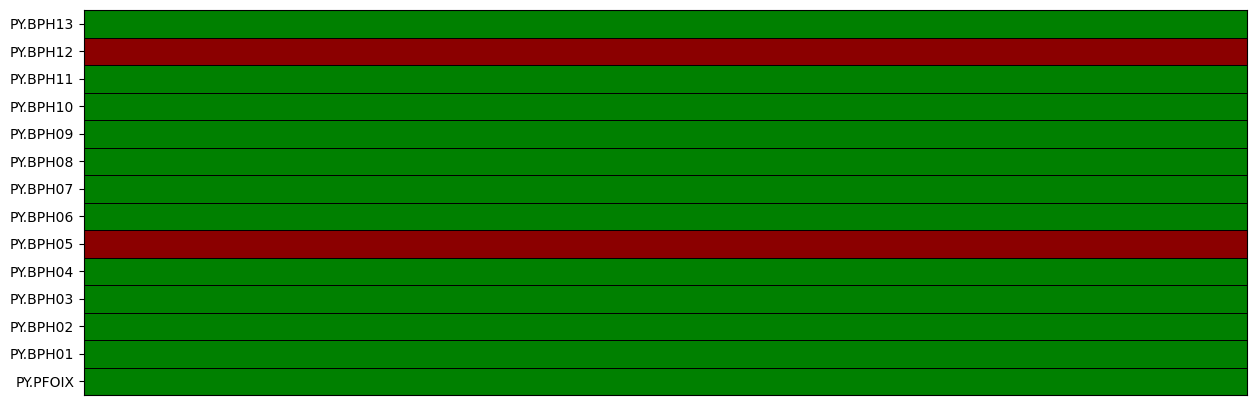


 -> Runtime: 0.69 minutes
 -> BPH05 Failed to load inventory!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> BPH06 Failed to load inventory!
 -> failed to compute ADR mid ...
 -> continue computing ADR for 5 of 5 stations ...
 -> failed to compute ADR inner ...


9 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-19T00:34:58.887900Z - 2023-09-19T00:35:58.887900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-19T00:34:58.887900Z - 2023-09-19T00:35:58.887900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-19T00:34:58.887900Z - 2023-09-19T00:35:58.887900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-19T00:34:58.890000Z - 2023-09-19T00:35:58.890000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-19T00:34:58.890000Z - 2023-09-19T00:35:58.890000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-19T00:34:58.890000Z - 2023-09-19T00:35:58.890000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-19T00:34:58.890000Z - 2023-09-19T00:35:58.890000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-19T00:34:58.890000Z - 2023-09-19T00:35:58.890000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-19T00:34:58.890000Z - 2023-09-19T00:35:58.890000Z | 40.0 Hz, 2401 samples


 -> 323 2023-09-19 16:59:23.750000 
 -> sensitivity removed!
 -> response removed!
 -> BPH01 Failed to load inventory!
 -> BPH01 failed to rotate to ZNE
 -> BPH02 Failed to load inventory!
 -> BPH02 failed to rotate to ZNE
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 10 of 14 stations ...


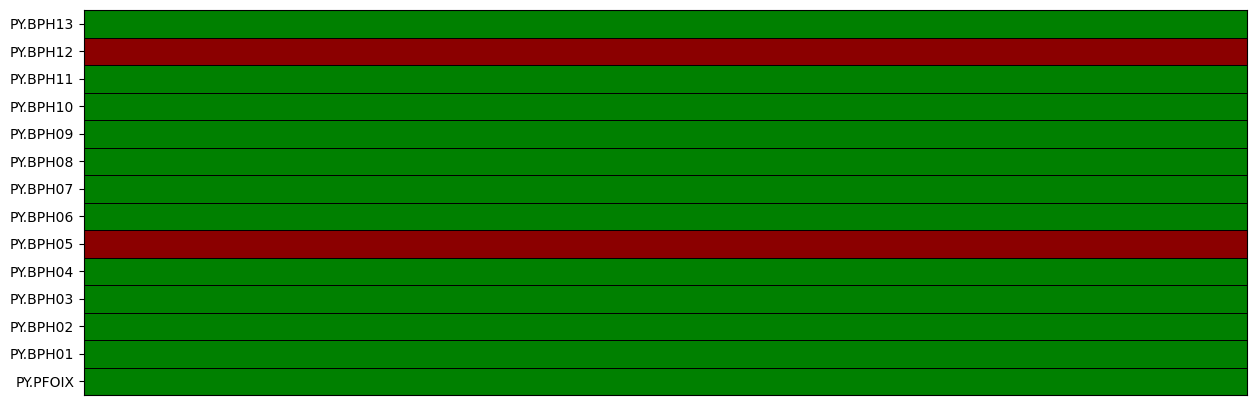


 -> Runtime: 0.65 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...
 -> failed to compute ADR inner ...


12 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-19T16:59:08.747900Z - 2023-09-19T17:00:08.747900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-19T16:59:08.747900Z - 2023-09-19T17:00:08.747900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-19T16:59:08.747900Z - 2023-09-19T17:00:08.747900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-19T16:59:08.750000Z - 2023-09-19T17:00:08.750000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-19T16:59:08.750000Z - 2023-09-19T17:00:08.750000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-19T16:59:08.750000Z - 2023-09-19T17:00:08.750000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-19T16:59:08.750000Z - 2023-09-19T17:00:08.750000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-19T16:59:08.750000Z - 2023-09-19T17:00:08.750000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-19T16:59:08.750000Z - 2023-09-19T17:00:08.750000Z | 40.0 Hz, 2401 samples
PY.RPFO.mid.BJE | 2023-09-19T16:59:08.750000Z - 2023-09-19T17:00:


 -> 324 2023-09-19 18:17:24.190000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


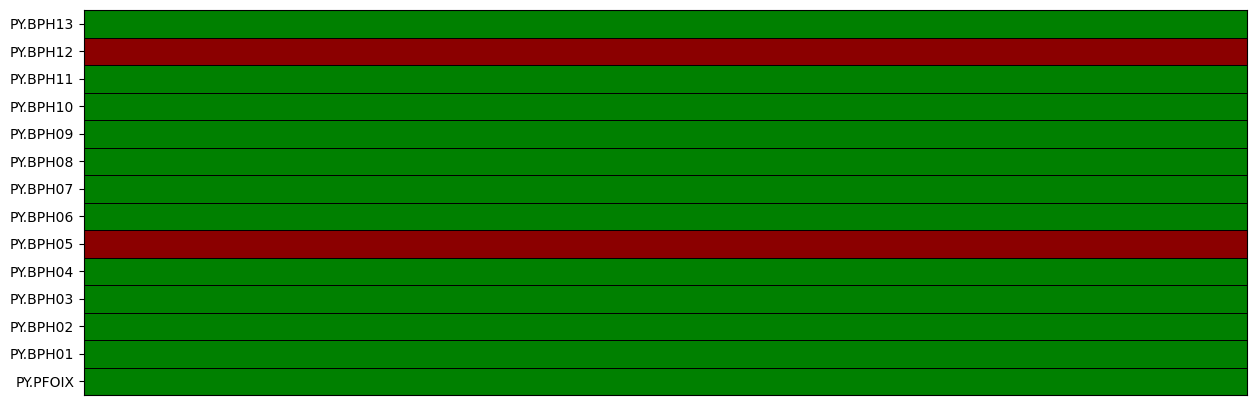


 -> Runtime: 0.67 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-19T18:17:09.187900Z - 2023-09-19T18:18:09.187900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-19T18:17:09.187900Z - 2023-09-19T18:18:09.187900Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-19T18:17:09.187900Z - 2023-09-19T18:18:09.187900Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-19T18:17:09.190000Z - 2023-09-19T18:18:09.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-19T18:17:09.190000Z - 2023-09-19T18:18:09.190000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-19T18:17:09.190000Z - 2023-09-19T18:18:09.190000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-19T18:17:09.190000Z - 2023-09-19T18:18:09.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-19T18:17:09.190000Z - 2023-09-19T18:18:09.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-19T18:17:09.190000Z - 2023-09-19T18:18:09.190000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-19T18:17:09.190000Z - 2023-09-19T18:18:


 -> 325 2023-09-21 01:58:24.210000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


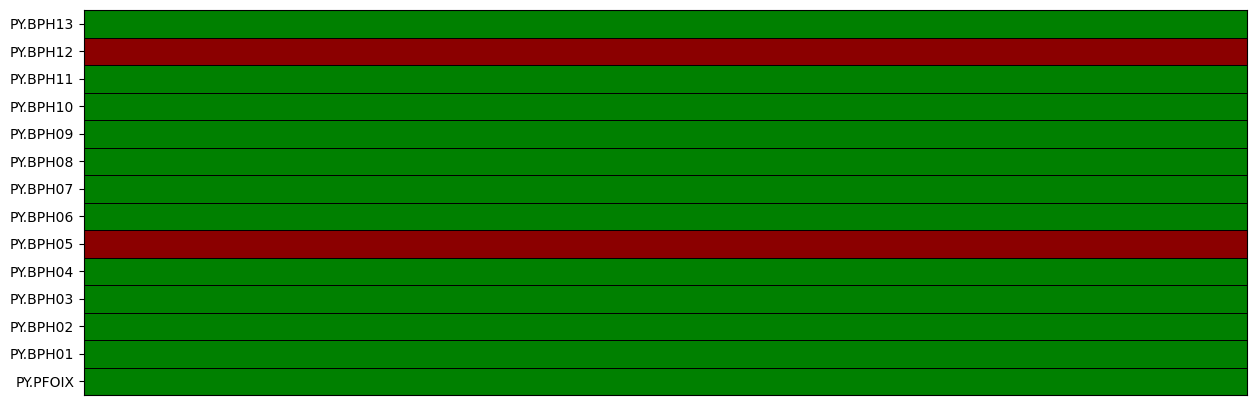


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.43 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.27 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-21T01:58:09.208100Z - 2023-09-21T01:59:09.208100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-21T01:58:09.208100Z - 2023-09-21T01:59:09.208100Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-21T01:58:09.208100Z - 2023-09-21T01:59:09.208100Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-21T01:58:09.210000Z - 2023-09-21T01:59:09.210000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-21T01:58:09.210000Z - 2023-09-21T01:59:09.210000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-21T01:58:09.210000Z - 2023-09-21T01:59:09.210000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-21T01:58:09.210000Z - 2023-09-21T01:59:09.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-21T01:58:09.210000Z - 2023-09-21T01:59:09.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-21T01:58:09.210000Z - 2023-09-21T01:59:09.210000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-21T01:58:09.210000Z - 2023-09-21T01:59:


 -> 326 2023-09-27 13:41:07.510000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


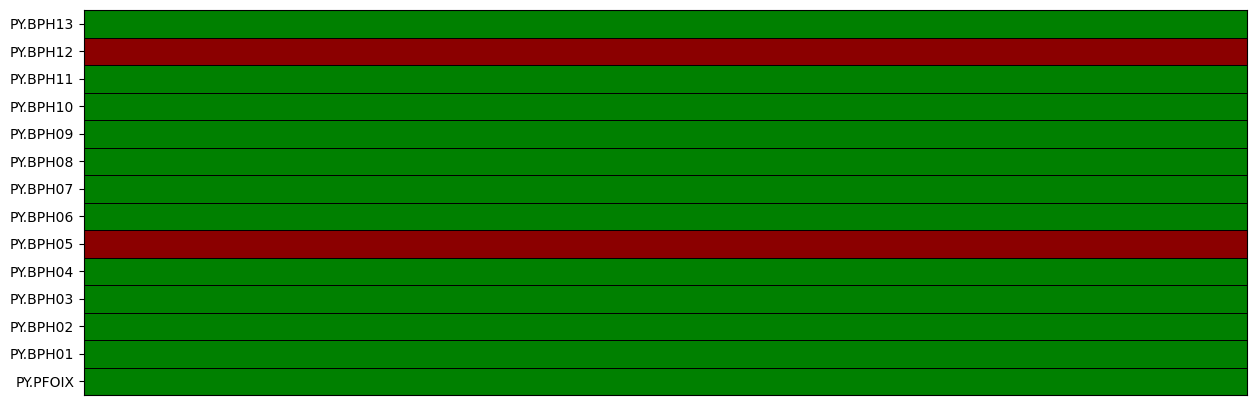


 -> Runtime: 0.69 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.44 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.28 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-27T13:40:52.511800Z - 2023-09-27T13:41:52.511800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-27T13:40:52.511800Z - 2023-09-27T13:41:52.511800Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-27T13:40:52.511800Z - 2023-09-27T13:41:52.511800Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-27T13:40:52.510000Z - 2023-09-27T13:41:52.510000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-27T13:40:52.510000Z - 2023-09-27T13:41:52.510000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-27T13:40:52.510000Z - 2023-09-27T13:41:52.510000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-27T13:40:52.510000Z - 2023-09-27T13:41:52.510000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-27T13:40:52.510000Z - 2023-09-27T13:41:52.510000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-27T13:40:52.510000Z - 2023-09-27T13:41:52.510000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-27T13:40:52.510000Z - 2023-09-27T13:41:


 -> 327 2023-09-29 16:06:53.850000 
 -> sensitivity removed!
 -> response removed!
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> geting waveforms failed for PY.BPH12..BH* ...
 -> continue computing ADR for 12 of 14 stations ...


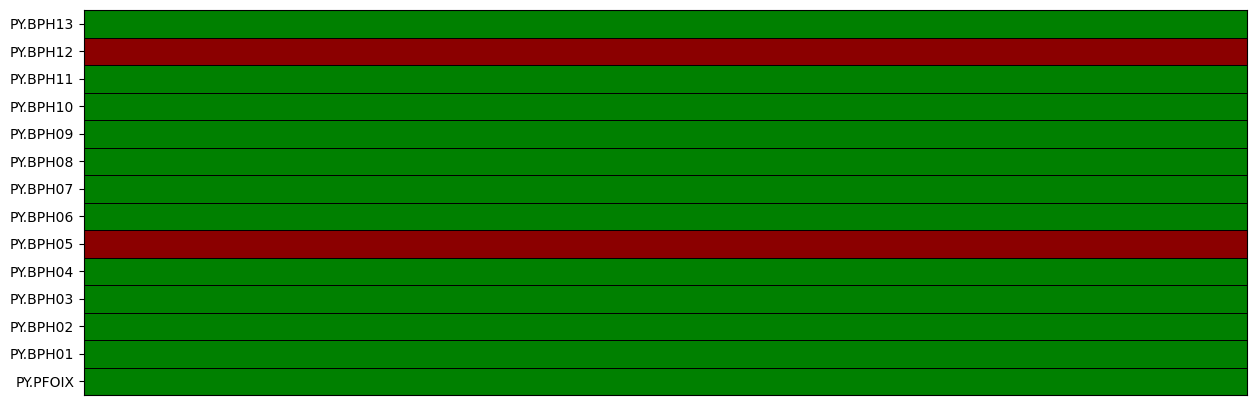


 -> Runtime: 0.71 minutes
 -> geting waveforms failed for PY.BPH05..BH* ...
 -> continue computing ADR for 8 of 9 stations ...

 -> Runtime: 0.46 minutes
 -> continue computing ADR for 5 of 5 stations ...

 -> Runtime: 0.29 minutes


15 Trace(s) in Stream:
PY.BSPF..HJE    | 2023-09-29T16:06:38.851700Z - 2023-09-29T16:07:38.851700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJN    | 2023-09-29T16:06:38.851700Z - 2023-09-29T16:07:38.851700Z | 200.0 Hz, 12001 samples
PY.BSPF..HJZ    | 2023-09-29T16:06:38.851700Z - 2023-09-29T16:07:38.851700Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHE   | 2023-09-29T16:06:38.850000Z - 2023-09-29T16:07:38.850000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHN   | 2023-09-29T16:06:38.850000Z - 2023-09-29T16:07:38.850000Z | 200.0 Hz, 12001 samples
PY.PFOIX..HHZ   | 2023-09-29T16:06:38.850000Z - 2023-09-29T16:07:38.850000Z | 200.0 Hz, 12001 samples
PY.RPFO.all.BJE | 2023-09-29T16:06:38.850000Z - 2023-09-29T16:07:38.850000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJN | 2023-09-29T16:06:38.850000Z - 2023-09-29T16:07:38.850000Z | 40.0 Hz, 2401 samples
PY.RPFO.all.BJZ | 2023-09-29T16:06:38.850000Z - 2023-09-29T16:07:38.850000Z | 40.0 Hz, 2401 samples
PY.RPFO.inn.BJE | 2023-09-29T16:06:38.850000Z - 2023-09-29T16:07:

In [8]:
global errors

errors = []
adr_status = []


for jj, ev in enumerate(tqdm(events.index)):
# for jj, ev in enumerate(events[:10]):

    print(f"\n -> {jj} {events.origin[jj]} ")
    try:
        event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]
    except:
        print(f" -> {jj}: error for event.origin")
        continue

    filename = config['outpath_figs']+"raw/"+f"{event_name}_raw.png"


    ## check if file already exists
    if os.path.isfile(filename):
        print(f" -> file alread exits for {event_name}")
        continue

    ## configuration adjustments
    config['title'] = f"{events.origin[jj]} UTC | M{events.magnitude[jj]}"
    config['tbeg'] = obs.UTCDateTime(str(events.origin[jj]))-15


    ## select appropriate seismometer
    if config['tbeg'].date < obs.UTCDateTime("2023-04-01"):
        config['seed_seismometer'] = config['seed_seismometer1']
        config['fmin'], config['fmax'] = 0.01, 18.0
    else:
        config['seed_seismometer'] = config['seed_seismometer2']
        config['fmin'], config['fmax'] = 0.01, 80.0


    ## same endtime for all
    config['tend'] = obs.UTCDateTime(events.origin[jj])+45


    ## load and process blueSeis data
    try:
        py_bspf0, py_bspf_inv = __request_data(config['seed_blueseis'], config['tbeg'], config['tend'])

    except Exception as e:
        print(e)
        print(f" -> failed to request BSPF for event: {ev}")
        errors.append(f" -> failed to request BSPF for event: {ev}")
        continue

    ## load and process seismometer data
    try:
        ii_pfo0, ii_pfo_inv = __request_data(config['seed_seismometer'], config['tbeg'], config['tend'], translation_type="ACC")

    except Exception as e:
        print(e)
        print(f" -> failed to request BSPF for event: {ev}")
        continue

    if py_bspf0 is None or ii_pfo0 is None:
        continue

    ## processing data
    if ii_pfo0[0].stats.sampling_rate != py_bspf0[0].stats.sampling_rate:
        py_bspf0.resample(ii_pfo0[0].stats.sampling_rate)


    ## joining data
    st0 = py_bspf0
    st0 += ii_pfo0


    ## compute ADR

    ## for complete array
    try:
        pfo_adr, status = __compute_adr_pfo(config['tbeg'], config['tend'], submask="all", status=True)
        for tr in pfo_adr:
            tr.stats.location = "all"
        st0 += pfo_adr
        adr_status.append(status)
    except:
        print(" -> failed to compute ADR all ...")
        pfo_adr = __empty_stream(st0)

    ## for mid array
    try:
        pfo_adr = __compute_adr_pfo(config['tbeg'], config['tend'], submask="mid")
        for tr in pfo_adr:
            tr.stats.location = "mid"
        st0 += pfo_adr
    except:
        print(" -> failed to compute ADR mid ...")
        pfo_adr = __empty_stream(st0)

    ## for inner array
    try:
        pfo_adr = __compute_adr_pfo(config['tbeg'], config['tend'], submask="inner")
        for tr in pfo_adr:
            tr.stats.location = "inn"
        st0 += pfo_adr
    except:
        print(" -> failed to compute ADR inner ...")
        pfo_adr = __empty_stream(st0)

    st0 = st0.sort()

    ## processing data stream
    st = st0.copy();
    st = st.detrend("linear");
    st = st.taper(0.01);
    st = st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True);


    st = st.trim(config['tbeg'], config['tend']);
    st0 = st0.trim(config['tbeg'], config['tend']);

    # print(st0)

    ## store waveform data
    num = str(jj).rjust(3,"0")
    waveform_filename = f"ACC/{num}_{str(events.origin[jj]).split('.')[0].replace('-','').replace(':','').replace(' ','_')}.mseed"
    st0.write(config['outpath_data']+waveform_filename, format="MSEED");

    ## store waveform data as vel / rad
    waveform_filename = f"VEL/{num}_{str(events.origin[jj]).split('.')[0].replace('-','').replace(':','').replace(' ','_')}.mseed"
    st00 = st0.copy()
    st00.integrate(method='spline')
    st00.write(config['outpath_data']+waveform_filename, format="MSEED");

    ## create eventname
    # event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]


    ## plotting figures    
    fig1 = st0.plot(equal_scale=False, show=False);

#     fig2 = __makeplot(config, st)

#     fig3 = __makeplotStreamSpectra2(st, config, fscale="linlin");

    ## saving figures
    fig1.savefig(config['outpath_figs']+"raw/"+f"{event_name}_raw.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

#     fig2.savefig(config['outpath_figs']+"filtered/"+f"{event_name}_filtered.png", dpi=200, bbox_inches='tight', pad_inches=0.05)

#     fig3.savefig(config['outpath_figs']+"spectra/"+f"{event_name}_spectra.png", dpi=200, bbox_inches='tight', pad_inches=0.05)


## End of File

## Make StatusPlot for ADR

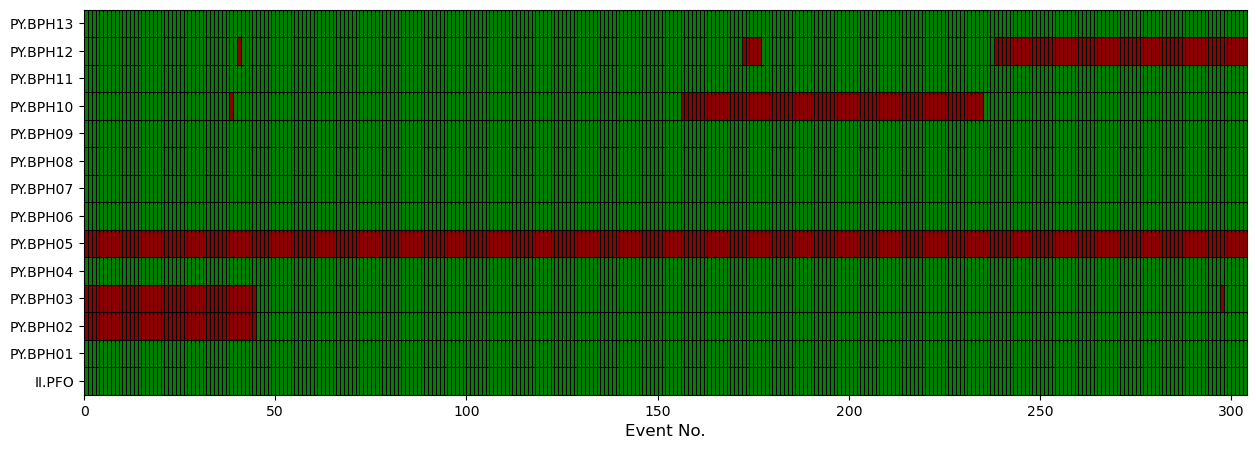

In [9]:
config['array_stations'] = ['II.PFO','PY.BPH01','PY.BPH02','PY.BPH03','PY.BPH04','PY.BPH05','PY.BPH06','PY.BPH07',
                            'PY.BPH08','PY.BPH09','PY.BPH10','PY.BPH11','PY.BPH12','PY.BPH13']


import matplotlib.colors

fig, ax = plt.subplots(1,1,figsize=(15,5))

cmap = matplotlib.colors.ListedColormap(['darkred', 'green'])

ax.pcolormesh(np.array(adr_status).T, cmap=cmap, edgecolors="k", lw=0.5)

ax.set_yticks(np.arange(0,len(config['array_stations']))+0.5, labels=config['array_stations'])

ax.set_xlabel("Event No.",fontsize=12)

plt.show();

## Testing Signal-to-Noise ratios

In [10]:
# from numpy import nanmean, sqrt

# win_length_sec = 10 ## seconds

# t_trigger = events.trigger_time[jj]
# t_rel_sec = t_trigger-config['tbeg']
# fig, ax = plt.subplots(len(st0),1, figsize=(15,15))

# for i, tr in enumerate(st0):

#     df = tr.stats.sampling_rate

#     NN = int(df * win_length_sec) ## samples

#     t_rel_spl = t_rel_sec*df ## samples

#     t_offset = df * 2 ## samples

#     noise = nanmean(tr.data[int(t_rel_spl-NN):int(t_rel_spl)]**2)
#     signal = nanmean(tr.data[int(t_rel_spl):int(t_rel_spl+NN)]**2)

#     SNR = sqrt(signal/noise)



#     ax[i].plot(tr.data)

#     ax[i].axvline(t_rel_spl, color="red")
#     ax[i].axvline(t_rel_spl+NN, color="red")

#     ax[i].axvline(t_rel_spl, color="g")
#     ax[i].axvline(t_rel_spl-NN, color="g")

#     print(SNR)

# plt.show();
